# 1. Preamble
Import modules, define functions that may or may not end up getting used, etc...

In [1]:
%matplotlib qt

# standard imports as well as some additional ones for machine learning, plotting etc.
# farther down the cell are some functions 
import numpy as np
import pandas as pd
import math
import scipy.stats
from scipy.integrate import trapz
import scipy as sp
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from os import listdir
import sys
sys.path.append('../')
import SQ_calcs
import json
import os
%matplotlib inline
import glob
from collections import OrderedDict
import seaborn as sn
import random

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import metrics
import datetime as dt

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# make a new colormap interpolating between red and blue to encode MA fraction
n_points=501
comp_colors = []
for i in range(n_points):
    # append RGBA tuple
    comp_colors.append((i/n_points,0,1-i/n_points,1))
MA_cmp = ListedColormap(comp_colors)


#change default plot settings
'''default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [1.5*val for val in default_figsize]
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 24}

mpl.rc('font', **font)
mpl.rc('axes', linewidth=3)

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)'''

mpl.style.use('wiley_publication.mplstyle')

## Useful functions used frequently defined below:

# function to correlate variables, calculate Pearson r, and plot results
def pearson_correlation(x,y,x_lab,y_lab):
    plt.figure()
    plt.plot(x,y,'.')
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    #infinites = np.logical_or(np.isfinite(x), np.isfinite(y))
    #invalids = np.logical_or(nas,infinites)
    z = scipy.stats.pearsonr(x[~nas],y[~nas])
    plt.xlim(np.min(x),np.max(x))
    plt.ylim(np.min(y),1.2*np.max(y))
    plt.text(0.5*(np.min(x)+np.max(x)),1.1*np.max(y),np.round(z,decimals=3))
    #print(np.round(z,decimals=3))


# return complement of a list (first) with respect to another (second)
def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]

# define function for handling marker styles when plotting to reflect 
# the environmental conditions used for a given data point
def envt_plot_style(temp,rh,o2,illum,encap):
   
    # currently assuming no experiments beyond 5 and 105 C
    if temp < 5:
        temp = 5
    if temp > 105:
        temp = 105
    
    if temp <= 25:
        m_color = np.array([0.00,0.00,0.20]) + (temp-5)/20*np.array([0,0.2,0])
    elif temp <= 45 and temp > 25 :
        m_color = np.array([0.00,0.20,0.20]) + (temp-25)/20*np.array([0,0,-0.2])
    elif temp <= 65 and temp > 45:
        m_color = np.array([0.00,0.20,0.00]) + (temp-45)/20*np.array([0.2,0,0])
    elif temp <= 85 and temp > 65:
        m_color = np.array([0.20,0.20,0.00]) + (temp-65)/20*np.array([0,-0.2,0])
    elif temp <=105 and temp > 85:
        m_color = np.array([0.20,0.00,0.00]) + (temp-85)/20*np.array([0,0,0.2])

    # humidity encoded by brightness
    m_color *= 1.75
    rh_factor = rh*0.65/100
    for x in range(len(m_color)):
        if m_color[x] != 0:
            m_color[x] += rh_factor

    # illumination encoded by marker shape
    if illum == 0:
        m_shape = 'p'
    elif illum == 0.5:
        m_shape = '^'
    elif illum == 1:
        m_shape = 'v'
    elif illum == 4:
        m_shape = 'h'
    elif illum == 8:
        m_shape = 'o'
    elif illum == 16:
        m_shape = 's'
    elif illum == 32:
        m_shape = 'D'
    # oxygen level encoded by marker fill
    if o2 < 20:
        m_fill = 'none'
    elif o2 < 45:
        m_fill = 'left'
    elif o2 < 80:
        m_fill = 'left'
    else:
        m_fill = 'full'

    # encapsulation encoded by line style
    if encap == 'none':
        l_style = ' '
    elif encap == '5mgmL_PMMA':
        l_style = '--'
    elif encap == '10mgmL_PMMA':
        l_style = '-'
    else:
        l_style = ' '

    return m_color, m_shape, m_fill, l_style

def plot_residuals(resids):
    plt.figure()
    _, bins, _ = plt.hist(resids)
    resid_mean = np.mean(resids)
    resid_sd = np.std(resids)
    resid_x=np.linspace(np.min(resids),np.max(resids),num=100)
    norm_dist = np.exp(-0.5*((resid_x-resid_mean)/resid_sd)**2)/(resid_sd*np.sqrt(2*np.pi))
    scale = len(resids)*(bins[1]-bins[0])
    plt.plot(resid_x,norm_dist*scale)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Residuals Histogram')    
            
# interpolate early time features to a universal time range (default is 10 min)
def interp_early_time(time_raw,timeseries,univ_horiz=10):

    idx = np.abs(time_raw-univ_horiz).idxmin() # index of datapoint closest to the horizon
    # if the nth index is at or below the horizon, increment by one;
    # otherwise, leave as is so as not to include predictions outside
    if time_raw[idx] >= univ_horiz:
        idx += 1
    else:
        idx += 2
    # interpolate from range of allowed indices to prediction horizon (5 points after start)
    series_interp_func = sp.interpolate.interp1d(time_raw[:idx],timeseries[:idx])
    t = np.linspace(0,univ_horiz,num=6)
    series_interp = series_interp_func(t)

    return(series_interp[-5:])

fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'lndTrdt':'ln($\mathrm{d}\mathcal{T}/\mathrm{d}t$)',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'mu1':'$\mu_{t=1}$',
                     'mu2':'$\mu_{t=2}$',
                     'mu3':'$\mu_{t=3}$',
                     'mu4':'$\mu_{t=4}$',
                     'mu5':'$\mu_{t=5}$',
                     'tau1':'$\\tau_{t=1}$',
                     'tau2':'$\\tau_{t=2}$',
                     'tau3':'$\\tau_{t=3}$',
                     'tau4':'$\\tau_{t=4}$',
                     'tau5':'$\\tau_{t=5}$',
                     'PL0':'$\Phi_{\mathrm{PL},0}$',
                     'LD0':'$L_{\mathrm{D},0}$',
                     'QFLS_0':'$\Delta E_{\mathrm{F},0}$',
                     'Days Stored':'$t_{\mathrm{storage}}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'O2':'$\chi_\mathrm{O_2}$',
                     'RH':'$\mathrm{RH}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\\theta_\mathrm{H_2O}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$',
                     'LAI_O2':'$\\theta_\mathrm{O_2}$',
                     'Ox_rate_LAI':'$\\theta_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Ox_rate_P':'$P_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Arrhenius_Ox':'$\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'PhotoOx_rate_P':'$P_\mathrm{O_2}N_\mathrm{suns}^{\gamma}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'dtaudt':'$\mathrm{d}\\tau/\mathrm{d}t$',
                     'dmudt':'$\mathrm{d}\mu/\mathrm{d}t$',
                     'dtdT':'$(\mathrm{d}\mathcal{T}/\mathrm{d}t)^{-1}$',
                     'dtdLD':'$(\mathrm{d}L_D/\mathrm{d}t)^{-1}$',
                     'dtdPL':'$(\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t)^{-1}$',
                     'd2tdT2':'$(\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2)^{-1}$',
                     'd2tdLD2':'$(\mathrm{d^2}L_D/\mathrm{d}t^2)^{-1}$',
                     'd2tdPL2':'$(\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2)^{-1}$',
                     'mu0':'$\mu_0$',
                     'tau0':'$\\tau_0$',
                     'ddtau0':'$\mathrm{d}^2\\tau/\mathrm{d}t^2$',
                     'ddmu0':'$\mathrm{d}^2\mu/\mathrm{d}t^2$',
                     'AB':'$T \mathrm{RH}$',
                     'AC':'$T \chi_\mathrm{O_2}$',
                     'AD':'$T N_\mathrm{suns}$',
                     'AE':'$T x_\mathrm{MA}}$',
                     'BC':'$\mathrm{RH} \chi_\mathrm{O_2}$',
                     'BD':'$\mathrm{RH} N_\mathrm{suns}$',
                     'BE':'$\mathrm{RH} x_\mathrm{MA}}$',
                     'CD':'$\chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'CE':'$\chi_\mathrm{O_2} x_\mathrm{MA}}$',
                     'DE':'$N_\mathrm{suns} x_\mathrm{MA}}$',
                     'ABC':'$T \mathrm{RH} \chi_\mathrm{O_2}$',
                     'ABD':'$T \mathrm{RH} N_\mathrm{suns}$',
                     'ABE':'$T \mathrm{RH} x_\mathrm{MA}$',
                     'ACD':'$T \chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'ACE':'$T \chi_\mathrm{O_2} x_\mathrm{MA}$',
                     'ADE':'$T N_\mathrm{suns} x_\mathrm{MA}$',
                     'BCD':'$\mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'BCE':'$\mathrm{RH} \chi_\mathrm{O_2} x_\mathrm{MA}$',
                     'BDE':'$\mathrm{RH} N_\mathrm{suns} x_\mathrm{MA}$',
                     'CDE':'$\chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}}$',
                     'ABCD':'$T \mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'ABCE':'$T \mathrm{RH} \chi_\mathrm{O_2} x_\mathrm{MA}$',
                     'ABDE':'$T \mathrm{RH} N_\mathrm{suns} x_\mathrm{MA}$',
                     'ACDE':'$T \chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}$',
                     'BCDE':'$\mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}$',
                     'ABCDE':'$T \mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}$',
                     'log_dTdt_full':'ln$(\mathrm{d}\mathcal{T}/\mathrm{d}t)_{5\%}$',
                     'dTrdt_full':'$(\mathrm{d}\mathcal{T}/\mathrm{d}t)_{5\%}$',
                     'Tr_LD80':'$\mathcal{T}_{L_\mathrm{D},80}$',
                     'lnPL80':'ln($\\tilde{\phi}_{L_\mathrm{D},80}$)',
                     'Opt_Tol':'$\mathcal{T}_{L_\mathrm{D},80}(x_\mathrm{MA})$',
                     'ddJmppdt2':'$\mathrm{d}^2J_\mathrm{MPP}/\mathrm{d}t^2$',
                     'dDFmediandt':'$\mathrm{d}m_\mathrm{DF}/\mathrm{d}t$',
                     'beta_std':'$\\sigma_{\\beta}$',
                     'dVmppdt':'$\mathrm{d}V_\mathrm{MPP}/\mathrm{d}t$',
                     'xy1t1_0':'$\sigma_{xy}(\sigma_t(I_\mathrm{PL}))$',
                     'ln_xy1t1':'ln($\sigma_{xy}(\sigma_t(I_\mathrm{PL})))$',
                     'ddVmppdt2':'$\mathrm{d}^2V_\mathrm{MPP}/\mathrm{d}t^2$',
                     'd2DFmediandt2':'$\mathrm{d}^2m_\mathrm{DF}/\mathrm{d}t^2$',
                     'ln(xy1t1_0)':'ln($\sigma_{xy}(\sigma_t(\mathrm{\phi})))$',
                     'ddJsc_revdt2':'$\mathrm{d}^2 J_\mathrm{SC}^\mathrm{rev}/\mathrm{d}t^2$',
                     'DFkurtdt_0':'$\mathrm{kurt}(I_\mathrm{DF}(t=0))$',
                     'Voc_0':'$V_\mathrm{OC}(t=0)$',
                     'dJsc_revdt':'$\mathrm{d} J_\mathrm{SC}^\mathrm{rev}/\mathrm{d}t$',
                     'xy2t1':'$\mathrm{skew}_{xy}(\sigma_t(I_\mathrm{PL}(t=0)))$',
                     'DFCV_0':'$\\frac{ \sigma_\mathrm{DF}(t=0) }{ \mu_\mathrm{DF}(t=0) }$',
                     'dDFCVdt':'$\mathrm{d} \left( \\frac{ \sigma_\mathrm{DF} }{ \mu_\mathrm{DF} } \\right)/ \mathrm{d}t$',
                     'd2DFskewdt2':'$\mathrm{d}^2 \mathrm{skew}(I_\mathrm{DF}) / \mathrm{d}t^2$',
                     'd2DFmeandt2':'$\mathrm{d}^2 \mu_\mathrm{DF} / \mathrm{d}t^2$',
                     't_Vocmax':'$t_{V_\mathrm{OC},\mathrm{max}}$',
                     'FF90_pred':'ln($t_{\mathrm{FF},90}^\mathrm{pred}$)',
                     'Jsc75_pred':'ln($t_{J_\mathrm{SC},75}^\mathrm{pred}$)',
                     'Jsc90_pred':'$t_{J_\mathrm{SC},90}^\mathrm{pred}$',
                     'd2kurtdt2':'$\mathrm{d}^2 \mathrm{kurt}(I_\mathrm{DF}) / \mathrm{d}t^2$',
                     'Vochyst_0':'$\Delta V_\mathrm{oc}^\mathrm{hyst}$',
                     'ddJsc_fwddt2':'$\mathrm{d}^2 J_\mathrm{SC,fwd} / \mathrm{d}t^2$',
                     'ddFF_revdt2':'$\mathrm{d}^2 \mathrm{FF_{rev}} / \mathrm{d}t^2$',
                     'd2DFkurtdt2':'$\mathrm{d}^2 \mathrm{kurt}(I_\mathrm{DF}) / \mathrm{d}t^2$',
                     'ddxy1t1':'$\mathrm{d}^2  \sigma_{xy}(\sigma_t(I_\mathrm{PL})) / \mathrm{d}t^2$',
                     'dPmppdt':'$\mathrm{d} P_\mathrm{MPP}/\mathrm{d}t$',
                     'ln(MAPI_degrate)':'ln($r_\mathrm{MAPI}$)',
                     'MAPI_degrate':'$r_\mathrm{MAPI}$',
                     't_Jsc75':'$t_{J_\mathrm{SC},75}$',
                     't_FF90':'$t_\mathrm{FF,90}$',
                     't_PCE75':'$t_\mathrm{PCE,75}$',
                    }

encap = 'none'

# 2. Import Data/Calculate Physics-Inspired Features

In this block, read in the data, which has already been boiled down into features by a separate "featurizer" notebook that is somewhat time-consuming to run. From the raw environment and composition data in the featurized dataset, calculate physics-inspired features. 

In [2]:
# Read the CSV containing featurized data into the "rawdata_df" DataFrame
readpath = 'C:/Users/Wiley.LAPTOP-KQ1TRN8R/Desktop/Just In Case/Calculations/hp-db/hp-db/Ld/'
#readname = '201216_Replication_Data.csv'
#readname = '210818_Featurized_Data_Devices_withMPPTruns.csv'
readname = '210819_Featurized_Data_Devices_absolute_hysteresis.csv'
#readname = '210802_Featurized_Data_Devices_withMPPTruns_2.csv'
rawdata_df = pd.read_csv(readpath+readname)



# Convert RH and %O2 to more partial pressures
T_gas = 25 # temperature of gas above the sample, in deg C
P_sat = 10**(8.07131 - 1730.63/(233.426 + T_gas)) # vapor pressure of H2O from Antoine equation [mm Hg]
rawdata_df['P_H2O'] = 101325*rawdata_df['RH (%)']/100*P_sat/760 # convert RH [%] to PH2O [Pa]
rawdata_df['P_O2'] = 101325*rawdata_df['Oxygen (%)']/100 # convert mole fraction of oxygen to PO2 [Pa] 



# Add physics-inspired features

# adsorption energy for O2, eV
E_ads_O2_MAPI = -0.19
E_ads_O2_FACs = -0.10
E_ads_O2 = (E_ads_O2_FACs+(E_ads_O2_MAPI-E_ads_O2_FACs)*rawdata_df['MA fraction'])*1.6e-19 # linear relationship based on composition

# adsorption energy for H2O, eV
E_ads_MAPI = -0.45
E_ads_FAPI = -0.27 
E_ads_H2O = (E_ads_FAPI+(E_ads_MAPI-E_ads_FAPI)*rawdata_df['MA fraction'])*1.6e-19 # linear relationship based on composition

T_Kelvin = rawdata_df['Temp (deg C)'] + 273.15 # convert temperature to K
h = 6.626e-34 # Planck's constant, J s
h_bar = h/(2*np.pi)
kB = 1.38e-23 # Boltzmann's constant, J/K

# calculate Langmuir isotherm for O2, using Keq following derivation in Schroeder
m_O2 = 16*1.67e-27 # approx. mass of O2 molecule, amu -> kg
eps_rot = 0.00018*1.6e-19 # rotational energy constant of O2 molecule, eV -> J
vQ_O2 = h**3*(2*np.pi*m_O2*kB*T_Kelvin)**(-3/2) # quantum volume of O2 [m3]
# equilibrium constant for O2 adsorption [1/Pa]
Keq_O2 = 2/3*eps_rot*h**3*(2*np.pi*m_O2)**(-3/2)*np.exp(-E_ads_O2/(kB*T_Kelvin))*(kB*T_Kelvin)**(-7/2)

# Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
LAI_O2 = Keq_O2*rawdata_df['P_O2']/(1+Keq_O2*rawdata_df['P_O2'])     

# calculate Langmuir isotherm for H2O using empirical internal partition function...

# empirical relation for internal partition function of H2O from Tennyson and Vidler
a0 = -14.238481
a1 = 38.053703
a2 = -42.649044
a3 = 25.238163
a4 = -8.056219
a5 = 1.317839
a6 = -0.086023

# define function for internal partition function of H2O based on T&V values
Z_int_H2O = lambda T: 10**( a0*(np.log10(T))**0 + a1*(np.log10(T))**1 +\
                a2*(np.log10(T))**2 + a3*(np.log10(T))**3 +\
                a4*(np.log10(T))**4 + a5*(np.log10(T))**5 +\
                a6*(np.log10(T))**6 
              )

m_H2O = 18.02*1.67e-27 # mass of H2O [kg]
# equilibrium constant for H2O adsorption [1/Pa]
Keq_H2O = (h/np.sqrt(2*np.pi*m_H2O))**3*(kB*T_Kelvin)**(-5/2)/Z_int_H2O(T_Kelvin)*np.exp(-E_ads_H2O/(kB*T_Kelvin))

# Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
LAI_H2O = Keq_H2O*rawdata_df['P_H2O']/(1 + Keq_H2O*rawdata_df['P_H2O'])

rawdata_df['LAI_H2O'] = LAI_H2O

# calculate expected MAPI degradation rate from conditions

# constants:

# water-assisted and dry photooxidation parameters
kWPO = 3.16e-25
kDPO = 5.45e-15
EWPO = -0.09*1.6e-19
EDPO = 0.62*1.6e-19
K2_WPO = 4.4e-3
K2_DPO = 3.28e-3
K4_WPO = 4.32e-15
K4_DPO = 6.97e-15

# moisture-induced degradation parameters
khum = 1.80e-6
Ehum = 0.20*1.6e-19

# thermal decomposition parameters
ktherm = 0.00041
Etherm = 0.45*1.6e-19

# obsolete: constant intercept
#c = 9.63e-10

# incident photon flux
inc_flux = SQ_calcs.one_sun_photon_flux(1.6)

# rate of water-assisted photooxidation
r_WPO = kWPO * np.exp(-EWPO/(kB*T_Kelvin)) \
             * (rawdata_df['P_O2']/1000)*(rawdata_df['P_H2O']/1000)*(inc_flux*rawdata_df['Illum (Nsuns)'])**0.7 \
             / ( 1 + K2_WPO*(rawdata_df['P_O2']/1000)*( 1 + K4_WPO*(inc_flux*rawdata_df['Illum (Nsuns)'])**0.7) )**2

# rate of dry photooxidation
r_DPO = kDPO * np.exp(-EDPO/(kB*T_Kelvin)) \
             * (rawdata_df['P_O2']/1000)*(inc_flux*rawdata_df['Illum (Nsuns)'])**0.7 \
             / ( 1 + K2_DPO*(rawdata_df['P_O2']/1000)*( 1 + K4_DPO*(inc_flux*rawdata_df['Illum (Nsuns)'])**0.7) )

# rate of moisture-induced decomposition
r_hum = khum * np.exp(-Ehum/(kB*T_Kelvin)) \
        * rawdata_df['P_H2O']/1000

# rate of thermal decomposition
r_therm = ktherm * np.exp(-Etherm/(kB*T_Kelvin))

# grand sum over all pathways
rawdata_df['MAPI_degrate'] = r_WPO + r_DPO + r_hum + r_therm

#rawdata_df['FF_0'] = rawdata_df['Vmpp_0']*rawdata_df['Jmpp_0']/(rawdata_df['Voc_0']*rawdata_df['Jsc_0'])

# remove problem runs - tried to do this a smart way with string comprehensions 
# but gave up and did it with for loops instead - not Pythonic but functional

# old definition
# bad_list = ['JV_PL_DF_MAPI_1sun_45C_40RH_air', # weird recovery of Jsc late in run
#             'JV_PL_DF_MAPI_1sun_25C_40RH_air_bad_DF', # DF not good
#             'P38-3-8_unsteady_bias_and_light', # missing data I believe
#             'JV_PL_DF_MAPI_1sun_75C_40RH_air', # initial DF has problems
#             'JV_PL_DF_MAPI_1sun_35C_30RH_air', # initial DF has problems
#             'JV_PL_DF_MAPI_1sun_85C_60RH_air_bad2', # PL definitely bad, everything else might be too
#             'JV_PL_DF_MAPI_1sun_85C_50RH_air_bad_DF', # DF definitely bad, everything else might be too
#            ]

bad_list = [#'P38_X-6_fullsuite' # not necessarily bad data, but fails abnormally quickly
           ]

bad_idxs = []

for item in bad_list:
    for ii in rawdata_df.index:
        if rawdata_df['ExptID'][ii] == item:
            bad_idxs.append(ii)

rawdata_df = rawdata_df.drop(index=bad_idxs)

# log-transform the target variables
rawdata_df['ln_PCE75'] = np.log(rawdata_df['t_PCE75'])
rawdata_df['ln_Jsc75'] = np.log(rawdata_df['t_Jsc75'])


# use Counter to subtract lists
from collections import Counter

# specify whether or not to use a priori environmental or compositional features
apriori_allowed = True

# these can never be used as features
invalids = ['Unnamed: 0', 
            'ClassID', 
            'ExptID', 
            'BatchID', 
            'Drive',
            'pred_horiz',
            't_Jsc75',
            't_Voc75',
            't_Jsc75_max',
            't_Voc75_max',
            't_PCE75_max',
            't_PCE75',
            'ln_PCE75',
            'ln_Jsc75',
            'LAI_H2O',
            't_Vocmax',
            't_FF90',
            't_Jsc90',
            'PL_ok',
            'JV_ok',
            'DF_ok'
           ]

# a priori environmental/compositional features might not be used as features sometimes
envtals = ['Temp (deg C)',
           'RH (%)', 
           'Oxygen (%)', 
           'Illum (Nsuns)', 
           'MA fraction',
           'P_O2',
           'P_H2O',
           'MAPI_degrate'
          ]

# depending on whether or not to use a priori features, decide which features are not valid
if apriori_allowed:
    to_subtract = Counter(invalids)
else:
    to_subtract = Counter(invalids + envtals)

# from the entire data frame header...
headings = Counter(rawdata_df.columns)

# ...extract only the base features, and return to list type
base_features = list(headings - to_subtract)
    
##### now that we have the feature list, let's see which ones we can log transform

# make a bigger list with features and log-transformed ones, if possible
new_feats = []

for feat in base_features:
    # if all values in the column corresponding to a feature are positive...
    if np.all(rawdata_df[feat].values > 0):
        # take the log transform of that parameter
        new_name = 'ln(' + feat + ')'
        new_feats.append(new_name)
        rawdata_df[new_name] = np.log(rawdata_df[feat])
        print(new_name)
    
# now put all the features together in one big list        
grand_feats = base_features + new_feats

JV_feats=[
          'Jmpp_0','Vmpp_0','Pmpp_0','Jsc_0','Voc_0',#'FF_0',
          'dJmppdt','dVmppdt','dPmppdt','dJscdt','dVocdt',
          'ddJmppdt2','ddVmppdt2','ddPmppdt2','ddJscdt2','ddVocdt2',
          'Jschyst_0','Vochyst_0','FFhyst_0',
          'dJsc_fwddt','dVoc_fwddt','dFF_fwddt',
          'dJsc_revdt','dVoc_revdt','dFF_revdt',
          'ddJsc_fwddt2','ddVoc_fwddt2','ddFF_fwddt2',
          'ddJsc_revdt2','ddVoc_revdt2','ddFF_revdt2',
          'ln(Jmpp_0)','ln(Vmpp_0)','ln(Pmpp_0)','ln(Voc_0)',
         ]

DF_feats=[
          'dDFmeandt','dDFmediandt','dDFstddt','dDFskewdt','dDFkurtdt',
          'd2DFmeandt2','d2DFmediandt2','d2DFstddt2','d2DFskewdt2','d2DFkurtdt2',
          'DFmean_0','DFmedian_0','DFstd_0','DFskew_0','DFkurtdt_0',
         ]

PL_feats=[
          'PLQY_0',
          'xy1t0_0','xy0t1_0','xy0t1Norm_0','xy1t1_0','t0xy1_0','t1xy0_0','xy2t0','xy3t0','xy2t1','xy3t1',
          'frac_bright_0','QFLS_0','beta_mean','beta_std','cv_slopes',
          'dxy1t0dt','dxy0t1dt','dxy0t1Normdt','dxy1t1dt','dt0xy1dt',
          'dt1xy0dt','dfrac_brightdt','dxy2t0dt','dxy3t0dt','dxy2t1dt',
          'dxy3t1dt','dbeta_meandt','dbeta_stddt','dcv_slopesdt',
          'ddxy1t0','ddxy0t1','ddxy0t1Norm','ddxy1t1','ddt0xy1',
          'ddt1xy0','ddfrac_bright','ddxy2t0','ddxy3t0','ddxy2t1',
          'ddxy3t1','ddbeta_mean','ddbeta_std','ddcv_slopes',
          'DFCV_0','dDFCVdt','d2DFCVdt2',
          'ln(xy1t0_0)','ln(xy0t1_0)','ln(xy0t1Norm_0)','ln(xy1t1_0)','ln(t0xy1_0)','ln(t1xy0_0)',
          'ln(frac_bright_0)','ln(QFLS_0)','ln(beta_std)',
         ]

aprioris = [
            'Temp (deg C)',
            'RH (%)', 
            'Oxygen (%)', 
            'Illum (Nsuns)', 
            'MA fraction',
            'P_O2',
            'P_H2O',
            'MAPI_degrate',
            'ln(Temp (deg C))',
            'ln(RH (%))', 
            'ln(Oxygen (%))', 
            'ln(Illum (Nsuns))', 
            'ln(MA fraction)',
            'ln(P_O2)',
            'ln(P_H2O)',
            'ln(MAPI_degrate)',
          ]

# check that everything is copacetic in the augmented dataframe
rawdata_df

ln(Temp (deg C))
ln(RH (%))
ln(Oxygen (%))
ln(Illum (Nsuns))
ln(MA fraction)
ln(PLQY_0)
ln(xy1t0_0)
ln(xy0t1_0)
ln(xy0t1Norm_0)
ln(xy1t1_0)
ln(t0xy1_0)
ln(t1xy0_0)
ln(frac_bright_0)
ln(QFLS_0)
ln(beta_std)
ln(Jmpp_0)
ln(Vmpp_0)
ln(Pmpp_0)
ln(Voc_0)
ln(P_H2O)
ln(P_O2)
ln(MAPI_degrate)


Unnamed: 0                         ClassID  \
0            0             210412_MAPI_Devices   
1            1             210412_MAPI_Devices   
2            2             210412_MAPI_Devices   
3            3             210412_MAPI_Devices   
4            4             210412_MAPI_Devices   
5            5             210412_MAPI_Devices   
6            6             210412_MAPI_Devices   
7            7             210412_MAPI_Devices   
8            8             210412_MAPI_Devices   
9            9             210412_MAPI_Devices   
10          10             210412_MAPI_Devices   
11          11             210412_MAPI_Devices   
12          12             210412_MAPI_Devices   
13          13             210412_MAPI_Devices   
14          14             210412_MAPI_Devices   
15          15             210412_MAPI_Devices   
16          16             210412_MAPI_Devices   
17          17             210412_MAPI_Devices   
18          18  210122_Schrodingers_Perovskite   
19          19  210122_Schrodingers_Perovskite   
20          20  210122_Schrodingers_Perovskite   
21          21  210122_Schrodingers_Perovskite   
22          22  210122_Schrodingers_Perovskite   
23          23  210122_Schrodingers_Perovskite   
24          24  210122_Schrodingers_Perovskite   
25          25  210122_Schrodingers_Perovskite   
26          26             210412_MAPI_Devices   
27          27             210412_MAPI_Devices   
28          28             210412_MAPI_Devices   
29          29             210412_MAPI_Devices   
30          30             210412_MAPI_Devices   

                                    ExptID   BatchID Drive  JV_ok  PL_ok  \
0          JV_PL_DF_MAPI_1sun_35C_40RH_air     YM7-2   EP3   True   True   
1          JV_PL_DF_MAPI_1sun_35C_50RH_air    YM7-12   EP3   True   True   
2          JV_PL_DF_MAPI_1sun_45C_40RH_air    YM7-10   EP3  False  False   
3          JV_PL_DF_MAPI_1sun_45C_60RH_air     YM7-6   EP3   True   True   
4          JV_PL_DF_MAPI_1sun_45C_50RH_air     YM7-4   EP3   True   True   
5   JV_PL_DF_MAPI_1sun_25C_40RH_air_bad_DF    YM7-11   EP3   True   True   
6        JV_PL_DF_MAPI_1sun_45C_40RH_air_2     YM7-3   EP3   True   True   
7          JV_PL_DF_MAPI_1sun_25C_30RH_air     YM7-5   EP3   True   True   
8          JV_PL_DF_MAPI_1sun_25C_70RH_air    YM12-2   EP3   True   True   
9          JV_PL_DF_MAPI_1sun_45C_70RH_air    YM12-8   EP3   True   True   
10         JV_PL_DF_MAPI_1sun_35C_60RH_air   YM14-10   EP3   True   True   
11         JV_PL_DF_MAPI_1sun_45C_30RH_air   YM14-11   EP3   True   True   
12         JV_PL_DF_MAPI_1sun_35C_70RH_air   YM14-14   EP3   True   True   
13       JV_PL_DF_MAPI_1sun_35C_70RH_air_2    YM14-5   EP3   True   True   
14         JV_PL_DF_MAPI_1sun_35C_30RH_air    YM15-1   EP3   True   True   
15         JV_PL_DF_MAPI_1sun_65C_40RH_air    YM15-3   EP3   True   True   
16         JV_PL_DF_MAPI_1sun_85C_40RH_air   YM15-10   EP3   True   True   
17         JV_PL_DF_MAPI_1sun_75C_40RH_air    YM15-4   EP3   True   True   
18                       P38_X-6_fullsuite     P38-X   EP3   True   True   
19         P38-3-8_unsteady_bias_and_light     P38-3   EP3  False  False   
20         W86-5-8_unsteady_bias_and_light   WDS84-5   EP3   True   True   
21       WDS84-1-8_unsteady_bias_and_light   WDS84-1   EP3   True   True   
22           YM5-1-3_Full_Suite_15min_50RH     YM5-1   EP3   True   True   
23                YM5-6-5_Full_Suite_15min     YM5-6   EP3   True   True   
24          YM5-12-3_Full_Suite_15min_60RH    YM5-12   EP3   True   True   
25                    WDS84-11-8_MPPT_Only  WDS84-11   EP3   True   True   
26       JV_PL_DF_MAPI_1sun_35C_30RH_air_2   YM16-14   EP1   True   True   
27  JV_PL_DF_MAPI_1sun_85C_50RH_air_bad_DF   YM15-10   EP1  False  False   
28    JV_PL_DF_MAPI_1sun_85C_60RH_air_bad2    YM16-5   EP1   True  False   
29         JV_PL_DF_MAPI_1sun_85C_60RH_air    YM16-5   EP1   True   True   
30         JV_PL_DF_MAPI_1sun_55C_40RH_air    Y

In [3]:
# check to make sure that there aren't any features that don't belong
grand_feats


['Temp (deg C)',
 'RH (%)',
 'Oxygen (%)',
 'Illum (Nsuns)',
 'MA fraction',
 'PLQY_0',
 'xy1t0_0',
 'xy0t1_0',
 'xy0t1Norm_0',
 'xy1t1_0',
 't0xy1_0',
 't1xy0_0',
 'xy2t0',
 'xy3t0',
 'xy2t1',
 'xy3t1',
 'frac_bright_0',
 'QFLS_0',
 'beta_mean',
 'beta_std',
 'cv_slopes',
 'dDFmeandt',
 'dDFmediandt',
 'dDFstddt',
 'dDFskewdt',
 'dDFkurtdt',
 'd2DFmeandt2',
 'd2DFmediandt2',
 'd2DFstddt2',
 'd2DFskewdt2',
 'd2DFkurtdt2',
 'DFmean_0',
 'DFmedian_0',
 'DFstd_0',
 'DFskew_0',
 'DFkurtdt_0',
 'Jmpp_0',
 'Vmpp_0',
 'Pmpp_0',
 'Jsc_0',
 'Voc_0',
 'dJmppdt',
 'dVmppdt',
 'dPmppdt',
 'dJscdt',
 'dVocdt',
 'ddJmppdt2',
 'ddVmppdt2',
 'ddPmppdt2',
 'ddJscdt2',
 'ddVocdt2',
 'Jschyst_0',
 'Vochyst_0',
 'FFhyst_0',
 'dJsc_fwddt',
 'dVoc_fwddt',
 'dFF_fwddt',
 'dJsc_revdt',
 'dVoc_revdt',
 'dFF_revdt',
 'ddJsc_fwddt2',
 'ddVoc_fwddt2',
 'ddFF_fwddt2',
 'ddJsc_revdt2',
 'ddVoc_revdt2',
 'ddFF_revdt2',
 'dPLdt',
 'ddPLdt2',
 'dxy1t0dt',
 'dxy0t1dt',
 'dxy0t1Normdt',
 'dxy1t1dt',
 'dt0xy1dt',
 'dt1xy

Text(0.5, 1.0, 'Device Degradation Runs')

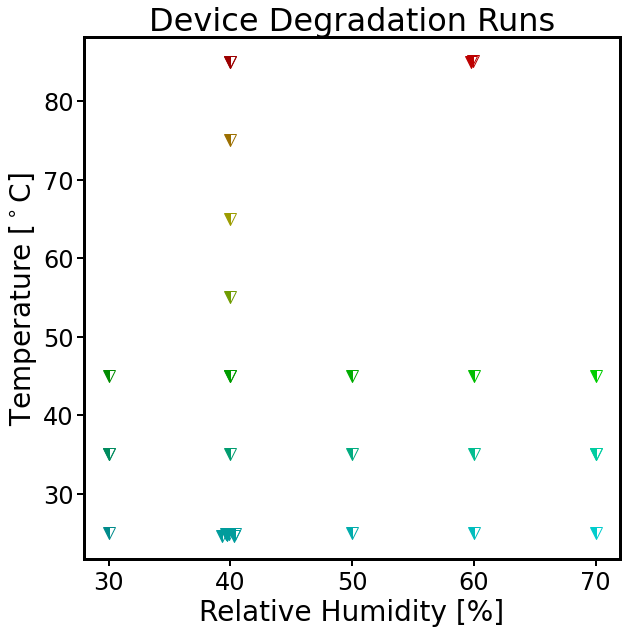

In [4]:
# Break down dataset by environmental conditions

for ii in range(len(rawdata_df)):

    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    if (T == 25 and RH == 40) or (T == 85 and RH == 60):
        jitter_x = random.gauss(0,0.25)
        jitter_y = random.gauss(0,0.25)
    else:
        jitter_x = 0
        jitter_y = 0
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    plt.plot(RH + jitter_x,T + jitter_y,color=color, marker=marker, fillstyle=fill)

plt.xlabel('Relative Humidity [%]')
plt.ylabel('Temperature [$^\circ$C]')
plt.title('Device Degradation Runs')

In [6]:
# Filter feature and datasets by which variables we are allowed to use

vars_allowed = 'JV_only' # only J-V and a priori variables (broadest applicability)
#vars_allowed = 'img_only' # only PL/DF image data (possibly implementable for in-situ testing)
#vars_allowed = 'all' # most powerful in principle BUT also most restrictive bc have to throw out data
                     # if even one of the feature sets is compromised (usually dark field)

# do the filter
if vars_allowed == 'all':
    rawdata_df = rawdata_df[rawdata_df['PL_ok'] == True]
    rawdata_df = rawdata_df[rawdata_df['JV_ok'] == True]
    rawdata_df = rawdata_df[rawdata_df['DF_ok'] == True]
    grand_feats = JV_feats + aprioris + PL_feats + DF_feats
elif vars_allowed == 'JV_only':
    rawdata_df = rawdata_df[rawdata_df['JV_ok'] == True]
    grand_feats = JV_feats + aprioris
elif vars_allowed == 'img_only':
    rawdata_df = rawdata_df[rawdata_df['PL_ok'] == True]
    rawdata_df = rawdata_df[rawdata_df['JV_ok'] == True]
    rawdata_df = rawdata_df[rawdata_df['DF_ok'] == True]
    grand_feats = PL_feats + DF_feats

rawdata_df

Unnamed: 0                         ClassID  \
0            0             210412_MAPI_Devices   
1            1             210412_MAPI_Devices   
3            3             210412_MAPI_Devices   
4            4             210412_MAPI_Devices   
6            6             210412_MAPI_Devices   
7            7             210412_MAPI_Devices   
8            8             210412_MAPI_Devices   
9            9             210412_MAPI_Devices   
10          10             210412_MAPI_Devices   
11          11             210412_MAPI_Devices   
12          12             210412_MAPI_Devices   
13          13             210412_MAPI_Devices   
15          15             210412_MAPI_Devices   
16          16             210412_MAPI_Devices   
18          18  210122_Schrodingers_Perovskite   
20          20  210122_Schrodingers_Perovskite   
21          21  210122_Schrodingers_Perovskite   
22          22  210122_Schrodingers_Perovskite   
23          23  210122_Schrodingers_Perovskite   
24          24  210122_Schrodingers_Perovskite   
25          25  210122_Schrodingers_Perovskite   
26          26             210412_MAPI_Devices   
29          29             210412_MAPI_Devices   

                               ExptID   BatchID Drive  JV_ok  PL_ok  DF_ok  \
0     JV_PL_DF_MAPI_1sun_35C_40RH_air     YM7-2   EP3   True   True   True   
1     JV_PL_DF_MAPI_1sun_35C_50RH_air    YM7-12   EP3   True   True   True   
3     JV_PL_DF_MAPI_1sun_45C_60RH_air     YM7-6   EP3   True   True   True   
4     JV_PL_DF_MAPI_1sun_45C_50RH_air     YM7-4   EP3   True   True   True   
6   JV_PL_DF_MAPI_1sun_45C_40RH_air_2     YM7-3   EP3   True   True   True   
7     JV_PL_DF_MAPI_1sun_25C_30RH_air     YM7-5   EP3   True   True   True   
8     JV_PL_DF_MAPI_1sun_25C_70RH_air    YM12-2   EP3   True   True   True   
9     JV_PL_DF_MAPI_1sun_45C_70RH_air    YM12-8   EP3   True   True   True   
10    JV_PL_DF_MAPI_1sun_35C_60RH_air   YM14-10   EP3   True   True   True   
11    JV_PL_DF_MAPI_1sun_45C_30RH_air   YM14-11   EP3   True   True   True   
12    JV_PL_DF_MAPI_1sun_35C_70RH_air   YM14-14   EP3   True   True   True   
13  JV_PL_DF_MAPI_1sun_35C_70RH_air_2    YM14-5   EP3   True   True   True   
15    JV_PL_DF_MAPI_1sun_65C_40RH_air    YM15-3   EP3   True   True   True   
16    JV_PL_DF_MAPI_1sun_85C_40RH_air   YM15-10   EP3   True   True   True   
18                  P38_X-6_fullsuite     P38-X   EP3   True   True   True   
20    W86-5-8_unsteady_bias_and_light   WDS84-5   EP3   True   True   True   
21  WDS84-1-8_unsteady_bias_and_light   WDS84-1   EP3   True   True   True   
22      YM5-1-3_Full_Suite_15min_50RH     YM5-1   EP3   True   True   True   
23           YM5-6-5_Full_Suite_15min     YM5-6   EP3   True   True   True   
24     YM5-12-3_Full_Suite_15min_60RH    YM5-12   EP3   True   True   True   
25               WDS84-11-8_MPPT_Only  WDS84-11   EP3   True   True   True   
26  JV_PL_DF_MAPI_1sun_35C_30RH_air_2   YM16-14   EP1   True   True   True   
29    JV_PL_DF_MAPI_1sun_85C_60RH_air    YM16-5   EP1   True   True   True   

    Temp (deg C)  RH (%)  ...  ln(frac_bright_0)  ln(QFLS_0)  ln(beta_std)  \
0             35      40  ...          -0.418767    0.149635     34.045588   
1             35      50  ...          -1.731168    0.152583     34.439872   
3             45      60  ...          -0.728666    0.141454     33.910263   
4             45      50  ...          -0.330784    0.143884     34.288971   
6             45      40  ...          -0.344635    0.141701     34.905618   
7             25      30  ...          -1.231251    0.156422     34.847136   
8             25      70  ...          -0.186659    0.167242     36.166445   
9             45      70  ...          -0.287899    0.147884     35.451525   
10            35      60  ...          -0.499648    0.154385     34.898142   
11            45      30  ...          -0.127943    0.138327     36.145711   
12            35      70  ...          -0.153671    0.150022     34.0237

# Feature Correlation Ranker

In [7]:
pd.set_option('display.max_rows', None)


#feat_interest = 'd2DFmeandt2'
feat_interest = 't_Jsc75'
#feat_interest = 'ddxy1t1'
#feat_interest = 'dbeta_meandt'
#feat_interest = 'DFCV_0'
#eat_interest = 'dDFmediandt'
#feat_interest = 'ddVmppdt2'
#feat_interest = 'MAPI_degrate'
#feat_interest = 'dDFCVdt'

Pearson_Rs = []
Pearson_Rs_abs = []


# calculate correlation coefficients
for feat in grand_feats:
    # screen out points where data are missing
    if feat_interest == 't_Jsc75':
        nas = np.logical_or(np.isnan(np.log(rawdata_df[feat_interest].values)), np.isnan(rawdata_df[feat].values))
        r,_ = scipy.stats.pearsonr(np.log(rawdata_df[feat_interest].values[~nas]),rawdata_df[feat].values[~nas])
    else:
        nas = np.logical_or(np.isnan(rawdata_df[feat_interest].values), np.isnan(rawdata_df[feat].values))
        r,_ = scipy.stats.pearsonr(rawdata_df[feat_interest].values[~nas],rawdata_df[feat].values[~nas])
       
    Pearson_Rs.append(r)
    Pearson_Rs_abs.append(np.abs(r))
    
# create a dataframe keeping track of features and correlation coefficients
feat_corrs_df = pd.DataFrame(columns = ['Feature','Pearson R','Pearson |R|'])
feat_corrs_df['Feature'] = grand_feats
feat_corrs_df['Pearson R'] = Pearson_Rs
feat_corrs_df['Pearson |R|'] = Pearson_Rs_abs

# rank and view them
feat_corrs_df_sorted = feat_corrs_df.sort_values(by='Pearson |R|',ascending=False)
feat_corrs_df_sorted



C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Feature  Pearson R  Pearson |R|
10          ddJmppdt2   0.633533     0.633533
7             dPmppdt   0.458523     0.458523
15          Jschyst_0  -0.400919     0.400919
49   ln(MAPI_degrate)  -0.396465     0.396465
11          ddVmppdt2  -0.390497     0.390497
18         dJsc_fwddt  -0.389853     0.389853
21         dJsc_revdt  -0.380675     0.380675
41       MAPI_degrate  -0.378180     0.378180
6             dVmppdt   0.364550     0.364550
16          Vochyst_0  -0.329579     0.329579
12          ddPmppdt2  -0.309450     0.309450
28       ddVoc_revdt2  -0.256639     0.256639
25       ddVoc_fwddt2  -0.251840     0.251840
24       ddJsc_fwddt2   0.240974     0.240974
4               Voc_0  -0.217018     0.217018
33          ln(Voc_0)  -0.208731     0.208731
27       ddJsc_revdt2   0.207216     0.207216
22         dVoc_revdt   0.201869     0.201869
19         dVoc_fwddt   0.196823     0.196823
48          ln(P_H2O)  -0.191200     0.191200
43         ln(RH (%))  -0.191200     0.191200
5             dJmppdt  -0.158661     0.158661
40              P_H2O  -0.152978     0.152978
35             RH (%)  -0.152978     0.152978
13           ddJscdt2  -0.139261     0.139261
3               Jsc_0  -0.135774     0.135774
8              dJscdt  -0.132487     0.132487
1              Vmpp_0  -0.129284     0.129284
14           ddVocdt2   0.128194     0.128194
31         ln(Vmpp_0)  -0.128181     0.128181
26        ddFF_fwddt2  -0.107736     0.107736
29        ddFF_revdt2  -0.094027     0.094027
34       Temp (deg C)  -0.086062     0.086062
23          dFF_revdt  -0.067125     0.067125
17           FFhyst_0   0.059509     0.059509
30         ln(Jmpp_0)   0.058047     0.058047
0              Jmpp_0   0.046866     0.046866
20          dFF_fwddt   0.036290     0.036290
9              dVocdt  -0.034081     0.034081
2              Pmpp_0  -0.026716     0.026716
42   ln(Temp (deg C))   0.025661     0.025661
32         ln(Pmpp_0)   0.000569     0.000569
36         Oxygen (%)        NaN          NaN
37      Illum (Nsuns)        NaN          NaN
38        MA fraction        NaN          NaN
39               P_O2        NaN          NaN
44     ln(Oxygen (%))        NaN          NaN
45  ln(Illum (Nsuns))        NaN          NaN
46    ln(MA fraction)        NaN          NaN
47           ln(P_O2)        NaN          NaN

Power Law Slope: -0.2058330425233769


Text(0.5, 1.0, '$\\rho$ = -0.2478')

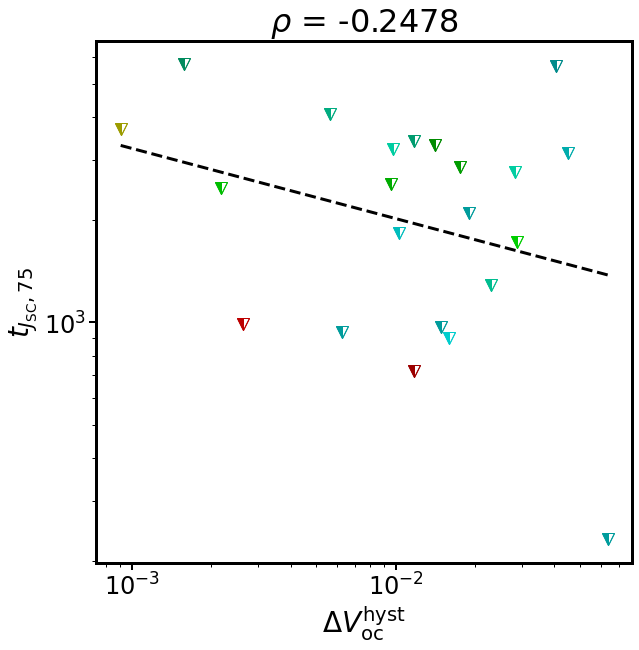

In [8]:
fig, ax = plt.subplots()

#feat_interest = 'dDFCVdt'
#feat_interest = 'ln(MAPI_degrate)'
feat_interest = 'MAPI_degrate'
#feat_interest = 't_Jsc75' 
feat_interest = 'Vochyst_0'
#feat_interest = 'FF_0'

log_x = True

p_feat = 't_Jsc75' 
#p_feat = 'ln(MAPI_degrate)'
#p_feat = 'MAPI_degrate'
#p_feat = 'Vochyst_0'
#p_feat = 't_PCE75' 
#p_feat = 't_FF90' 
#p_feat = 't_Vocmax' 

log_y = True

# plot each point according to conditions
for ii in range(len(rawdata_df)):

    # get environmental conditions
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    xMA = rawdata_df['MA fraction'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    # plot points
    ax.plot(rawdata_df[feat_interest].iloc[ii],rawdata_df[p_feat].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
    if log_x and not log_y:
        ax.semilogx(rawdata_df[feat_interest].iloc[ii],rawdata_df[p_feat].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
    elif log_y and not log_x:
        ax.semilogy(rawdata_df[feat_interest].iloc[ii],rawdata_df[p_feat].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
    elif log_y and log_x:
        ax.loglog(rawdata_df[feat_interest].iloc[ii],rawdata_df[p_feat].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
    else:
        ax.plot(rawdata_df[feat_interest].iloc[ii],rawdata_df[p_feat].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
        
# label axes
ax.set_xlabel(fancy_labels_dict[feat_interest])
ax.set_ylabel(fancy_labels_dict[p_feat])

# identify where NaNs occur in the dataset...
if log_x and not log_y:
    nas = np.logical_or(np.isnan(np.log(rawdata_df[feat_interest].values)),np.isnan(rawdata_df[p_feat].values))
    # ... and do not use them for calculating the correlation coefficient
    r,_ = sp.stats.pearsonr(np.log(rawdata_df[feat_interest].values[~nas]),rawdata_df[p_feat].values[~nas])
if log_y and not log_x:
    nas = np.logical_or(np.isnan(rawdata_df[feat_interest].values),np.isnan(np.log(rawdata_df[p_feat].values)))
    # ... and do not use them for calculating the correlation coefficient
    r,_ = sp.stats.pearsonr(rawdata_df[feat_interest].values[~nas],np.log(rawdata_df[p_feat].values[~nas]))
if log_y and log_x:
    nas = np.logical_or(np.isnan(np.log(rawdata_df[feat_interest].values)),np.isnan(np.log(rawdata_df[p_feat].values)))
    # ... and do not use them for calculating the correlation coefficient
    r,_ = sp.stats.pearsonr(np.log(rawdata_df[feat_interest].values[~nas]),rawdata_df[p_feat].values[~nas])
    m,b = np.polyfit(np.log(rawdata_df[feat_interest].values[~nas]),np.log(rawdata_df[p_feat].values[~nas]),1)
    plotrange = np.linspace(np.nanmin(rawdata_df[feat_interest].values),np.nanmax(rawdata_df[feat_interest].values),num=2)
    ax.plot(plotrange,np.exp(b)*plotrange**m,'k--')
    print('Power Law Slope:',m)
else:
    nas = np.logical_or(np.isnan(rawdata_df[feat_interest].values),np.isnan(rawdata_df[p_feat].values))
    # ... and do not use them for calculating the correlation coefficient
    r,_ = sp.stats.pearsonr(rawdata_df[feat_interest].values[~nas],rawdata_df[p_feat].values[~nas])
ax.set_title('$\\rho$ = ' + str(np.round(r,4)))

# First, train a model for t-FF90

Training Models with 2 Features
Status: model training about 0.0% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}
Status: model training about 52.63% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.15848931924611143}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
2 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 10.4 %
Median of Mean Absolute Error = 5.4 %
Std. Dev. of Mean Absolute Error = 12.4 %
Mean of Mean Absolute Error = 0.659
Median of Mean Absolute Error = 0.43
Std. Dev. of Mean Absolute Error = 0.661
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 6.9 %
Median of Mean Absolute Error = 7.0 %
Std. Dev. of Mean Absolute Error = 0.2 %
Mean of Mean Absolute Error = 0.456
Median of Mean Absolute Error = 0.462
Std. Dev. of Mean Absolute Error = 0.016
Mean R2 = 0.5256
Median R2 = 0.5365
Std Dev. R2 = 0.0396
Mean Linear Error = 92.0 %
Median Linear Error = 35.0 %
-----------------------------------------------------------------


Index of Median Model: 10


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}
Training Models with 3 Features
Status: model training about 0.0% complete...


<ipython-input-202-692aeff47bf8>:548: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.003981071705534973}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.15848931924611143}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: model training about 52.63% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
3 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 6.2 %
Median of Mean Absolute Error = 4.1 %
Std. Dev. of Mean Absolute Error = 4.9 %
Mean of Mean Absolute Error = 0.413
Median of Mean Absolute Error = 0.315
Std. Dev. of Mean Absolute Error = 0.271
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 4.0 %
Median of Mean Absolute Error = 3.8 %
Std. Dev. of Mean Absolute Error = 0.3 %
Mean of Mean Absolute Error = 0.284
Median of Mean Absolute Error = 0.278
Std. Dev. of Mean Absolute Error = 0.016
Mean R2 = 0.8553
Median R2 = 0.8651
Std Dev. R2 = 0.0207
Mean Linear Error = 47.0 %
Median Linear Error = 32.0 %
-----------------------------------------------------------------


Index of Median Model: 6


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
Training Models with 4 Features
Status: model training about 0.0% complete...


<ipython-input-202-692aeff47bf8>:548: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
Status: model training about 52.63% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
4 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 5.3 %
Median of Mean Absolute Error = 4.7 %
Std. Dev. of Mean Absolute Error = 3.3 %
Mean of Mean Absolute Error = 0.364
Median of Mean Absolute Error = 0.318
Std. Dev. of Mean Absolute Error = 0.212
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 3.6 %
Median of Mean Absolute Error = 3.6 %
Std. Dev. of Mean Absolute Error = 0.1 %
Mean of Mean Absolute Error = 0.261
Median of Mean Absolute Error = 0.259
Std. Dev. of Mean Absolute Error = 0.006
Mean R2 = 0.8821
Median R2 = 0.8844
Std Dev. R2 = 0.0055
Mean Linear Error = 41.0 %
Median Linear Error = 31.0 %
-----------------------------------------------------------------


Index of Median Model: 16


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
Training Models with 5 Features
Status: model training about 0.0% complete...


<ipython-input-202-692aeff47bf8>:548: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
Status: model training about 52.63% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}
5 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 6.7 %
Median of Mean Absolute Error = 4.2 %
Std. Dev. of Mean Absolute Error = 6.2 %
Mean of Mean Absolute Error = 0.447
Median of Mean Absolute Error = 0.324
Std. Dev. of Mean Absolute Error = 0.357
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 3.7 %
Median of Mean Absolute Error = 3.7 %
Std. Dev. of Mean Absolute Error = 0.2 %
Mean of Mean Absolute Error = 0.269
Median of Mean Absolute Error = 0.265
Std. Dev. of Mean Absolute Error = 0.015
Mean R2 = 0.8704
Median R2 = 0.8811
Std Dev. R2 = 0.0264
Mean Linear Error = 52.0 %
Median Linear Error = 31.0 %
-----------------------------------------------------------------


Index of Median Model: 4


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
Training Models with 6 Features
Status: model training about 0.0% complete...


<ipython-input-202-692aeff47bf8>:548: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
Status: model training about 52.63% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}
6 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 5.7 %
Median of Mean Absolute Error = 3.9 %
Std. Dev. of Mean Absolute Error = 5.5 %
Mean of Mean Absolute Error = 0.384
Median of Mean Absolute Error = 0.317
Std. Dev. of Mean Absolute Error = 0.333
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 3.2 %
Median of Mean Absolute Error = 3.1 %
Std. Dev. of Mean Absolute Error = 0.2 %
Mean of Mean Absolute Error = 0.23
Median of Mean Absolute Error = 0.226
Std. Dev. of Mean Absolute Error = 0.012
Mean R2 = 0.8928
Median R2 = 0.9012
Std Dev. R2 = 0.02
Mean Linear Error = 42.0 %
Median Linear Error = 27.0 %
-----------------------------------------------------------------


Index of Median Model: 0


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Training Models with 7 Features
Status: model training about 0.0% complete...


<ipython-input-202-692aeff47bf8>:548: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
Status: model training about 52.63% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}
7 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 7.0 %
Median of Mean Absolute Error = 4.7 %
Std. Dev. of Mean Absolute Error = 5.9 %
Mean of Mean Absolute Error = 0.462
Median of Mean Absolute Error = 0.388
Std. Dev. of Mean Absolute Error = 0.344
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 3.2 %
Median of Mean Absolute Error = 3.1 %
Std. Dev. of Mean Absolute Error = 0.2 %
Mean of Mean Absolute Error = 0.226
Median of Mean Absolute Error = 0.225
Std. Dev. of Mean Absolute Error = 0.012
Mean R2 = 0.893
Median R2 = 0.9017
Std Dev. R2 = 0.0184
Mean Linear Error = 53.0 %
Median Linear Error = 38.0 %
-----------------------------------------------------------------


Index of Median Model: 0


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
Training Models with 8 Features
Status: model training about 0.0% complete...


<ipython-input-202-692aeff47bf8>:548: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
Status: model training about 52.63% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
8 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 6.4 %
Median of Mean Absolute Error = 4.3 %
Std. Dev. of Mean Absolute Error = 5.7 %
Mean of Mean Absolute Error = 0.425
Median of Mean Absolute Error = 0.326
Std. Dev. of Mean Absolute Error = 0.331
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 3.2 %
Median of Mean Absolute Error = 3.1 %
Std. Dev. of Mean Absolute Error = 0.2 %
Mean of Mean Absolute Error = 0.228
Median of Mean Absolute Error = 0.225
Std. Dev. of Mean Absolute Error = 0.011
Mean R2 = 0.8928
Median R2 = 0.9012
Std Dev. R2 = 0.0155
Mean Linear Error = 48.0 %
Median Linear Error = 34.0 %
-----------------------------------------------------------------


Index of Median Model: 1


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
Training Models with 9 Features
Status: model training about 0.0% complete...


<ipython-input-202-692aeff47bf8>:548: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
Status: model training about 52.63% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
9 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 6.5 %
Median of Mean Absolute Error = 4.1 %
Std. Dev. of Mean Absolute Error = 5.9 %
Mean of Mean Absolute Error = 0.441
Median of Mean Absolute Error = 0.319
Std. Dev. of Mean Absolute Error = 0.361
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 3.0 %
Median of Mean Absolute Error = 3.0 %
Std. Dev. of Mean Absolute Error = 0.2 %
Mean of Mean Absolute Error = 0.216
Median of Mean Absolute Error = 0.217
Std. Dev. of Mean Absolute Error = 0.013
Mean R2 = 0.8986
Median R2 = 0.9066
Std Dev. R2 = 0.0179
Mean Linear Error = 52.0 %
Median Linear Error = 31.0 %
-----------------------------------------------------------------


Index of Median Model: 4


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


<ipython-input-202-692aeff47bf8>:548: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)


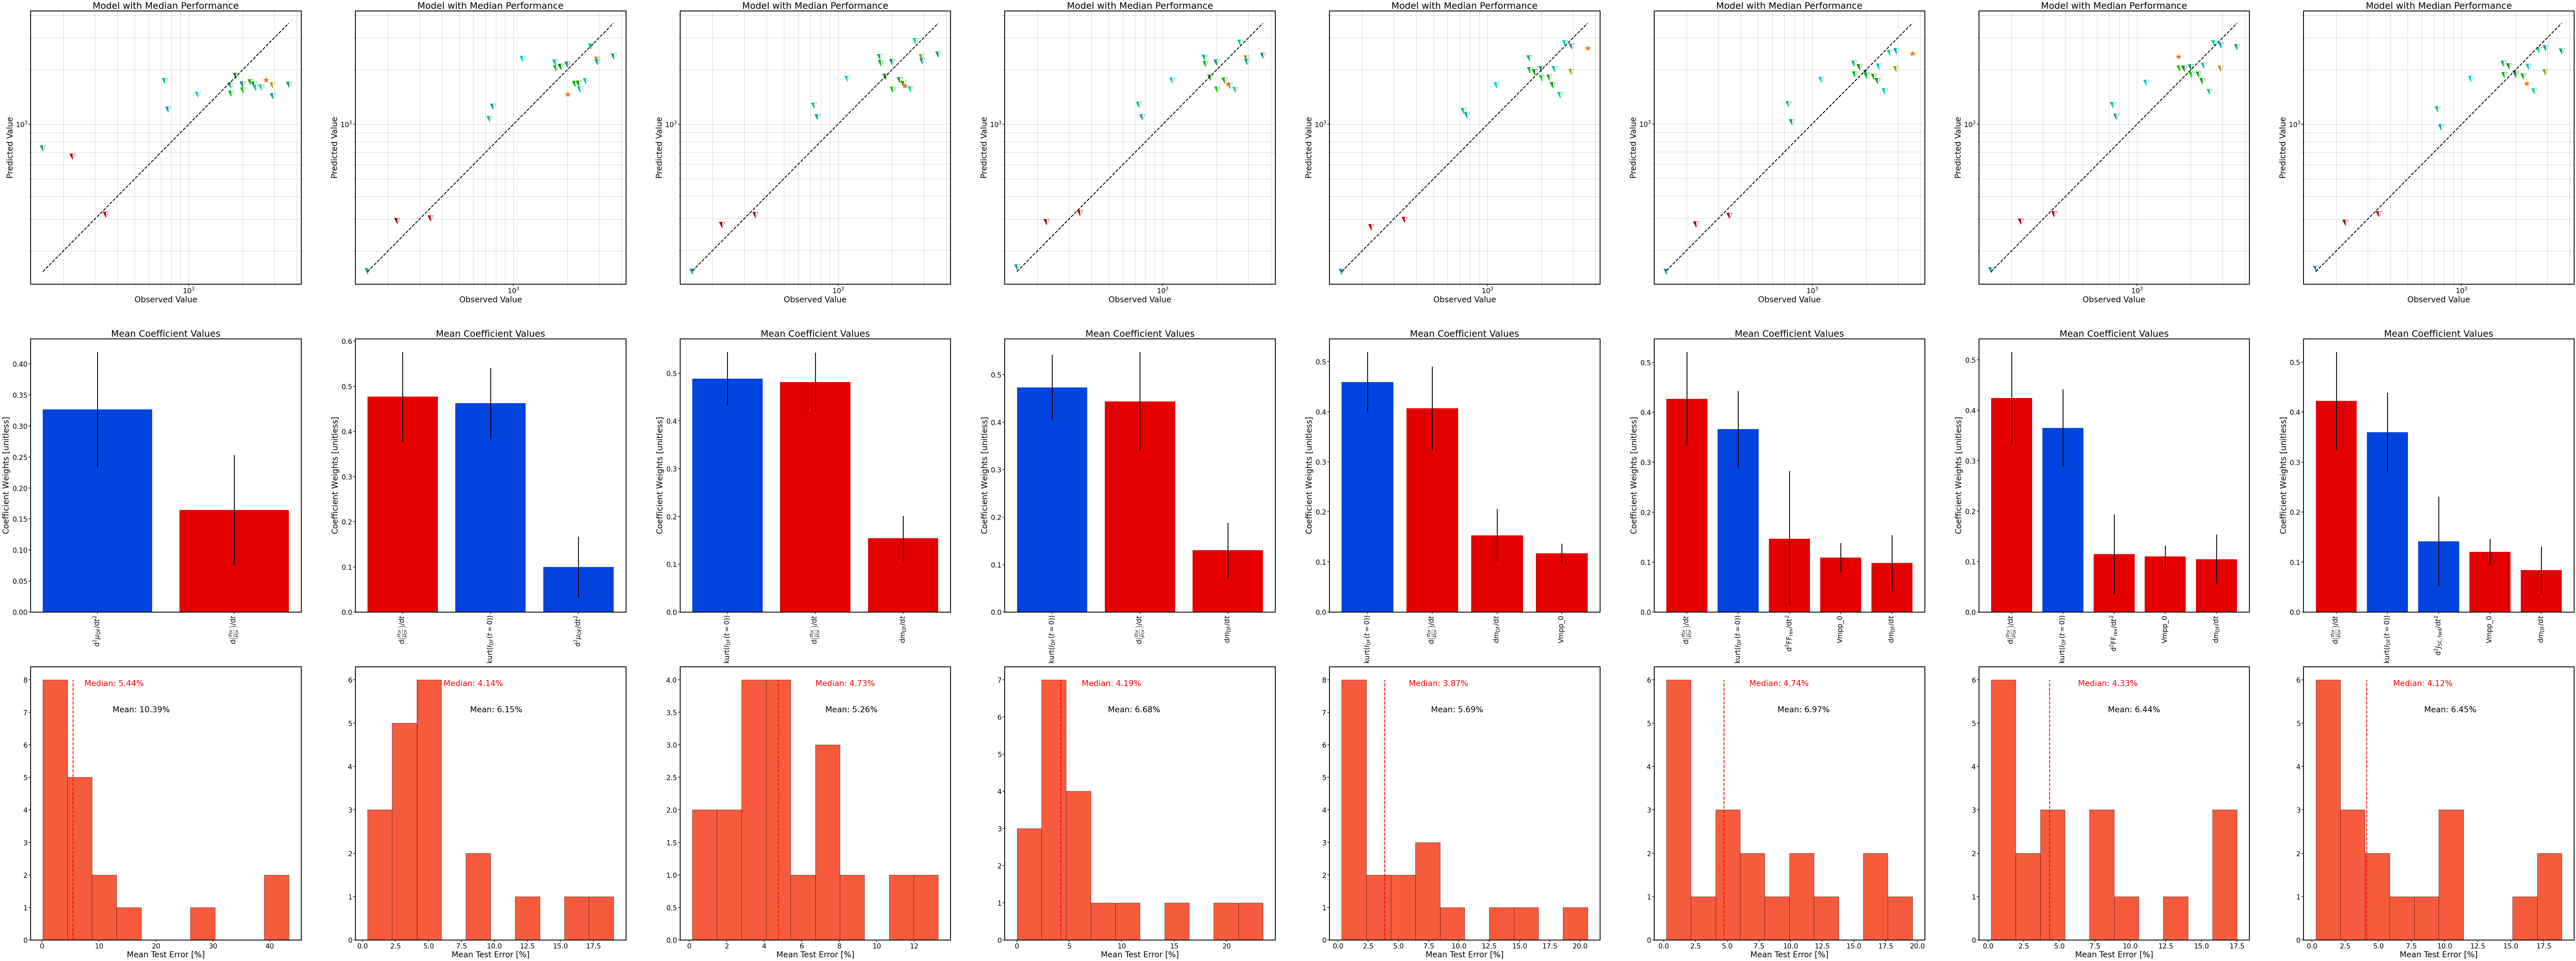

In [202]:
# change to True if using a log transform on the response
Log_transform = True

unshrink_coefficients = False

# choose the feature to use as the response
#response = 't_PCE75'
#response = 't_Jsc75'
#response = 't_Vocmax'
response = 't_FF90'

R_thresh = np.sqrt(0.5) # threshold for rejecting cross-correlated features 

feats_to_use_max = 10 # how many features to use for modeling, max
feats_to_use_min = 2 # how many features to use for modeling, min

mean_err_feats = np.zeros(feats_to_use_max-feats_to_use_min) # keep track of error

# identify whether the prediction target should be log-transformed or not
if Log_transform and response == 't_PCE75':
    target = 'ln_PCE75'
elif Log_transform and response == 't_Jsc75':
    target = 'ln_Jsc75'
else:
    target = response

grand_feats_FF = grand_feats.copy()
if 'Jsc_pred' in grand_feats_FF:
    grand_feats_FF.remove('FF90_pred')
    
# initialize a big figure where we track parity plots, error, etc across each echelon of model complexity
big_fig, big_ax = plt.subplots(3,feats_to_use_max-feats_to_use_min,
                               figsize=(20*(feats_to_use_max-feats_to_use_min),60))

for feats_to_use in range(feats_to_use_min,feats_to_use_max): # OUTERMOST LOOP: iterate over # of allowed features in the model
    
    print('Training Models with',feats_to_use,'Features')

    ############################## FIGURING OUT WHICH FEATURES TO USE ############################################
    
    # initialize lists of correlation coefficients AND their absolute values
    Pearson_Rs = []
    Pearson_Rs_abs = []

    # calculate Pearson correlation for each feature
    for feat in grand_feats_FF:
        # screen out points where data are missing
        nas = np.logical_or(np.isnan(rawdata_df[target].values), np.isnan(rawdata_df[feat].values))
        r,_ = scipy.stats.pearsonr(rawdata_df[target].values[~nas],rawdata_df[feat].values[~nas])
        Pearson_Rs.append(r)
        Pearson_Rs_abs.append(np.abs(r))

    # create a dataframe keeping track of features and correlation coefficients
    feat_corrs_df = pd.DataFrame(columns = ['Feature','Pearson R','Pearson |R|'])
    feat_corrs_df['Feature'] = grand_feats_FF
    feat_corrs_df['Pearson R'] = Pearson_Rs
    feat_corrs_df['Pearson |R|'] = Pearson_Rs_abs

    # take preliminary feature set
    feat_corrs_df_sorted = feat_corrs_df.sort_values(by='Pearson |R|',ascending=False)
    selected_feat_corrs_df = feat_corrs_df_sorted.iloc[:feats_to_use]

    alt_feat_idx = feats_to_use # keep track of where we stopped taking features from the larger dataframe

    # now we have to make sure that the selected features aren't too closely correlated with each other
    ii = 0
    while ii < feats_to_use: # scan over all features in the selected list

        # print('ii =',ii) # error checking

        jj = 0 # reset inner loop index

        while jj < ii: # scan over all other features (only need to do jj < ii b/c correlation matrix is symmetric)

            # print('jj =',jj) # error checking

            # calculate cross-correlation between iith and jjth features in the selected df
            nas = np.logical_or(np.isnan(rawdata_df[selected_feat_corrs_df['Feature'].iloc[ii]].values), 
                                np.isnan(rawdata_df[selected_feat_corrs_df['Feature'].iloc[jj]].values))        
            R_cross,_ = scipy.stats.pearsonr(rawdata_df[selected_feat_corrs_df['Feature'].iloc[ii]].values[~nas],
                                             rawdata_df[selected_feat_corrs_df['Feature'].iloc[jj]].values[~nas])

            # if they're too highly cross-correlated... 
            if R_cross > R_thresh:

                # print('Found cross-correlation') # error checking

                # throw out whichever one has a lower correlation with the target...
                # Note that because the features are already ranked by |R| we can throw out whichever is associated with
                # the larger index - i.e., ii (since jj is by definition < ii as defined in the second loop)
                selected_feat_corrs_df = selected_feat_corrs_df.drop(selected_feat_corrs_df.index[ii])

                # ...and replace the rejected feature with the next-most correlated feature from the grand feature list
                selected_feat_corrs_df = selected_feat_corrs_df.append(feat_corrs_df_sorted.iloc[alt_feat_idx])

                alt_feat_idx += 1 # increment the feature counter for the larger dataframe so we don't keep picking the same new features

                # reset ii and jj and break to outer loop
                ii = 0
                break
            # if the cross-correlation is acceptable, just increment the inner loop counter
            else:
                jj += 1
        # if everything is successful, move to the next feature in the list        
        ii += 1

    # display the final list of features and their correlations
    # selected_feat_corrs_df
    
    # now let's set up the model...
    
    # Features we keep:
    Ryan_features = list(selected_feat_corrs_df['Feature'].values)

    # full set: features + response
    terms_to_keep = Ryan_features + [response]

    # make a copy of the dataframe so that irrelevant responses can be removed
    coded_df = rawdata_df.copy()
    
    # drop responses that we're not interested in
    cols_to_drop = diff(list(coded_df.columns),terms_to_keep)
    coded_df = coded_df.drop(columns=cols_to_drop)

    # drop rows containing NaNs
    coded_df = coded_df.dropna(axis=0)
    
    # get rid of non-positive values if taking log of response
    if Log_transform:
        coded_df = coded_df[coded_df[response]>0]
    
    # print('Number of Runs Total:',len(coded_df))

    # display the modeling-ready dataset head    
    coded_df
    
    ############################## TRAINING THE MODELS ############################################
    
    if Log_transform:
        Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
    else:
        Y = coded_df[response].copy()
    X = coded_df.drop(columns=response).copy()

    # number of runs in dataset - for leave-one-out testing this is the size of the dataset
    n_trials = len(Y)

    # set up search parameters for cross-validation, which will be used to select the hyperparameter
    param_vals = np.logspace(-3,3,num=31) # range of hyperparameters to test
    parameters = {'alpha': param_vals}
    model = Lasso(max_iter=1e9) # model to implement - LASSO, Ridge, etc.
    #metric = 'neg_mean_squared_error' # scoring metric - MSE, R2, etc.
    metric = 'neg_mean_absolute_error'
    #metric = 'r2'
    folds = n_trials-1 # how many folds to do in k-fold cross-validation - 5 is standard
    #folds = 10

    # initialize error metrics for test set...
    R2 = np.zeros(n_trials) # coefficient of determination
    RMSE = np.zeros(n_trials) # RMS error
    MAE_pct = np.zeros(n_trials) # mean absolute error, percent
    MAE_pct_signed = np.zeros(n_trials) # mean absolute error, percent with sign
    MAE = np.zeros(n_trials) # mean absolute error

    # ...and for the whole dataset...
    MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
    MAE_overall = np.zeros(n_trials) # mean absolute error, percent
    R2_overall = np.zeros(n_trials) # coefficient of determination

    # ...and for the training set
    MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
    MAE_train = np.zeros(n_trials) # mean absolute error, percent
    R2_train = np.zeros(n_trials) # coefficient of determination

    # error on linear scale (only relevant if log transform is used on response, but we do this a lot)
    linear_error = np.zeros(n_trials)

    # initialize a dataframe to keep track of model coefficients on every iteration of the test set loop
    coeffs_df = pd.DataFrame(columns=coded_df.drop(columns=response).columns)
    # keep track of Shapley values too
    Shap_vals_df =  pd.DataFrame(columns=coded_df.drop(columns=response).columns)
    # keep track of *change in* error with feature deleted relative to model with the full feature set
    d_error_missing_feats = []

    # outer loop: hold one sample out for testing every iteration
    for kk in range(n_trials):

        if kk%10 == 0:
            print('Status: model training about ' + str(np.round(kk/n_trials * 100,2)) + '% complete...')

        # do test/train split by pulling out one row at a time form the feature and response DFs
        # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
        # ALSO: COPY THE SUBSETS Of THE DATAFRAMES or the values in the source will change and the 
        # prediction will be unstable and the whole thing will be ruined
        X_whold = X.iloc[kk].copy()
        y_whold = Y.iloc[kk:kk+1].copy()
        X_train = X.drop(X.index[kk]).copy()
        y_train = Y.drop(X.index[kk]).copy()

        # standardize the data according to the mean and variance of each feature in the training dataset
        for col in X_train.columns:
            # get mean and variance of features in the test set
            col_mean = np.mean(X_train[col])
            col_std = np.std(X_train[col])
            # standardize the features in the training set
            z_train = (X_train[col] - col_mean)/col_std
            X_train[col] = z_train
            # standardize the features in the test set
            z_whold = (X_whold[col] - col_mean)/col_std
            X_whold[col] = z_whold

        # cross-validation step to set alpha/lambda/penalty hyperparameter
        regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
        regressor.fit(X_train,y_train)

        # print winning HP value if desired...
        print(regressor.best_params_)
        #print(regressor.best_score_)
        alpha = regressor.best_params_['alpha']

        # ...and retrain the final model on the full training set
        final_model = Lasso(alpha=alpha)
        final_model.fit(X_train,y_train)
        #print(final_model.coef_)

        # if desired, recalculate the coefficients:
        if unshrink_coefficients:

            # figure out which coefficients survived
            surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]

            # make a copy of the training set with rejected coefficients stripped out
            X_red = X_train.copy()
            X_red = X_red[surviving_coeffs]
            X_whold_red = X_whold.copy()
            X_whold_red = X_whold_red[surviving_coeffs]
            # retrain the final model

            # train a simple linear regression
            shrunk_model = sklearn.linear_model.LinearRegression()
            shrunk_model.fit(X_red,y_train)

            # and fit the data
            ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
            ytpred=shrunk_model.predict(X_red)

        else:
            # make predictions on the test and training data
            ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
            ytpred=final_model.predict(X_train)

        # calculate error metrics on test set
        RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
        R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
        MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
        MAE_pct_signed[kk] = (y_whold-ypred)/y_whold*100
        MAE[kk] = np.mean(np.abs(y_whold-ypred))

        # put the whole dataset back together (note that this will create arrays, not DFs)
        y_net = np.concatenate([y_train,y_whold])
        y_pred_net = np.concatenate([ytpred,ypred])

        # calculate error metrics on entire set
        R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
        MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
        MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

        # calculate error metrics on training set
        R2_train[kk] = metrics.r2_score(y_train, ytpred)
        MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
        MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

        # calculate linear error metric
        linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100              

        # save the model coefficients to the respective row in the DF
        if unshrink_coefficients:
            # reconstruct the full model coefficients
            coeffs_vector = np.zeros(len(final_model.coef_))
            count = 0
            for ii in range(len(final_model.coef_)):
                if final_model.coef_[ii] != 0:
                    coeffs_vector[ii] = shrunk_model.coef_[count]
                    count += 1
            coeffs_df = coeffs_df.append(pd.DataFrame(coeffs_vector.reshape(1,len(final_model.coef_)),
                                                      columns=coded_df.drop(columns=response).columns))
        else:
            coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns))

        # calculate and save Shapley values
        shap_vals = final_model.coef_.reshape(1,len(final_model.coef_))*(np.array(X_whold)-np.mean(np.array(X_train),axis=0))
        Shap_vals_df = Shap_vals_df.append(pd.DataFrame(shap_vals,columns=coded_df.drop(columns=response).columns))  

    coeffs = coeffs_df.columns # save coefficient names
    avgs = np.mean(coeffs_df) # average the coefficients
    error = np.std(coeffs_df) # and get their standard deviations



    # Print important test statistics
    print(feats_to_use,'Feature Model Error Metrics:')
    print('-----------------------------------------------------------------')
    print('For test set:')
    print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct),1), '%')
    print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct),1), '%')
    print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct),1), '%')
    print('Mean of Mean Absolute Error =', np.round(np.mean(MAE),3))
    print('Median of Mean Absolute Error =', np.round(np.median(MAE),3))
    print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE),3))
    print('Mean R2 =', np.round(np.mean(R2),4))
    print('Median R2 =', np.round(np.median(R2),4))
    print('Std Dev. R2 =', np.round(np.std(R2),4))
    
    mean_err_feats[feats_to_use - feats_to_use_min] = np.mean(MAE_pct)

    print('For whole model:')
    print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct_overall),1), '%')
    print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct_overall),1), '%')
    print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct_overall),1), '%')
    print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_overall),3))
    print('Median of Mean Absolute Error =', np.round(np.median(MAE_overall),3))
    print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_overall),3))
    print('Mean R2 =', np.round(np.mean(R2_overall),4))
    print('Median R2 =', np.round(np.median(R2_overall),4))
    print('Std Dev. R2 =', np.round(np.std(R2_overall),4))

    print('Mean Linear Error =',np.round(np.mean(linear_error)),'%')
    print('Median Linear Error =',np.round(np.median(linear_error)),'%')
    print('-----------------------------------------------------------------')
    print('\n')

    ##### Below this line is the code for plotting the performance of the median model

    # identify the index corresponding to the median mean test error
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    med_idx = idx # save the median index in a less ambiguous form
    print('Index of Median Model:',idx)

    # partition the dataset - note the manipulations necessary to convert the index derived from 
    # the test error array to the index of the DataFrame - THESE VALUES ARE DIFFERENT!
    kk = idx
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold

    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)

    # print winning HP value if desired...
    print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']

    # and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)

    if unshrink_coefficients:

        # figure out which coefficients survived
        surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]

        # make a copy of the training set with rejected coefficients stripped out
        X_red = X_train.copy()
        X_red = X_red[surviving_coeffs]
        X_whold_red = X_whold.copy()
        X_whold_red = X_whold_red[surviving_coeffs]
        # retrain the final model

        # train a simple linear regression
        shrunk_model = sklearn.linear_model.LinearRegression()
        shrunk_model.fit(X_red,y_train)

        # and fit the data
        ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
        ytpred=shrunk_model.predict(X_red)

    else:
        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)
        
    ####### PLOT THE MEDIAN MODEL ##############

    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        if Log_transform:
            big_ax[0,feats_to_use-2].loglog(np.exp(y_train.loc[idx]),np.exp(ytpred[ii]),color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
        else:
            big_ax[0,feats_to_use-2].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
        #plt.text(y_train.loc[idx],ytpred[ii],idx) # ERROR checking: plot the index value

    # plot perfect prediction line and +/-50% error bounds
    if Log_transform:
        plotRange = np.linspace(np.min([np.min(np.exp(y_train)),np.min(np.exp(y_whold))]),
                                np.max([np.max(np.exp(y_train)),np.max(np.exp(y_whold))]),
                                num=101)
        big_ax[0,feats_to_use-2].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    else:
        plotRange = np.linspace(np.min([np.min(y_train),np.min(y_whold)]),np.max([np.max(y_train),np.max(y_whold)]),num=101)
        big_ax[0,feats_to_use-2].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    big_ax[0,feats_to_use-2].grid(which='both')

    if response == 't_Jsc75':
        big_ax[0,feats_to_use-2].set_xlabel('Observed $t_{J_\mathrm{sc},75}$ [min]')
        big_ax[0,feats_to_use-2].set_ylabel('Predicted $t_{J_\mathrm{sc},75}$ [min]')
    elif response == 't_PCE75':
        big_ax[0,feats_to_use-2].set_xlabel('Observed $t_\mathrm{PCE,75}$ [min]')
        big_ax[0,feats_to_use-2].set_ylabel('Predicted $t_\mathrm{PCE,75}$ [min]')
    else:
        big_ax[0,feats_to_use-2].set_xlabel('Observed Value')
        big_ax[0,feats_to_use-2].set_ylabel('Predicted Value')
    #big_ax[0,feats_to_use].set_xticks(fontsize=16)
    #big_ax[0,feats_to_use].set_yticks(fontsize=16)
    big_ax[0,feats_to_use-2].set_title('Model with Median Performance')

    # plot test data as above, with environment denoted by marker appearance and composition by marker size
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        if Log_transform:
            big_ax[0,feats_to_use-2].loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            # plot orange star to identify test samples
            big_ax[0,feats_to_use-2].loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),marker='*',markersize=20,color='xkcd:orange')                
        else:
            big_ax[0,feats_to_use-2].plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            # plot orange star to identify test samples
            big_ax[0,feats_to_use-2].plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange') 
    

    ###################### NOW MAKE PLOTS OF OTHER IMPORTANT THINGS ##########################################
    
    # make a copy of the coeffs_df but with Boolean values to indicate whether the corresponding feature was selected
    selected_df = coeffs_df.copy()

    for ii in range(len(selected_df)):
        logic = selected_df.iloc[ii] != 0 # convert nonzero values to True, zero values to False
        selected_df.iloc[ii] = logic

    # make a DF of key statistics on the coefficient values
    stats_df = coeffs_df.copy()

    # initialize lists of key stats
    medians = []
    means = []
    stds = []

    # populate the lists...
    for col in coeffs_df.columns:
        medians.append(np.median(coeffs_df[col]))
        means.append(np.mean(coeffs_df[col]))
        stds.append(np.std(coeffs_df[col]))
    # ...and add them to the DataFrame 
    stats_df.loc['medians'] = medians
    stats_df.loc['means'] = means
    stats_df.loc['stds'] = stds

    # plot the median values of the coefficients
    #plt.figure(figsize=(10,10))
    #plt.bar(stats_df.columns,stats_df.loc['medians'])
    #plt.xticks(rotation=90)

    # assign bar colors to mean coefficient values
    bar_colors_mean = []
    if response == 'Bleach Rate (fit to 5% inc) (1/min)':
        for jj in range(len(coeffs)):
            if np.sign(means[jj]) == 1:
                bar_colors_mean.append('xkcd:red')
            else:
                bar_colors_mean.append('xkcd:blue')
    else:
        for jj in range(len(coeffs)):
            if np.sign(avgs[jj]) == 1:
                bar_colors_mean.append('xkcd:blue')
            else:
                bar_colors_mean.append('xkcd:red')

    # assign bar colors to median coefficient values
    bar_colors_median = []
    if response == 'Bleach Rate (fit to 5% inc) (1/min)':
        for jj in range(len(coeffs)):
            if np.sign(medians[jj]) == 1:
                bar_colors_median.append('xkcd:red')
            else:
                bar_colors_median.append('xkcd:blue')
    else:
        for jj in range(len(coeffs)):
            if np.sign(medians[jj]) == 1:
                bar_colors_median.append('xkcd:blue')
            else:
                bar_colors_median.append('xkcd:red')

    # make a dataFrame that will be used for bar plots specifically
    bars_df = pd.DataFrame(means) # base it off the mean coefficient values
    bars_df = bars_df.rename(columns={0:'means'})
    bars_df['coeffs'] = coeffs # get coefficient names
    bars_df.index = coeffs # make the DF indices equal to the coefficient names
    bars_df['means'] = np.abs(bars_df['means']) # convert means to their absolute values for prettier/easier-to-read plots
    bars_df['medians'] = np.abs(medians) # add median coefficient values
    bars_df['error'] = stds # add standard deviations
    bars_df['colors_mean'] = bar_colors_mean # encode coefficient sign in bar color
    bars_df['colors_median'] = bar_colors_mean # encode coefficient sign in bar color
    bars_df = bars_df.sort_values(by = 'means', ascending=False) # sort the bars in descending order of mean

    # reduced dataframe of only coefficients with nonvanishing magnitude
    nz_bars_df = bars_df[bars_df['means'] > 0]

    # further reduced dataframe of only coefficients whose average is larger than their std. dev.
    sig_bars_df = nz_bars_df[nz_bars_df['means'] > nz_bars_df['error']]

    
    # define list of nice-looking labels
    fancy_labels=[]
    for coeff in sig_bars_df['coeffs']:
        try:
            fancy_labels.append(fancy_labels_dict[coeff])
        except:
            fancy_labels.append(coeff)

    # plot the means with error bars represented by the standard deviation
    big_ax[1,feats_to_use-2].bar(sig_bars_df['coeffs'],sig_bars_df['means'],yerr=sig_bars_df['error'],color=sig_bars_df['colors_mean'])
    big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
    big_ax[1,feats_to_use-2].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
    big_ax[1,feats_to_use-2].set_title('Mean Coefficient Values')

    ##### BOTTOM LEFT: test set error distribution
    big_ax[2,feats_to_use-2].hist(MAE_pct,color='xkcd:vermillion',alpha=0.8,edgecolor='black',histtype='bar')
    big_ax[2,feats_to_use-2].set_xlabel('Mean Test Error [%]')
    big_ax[2,feats_to_use-2].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
    big_ax[2,feats_to_use-2].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
                  'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top')
    big_ax[2,feats_to_use-2].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
                  'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top')

    


In [203]:
###################################### Retrain the best model ###################################

# change to True if using a log transform on the response
Log_transform = True

unshrink_coefficients = False

# choose the feature to use as the response
#response = 't_PCE75'
#response = 't_Jsc75'
#response = 't_Vocmax'
response = 't_FF90'

R_thresh = np.sqrt(0.5) # threshold for rejecting cross-correlated features 

# identify whether the prediction target should be log-transformed or not
if Log_transform and response == 't_PCE75':
    target = 'ln_PCE75'
elif Log_transform and response == 't_Jsc75':
    target = 'ln_Jsc75'
else:
    target = response

best_no_feats = feats_to_use_min + np.argmin(mean_err_feats) # find the number of features leading to the best model

print('Training Models with',best_no_feats,'Features')

############################## FIGURING OUT WHICH FEATURES TO USE ############################################

# initialize lists of correlation coefficients AND their absolute values
Pearson_Rs = []
Pearson_Rs_abs = []

# calculate Pearson correlation for each feature
for feat in grand_feats_FF:
    # screen out points where data are missing
    nas = np.logical_or(np.isnan(rawdata_df[target].values), np.isnan(rawdata_df[feat].values))
    r,_ = scipy.stats.pearsonr(rawdata_df[target].values[~nas],rawdata_df[feat].values[~nas])
    Pearson_Rs.append(r)
    Pearson_Rs_abs.append(np.abs(r))

# create a dataframe keeping track of features and correlation coefficients
feat_corrs_df = pd.DataFrame(columns = ['Feature','Pearson R','Pearson |R|'])
feat_corrs_df['Feature'] = grand_feats_FF
feat_corrs_df['Pearson R'] = Pearson_Rs
feat_corrs_df['Pearson |R|'] = Pearson_Rs_abs

# take preliminary feature set
feat_corrs_df_sorted = feat_corrs_df.sort_values(by='Pearson |R|',ascending=False)
selected_feat_corrs_df = feat_corrs_df_sorted.iloc[:best_no_feats]

alt_feat_idx = best_no_feats # keep track of where we stopped taking features from the larger dataframe

# now we have to make sure that the selected features aren't too closely correlated with each other
ii = 0
while ii < best_no_feats: # scan over all features in the selected list

    # print('ii =',ii) # error checking

    jj = 0 # reset inner loop index

    while jj < ii: # scan over all other features (only need to do jj < ii b/c correlation matrix is symmetric)

        # print('jj =',jj) # error checking

        # calculate cross-correlation between iith and jjth features in the selected df
        nas = np.logical_or(np.isnan(rawdata_df[selected_feat_corrs_df['Feature'].iloc[ii]].values), 
                            np.isnan(rawdata_df[selected_feat_corrs_df['Feature'].iloc[jj]].values))        
        R_cross,_ = scipy.stats.pearsonr(rawdata_df[selected_feat_corrs_df['Feature'].iloc[ii]].values[~nas],
                                         rawdata_df[selected_feat_corrs_df['Feature'].iloc[jj]].values[~nas])

        # if they're too highly cross-correlated... 
        if R_cross > R_thresh:

            # print('Found cross-correlation') # error checking

            # throw out whichever one has a lower correlation with the target...
            # Note that because the features are already ranked by |R| we can throw out whichever is associated with
            # the larger index - i.e., ii (since jj is by definition < ii as defined in the second loop)
            selected_feat_corrs_df = selected_feat_corrs_df.drop(selected_feat_corrs_df.index[ii])

            # ...and replace the rejected feature with the next-most correlated feature from the grand feature list
            selected_feat_corrs_df = selected_feat_corrs_df.append(feat_corrs_df_sorted.iloc[alt_feat_idx])

            alt_feat_idx += 1 # increment the feature counter for the larger dataframe so we don't keep picking the same new features

            # reset ii and jj and break to outer loop
            ii = 0
            break
        # if the cross-correlation is acceptable, just increment the inner loop counter
        else:
            jj += 1
    # if everything is successful, move to the next feature in the list        
    ii += 1

# display the final list of features and their correlations
# selected_feat_corrs_df

# now let's set up the model...

# Features we keep:
Ryan_features = list(selected_feat_corrs_df['Feature'].values)

# full set: features + response
terms_to_keep = Ryan_features + [response]

# make a copy of the dataframe so that irrelevant responses can be removed
coded_df = rawdata_df.copy()

# drop responses that we're not interested in
cols_to_drop = diff(list(coded_df.columns),terms_to_keep)
coded_df = coded_df.drop(columns=cols_to_drop)

# drop rows containing NaNs
coded_df = coded_df.dropna(axis=0)

# get rid of non-positive values if taking log of response
if Log_transform:
    coded_df = coded_df[coded_df[response]>0]

# print('Number of Runs Total:',len(coded_df))

# display the modeling-ready dataset head    
coded_df

############################## TRAINING THE MODELS ############################################

if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset - for leave-one-out testing this is the size of the dataset
n_trials = len(Y)

# set up search parameters for cross-validation, which will be used to select the hyperparameter
param_vals = np.logspace(-3,3,num=31) # range of hyperparameters to test
parameters = {'alpha': param_vals}
model = Lasso(max_iter=1e9) # model to implement - LASSO, Ridge, etc.
#metric = 'neg_mean_squared_error' # scoring metric - MSE, R2, etc.
metric = 'neg_mean_absolute_error'
#metric = 'r2'
folds = n_trials-1 # how many folds to do in k-fold cross-validation - 5 is standard
#folds = 10

# initialize error metrics for test set...
R2 = np.zeros(n_trials) # coefficient of determination
RMSE = np.zeros(n_trials) # RMS error
MAE_pct = np.zeros(n_trials) # mean absolute error, percent
MAE_pct_signed = np.zeros(n_trials) # mean absolute error, percent with sign
MAE = np.zeros(n_trials) # mean absolute error

# ...and for the whole dataset...
MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
MAE_overall = np.zeros(n_trials) # mean absolute error, percent
R2_overall = np.zeros(n_trials) # coefficient of determination

# ...and for the training set
MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
MAE_train = np.zeros(n_trials) # mean absolute error, percent
R2_train = np.zeros(n_trials) # coefficient of determination

# error on linear scale (only relevant if log transform is used on response, but we do this a lot)
linear_error = np.zeros(n_trials)

# initialize a dataframe to keep track of model coefficients on every iteration of the test set loop
coeffs_df = pd.DataFrame(columns=coded_df.drop(columns=response).columns)
intercepts = [] # intercepts as well
# keep track of feature standardization values too
means_array = np.zeros([n_trials,len(coded_df.drop(columns=response).columns)])
stds_array = np.zeros([n_trials,len(coded_df.drop(columns=response).columns)])

# keep track of Shapley values too
Shap_vals_df =  pd.DataFrame(columns=coded_df.drop(columns=response).columns)
# keep track of *change in* error with feature deleted relative to model with the full feature set
d_error_missing_feats = []



# outer loop: hold one sample out for testing every iteration
for kk in range(n_trials):

    if kk%10 == 0:
        print('Status: model training about ' + str(np.round(kk/n_trials * 100,2)) + '% complete...')

    # do test/train split by pulling out one row at a time form the feature and response DFs
    # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
    # ALSO: COPY THE SUBSETS Of THE DATAFRAMES or the values in the source will change and the 
    # prediction will be unstable and the whole thing will be ruined
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of each feature in the training dataset
    for nn,col in enumerate(X_train.columns):
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold
        means_array[kk,nn] = col_mean
        stds_array[kk,nn] = col_std

    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)

    # print winning HP value if desired...
    print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']

    # ...and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)

    # if desired, recalculate the coefficients:
    if unshrink_coefficients:

        # figure out which coefficients survived
        surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]

        # make a copy of the training set with rejected coefficients stripped out
        X_red = X_train.copy()
        X_red = X_red[surviving_coeffs]
        X_whold_red = X_whold.copy()
        X_whold_red = X_whold_red[surviving_coeffs]
        # retrain the final model

        # train a simple linear regression
        shrunk_model = sklearn.linear_model.LinearRegression()
        shrunk_model.fit(X_red,y_train)

        # and fit the data
        ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
        ytpred=shrunk_model.predict(X_red)
        
        intercepts.append(shrunk_model.intercept_)

    else:
        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)
        intercepts.append(final_model.intercept_)

    # calculate error metrics on test set
    RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
    R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
    MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
    MAE_pct_signed[kk] = (y_whold-ypred)/y_whold*100
    MAE[kk] = np.mean(np.abs(y_whold-ypred))

    # put the whole dataset back together (note that this will create arrays, not DFs)
    y_net = np.concatenate([y_train,y_whold])
    y_pred_net = np.concatenate([ytpred,ypred])

    # calculate error metrics on entire set
    R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
    MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
    MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

    # calculate error metrics on training set
    R2_train[kk] = metrics.r2_score(y_train, ytpred)
    MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
    MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

    # calculate linear error metric
    linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100              

    # save the model coefficients to the respective row in the DF
    if unshrink_coefficients:
        # reconstruct the full model coefficients
        coeffs_vector = np.zeros(len(final_model.coef_))
        count = 0
        for ii in range(len(final_model.coef_)):
            if final_model.coef_[ii] != 0:
                coeffs_vector[ii] = shrunk_model.coef_[count]
                count += 1
        coeffs_df = coeffs_df.append(pd.DataFrame(coeffs_vector.reshape(1,len(final_model.coef_)),
                                                  columns=coded_df.drop(columns=response).columns))
    else:
        coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns))
    
    # calculate and save Shapley values
    shap_vals = final_model.coef_.reshape(1,len(final_model.coef_))*(np.array(X_whold)-np.mean(np.array(X_train),axis=0))
    Shap_vals_df = Shap_vals_df.append(pd.DataFrame(shap_vals,columns=coded_df.drop(columns=response).columns))  

# identify the median test-train split   
med_idx = np.argmin(np.abs(MAE_pct - np.median(MAE_pct)))    


coeffs = coeffs_df.columns # save coefficient names
means_df = pd.DataFrame(means_array,columns=coeffs)
stds_df = pd.DataFrame(stds_array,columns=coeffs)

avgs = np.mean(coeffs_df) # average the coefficients
error = np.std(coeffs_df) # and get their standard deviations

# add intercepts and rename coefficients
full_coeffs_df = coeffs_df.copy()
full_coeffs_df['intercepts'] = intercepts

print('##################### Model Parameters #######################\n')
print('Coefficients of the Median Model:')
display(full_coeffs_df.iloc[med_idx])
print('Standardization Means of the Median Model:')
display(means_df.iloc[med_idx])
print('Standardization Std. Devs of the Median Model:')
display(stds_df.iloc[med_idx])
print('##############################################################\n')


Training Models with 4 Features
Status: model training about 0.0% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
Status: model training about 52.63% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
##################### Model Parameters #######################

Coefficients of the Median Model:


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


dDFmediandt   -0.136352
d2DFmeandt2    0.000000
DFkurtdt_0     0.501351
dDFCVdt       -0.487229
intercepts     7.195842
Name: 0, dtype: float64

Standardization Means of the Median Model:


dDFmediandt     5.220370
d2DFmeandt2    -2.192612
DFkurtdt_0     49.581544
dDFCVdt         0.000275
Name: 16, dtype: float64

Standardization Std. Devs of the Median Model:


dDFmediandt    17.387132
d2DFmeandt2     6.524663
DFkurtdt_0     13.746784
dDFCVdt         0.000945
Name: 16, dtype: float64

##############################################################



In [204]:
# Now add the predicted FF90 to the list of features

# FF90_pred = -1.027172*((rawdata_df['d2DFskewdt2']-0.000171)/0.000527) +\
#              0.544037*((rawdata_df['DFCV_0']-0.529594)/0.144349) +\
#              7.137366

# rawdata_df['FF90_pred'] = FF90_pred

# if 'FF90_pred' not in grand_feats:
#     grand_feats.append('FF90_pred')

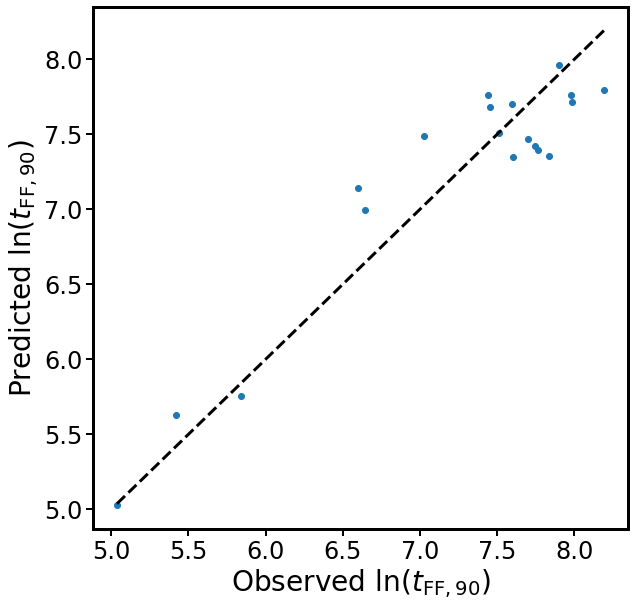

In [205]:
chosen_features = means_df.columns # what are the chosen features

FF90_pred = rawdata_df[chosen_features[0]]*0 # initialize a series of same length as original dataframe

for feat in chosen_features: # now populate it with predictions made by the median model
    FF90_pred += full_coeffs_df[feat].iloc[med_idx]*(rawdata_df[feat] - means_df[feat].iloc[med_idx])/stds_df[feat].iloc[med_idx] 
    
FF90_pred += full_coeffs_df['intercepts'].iloc[med_idx]
plt.plot(np.log(rawdata_df['t_FF90']),FF90_pred,'.')
p_range = np.linspace(np.nanmin(np.log(rawdata_df['t_FF90'])),np.nanmax(np.log(rawdata_df['t_FF90'])),num=2)
plt.plot(p_range,p_range,'k--')
plt.xlabel('Observed ln($t_\mathrm{FF,90}$)')
plt.ylabel('Predicted ln($t_\mathrm{FF,90}$)')

rawdata_df['FF90_pred'] = FF90_pred

if 'FF90_pred' not in grand_feats:
    grand_feats.append('FF90_pred')

# Now train a model for JSC-75

Training Models with 2 Features
Status: model training about 0.0% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}
Status: model training about 45.45% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.3981071705534973}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}
Status: model training about 90.91% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}
2 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 9.5 %
Median of Mean Absolute Error = 6.4 %
Std. Dev. of Mean Absolute Error = 8.9 %
Mean of Mean Absolute Error = 0.671
Median of Mean Absolute Error = 0.522
Std. Dev. of Mean Absolute Error = 0.516
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 7.2 %
Median of Mean Absolute Error = 7.1 %
Std. Dev. of Mean Absolute Error = 0.3 %
Mean of Mean Absolute Error = 0.52
Median of Mean Absolute Error = 0.519
Std. Dev. of Mean Absolute Error = 0.019
Mean R2 = 0.2798
Median R2 = 0.293
Std Dev. R2 = 0.0675
Mean Linear Error = 101.0 %
Median Linear Error = 41.0 %
-----------------------------------------------------------------


Index of Median Model: 9


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}
Training Models with 3 Features
Status: model training about 0.0% complete...


<ipython-input-9-5b6d5e482325>:558: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}
Status: model training about 45.45% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.25118864315095824}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.3981071705534973}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
Status: model training about 90.91% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
3 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 10.4 %
Median of Mean Absolute Error = 6.6 %
Std. Dev. of Mean Absolute Error = 9.3 %
Mean of Mean Absolute Error = 0.736
Median of Mean Absolute Error = 0.54
Std. Dev. of Mean Absolute Error = 0.551
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 6.5 %
Median of Mean Absolute Error = 6.2 %
Std. Dev. of Mean Absolute Error = 0.8 %
Mean of Mean Absolute Error = 0.474
Median of Mean Absolute Error = 0.459
Std. Dev. of Mean Absolute Error = 0.051
Mean R2 = 0.377
Median R2 = 0.4115
Std Dev. R2 = 0.1232
Mean Linear Error = 117.0 %
Median Linear Error = 42.0 %
-----------------------------------------------------------------


Index of Median Model: 12


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
Training Models with 4 Features
Status: model training about 0.0% complete...


<ipython-input-9-5b6d5e482325>:558: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}
Status: model training about 45.45% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}
Status: model training about 90.91% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}
4 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 7.2 %
Median of Mean Absolute Error = 5.0 %
Std. Dev. of Mean Absolute Error = 6.9 %
Mean of Mean Absolute Error = 0.506
Median of Mean Absolute Error = 0.419
Std. Dev. of Mean Absolute Error = 0.434
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 5.0 %
Median of Mean Absolute Error = 5.0 %
Std. Dev. of Mean Absolute Error = 0.1 %
Mean of Mean Absolute Error = 0.363
Median of Mean Absolute Error = 0.363
Std. Dev. of Mean Absolute Error = 0.002
Mean R2 = 0.655
Median R2 = 0.6656
Std Dev. R2 = 0.0296
Mean Linear Error = 60.0 %
Median Linear Error = 34.0 %
-----------------------------------------------------------------


Index of Median Model: 17


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}
Training Models with 5 Features
Status: model training about 0.0% complete...


<ipython-input-9-5b6d5e482325>:558: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
Status: model training about 45.45% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
Status: model training about 90.91% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
5 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 7.3 %
Median of Mean Absolute Error = 6.4 %
Std. Dev. of Mean Absolute Error = 6.8 %
Mean of Mean Absolute Error = 0.521
Median of Mean Absolute Error = 0.499
Std. Dev. of Mean Absolute Error = 0.428
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 5.1 %
Median of Mean Absolute Error = 5.1 %
Std. Dev. of Mean Absolute Error = 0.1 %
Mean of Mean Absolute Error = 0.367
Median of Mean Absolute Error = 0.367
Std. Dev. of Mean Absolute Error = 0.007
Mean R2 = 0.6407
Median R2 = 0.6472
Std Dev. R2 = 0.0285
Mean Linear Error = 59.0 %
Median Linear Error = 41.0 %
-----------------------------------------------------------------


Index of Median Model: 20


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
Training Models with 6 Features
Status: model training about 0.0% complete...


<ipython-input-9-5b6d5e482325>:558: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
Status: model training about 45.45% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
Status: model training about 90.91% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
6 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 7.5 %
Median of Mean Absolute Error = 6.4 %
Std. Dev. of Mean Absolute Error = 6.9 %
Mean of Mean Absolute Error = 0.531
Median of Mean Absolute Error = 0.499
Std. Dev. of Mean Absolute Error = 0.44
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 4.9 %
Median of Mean Absolute Error = 5.1 %
Std. Dev. of Mean Absolute Error = 0.4 %
Mean of Mean Absolute Error = 0.357
Median of Mean Absolute Error = 0.367
Std. Dev. of Mean Absolute Error = 0.026
Mean R2 = 0.6521
Median R2 = 0.6489
Std Dev. R2 = 0.0436
Mean Linear Error = 61.0 %
Median Linear Error = 41.0 %
-----------------------------------------------------------------


Index of Median Model: 17


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
Training Models with 7 Features
Status: model training about 0.0% complete...


<ipython-input-9-5b6d5e482325>:558: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
Status: model training about 45.45% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
Status: model training about 90.91% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
7 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 7.9 %
Median of Mean Absolute Error = 6.5 %
Std. Dev. of Mean Absolute Error = 7.7 %
Mean of Mean Absolute Error = 0.564
Median of Mean Absolute Error = 0.55
Std. Dev. of Mean Absolute Error = 0.488
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 4.9 %
Median of Mean Absolute Error = 5.1 %
Std. Dev. of Mean Absolute Error = 0.5 %
Mean of Mean Absolute Error = 0.354
Median of Mean Absolute Error = 0.367
Std. Dev. of Mean Absolute Error = 0.03
Mean R2 = 0.6528
Median R2 = 0.6489
Std Dev. R2 = 0.0594
Mean Linear Error = 65.0 %
Median Linear Error = 43.0 %
-----------------------------------------------------------------


Index of Median Model: 5


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
Training Models with 8 Features
Status: model training about 0.0% complete...


<ipython-input-9-5b6d5e482325>:558: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}
Status: model training about 45.45% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.15848931924611143}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.15848931924611143}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
Status: model training about 90.91% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
8 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 10.3 %
Median of Mean Absolute Error = 6.8 %
Std. Dev. of Mean Absolute Error = 11.9 %
Mean of Mean Absolute Error = 0.724
Median of Mean Absolute Error = 0.574
Std. Dev. of Mean Absolute Error = 0.768
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 5.1 %
Median of Mean Absolute Error = 5.1 %
Std. Dev. of Mean Absolute Error = 0.7 %
Mean of Mean Absolute Error = 0.371
Median of Mean Absolute Error = 0.367
Std. Dev. of Mean Absolute Error = 0.048
Mean R2 = 0.5922
Median R2 = 0.6459
Std Dev. R2 = 0.1835
Mean Linear Error = 169.0 %
Median Linear Error = 46.0 %
-----------------------------------------------------------------


Index of Median Model: 1


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
Training Models with 9 Features
Status: model training about 0.0% complete...


<ipython-input-9-5b6d5e482325>:558: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}
Status: model training about 45.45% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.15848931924611143}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.15848931924611143}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}
Status: model training about 90.91% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
9 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 7.8 %
Median of Mean Absolute Error = 5.2 %
Std. Dev. of Mean Absolute Error = 9.9 %
Mean of Mean Absolute Error = 0.548
Median of Mean Absolute Error = 0.399
Std. Dev. of Mean Absolute Error = 0.618
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 4.3 %
Median of Mean Absolute Error = 4.2 %
Std. Dev. of Mean Absolute Error = 0.7 %
Mean of Mean Absolute Error = 0.319
Median of Mean Absolute Error = 0.309
Std. Dev. of Mean Absolute Error = 0.046
Mean R2 = 0.7121
Median R2 = 0.7586
Std Dev. R2 = 0.1657
Mean Linear Error = 126.0 %
Median Linear Error = 39.0 %
-----------------------------------------------------------------


Index of Median Model: 9


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


<ipython-input-9-5b6d5e482325>:558: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)


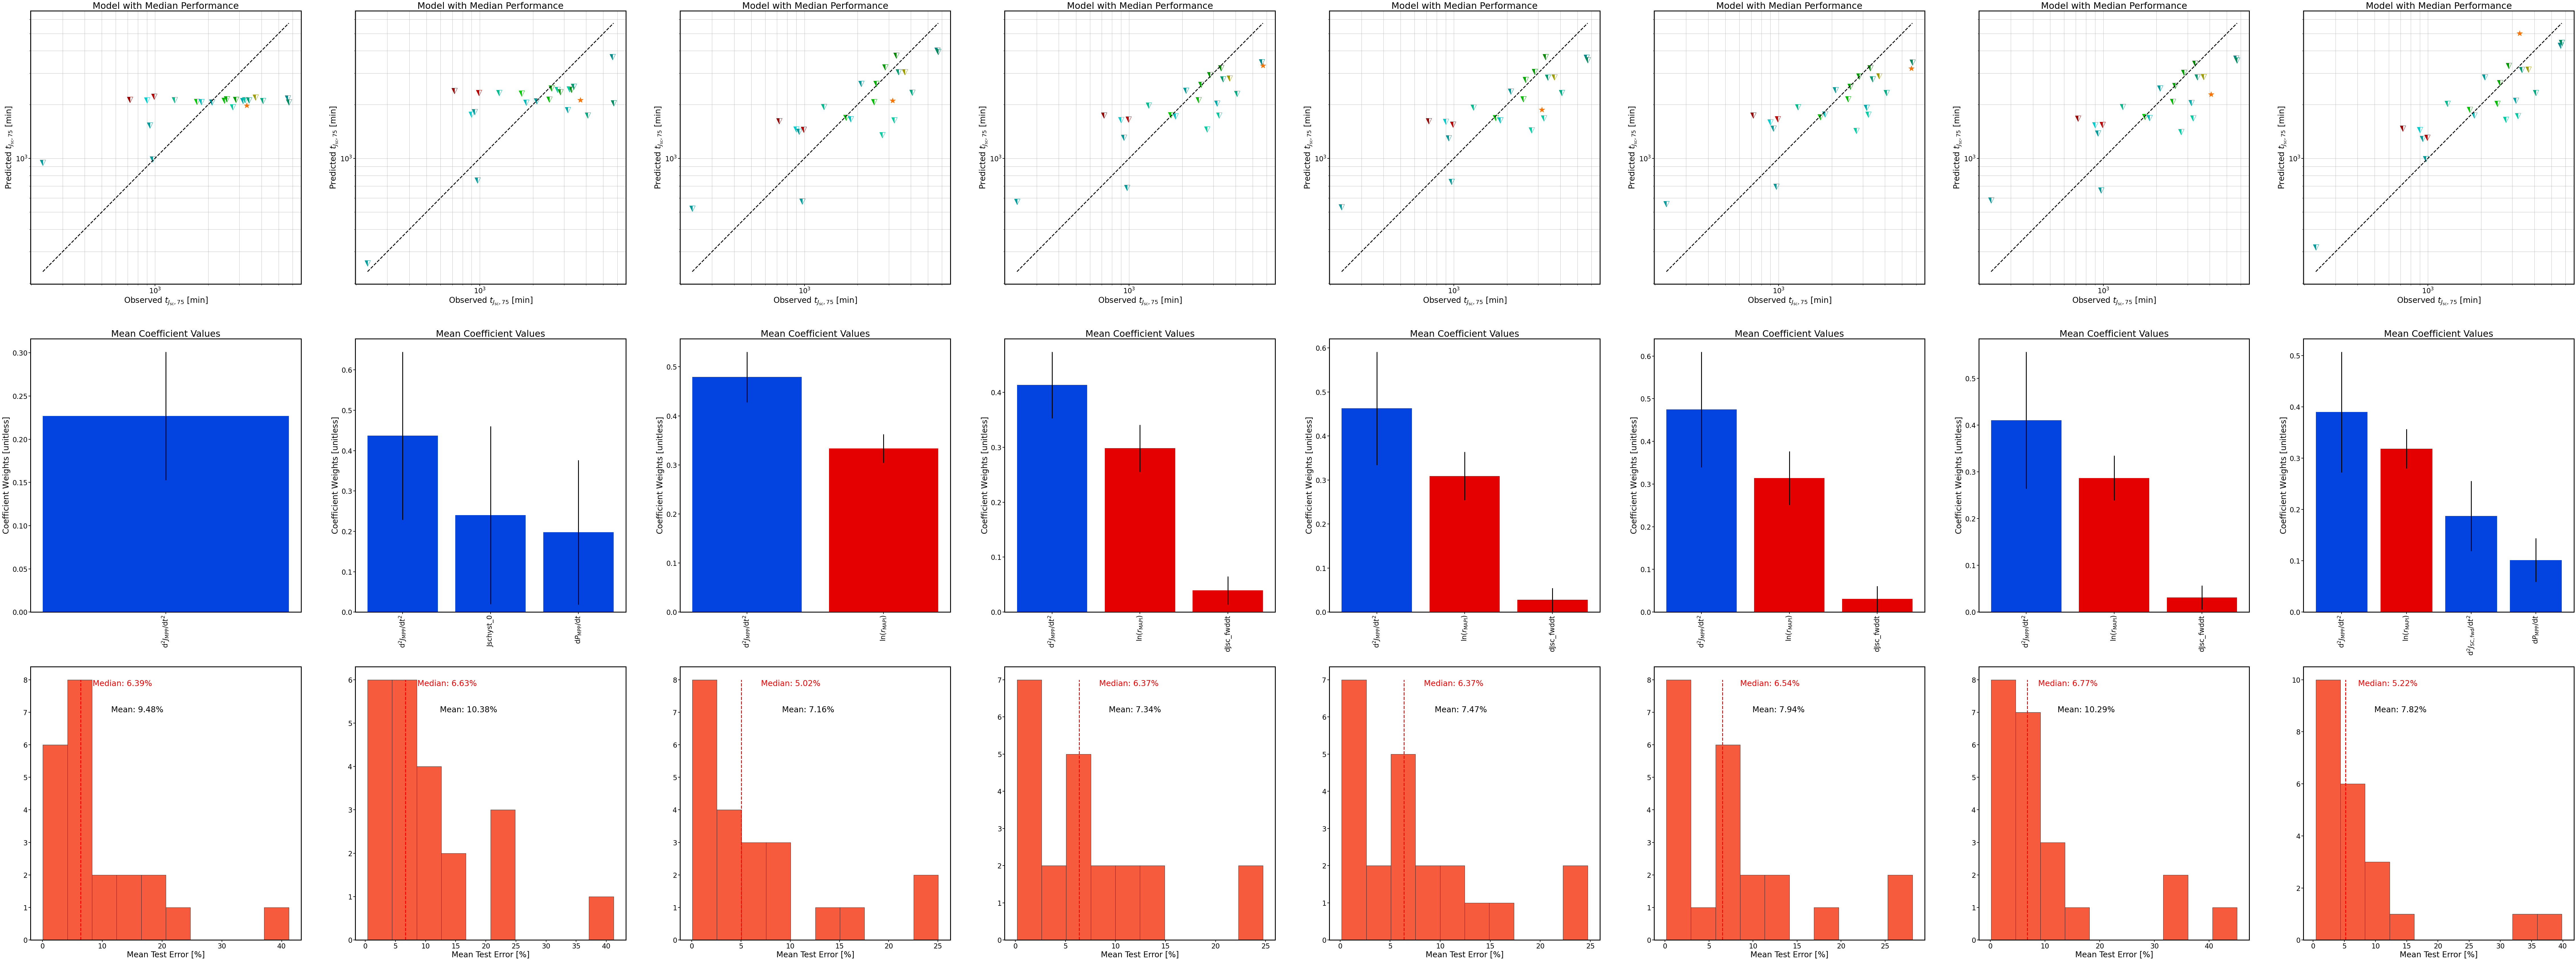

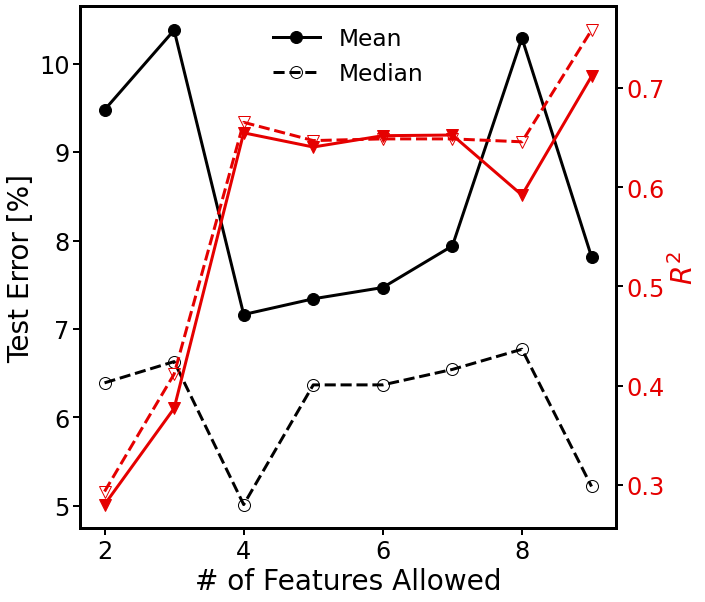

In [9]:
# change to True if using a log transform on the response
Log_transform = True

unshrink_coefficients = False

# choose the feature to use as the response
#response = 't_PCE75'
response = 't_Jsc75'
#response = 't_Jsc90'
#response = 't_Vocmax'
#response = 't_FF90'

R_thresh = np.sqrt(0.5) # threshold for rejecting cross-correlated features 

feats_to_use_max = 10 # how many features to use for modeling, max
feats_to_use_min = 2 # how many features to use for modeling, min

mean_err_feats = np.zeros(feats_to_use_max-feats_to_use_min) # keep track of error
median_err_feats = np.zeros(feats_to_use_max-feats_to_use_min)
mean_R2_feats = np.zeros(feats_to_use_max-feats_to_use_min)
median_R2_feats = np.zeros(feats_to_use_max-feats_to_use_min)

# identify whether the prediction target should be log-transformed or not
if Log_transform and response == 't_PCE75':
    target = 'ln_PCE75'
elif Log_transform and response == 't_Jsc75':
    target = 'ln_Jsc75'
else:
    target = response
    
# initialize a big figure where we track parity plots, error, etc across each echelon of model complexity
big_fig, big_ax = plt.subplots(3,feats_to_use_max-feats_to_use_min,
                               figsize=(20*(feats_to_use_max-feats_to_use_min),60))

grand_feats_Jsc = grand_feats.copy()
if 'FF90_pred' in grand_feats_Jsc:
    grand_feats_Jsc.remove('FF90_pred')
if 'Jsc75_pred' in grand_feats_Jsc:
    grand_feats_Jsc.remove('Jsc75_pred')

for feats_to_use in range(feats_to_use_min,feats_to_use_max): # OUTERMOST LOOP: iterate over # of allowed features in the model
    
    print('Training Models with',feats_to_use,'Features')

    ############################## FIGURING OUT WHICH FEATURES TO USE ############################################
    
    # initialize lists of correlation coefficients AND their absolute values
    Pearson_Rs = []
    Pearson_Rs_abs = []

    # calculate Pearson correlation for each feature
    for feat in grand_feats_Jsc:
        # screen out points where data are missing
        nas = np.logical_or(np.isnan(rawdata_df[target].values), np.isnan(rawdata_df[feat].values))
        r,_ = scipy.stats.pearsonr(rawdata_df[target].values[~nas],rawdata_df[feat].values[~nas])
        Pearson_Rs.append(r)
        Pearson_Rs_abs.append(np.abs(r))

    # create a dataframe keeping track of features and correlation coefficients
    feat_corrs_df = pd.DataFrame(columns = ['Feature','Pearson R','Pearson |R|'])
    feat_corrs_df['Feature'] = grand_feats_Jsc
    feat_corrs_df['Pearson R'] = Pearson_Rs
    feat_corrs_df['Pearson |R|'] = Pearson_Rs_abs

    # take preliminary feature set
    feat_corrs_df_sorted = feat_corrs_df.sort_values(by='Pearson |R|',ascending=False)
    selected_feat_corrs_df = feat_corrs_df_sorted.iloc[:feats_to_use]

    alt_feat_idx = feats_to_use # keep track of where we stopped taking features from the larger dataframe

    # now we have to make sure that the selected features aren't too closely correlated with each other
    ii = 0
    while ii < feats_to_use: # scan over all features in the selected list

        # print('ii =',ii) # error checking

        jj = 0 # reset inner loop index

        while jj < ii: # scan over all other features (only need to do jj < ii b/c correlation matrix is symmetric)

            # print('jj =',jj) # error checking

            # calculate cross-correlation between iith and jjth features in the selected df
            nas = np.logical_or(np.isnan(rawdata_df[selected_feat_corrs_df['Feature'].iloc[ii]].values), 
                                np.isnan(rawdata_df[selected_feat_corrs_df['Feature'].iloc[jj]].values))        
            R_cross,_ = scipy.stats.pearsonr(rawdata_df[selected_feat_corrs_df['Feature'].iloc[ii]].values[~nas],
                                             rawdata_df[selected_feat_corrs_df['Feature'].iloc[jj]].values[~nas])

            # if they're too highly cross-correlated... 
            if R_cross > R_thresh:

                # print('Found cross-correlation') # error checking

                # throw out whichever one has a lower correlation with the target...
                # Note that because the features are already ranked by |R| we can throw out whichever is associated with
                # the larger index - i.e., ii (since jj is by definition < ii as defined in the second loop)
                selected_feat_corrs_df = selected_feat_corrs_df.drop(selected_feat_corrs_df.index[ii])

                # ...and replace the rejected feature with the next-most correlated feature from the grand feature list
                selected_feat_corrs_df = selected_feat_corrs_df.append(feat_corrs_df_sorted.iloc[alt_feat_idx])

                alt_feat_idx += 1 # increment the feature counter for the larger dataframe so we don't keep picking the same new features

                # reset ii and jj and break to outer loop
                ii = 0
                break
            # if the cross-correlation is acceptable, just increment the inner loop counter
            else:
                jj += 1
        # if everything is successful, move to the next feature in the list        
        ii += 1

    # display the final list of features and their correlations
    # selected_feat_corrs_df
    
    # now let's set up the model...
    
    # Features we keep:
    Ryan_features = list(selected_feat_corrs_df['Feature'].values)

    # full set: features + response
    terms_to_keep = Ryan_features + [response]

    # make a copy of the dataframe so that irrelevant responses can be removed
    coded_df = rawdata_df.copy()
    
    # drop responses that we're not interested in
    cols_to_drop = diff(list(coded_df.columns),terms_to_keep)
    coded_df = coded_df.drop(columns=cols_to_drop)

    # drop rows containing NaNs
    coded_df = coded_df.dropna(axis=0)
    
    # get rid of non-positive values if taking log of response
    if Log_transform:
        coded_df = coded_df[coded_df[response]>0]
    
    # print('Number of Runs Total:',len(coded_df))

    # display the modeling-ready dataset head    
    coded_df
    
    ############################## TRAINING THE MODELS ############################################
    
    if Log_transform:
        Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
    else:
        Y = coded_df[response].copy()
    X = coded_df.drop(columns=response).copy()

    # number of runs in dataset - for leave-one-out testing this is the size of the dataset
    n_trials = len(Y)

    # set up search parameters for cross-validation, which will be used to select the hyperparameter
    param_vals = np.logspace(-3,3,num=31) # range of hyperparameters to test
    parameters = {'alpha': param_vals}
    model = Lasso(max_iter=1e9) # model to implement - LASSO, Ridge, etc.
    #metric = 'neg_mean_squared_error' # scoring metric - MSE, R2, etc.
    metric = 'neg_mean_absolute_error'
    #metric = 'r2'
    folds = n_trials-1 # how many folds to do in k-fold cross-validation - 5 is standard
    #folds = 10

    # initialize error metrics for test set...
    R2 = np.zeros(n_trials) # coefficient of determination
    RMSE = np.zeros(n_trials) # RMS error
    MAE_pct = np.zeros(n_trials) # mean absolute error, percent
    MAE_pct_signed = np.zeros(n_trials) # mean absolute error, percent with sign
    MAE = np.zeros(n_trials) # mean absolute error

    # ...and for the whole dataset...
    MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
    MAE_overall = np.zeros(n_trials) # mean absolute error, percent
    R2_overall = np.zeros(n_trials) # coefficient of determination

    # ...and for the training set
    MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
    MAE_train = np.zeros(n_trials) # mean absolute error, percent
    R2_train = np.zeros(n_trials) # coefficient of determination

    # error on linear scale (only relevant if log transform is used on response, but we do this a lot)
    linear_error = np.zeros(n_trials)

    # initialize a dataframe to keep track of model coefficients on every iteration of the test set loop
    coeffs_df = pd.DataFrame(columns=coded_df.drop(columns=response).columns)
    # keep track of Shapley values too
    Shap_vals_df =  pd.DataFrame(columns=coded_df.drop(columns=response).columns)
    # keep track of *change in* error with feature deleted relative to model with the full feature set
    d_error_missing_feats = []

    # outer loop: hold one sample out for testing every iteration
    for kk in range(n_trials):

        if kk%10 == 0:
            print('Status: model training about ' + str(np.round(kk/n_trials * 100,2)) + '% complete...')

        # do test/train split by pulling out one row at a time form the feature and response DFs
        # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
        # ALSO: COPY THE SUBSETS Of THE DATAFRAMES or the values in the source will change and the 
        # prediction will be unstable and the whole thing will be ruined
        X_whold = X.iloc[kk].copy()
        y_whold = Y.iloc[kk:kk+1].copy()
        X_train = X.drop(X.index[kk]).copy()
        y_train = Y.drop(X.index[kk]).copy()

        # standardize the data according to the mean and variance of each feature in the training dataset
        for col in X_train.columns:
            # get mean and variance of features in the test set
            col_mean = np.mean(X_train[col])
            col_std = np.std(X_train[col])
            # standardize the features in the training set
            z_train = (X_train[col] - col_mean)/col_std
            X_train[col] = z_train
            # standardize the features in the test set
            z_whold = (X_whold[col] - col_mean)/col_std
            X_whold[col] = z_whold

        # cross-validation step to set alpha/lambda/penalty hyperparameter
        regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
        regressor.fit(X_train,y_train)

        # print winning HP value if desired...
        print(regressor.best_params_)
        #print(regressor.best_score_)
        alpha = regressor.best_params_['alpha']

        # ...and retrain the final model on the full training set
        final_model = Lasso(alpha=alpha)
        final_model.fit(X_train,y_train)
        #print(final_model.coef_)

        # if desired, recalculate the coefficients:
        if unshrink_coefficients:

            # figure out which coefficients survived
            surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]

            # make a copy of the training set with rejected coefficients stripped out
            X_red = X_train.copy()
            X_red = X_red[surviving_coeffs]
            X_whold_red = X_whold.copy()
            X_whold_red = X_whold_red[surviving_coeffs]
            # retrain the final model

            # train a simple linear regression
            shrunk_model = sklearn.linear_model.LinearRegression()
            shrunk_model.fit(X_red,y_train)

            # and fit the data
            ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
            ytpred=shrunk_model.predict(X_red)

        else:
            # make predictions on the test and training data
            ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
            ytpred=final_model.predict(X_train)

        # calculate error metrics on test set
        RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
        R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
        MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
        MAE_pct_signed[kk] = (y_whold-ypred)/y_whold*100
        MAE[kk] = np.mean(np.abs(y_whold-ypred))

        # put the whole dataset back together (note that this will create arrays, not DFs)
        y_net = np.concatenate([y_train,y_whold])
        y_pred_net = np.concatenate([ytpred,ypred])

        # calculate error metrics on entire set
        R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
        MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
        MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

        # calculate error metrics on training set
        R2_train[kk] = metrics.r2_score(y_train, ytpred)
        MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
        MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

        # calculate linear error metric
        linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100              

        # save the model coefficients to the respective row in the DF
        if unshrink_coefficients:
            # reconstruct the full model coefficients
            coeffs_vector = np.zeros(len(final_model.coef_))
            count = 0
            for ii in range(len(final_model.coef_)):
                if final_model.coef_[ii] != 0:
                    coeffs_vector[ii] = shrunk_model.coef_[count]
                    count += 1
            coeffs_df = coeffs_df.append(pd.DataFrame(coeffs_vector.reshape(1,len(final_model.coef_)),
                                                      columns=coded_df.drop(columns=response).columns))
        else:
            coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns))

        # calculate and save Shapley values
        shap_vals = final_model.coef_.reshape(1,len(final_model.coef_))*(np.array(X_whold)-np.mean(np.array(X_train),axis=0))
        Shap_vals_df = Shap_vals_df.append(pd.DataFrame(shap_vals,columns=coded_df.drop(columns=response).columns))  

    coeffs = coeffs_df.columns # save coefficient names
    avgs = np.mean(coeffs_df) # average the coefficients
    error = np.std(coeffs_df) # and get their standard deviations



    # Print important test statistics
    print(feats_to_use,'Feature Model Error Metrics:')
    print('-----------------------------------------------------------------')
    print('For test set:')
    print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct),1), '%')
    print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct),1), '%')
    print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct),1), '%')
    print('Mean of Mean Absolute Error =', np.round(np.mean(MAE),3))
    print('Median of Mean Absolute Error =', np.round(np.median(MAE),3))
    print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE),3))
    print('Mean R2 =', np.round(np.mean(R2),4))
    print('Median R2 =', np.round(np.median(R2),4))
    print('Std Dev. R2 =', np.round(np.std(R2),4))
    
    mean_err_feats[feats_to_use - feats_to_use_min] = np.mean(MAE_pct)
    median_err_feats[feats_to_use - feats_to_use_min] = np.median(MAE_pct)

    print('For whole model:')
    print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct_overall),1), '%')
    print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct_overall),1), '%')
    print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct_overall),1), '%')
    print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_overall),3))
    print('Median of Mean Absolute Error =', np.round(np.median(MAE_overall),3))
    print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_overall),3))
    print('Mean R2 =', np.round(np.mean(R2_overall),4))
    print('Median R2 =', np.round(np.median(R2_overall),4))
    print('Std Dev. R2 =', np.round(np.std(R2_overall),4))
    
    mean_R2_feats[feats_to_use - feats_to_use_min] = np.mean(R2_overall)
    median_R2_feats[feats_to_use - feats_to_use_min] = np.median(R2_overall)

    print('Mean Linear Error =',np.round(np.mean(linear_error)),'%')
    print('Median Linear Error =',np.round(np.median(linear_error)),'%')
    print('-----------------------------------------------------------------')
    print('\n')

    ##### Below this line is the code for plotting the performance of the median model

    # identify the index corresponding to the median mean test error
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    med_idx = idx # save the median index in a less ambiguous form
    print('Index of Median Model:',idx)

    # partition the dataset - note the manipulations necessary to convert the index derived from 
    # the test error array to the index of the DataFrame - THESE VALUES ARE DIFFERENT!
    kk = idx
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold

    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)

    # print winning HP value if desired...
    print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']

    # and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)

    if unshrink_coefficients:

        # figure out which coefficients survived
        surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]

        # make a copy of the training set with rejected coefficients stripped out
        X_red = X_train.copy()
        X_red = X_red[surviving_coeffs]
        X_whold_red = X_whold.copy()
        X_whold_red = X_whold_red[surviving_coeffs]
        # retrain the final model

        # train a simple linear regression
        shrunk_model = sklearn.linear_model.LinearRegression()
        shrunk_model.fit(X_red,y_train)

        # and fit the data
        ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
        ytpred=shrunk_model.predict(X_red)

    else:
        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)
        
    ####### PLOT THE MEDIAN MODEL ##############

    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        if Log_transform:
            big_ax[0,feats_to_use-2].loglog(np.exp(y_train.loc[idx]),np.exp(ytpred[ii]),color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
        else:
            big_ax[0,feats_to_use-2].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
        #plt.text(y_train.loc[idx],ytpred[ii],idx) # ERROR checking: plot the index value

    # plot perfect prediction line and +/-50% error bounds
    if Log_transform:
        plotRange = np.linspace(np.min([np.min(np.exp(y_train)),np.min(np.exp(y_whold))]),
                                np.max([np.max(np.exp(y_train)),np.max(np.exp(y_whold))]),
                                num=101)
        big_ax[0,feats_to_use-2].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    else:
        plotRange = np.linspace(np.min([np.min(y_train),np.min(y_whold)]),np.max([np.max(y_train),np.max(y_whold)]),num=101)
        big_ax[0,feats_to_use-2].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    big_ax[0,feats_to_use-2].grid(which='both')

    if response == 't_Jsc75':
        big_ax[0,feats_to_use-2].set_xlabel('Observed $t_{J_\mathrm{sc},75}$ [min]')
        big_ax[0,feats_to_use-2].set_ylabel('Predicted $t_{J_\mathrm{sc},75}$ [min]')
    elif response == 't_PCE75':
        big_ax[0,feats_to_use-2].set_xlabel('Observed $t_\mathrm{PCE,75}$ [min]')
        big_ax[0,feats_to_use-2].set_ylabel('Predicted $t_\mathrm{PCE,75}$ [min]')
    else:
        big_ax[0,feats_to_use-2].set_xlabel('Observed Value')
        big_ax[0,feats_to_use-2].set_ylabel('Predicted Value')
    #big_ax[0,feats_to_use].set_xticks(fontsize=16)
    #big_ax[0,feats_to_use].set_yticks(fontsize=16)
    big_ax[0,feats_to_use-2].set_title('Model with Median Performance')

    # plot test data as above, with environment denoted by marker appearance and composition by marker size
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        if Log_transform:
            big_ax[0,feats_to_use-2].loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            # plot orange star to identify test samples
            big_ax[0,feats_to_use-2].loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),marker='*',markersize=20,color='xkcd:orange')                
        else:
            big_ax[0,feats_to_use-2].plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            # plot orange star to identify test samples
            big_ax[0,feats_to_use-2].plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange') 
    

    ###################### NOW MAKE PLOTS OF OTHER IMPORTANT THINGS ##########################################
    
    # make a copy of the coeffs_df but with Boolean values to indicate whether the corresponding feature was selected
    selected_df = coeffs_df.copy()

    for ii in range(len(selected_df)):
        logic = selected_df.iloc[ii] != 0 # convert nonzero values to True, zero values to False
        selected_df.iloc[ii] = logic

    # make a DF of key statistics on the coefficient values
    stats_df = coeffs_df.copy()

    # initialize lists of key stats
    medians = []
    means = []
    stds = []

    # populate the lists...
    for col in coeffs_df.columns:
        medians.append(np.median(coeffs_df[col]))
        means.append(np.mean(coeffs_df[col]))
        stds.append(np.std(coeffs_df[col]))
    # ...and add them to the DataFrame 
    stats_df.loc['medians'] = medians
    stats_df.loc['means'] = means
    stats_df.loc['stds'] = stds

    # plot the median values of the coefficients
    #plt.figure(figsize=(10,10))
    #plt.bar(stats_df.columns,stats_df.loc['medians'])
    #plt.xticks(rotation=90)

    # assign bar colors to mean coefficient values
    bar_colors_mean = []
    if response == 'Bleach Rate (fit to 5% inc) (1/min)':
        for jj in range(len(coeffs)):
            if np.sign(means[jj]) == 1:
                bar_colors_mean.append('xkcd:red')
            else:
                bar_colors_mean.append('xkcd:blue')
    else:
        for jj in range(len(coeffs)):
            if np.sign(avgs[jj]) == 1:
                bar_colors_mean.append('xkcd:blue')
            else:
                bar_colors_mean.append('xkcd:red')

    # assign bar colors to median coefficient values
    bar_colors_median = []
    if response == 'Bleach Rate (fit to 5% inc) (1/min)':
        for jj in range(len(coeffs)):
            if np.sign(medians[jj]) == 1:
                bar_colors_median.append('xkcd:red')
            else:
                bar_colors_median.append('xkcd:blue')
    else:
        for jj in range(len(coeffs)):
            if np.sign(medians[jj]) == 1:
                bar_colors_median.append('xkcd:blue')
            else:
                bar_colors_median.append('xkcd:red')

    # make a dataFrame that will be used for bar plots specifically
    bars_df = pd.DataFrame(means) # base it off the mean coefficient values
    bars_df = bars_df.rename(columns={0:'means'})
    bars_df['coeffs'] = coeffs # get coefficient names
    bars_df.index = coeffs # make the DF indices equal to the coefficient names
    bars_df['means'] = np.abs(bars_df['means']) # convert means to their absolute values for prettier/easier-to-read plots
    bars_df['medians'] = np.abs(medians) # add median coefficient values
    bars_df['error'] = stds # add standard deviations
    bars_df['colors_mean'] = bar_colors_mean # encode coefficient sign in bar color
    bars_df['colors_median'] = bar_colors_mean # encode coefficient sign in bar color
    bars_df = bars_df.sort_values(by = 'means', ascending=False) # sort the bars in descending order of mean

    # reduced dataframe of only coefficients with nonvanishing magnitude
    nz_bars_df = bars_df[bars_df['means'] > 0]

    # further reduced dataframe of only coefficients whose average is larger than their std. dev.
    sig_bars_df = nz_bars_df[nz_bars_df['means'] > nz_bars_df['error']]

    
    # define list of nice-looking labels
    fancy_labels=[]
    for coeff in sig_bars_df['coeffs']:
        try:
            fancy_labels.append(fancy_labels_dict[coeff])
        except:
            fancy_labels.append(coeff)

    # plot the means with error bars represented by the standard deviation
    big_ax[1,feats_to_use-2].bar(sig_bars_df['coeffs'],sig_bars_df['means'],yerr=sig_bars_df['error'],color=sig_bars_df['colors_mean'])
    big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
    big_ax[1,feats_to_use-2].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
    big_ax[1,feats_to_use-2].set_title('Mean Coefficient Values')

    ##### BOTTOM LEFT: test set error distribution
    big_ax[2,feats_to_use-2].hist(MAE_pct,color='xkcd:vermillion',alpha=0.8,edgecolor='black',histtype='bar')
    big_ax[2,feats_to_use-2].set_xlabel('Mean Test Error [%]')
    big_ax[2,feats_to_use-2].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
    big_ax[2,feats_to_use-2].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
                  'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top')
    big_ax[2,feats_to_use-2].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
                  'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top')

    
feature_nos = np.array([2,3,4,5,6,7,8,9])

err_fig, err_ax = plt.subplots()

err_ax.plot(feature_nos,mean_err_feats,marker='o',fillstyle='full',linestyle='-',color='xkcd:black')
err_ax.plot(feature_nos,median_err_feats,marker='o',fillstyle='none',linestyle='--',color='xkcd:black')
err_ax.set_xlabel('# of Features Allowed')
err_ax.set_ylabel('Test Error [%]')
err_ax.legend(['Mean','Median'],frameon=False)

ax2 = err_ax.twinx()
ax2.plot(feature_nos,mean_R2_feats,marker='v',fillstyle='full',linestyle='-',color='xkcd:red')
ax2.plot(feature_nos,median_R2_feats,marker='v',fillstyle='none',linestyle='--',color='xkcd:red')
ax2.set_ylabel('$R^2$', color='xkcd:red')
ax2.tick_params(axis='y', labelcolor='xkcd:red')

In [10]:
###################################### Retrain the best model ###################################

# change to True if using a log transform on the response
Log_transform = True

unshrink_coefficients = False

# choose the feature to use as the response
#response = 't_PCE75'
response = 't_Jsc75'
#response = 't_Jsc90'
#response = 't_Vocmax'
#response = 't_FF90'

R_thresh = np.sqrt(0.5) # threshold for rejecting cross-correlated features 

# identify whether the prediction target should be log-transformed or not
if Log_transform and response == 't_PCE75':
    target = 'ln_PCE75'
elif Log_transform and response == 't_Jsc75':
    target = 'ln_Jsc75'
else:
    target = response

best_no_feats = feats_to_use_min + np.argmin(mean_err_feats) # find the number of features leading to the best model

print('Training Models with',best_no_feats,'Features')

############################## FIGURING OUT WHICH FEATURES TO USE ############################################

# initialize lists of correlation coefficients AND their absolute values
Pearson_Rs = []
Pearson_Rs_abs = []

# calculate Pearson correlation for each feature
for feat in grand_feats_Jsc:
    # screen out points where data are missing
    nas = np.logical_or(np.isnan(rawdata_df[target].values), np.isnan(rawdata_df[feat].values))
    r,_ = scipy.stats.pearsonr(rawdata_df[target].values[~nas],rawdata_df[feat].values[~nas])
    Pearson_Rs.append(r)
    Pearson_Rs_abs.append(np.abs(r))

# create a dataframe keeping track of features and correlation coefficients
feat_corrs_df = pd.DataFrame(columns = ['Feature','Pearson R','Pearson |R|'])
feat_corrs_df['Feature'] = grand_feats_Jsc
feat_corrs_df['Pearson R'] = Pearson_Rs
feat_corrs_df['Pearson |R|'] = Pearson_Rs_abs

# take preliminary feature set
feat_corrs_df_sorted = feat_corrs_df.sort_values(by='Pearson |R|',ascending=False)
selected_feat_corrs_df = feat_corrs_df_sorted.iloc[:best_no_feats]

alt_feat_idx = best_no_feats # keep track of where we stopped taking features from the larger dataframe

# now we have to make sure that the selected features aren't too closely correlated with each other
ii = 0
while ii < best_no_feats: # scan over all features in the selected list

    # print('ii =',ii) # error checking

    jj = 0 # reset inner loop index

    while jj < ii: # scan over all other features (only need to do jj < ii b/c correlation matrix is symmetric)

        # print('jj =',jj) # error checking

        # calculate cross-correlation between iith and jjth features in the selected df
        nas = np.logical_or(np.isnan(rawdata_df[selected_feat_corrs_df['Feature'].iloc[ii]].values), 
                            np.isnan(rawdata_df[selected_feat_corrs_df['Feature'].iloc[jj]].values))        
        R_cross,_ = scipy.stats.pearsonr(rawdata_df[selected_feat_corrs_df['Feature'].iloc[ii]].values[~nas],
                                         rawdata_df[selected_feat_corrs_df['Feature'].iloc[jj]].values[~nas])

        # if they're too highly cross-correlated... 
        if R_cross > R_thresh:

            # print('Found cross-correlation') # error checking

            # throw out whichever one has a lower correlation with the target...
            # Note that because the features are already ranked by |R| we can throw out whichever is associated with
            # the larger index - i.e., ii (since jj is by definition < ii as defined in the second loop)
            selected_feat_corrs_df = selected_feat_corrs_df.drop(selected_feat_corrs_df.index[ii])

            # ...and replace the rejected feature with the next-most correlated feature from the grand feature list
            selected_feat_corrs_df = selected_feat_corrs_df.append(feat_corrs_df_sorted.iloc[alt_feat_idx])

            alt_feat_idx += 1 # increment the feature counter for the larger dataframe so we don't keep picking the same new features

            # reset ii and jj and break to outer loop
            ii = 0
            break
        # if the cross-correlation is acceptable, just increment the inner loop counter
        else:
            jj += 1
    # if everything is successful, move to the next feature in the list        
    ii += 1

# display the final list of features and their correlations
# selected_feat_corrs_df

# now let's set up the model...

# Features we keep:
Ryan_features = list(selected_feat_corrs_df['Feature'].values)

# full set: features + response
terms_to_keep = Ryan_features + [response]

# make a copy of the dataframe so that irrelevant responses can be removed
coded_df = rawdata_df.copy()

# drop responses that we're not interested in
cols_to_drop = diff(list(coded_df.columns),terms_to_keep)
coded_df = coded_df.drop(columns=cols_to_drop)

# drop rows containing NaNs
coded_df = coded_df.dropna(axis=0)

# get rid of non-positive values if taking log of response
if Log_transform:
    coded_df = coded_df[coded_df[response]>0]

# print('Number of Runs Total:',len(coded_df))

# display the modeling-ready dataset head    
coded_df

############################## TRAINING THE MODELS ############################################

if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset - for leave-one-out testing this is the size of the dataset
n_trials = len(Y)

# set up search parameters for cross-validation, which will be used to select the hyperparameter
param_vals = np.logspace(-3,3,num=31) # range of hyperparameters to test
parameters = {'alpha': param_vals}
model = Lasso(max_iter=1e9) # model to implement - LASSO, Ridge, etc.
#metric = 'neg_mean_squared_error' # scoring metric - MSE, R2, etc.
metric = 'neg_mean_absolute_error'
#metric = 'r2'
folds = n_trials-1 # how many folds to do in k-fold cross-validation - 5 is standard
#folds = 10

# initialize error metrics for test set...
R2 = np.zeros(n_trials) # coefficient of determination
RMSE = np.zeros(n_trials) # RMS error
MAE_pct = np.zeros(n_trials) # mean absolute error, percent
MAE_pct_signed = np.zeros(n_trials) # mean absolute error, percent with sign
MAE = np.zeros(n_trials) # mean absolute error

# ...and for the whole dataset...
MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
MAE_overall = np.zeros(n_trials) # mean absolute error, percent
R2_overall = np.zeros(n_trials) # coefficient of determination

# ...and for the training set
MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
MAE_train = np.zeros(n_trials) # mean absolute error, percent
R2_train = np.zeros(n_trials) # coefficient of determination

# error on linear scale (only relevant if log transform is used on response, but we do this a lot)
linear_error = np.zeros(n_trials)

# initialize a dataframe to keep track of model coefficients on every iteration of the test set loop
coeffs_df = pd.DataFrame(columns=coded_df.drop(columns=response).columns)
intercepts = [] # intercepts as well
# keep track of feature standardization values too
means_array = np.zeros([n_trials,len(coded_df.drop(columns=response).columns)])
stds_array = np.zeros([n_trials,len(coded_df.drop(columns=response).columns)])

# keep track of Shapley values too
Shap_vals_df =  pd.DataFrame(columns=coded_df.drop(columns=response).columns)
# keep track of *change in* error with feature deleted relative to model with the full feature set
d_error_missing_feats = []



# outer loop: hold one sample out for testing every iteration
for kk in range(n_trials):

    if kk%10 == 0:
        print('Status: model training about ' + str(np.round(kk/n_trials * 100,2)) + '% complete...')

    # do test/train split by pulling out one row at a time form the feature and response DFs
    # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
    # ALSO: COPY THE SUBSETS Of THE DATAFRAMES or the values in the source will change and the 
    # prediction will be unstable and the whole thing will be ruined
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of each feature in the training dataset
    for nn,col in enumerate(X_train.columns):
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold
        means_array[kk,nn] = col_mean
        stds_array[kk,nn] = col_std

    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)

    # print winning HP value if desired...
    print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']

    # ...and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)

    # if desired, recalculate the coefficients:
    if unshrink_coefficients:

        # figure out which coefficients survived
        surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]

        # make a copy of the training set with rejected coefficients stripped out
        X_red = X_train.copy()
        X_red = X_red[surviving_coeffs]
        X_whold_red = X_whold.copy()
        X_whold_red = X_whold_red[surviving_coeffs]
        # retrain the final model

        # train a simple linear regression
        shrunk_model = sklearn.linear_model.LinearRegression()
        shrunk_model.fit(X_red,y_train)

        # and fit the data
        ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
        ytpred=shrunk_model.predict(X_red)
        
        intercepts.append(shrunk_model.intercept_)

    else:
        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)
        intercepts.append(final_model.intercept_)

    # calculate error metrics on test set
    RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
    R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
    MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
    MAE_pct_signed[kk] = (y_whold-ypred)/y_whold*100
    MAE[kk] = np.mean(np.abs(y_whold-ypred))

    # put the whole dataset back together (note that this will create arrays, not DFs)
    y_net = np.concatenate([y_train,y_whold])
    y_pred_net = np.concatenate([ytpred,ypred])

    # calculate error metrics on entire set
    R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
    MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
    MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

    # calculate error metrics on training set
    R2_train[kk] = metrics.r2_score(y_train, ytpred)
    MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
    MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

    # calculate linear error metric
    linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100              

    # save the model coefficients to the respective row in the DF
    if unshrink_coefficients:
        # reconstruct the full model coefficients
        coeffs_vector = np.zeros(len(final_model.coef_))
        count = 0
        for ii in range(len(final_model.coef_)):
            if final_model.coef_[ii] != 0:
                coeffs_vector[ii] = shrunk_model.coef_[count]
                count += 1
        coeffs_df = coeffs_df.append(pd.DataFrame(coeffs_vector.reshape(1,len(final_model.coef_)),
                                                  columns=coded_df.drop(columns=response).columns))
    else:
        coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns))
    
    # calculate and save Shapley values
    shap_vals = final_model.coef_.reshape(1,len(final_model.coef_))*(np.array(X_whold)-np.mean(np.array(X_train),axis=0))
    Shap_vals_df = Shap_vals_df.append(pd.DataFrame(shap_vals,columns=coded_df.drop(columns=response).columns))  

# identify the median test-train split   
med_idx = np.argmin(np.abs(MAE_pct - np.median(MAE_pct)))    


coeffs = coeffs_df.columns # save coefficient names
means_df = pd.DataFrame(means_array,columns=coeffs)
stds_df = pd.DataFrame(stds_array,columns=coeffs)

avgs = np.mean(coeffs_df) # average the coefficients
error = np.std(coeffs_df) # and get their standard deviations

# add intercepts and rename coefficients
full_coeffs_df = coeffs_df.copy()
full_coeffs_df['intercepts'] = intercepts

print('##################### Model Parameters #######################\n')
print('Coefficients of the Median Model:')
display(full_coeffs_df.iloc[med_idx])
print('Standardization Means of the Median Model:')
display(means_df.iloc[med_idx])
print('Standardization Std. Devs of the Median Model:')
display(stds_df.iloc[med_idx])
print('##############################################################\n')


Training Models with 4 Features
Status: model training about 0.0% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}
Status: model training about 45.45% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}
Status: model training about 90.91% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}
##################### Model Parameters #######################

Coefficients of the Median Model:


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


dPmppdt             0.000000
ddJmppdt2           0.485360
Jschyst_0           0.000000
ln(MAPI_degrate)   -0.343289
intercepts          7.566605
Name: 0, dtype: float64

Standardization Means of the Median Model:


dPmppdt             7.804762e-07
ddJmppdt2          -2.121233e-06
Jschyst_0           6.972524e-06
ln(MAPI_degrate)   -1.592253e+01
Name: 17, dtype: float64

Standardization Std. Devs of the Median Model:


dPmppdt             0.000031
ddJmppdt2           0.000005
Jschyst_0           0.000010
ln(MAPI_degrate)    0.295465
Name: 17, dtype: float64

##############################################################



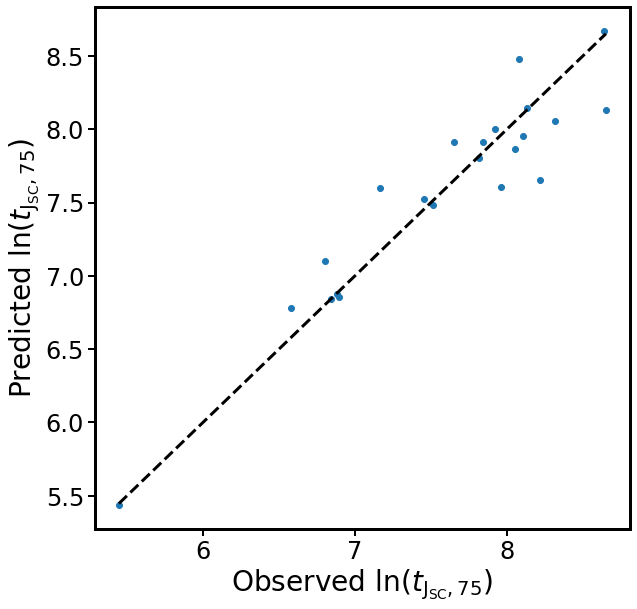

In [208]:
chosen_features = means_df.columns # what are the chosen features

Jsc75_pred = rawdata_df[chosen_features[0]]*0 # initialize a series of same length as original dataframe

for feat in chosen_features: # now populate it with predictions made by the median model
    Jsc75_pred += full_coeffs_df[feat].iloc[med_idx]*(rawdata_df[feat] - means_df[feat].iloc[med_idx])/stds_df[feat].iloc[med_idx] 
    
Jsc75_pred += full_coeffs_df['intercepts'].iloc[med_idx]
plt.plot(np.log(rawdata_df['t_Jsc75']),Jsc75_pred,'.')
p_range = np.linspace(np.nanmin(np.log(rawdata_df['t_Jsc75'])),np.nanmax(np.log(rawdata_df['t_Jsc75'])),num=2)
plt.plot(p_range,p_range,'k--')
plt.xlabel('Observed ln($t_\mathrm{J_{SC},75}$)')
plt.ylabel('Predicted ln($t_\mathrm{J_{SC},75}$)')

rawdata_df['Jsc75_pred'] = Jsc75_pred

if 'Jsc75_pred' not in grand_feats:
    grand_feats.append('Jsc75_pred')

In [209]:
# Now add the predicted Jsc75 to the list of features

# Jsc75_pred = 0.351593*((rawdata_df['d2DFmeandt2']+1.063540)/4.065055) +\
#              -0.386651*((rawdata_df['ddVmppdt2']-0.000475)/0.001655) +\
#              7.576429

# rawdata_df['Jsc75_pred'] = Jsc75_pred

# if 'Jsc75_pred' not in grand_feats:
#     grand_feats.append('Jsc75_pred')

Training Models with 2 Features
Status: model training about 0.0% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
Status: model training about 47.62% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
Status: model training about 95.24% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
2 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 4.3 %
Median of Mean Absolute Error = 2.2 %
Std. Dev. of Mean Absolute Error = 5.0 %
Mean of Mean Absolute Error = 0.298
Median of Mean Absolute Error = 0.177
Std. Dev. of Mean Absolute Error = 0.322
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 3.2 %
Median of Mean Absolute Error = 3.2 %
Std. Dev. of Mean Absolute Error = 0.1 %
Mean of Mean Absolute Error = 0.227
Median of Mean Absolute Error = 0.227
Std. Dev. of Mean Absolute Error = 0.002
Mean R2 = 0.8536
Median R2 = 0.8586
Std Dev. R2 = 0.0152
Mean Linear Error = 29.0 %
Median Linear Error = 17.0 %
-----------------------------------------------------------------


Index of Median Model: 0


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
Training Models with 3 Features
Status: model training about 0.0% complete...


<ipython-input-210-cc600540d1dd>:555: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
Status: model training about 47.62% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
Status: model training about 95.24% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
3 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 4.4 %
Median of Mean Absolute Error = 2.2 %
Std. Dev. of Mean Absolute Error = 5.2 %
Mean of Mean Absolute Error = 0.305
Median of Mean Absolute Error = 0.16
Std. Dev. of Mean Absolute Error = 0.337
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 3.2 %
Median of Mean Absolute Error = 3.2 %
Std. Dev. of Mean Absolute Error = 0.1 %
Mean of Mean Absolute Error = 0.228
Median of Mean Absolute Error = 0.227
Std. Dev. of Mean Absolute Error = 0.003
Mean R2 = 0.8525
Median R2 = 0.8581
Std Dev. R2 = 0.0164
Mean Linear Error = 31.0 %
Median Linear Error = 16.0 %
-----------------------------------------------------------------


Index of Median Model: 0


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
Training Models with 4 Features
Status: model training about 0.0% complete...


<ipython-input-210-cc600540d1dd>:555: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}
Status: model training about 47.62% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}
Status: model training about 95.24% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}
4 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 3.0 %
Median of Mean Absolute Error = 2.3 %
Std. Dev. of Mean Absolute Error = 2.6 %
Mean of Mean Absolute Error = 0.211
Median of Mean Absolute Error = 0.173
Std. Dev. of Mean Absolute Error = 0.18
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 1.8 %
Median of Mean Absolute Error = 1.8 %
Std. Dev. of Mean Absolute Error = 0.2 %
Mean of Mean Absolute Error = 0.138
Median of Mean Absolute Error = 0.134
Std. Dev. of Mean Absolute Error = 0.011
Mean R2 = 0.947
Median R2 = 0.9502
Std Dev. R2 = 0.0075
Mean Linear Error = 22.0 %
Median Linear Error = 16.0 %
-----------------------------------------------------------------


Index of Median Model: 1


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}
Training Models with 5 Features
Status: model training about 0.0% complete...


<ipython-input-210-cc600540d1dd>:555: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
Status: model training about 47.62% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}
Status: model training about 95.24% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}
5 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 3.4 %
Median of Mean Absolute Error = 2.2 %
Std. Dev. of Mean Absolute Error = 3.5 %
Mean of Mean Absolute Error = 0.245
Median of Mean Absolute Error = 0.166
Std. Dev. of Mean Absolute Error = 0.237
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 1.9 %
Median of Mean Absolute Error = 1.8 %
Std. Dev. of Mean Absolute Error = 0.2 %
Mean of Mean Absolute Error = 0.142
Median of Mean Absolute Error = 0.135
Std. Dev. of Mean Absolute Error = 0.015
Mean R2 = 0.943
Median R2 = 0.9493
Std Dev. R2 = 0.0156
Mean Linear Error = 24.0 %
Median Linear Error = 18.0 %
-----------------------------------------------------------------


Index of Median Model: 1


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}
Training Models with 6 Features
Status: model training about 0.0% complete...


<ipython-input-210-cc600540d1dd>:555: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
Status: model training about 47.62% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
Status: model training about 95.24% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}
6 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 4.1 %
Median of Mean Absolute Error = 2.8 %
Std. Dev. of Mean Absolute Error = 3.8 %
Mean of Mean Absolute Error = 0.286
Median of Mean Absolute Error = 0.23
Std. Dev. of Mean Absolute Error = 0.243
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 2.2 %
Median of Mean Absolute Error = 2.3 %
Std. Dev. of Mean Absolute Error = 0.2 %
Mean of Mean Absolute Error = 0.161
Median of Mean Absolute Error = 0.164
Std. Dev. of Mean Absolute Error = 0.011
Mean R2 = 0.9326
Median R2 = 0.9348
Std Dev. R2 = 0.0127
Mean Linear Error = 28.0 %
Median Linear Error = 21.0 %
-----------------------------------------------------------------


Index of Median Model: 0


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
Training Models with 7 Features
Status: model training about 0.0% complete...


<ipython-input-210-cc600540d1dd>:555: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
Status: model training about 47.62% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
Status: model training about 95.24% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}
7 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 4.1 %
Median of Mean Absolute Error = 2.8 %
Std. Dev. of Mean Absolute Error = 3.8 %
Mean of Mean Absolute Error = 0.283
Median of Mean Absolute Error = 0.23
Std. Dev. of Mean Absolute Error = 0.245
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 2.3 %
Median of Mean Absolute Error = 2.3 %
Std. Dev. of Mean Absolute Error = 0.1 %
Mean of Mean Absolute Error = 0.165
Median of Mean Absolute Error = 0.164
Std. Dev. of Mean Absolute Error = 0.008
Mean R2 = 0.931
Median R2 = 0.9345
Std Dev. R2 = 0.0122
Mean Linear Error = 28.0 %
Median Linear Error = 21.0 %
-----------------------------------------------------------------


Index of Median Model: 0


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
Training Models with 8 Features
Status: model training about 0.0% complete...


<ipython-input-210-cc600540d1dd>:555: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
Status: model training about 47.62% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
Status: model training about 95.24% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}
8 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 5.6 %
Median of Mean Absolute Error = 2.8 %
Std. Dev. of Mean Absolute Error = 8.3 %
Mean of Mean Absolute Error = 0.371
Median of Mean Absolute Error = 0.23
Std. Dev. of Mean Absolute Error = 0.498
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 2.3 %
Median of Mean Absolute Error = 2.3 %
Std. Dev. of Mean Absolute Error = 0.3 %
Mean of Mean Absolute Error = 0.164
Median of Mean Absolute Error = 0.164
Std. Dev. of Mean Absolute Error = 0.019
Mean R2 = 0.9155
Median R2 = 0.9346
Std Dev. R2 = 0.0779
Mean Linear Error = 69.0 %
Median Linear Error = 21.0 %
-----------------------------------------------------------------


Index of Median Model: 0


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
Training Models with 9 Features
Status: model training about 0.0% complete...


<ipython-input-210-cc600540d1dd>:555: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
Status: model training about 47.62% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}
Status: model training about 95.24% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
9 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 5.3 %
Median of Mean Absolute Error = 2.1 %
Std. Dev. of Mean Absolute Error = 7.5 %
Mean of Mean Absolute Error = 0.355
Median of Mean Absolute Error = 0.171
Std. Dev. of Mean Absolute Error = 0.447
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 1.8 %
Median of Mean Absolute Error = 1.8 %
Std. Dev. of Mean Absolute Error = 0.3 %
Mean of Mean Absolute Error = 0.131
Median of Mean Absolute Error = 0.131
Std. Dev. of Mean Absolute Error = 0.019
Mean R2 = 0.9409
Median R2 = 0.9581
Std Dev. R2 = 0.0625
Mean Linear Error = 59.0 %
Median Linear Error = 17.0 %
-----------------------------------------------------------------


Index of Median Model: 0


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


<ipython-input-210-cc600540d1dd>:555: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)


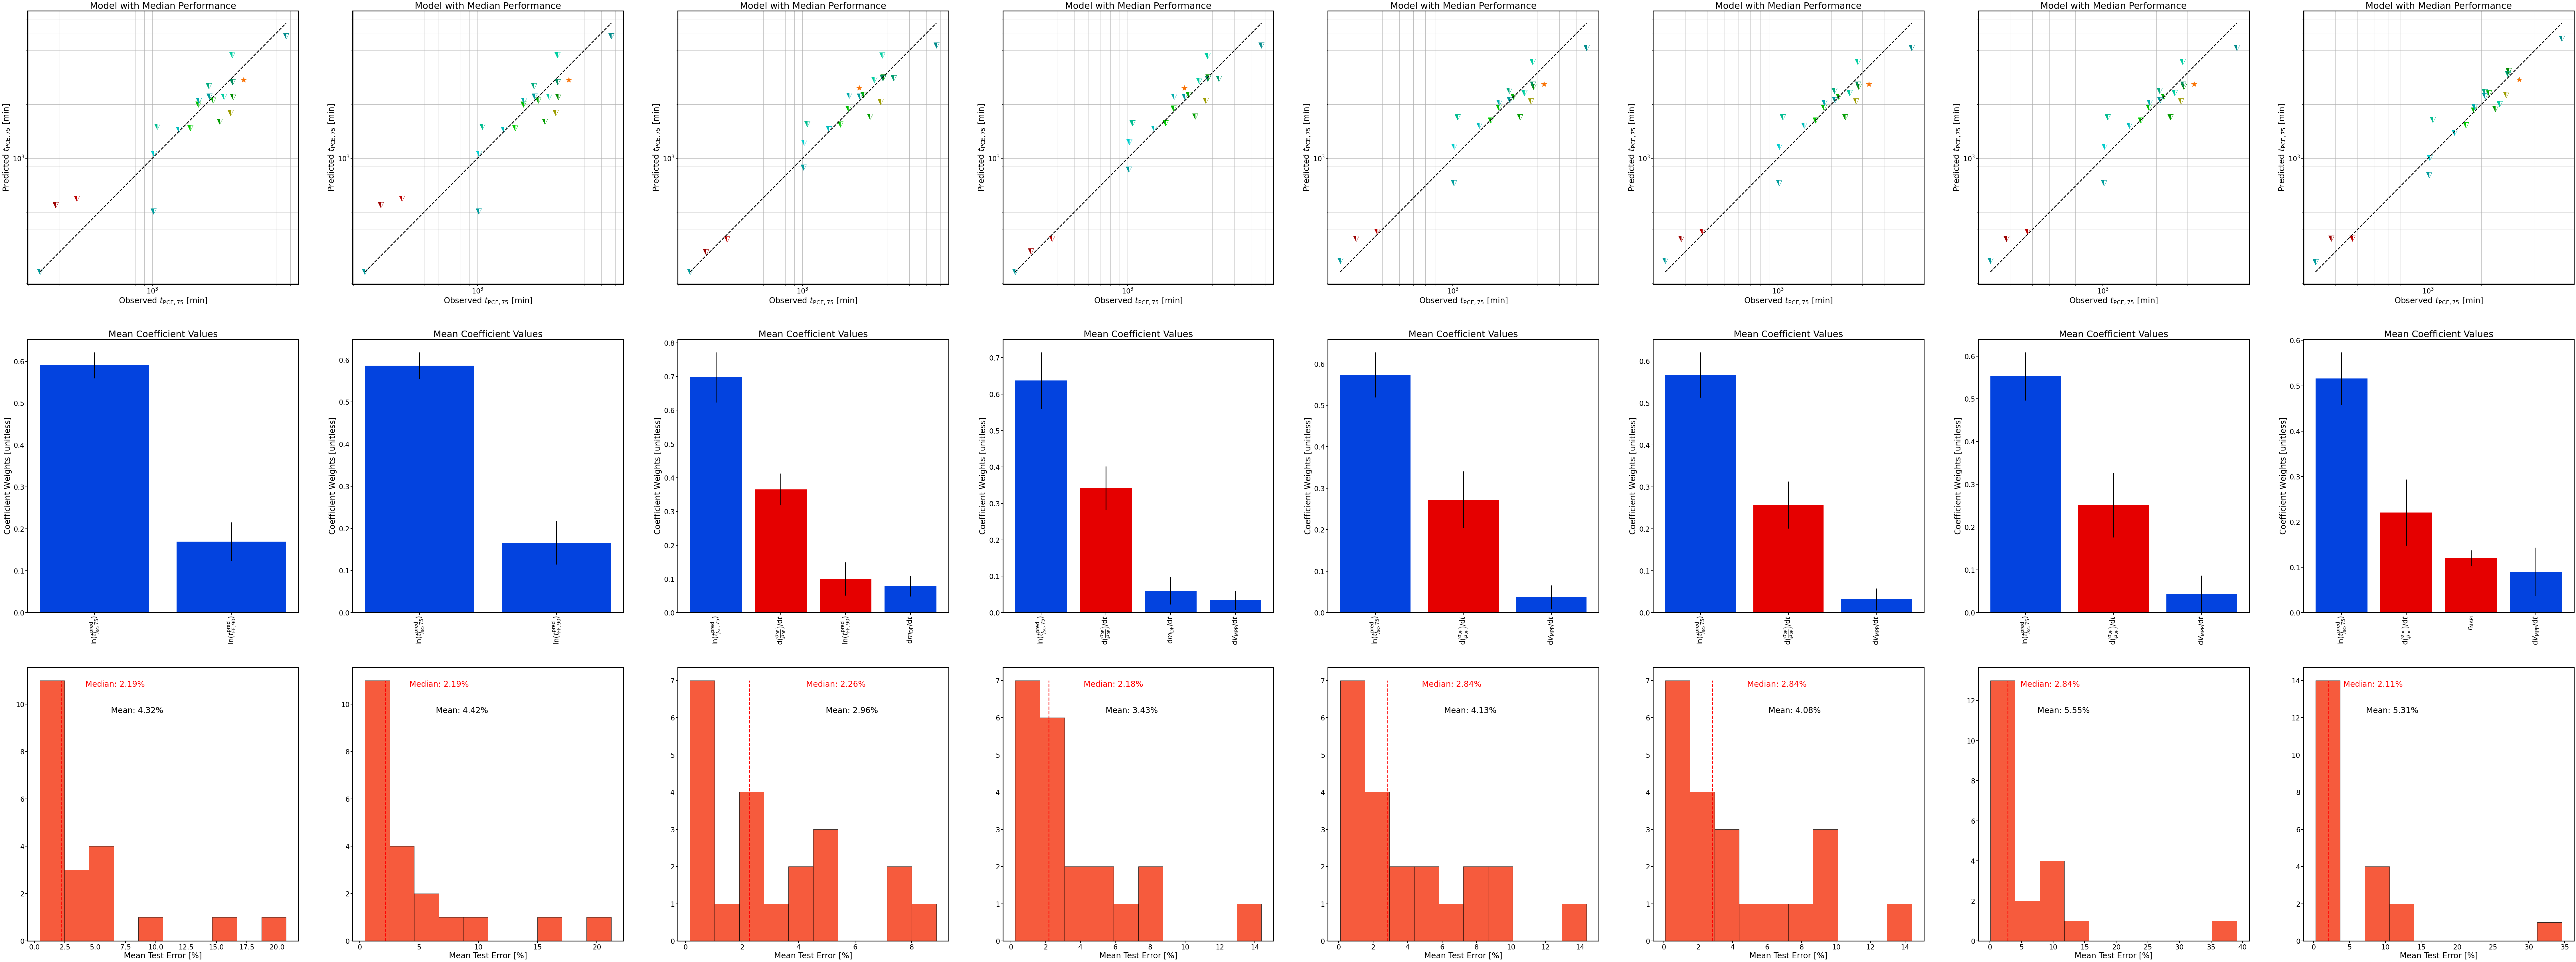

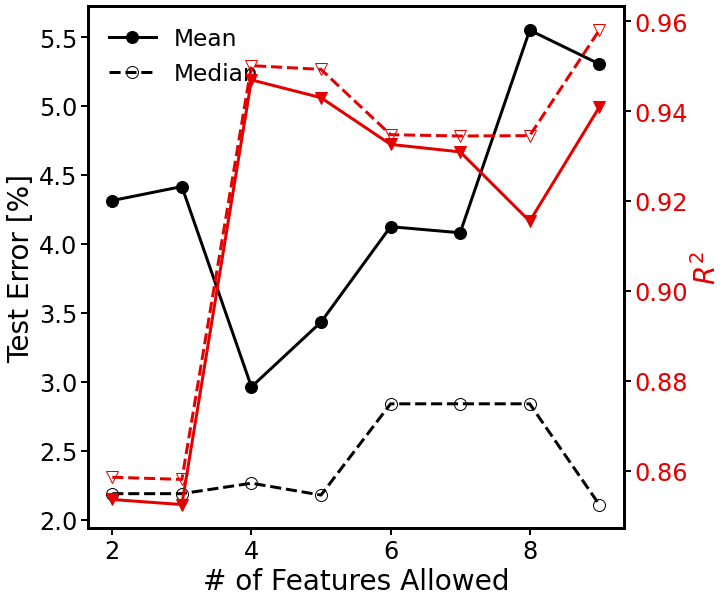

In [210]:
# change to True if using a log transform on the response
Log_transform = True

unshrink_coefficients = False

# choose the feature to use as the response
response = 't_PCE75'
#response = 't_Jsc75'
#response = 't_Vocmax'
#response = 't_FF90'

R_thresh = np.sqrt(0.5) # threshold for rejecting cross-correlated features 


feats_to_use_max = 10 # how many features to use for modeling, max
feats_to_use_min = 2 # how many features to use for modeling, min

mean_err_feats = np.zeros(feats_to_use_max-feats_to_use_min) # keep track of error
median_err_feats = np.zeros(feats_to_use_max-feats_to_use_min)
mean_R2_feats = np.zeros(feats_to_use_max-feats_to_use_min)
median_R2_feats = np.zeros(feats_to_use_max-feats_to_use_min)

# identify whether the prediction target should be log-transformed or not
if Log_transform and response == 't_PCE75':
    target = 'ln_PCE75'
elif Log_transform and response == 't_Jsc75':
    target = 'ln_Jsc75'
else:
    target = response
    
# initialize a big figure where we track parity plots, error, etc across each echelon of model complexity
big_fig, big_ax = plt.subplots(3,feats_to_use_max-feats_to_use_min,
                               figsize=(20*(feats_to_use_max-feats_to_use_min),60))

grand_feats_PCE = grand_feats.copy()
#grand_feats_PCE.remove('Jsc75_pred')

for feats_to_use in range(feats_to_use_min,feats_to_use_max): # OUTERMOST LOOP: iterate over # of allowed features in the model
    
    print('Training Models with',feats_to_use,'Features')

    ############################## FIGURING OUT WHICH FEATURES TO USE ############################################
    
    # initialize lists of correlation coefficients AND their absolute values
    Pearson_Rs = []
    Pearson_Rs_abs = []

    # calculate Pearson correlation for each feature
    for feat in grand_feats_PCE:
        # screen out points where data are missing
        nas = np.logical_or(np.isnan(rawdata_df[target].values), np.isnan(rawdata_df[feat].values))
        r,_ = scipy.stats.pearsonr(rawdata_df[target].values[~nas],rawdata_df[feat].values[~nas])
        Pearson_Rs.append(r)
        Pearson_Rs_abs.append(np.abs(r))

    # create a dataframe keeping track of features and correlation coefficients
    feat_corrs_df = pd.DataFrame(columns = ['Feature','Pearson R','Pearson |R|'])
    feat_corrs_df['Feature'] = grand_feats_PCE
    feat_corrs_df['Pearson R'] = Pearson_Rs
    feat_corrs_df['Pearson |R|'] = Pearson_Rs_abs

    # take preliminary feature set
    feat_corrs_df_sorted = feat_corrs_df.sort_values(by='Pearson |R|',ascending=False)
    selected_feat_corrs_df = feat_corrs_df_sorted.iloc[:feats_to_use]

    alt_feat_idx = feats_to_use # keep track of where we stopped taking features from the larger dataframe

    # now we have to make sure that the selected features aren't too closely correlated with each other
    ii = 0
    while ii < feats_to_use: # scan over all features in the selected list

        # print('ii =',ii) # error checking

        jj = 0 # reset inner loop index

        while jj < ii: # scan over all other features (only need to do jj < ii b/c correlation matrix is symmetric)

            # print('jj =',jj) # error checking

            # calculate cross-correlation between iith and jjth features in the selected df
            nas = np.logical_or(np.isnan(rawdata_df[selected_feat_corrs_df['Feature'].iloc[ii]].values), 
                                np.isnan(rawdata_df[selected_feat_corrs_df['Feature'].iloc[jj]].values))        
            R_cross,_ = scipy.stats.pearsonr(rawdata_df[selected_feat_corrs_df['Feature'].iloc[ii]].values[~nas],
                                             rawdata_df[selected_feat_corrs_df['Feature'].iloc[jj]].values[~nas])

            # if they're too highly cross-correlated... 
            if R_cross > R_thresh:

                # print('Found cross-correlation') # error checking

                # throw out whichever one has a lower correlation with the target...
                # Note that because the features are already ranked by |R| we can throw out whichever is associated with
                # the larger index - i.e., ii (since jj is by definition < ii as defined in the second loop)
                selected_feat_corrs_df = selected_feat_corrs_df.drop(selected_feat_corrs_df.index[ii])

                # ...and replace the rejected feature with the next-most correlated feature from the grand feature list
                selected_feat_corrs_df = selected_feat_corrs_df.append(feat_corrs_df_sorted.iloc[alt_feat_idx])

                alt_feat_idx += 1 # increment the feature counter for the larger dataframe so we don't keep picking the same new features

                # reset ii and jj and break to outer loop
                ii = 0
                break
            # if the cross-correlation is acceptable, just increment the inner loop counter
            else:
                jj += 1
        # if everything is successful, move to the next feature in the list        
        ii += 1

    # display the final list of features and their correlations
    # selected_feat_corrs_df
    
    # now let's set up the model...
    
    # Features we keep:
    Ryan_features = list(selected_feat_corrs_df['Feature'].values)

    # full set: features + response
    terms_to_keep = Ryan_features + [response]

    # make a copy of the dataframe so that irrelevant responses can be removed
    coded_df = rawdata_df.copy()
    
    # drop responses that we're not interested in
    cols_to_drop = diff(list(coded_df.columns),terms_to_keep)
    coded_df = coded_df.drop(columns=cols_to_drop)

    # drop rows containing NaNs
    coded_df = coded_df.dropna(axis=0)
    
    # get rid of non-positive values if taking log of response
    if Log_transform:
        coded_df = coded_df[coded_df[response]>0]
    
    # print('Number of Runs Total:',len(coded_df))

    # display the modeling-ready dataset head    
    coded_df
    
    ############################## TRAINING THE MODELS ############################################
    
    if Log_transform:
        Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
    else:
        Y = coded_df[response].copy()
    X = coded_df.drop(columns=response).copy()

    # number of runs in dataset - for leave-one-out testing this is the size of the dataset
    n_trials = len(Y)

    # set up search parameters for cross-validation, which will be used to select the hyperparameter
    param_vals = np.logspace(-3,3,num=31) # range of hyperparameters to test
    parameters = {'alpha': param_vals}
    model = Lasso(max_iter=1e9) # model to implement - LASSO, Ridge, etc.
    #metric = 'neg_mean_squared_error' # scoring metric - MSE, R2, etc.
    metric = 'neg_mean_absolute_error'
    #metric = 'r2'
    folds = n_trials-1 # how many folds to do in k-fold cross-validation - 5 is standard
    #folds = 10

    # initialize error metrics for test set...
    R2 = np.zeros(n_trials) # coefficient of determination
    RMSE = np.zeros(n_trials) # RMS error
    MAE_pct = np.zeros(n_trials) # mean absolute error, percent
    MAE_pct_signed = np.zeros(n_trials) # mean absolute error, percent with sign
    MAE = np.zeros(n_trials) # mean absolute error

    # ...and for the whole dataset...
    MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
    MAE_overall = np.zeros(n_trials) # mean absolute error, percent
    R2_overall = np.zeros(n_trials) # coefficient of determination

    # ...and for the training set
    MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
    MAE_train = np.zeros(n_trials) # mean absolute error, percent
    R2_train = np.zeros(n_trials) # coefficient of determination

    # error on linear scale (only relevant if log transform is used on response, but we do this a lot)
    linear_error = np.zeros(n_trials)

    # initialize a dataframe to keep track of model coefficients on every iteration of the test set loop
    coeffs_df = pd.DataFrame(columns=coded_df.drop(columns=response).columns)
    # keep track of Shapley values too
    Shap_vals_df =  pd.DataFrame(columns=coded_df.drop(columns=response).columns)
    # keep track of *change in* error with feature deleted relative to model with the full feature set
    d_error_missing_feats = []

    # outer loop: hold one sample out for testing every iteration
    for kk in range(n_trials):

        if kk%10 == 0:
            print('Status: model training about ' + str(np.round(kk/n_trials * 100,2)) + '% complete...')

        # do test/train split by pulling out one row at a time form the feature and response DFs
        # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
        # ALSO: COPY THE SUBSETS Of THE DATAFRAMES or the values in the source will change and the 
        # prediction will be unstable and the whole thing will be ruined
        X_whold = X.iloc[kk].copy()
        y_whold = Y.iloc[kk:kk+1].copy()
        X_train = X.drop(X.index[kk]).copy()
        y_train = Y.drop(X.index[kk]).copy()

        # standardize the data according to the mean and variance of each feature in the training dataset
        for col in X_train.columns:
            # get mean and variance of features in the test set
            col_mean = np.mean(X_train[col])
            col_std = np.std(X_train[col])
            # standardize the features in the training set
            z_train = (X_train[col] - col_mean)/col_std
            X_train[col] = z_train
            # standardize the features in the test set
            z_whold = (X_whold[col] - col_mean)/col_std
            X_whold[col] = z_whold

        # cross-validation step to set alpha/lambda/penalty hyperparameter
        regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
        regressor.fit(X_train,y_train)

        # print winning HP value if desired...
        print(regressor.best_params_)
        #print(regressor.best_score_)
        alpha = regressor.best_params_['alpha']

        # ...and retrain the final model on the full training set
        final_model = Lasso(alpha=alpha)
        final_model.fit(X_train,y_train)
        #print(final_model.coef_)

        # if desired, recalculate the coefficients:
        if unshrink_coefficients:

            # figure out which coefficients survived
            surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]

            # make a copy of the training set with rejected coefficients stripped out
            X_red = X_train.copy()
            X_red = X_red[surviving_coeffs]
            X_whold_red = X_whold.copy()
            X_whold_red = X_whold_red[surviving_coeffs]
            # retrain the final model

            # train a simple linear regression
            shrunk_model = sklearn.linear_model.LinearRegression()
            shrunk_model.fit(X_red,y_train)

            # and fit the data
            ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
            ytpred=shrunk_model.predict(X_red)

        else:
            # make predictions on the test and training data
            ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
            ytpred=final_model.predict(X_train)

        # calculate error metrics on test set
        RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
        R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
        MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
        MAE_pct_signed[kk] = (y_whold-ypred)/y_whold*100
        MAE[kk] = np.mean(np.abs(y_whold-ypred))

        # put the whole dataset back together (note that this will create arrays, not DFs)
        y_net = np.concatenate([y_train,y_whold])
        y_pred_net = np.concatenate([ytpred,ypred])

        # calculate error metrics on entire set
        R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
        MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
        MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

        # calculate error metrics on training set
        R2_train[kk] = metrics.r2_score(y_train, ytpred)
        MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
        MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

        # calculate linear error metric
        linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100              

        # save the model coefficients to the respective row in the DF
        if unshrink_coefficients:
            # reconstruct the full model coefficients
            coeffs_vector = np.zeros(len(final_model.coef_))
            count = 0
            for ii in range(len(final_model.coef_)):
                if final_model.coef_[ii] != 0:
                    coeffs_vector[ii] = shrunk_model.coef_[count]
                    count += 1
            coeffs_df = coeffs_df.append(pd.DataFrame(coeffs_vector.reshape(1,len(final_model.coef_)),
                                                      columns=coded_df.drop(columns=response).columns))
        else:
            coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns))

        # calculate and save Shapley values
        shap_vals = final_model.coef_.reshape(1,len(final_model.coef_))*(np.array(X_whold)-np.mean(np.array(X_train),axis=0))
        Shap_vals_df = Shap_vals_df.append(pd.DataFrame(shap_vals,columns=coded_df.drop(columns=response).columns))  

    coeffs = coeffs_df.columns # save coefficient names
    avgs = np.mean(coeffs_df) # average the coefficients
    error = np.std(coeffs_df) # and get their standard deviations



    # Print important test statistics
    print(feats_to_use,'Feature Model Error Metrics:')
    print('-----------------------------------------------------------------')
    print('For test set:')
    print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct),1), '%')
    print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct),1), '%')
    print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct),1), '%')
    print('Mean of Mean Absolute Error =', np.round(np.mean(MAE),3))
    print('Median of Mean Absolute Error =', np.round(np.median(MAE),3))
    print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE),3))
    print('Mean R2 =', np.round(np.mean(R2),4))
    print('Median R2 =', np.round(np.median(R2),4))
    print('Std Dev. R2 =', np.round(np.std(R2),4))
    
    mean_err_feats[feats_to_use - feats_to_use_min] = np.mean(MAE_pct)
    median_err_feats[feats_to_use - feats_to_use_min] = np.median(MAE_pct)

    print('For whole model:')
    print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct_overall),1), '%')
    print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct_overall),1), '%')
    print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct_overall),1), '%')
    print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_overall),3))
    print('Median of Mean Absolute Error =', np.round(np.median(MAE_overall),3))
    print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_overall),3))
    print('Mean R2 =', np.round(np.mean(R2_overall),4))
    print('Median R2 =', np.round(np.median(R2_overall),4))
    print('Std Dev. R2 =', np.round(np.std(R2_overall),4))
    
    mean_R2_feats[feats_to_use - feats_to_use_min] = np.mean(R2_overall)
    median_R2_feats[feats_to_use - feats_to_use_min] = np.median(R2_overall)

    print('Mean Linear Error =',np.round(np.mean(linear_error)),'%')
    print('Median Linear Error =',np.round(np.median(linear_error)),'%')
    print('-----------------------------------------------------------------')
    print('\n')

    ##### Below this line is the code for plotting the performance of the median model

    # identify the index corresponding to the median mean test error
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    med_idx = idx # save the median index in a less ambiguous form
    print('Index of Median Model:',idx)

    # partition the dataset - note the manipulations necessary to convert the index derived from 
    # the test error array to the index of the DataFrame - THESE VALUES ARE DIFFERENT!
    kk = idx
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold

    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)

    # print winning HP value if desired...
    print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']

    # and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)

    if unshrink_coefficients:

        # figure out which coefficients survived
        surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]

        # make a copy of the training set with rejected coefficients stripped out
        X_red = X_train.copy()
        X_red = X_red[surviving_coeffs]
        X_whold_red = X_whold.copy()
        X_whold_red = X_whold_red[surviving_coeffs]
        # retrain the final model

        # train a simple linear regression
        shrunk_model = sklearn.linear_model.LinearRegression()
        shrunk_model.fit(X_red,y_train)

        # and fit the data
        ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
        ytpred=shrunk_model.predict(X_red)

    else:
        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)
        
    ####### PLOT THE MEDIAN MODEL ##############

    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        if Log_transform:
            big_ax[0,feats_to_use-2].loglog(np.exp(y_train.loc[idx]),np.exp(ytpred[ii]),color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
        else:
            big_ax[0,feats_to_use-2].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
        #plt.text(y_train.loc[idx],ytpred[ii],idx) # ERROR checking: plot the index value

    # plot perfect prediction line and +/-50% error bounds
    if Log_transform:
        plotRange = np.linspace(np.min([np.min(np.exp(y_train)),np.min(np.exp(y_whold))]),
                                np.max([np.max(np.exp(y_train)),np.max(np.exp(y_whold))]),
                                num=101)
        big_ax[0,feats_to_use-2].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    else:
        plotRange = np.linspace(np.min([np.min(y_train),np.min(y_whold)]),np.max([np.max(y_train),np.max(y_whold)]),num=101)
        big_ax[0,feats_to_use-2].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    big_ax[0,feats_to_use-2].grid(which='both')

    if response == 't_Jsc75':
        big_ax[0,feats_to_use-2].set_xlabel('Observed $t_{J_\mathrm{sc},75}$ [min]')
        big_ax[0,feats_to_use-2].set_ylabel('Predicted $t_{J_\mathrm{sc},75}$ [min]')
    elif response == 't_PCE75':
        big_ax[0,feats_to_use-2].set_xlabel('Observed $t_\mathrm{PCE,75}$ [min]')
        big_ax[0,feats_to_use-2].set_ylabel('Predicted $t_\mathrm{PCE,75}$ [min]')
    else:
        big_ax[0,feats_to_use-2].set_xlabel('Observed Value')
        big_ax[0,feats_to_use-2].set_ylabel('Predicted Value')
    #big_ax[0,feats_to_use].set_xticks(fontsize=16)
    #big_ax[0,feats_to_use].set_yticks(fontsize=16)
    big_ax[0,feats_to_use-2].set_title('Model with Median Performance')

    # plot test data as above, with environment denoted by marker appearance and composition by marker size
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        if Log_transform:
            big_ax[0,feats_to_use-2].loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            # plot orange star to identify test samples
            big_ax[0,feats_to_use-2].loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),marker='*',markersize=20,color='xkcd:orange')                
        else:
            big_ax[0,feats_to_use-2].plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            # plot orange star to identify test samples
            big_ax[0,feats_to_use-2].plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange') 
    

    ###################### NOW MAKE PLOTS OF OTHER IMPORTANT THINGS ##########################################
    
    # make a copy of the coeffs_df but with Boolean values to indicate whether the corresponding feature was selected
    selected_df = coeffs_df.copy()

    for ii in range(len(selected_df)):
        logic = selected_df.iloc[ii] != 0 # convert nonzero values to True, zero values to False
        selected_df.iloc[ii] = logic

    # make a DF of key statistics on the coefficient values
    stats_df = coeffs_df.copy()

    # initialize lists of key stats
    medians = []
    means = []
    stds = []

    # populate the lists...
    for col in coeffs_df.columns:
        medians.append(np.median(coeffs_df[col]))
        means.append(np.mean(coeffs_df[col]))
        stds.append(np.std(coeffs_df[col]))
    # ...and add them to the DataFrame 
    stats_df.loc['medians'] = medians
    stats_df.loc['means'] = means
    stats_df.loc['stds'] = stds

    # plot the median values of the coefficients
    #plt.figure(figsize=(10,10))
    #plt.bar(stats_df.columns,stats_df.loc['medians'])
    #plt.xticks(rotation=90)

    # assign bar colors to mean coefficient values
    bar_colors_mean = []
    if response == 'Bleach Rate (fit to 5% inc) (1/min)':
        for jj in range(len(coeffs)):
            if np.sign(means[jj]) == 1:
                bar_colors_mean.append('xkcd:red')
            else:
                bar_colors_mean.append('xkcd:blue')
    else:
        for jj in range(len(coeffs)):
            if np.sign(avgs[jj]) == 1:
                bar_colors_mean.append('xkcd:blue')
            else:
                bar_colors_mean.append('xkcd:red')

    # assign bar colors to median coefficient values
    bar_colors_median = []
    if response == 'Bleach Rate (fit to 5% inc) (1/min)':
        for jj in range(len(coeffs)):
            if np.sign(medians[jj]) == 1:
                bar_colors_median.append('xkcd:red')
            else:
                bar_colors_median.append('xkcd:blue')
    else:
        for jj in range(len(coeffs)):
            if np.sign(medians[jj]) == 1:
                bar_colors_median.append('xkcd:blue')
            else:
                bar_colors_median.append('xkcd:red')

    # make a dataFrame that will be used for bar plots specifically
    bars_df = pd.DataFrame(means) # base it off the mean coefficient values
    bars_df = bars_df.rename(columns={0:'means'})
    bars_df['coeffs'] = coeffs # get coefficient names
    bars_df.index = coeffs # make the DF indices equal to the coefficient names
    bars_df['means'] = np.abs(bars_df['means']) # convert means to their absolute values for prettier/easier-to-read plots
    bars_df['medians'] = np.abs(medians) # add median coefficient values
    bars_df['error'] = stds # add standard deviations
    bars_df['colors_mean'] = bar_colors_mean # encode coefficient sign in bar color
    bars_df['colors_median'] = bar_colors_mean # encode coefficient sign in bar color
    bars_df = bars_df.sort_values(by = 'means', ascending=False) # sort the bars in descending order of mean

    # reduced dataframe of only coefficients with nonvanishing magnitude
    nz_bars_df = bars_df[bars_df['means'] > 0]

    # further reduced dataframe of only coefficients whose average is larger than their std. dev.
    sig_bars_df = nz_bars_df[nz_bars_df['means'] > nz_bars_df['error']]

    
    # define list of nice-looking labels
    fancy_labels=[]
    for coeff in sig_bars_df['coeffs']:
        try:
            fancy_labels.append(fancy_labels_dict[coeff])
        except:
            fancy_labels.append(coeff)

    # plot the means with error bars represented by the standard deviation
    big_ax[1,feats_to_use-2].bar(sig_bars_df['coeffs'],sig_bars_df['means'],yerr=sig_bars_df['error'],color=sig_bars_df['colors_mean'])
    big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
    big_ax[1,feats_to_use-2].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
    big_ax[1,feats_to_use-2].set_title('Mean Coefficient Values')

    ##### BOTTOM LEFT: test set error distribution
    big_ax[2,feats_to_use-2].hist(MAE_pct,color='xkcd:vermillion',alpha=0.8,edgecolor='black',histtype='bar')
    big_ax[2,feats_to_use-2].set_xlabel('Mean Test Error [%]')
    big_ax[2,feats_to_use-2].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
    big_ax[2,feats_to_use-2].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
                  'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top')
    big_ax[2,feats_to_use-2].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
                  'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top')

    

feature_nos = np.array([2,3,4,5,6,7,8,9])

err_fig, err_ax = plt.subplots()

err_ax.plot(feature_nos,mean_err_feats,marker='o',fillstyle='full',linestyle='-',color='xkcd:black')
err_ax.plot(feature_nos,median_err_feats,marker='o',fillstyle='none',linestyle='--',color='xkcd:black')
err_ax.set_xlabel('# of Features Allowed')
err_ax.set_ylabel('Test Error [%]')
err_ax.legend(['Mean','Median'],frameon=False)

ax2 = err_ax.twinx()
ax2.plot(feature_nos,mean_R2_feats,marker='v',fillstyle='full',linestyle='-',color='xkcd:red')
ax2.plot(feature_nos,median_R2_feats,marker='v',fillstyle='none',linestyle='--',color='xkcd:red')
ax2.set_ylabel('$R^2$', color='xkcd:red')
ax2.tick_params(axis='y', labelcolor='xkcd:red')

# Non-Hierarchical PCE Model

Training Models with 2 Features
Status: model training about 0.0% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
Status: model training about 47.62% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.15848931924611143}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
Status: model training about 95.24% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.15848931924611143}
2 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 6.8 %
Median of Mean Absolute Error = 5.1 %
Std. Dev. of Mean Absolute Error = 7.3 %
Mean of Mean Absolute Error = 0.462
Median of Mean Absolute Error = 0.343
Std. Dev. of Mean Absolute Error = 0.431
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 5.9 %
Median of Mean Absolute Error = 5.8 %
Std. Dev. of Mean Absolute Error = 0.1 %
Mean of Mean Absolute Error = 0.402
Median of Mean Absolute Error = 0.4
Std. Dev. of Mean Absolute Error = 0.007
Mean R2 = 0.5216
Median R2 = 0.5241
Std Dev. R2 = 0.0082
Mean Linear Error = 65.0 %
Median Linear Error = 29.0 %
-----------------------------------------------------------------


Index of Median Model: 15


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.15848931924611143}
Training Models with 3 Features
Status: model training about 0.0% complete...


<ipython-input-211-234e7b7e4fa7>:555: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.15848931924611143}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.15848931924611143}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
Status: model training about 47.62% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.15848931924611143}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
Status: model training about 95.24% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.15848931924611143}
3 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 7.0 %
Median of Mean Absolute Error = 3.8 %
Std. Dev. of Mean Absolute Error = 8.7 %
Mean of Mean Absolute Error = 0.471
Median of Mean Absolute Error = 0.302
Std. Dev. of Mean Absolute Error = 0.491
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 5.5 %
Median of Mean Absolute Error = 5.4 %
Std. Dev. of Mean Absolute Error = 0.1 %
Mean of Mean Absolute Error = 0.377
Median of Mean Absolute Error = 0.375
Std. Dev. of Mean Absolute Error = 0.01
Mean R2 = 0.5537
Median R2 = 0.5614
Std Dev. R2 = 0.0166
Mean Linear Error = 76.0 %
Median Linear Error = 26.0 %
-----------------------------------------------------------------


Index of Median Model: 12


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}
Training Models with 4 Features
Status: model training about 0.0% complete...


<ipython-input-211-234e7b7e4fa7>:555: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
Status: model training about 47.62% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
Status: model training about 95.24% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
4 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 6.5 %
Median of Mean Absolute Error = 3.8 %
Std. Dev. of Mean Absolute Error = 7.3 %
Mean of Mean Absolute Error = 0.437
Median of Mean Absolute Error = 0.296
Std. Dev. of Mean Absolute Error = 0.433
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 3.9 %
Median of Mean Absolute Error = 3.9 %
Std. Dev. of Mean Absolute Error = 0.2 %
Mean of Mean Absolute Error = 0.281
Median of Mean Absolute Error = 0.279
Std. Dev. of Mean Absolute Error = 0.012
Mean R2 = 0.7695
Median R2 = 0.7799
Std Dev. R2 = 0.0317
Mean Linear Error = 64.0 %
Median Linear Error = 26.0 %
-----------------------------------------------------------------


Index of Median Model: 10


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
Training Models with 5 Features
Status: model training about 0.0% complete...


<ipython-input-211-234e7b7e4fa7>:555: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}
Status: model training about 47.62% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
Status: model training about 95.24% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
5 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 6.1 %
Median of Mean Absolute Error = 4.6 %
Std. Dev. of Mean Absolute Error = 5.9 %
Mean of Mean Absolute Error = 0.416
Median of Mean Absolute Error = 0.361
Std. Dev. of Mean Absolute Error = 0.356
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 3.5 %
Median of Mean Absolute Error = 3.4 %
Std. Dev. of Mean Absolute Error = 0.2 %
Mean of Mean Absolute Error = 0.257
Median of Mean Absolute Error = 0.252
Std. Dev. of Mean Absolute Error = 0.012
Mean R2 = 0.8102
Median R2 = 0.8203
Std Dev. R2 = 0.027
Mean Linear Error = 55.0 %
Median Linear Error = 31.0 %
-----------------------------------------------------------------


Index of Median Model: 10


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}
Training Models with 6 Features
Status: model training about 0.0% complete...


<ipython-input-211-234e7b7e4fa7>:555: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}
Status: model training about 47.62% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
Status: model training about 95.24% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}
6 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 5.9 %
Median of Mean Absolute Error = 3.4 %
Std. Dev. of Mean Absolute Error = 6.7 %
Mean of Mean Absolute Error = 0.403
Median of Mean Absolute Error = 0.255
Std. Dev. of Mean Absolute Error = 0.408
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 2.8 %
Median of Mean Absolute Error = 2.6 %
Std. Dev. of Mean Absolute Error = 0.4 %
Mean of Mean Absolute Error = 0.209
Median of Mean Absolute Error = 0.2
Std. Dev. of Mean Absolute Error = 0.025
Mean R2 = 0.8397
Median R2 = 0.8553
Std Dev. R2 = 0.0461
Mean Linear Error = 54.0 %
Median Linear Error = 24.0 %
-----------------------------------------------------------------


Index of Median Model: 7


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}
Training Models with 7 Features
Status: model training about 0.0% complete...


<ipython-input-211-234e7b7e4fa7>:555: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}
Status: model training about 47.62% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}
Status: model training about 95.24% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.0025118864315095794}
7 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 6.8 %
Median of Mean Absolute Error = 3.5 %
Std. Dev. of Mean Absolute Error = 7.3 %
Mean of Mean Absolute Error = 0.458
Median of Mean Absolute Error = 0.279
Std. Dev. of Mean Absolute Error = 0.436
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 2.8 %
Median of Mean Absolute Error = 2.7 %
Std. Dev. of Mean Absolute Error = 0.5 %
Mean of Mean Absolute Error = 0.212
Median of Mean Absolute Error = 0.202
Std. Dev. of Mean Absolute Error = 0.028
Mean R2 = 0.8341
Median R2 = 0.8548
Std Dev. R2 = 0.0492
Mean Linear Error = 64.0 %
Median Linear Error = 29.0 %
-----------------------------------------------------------------


Index of Median Model: 12


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
Training Models with 8 Features
Status: model training about 0.0% complete...


<ipython-input-211-234e7b7e4fa7>:555: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
Status: model training about 47.62% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
Status: model training about 95.24% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
8 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 7.0 %
Median of Mean Absolute Error = 3.8 %
Std. Dev. of Mean Absolute Error = 8.2 %
Mean of Mean Absolute Error = 0.468
Median of Mean Absolute Error = 0.311
Std. Dev. of Mean Absolute Error = 0.467
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 2.7 %
Median of Mean Absolute Error = 2.4 %
Std. Dev. of Mean Absolute Error = 0.5 %
Mean of Mean Absolute Error = 0.199
Median of Mean Absolute Error = 0.184
Std. Dev. of Mean Absolute Error = 0.029
Mean R2 = 0.862
Median R2 = 0.8881
Std Dev. R2 = 0.0697
Mean Linear Error = 73.0 %
Median Linear Error = 30.0 %
-----------------------------------------------------------------


Index of Median Model: 0


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
Training Models with 9 Features
Status: model training about 0.0% complete...


<ipython-input-211-234e7b7e4fa7>:555: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
C:\Users\Wiley\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}
Status: model training about 47.62% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.1}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
Status: model training about 95.24% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
9 Feature Model Error Metrics:
-----------------------------------------------------------------
For test set:
Mean of Mean Absolute Error = 6.8 %
Median of Mean Absolute Error = 4.4 %
Std. Dev. of Mean Absolute Error = 8.3 %
Mean of Mean Absolute Error = 0.45
Median of Mean Absolute Error = 0.318
Std. Dev. of Mean Absolute Error = 0.476
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 2.6 %
Median of Mean Absolute Error = 2.2 %
Std. Dev. of Mean Absolute Error = 0.7 %
Mean of Mean Absolute Error = 0.196
Median of Mean Absolute Error = 0.168
Std. Dev. of Mean Absolute Error = 0.04
Mean R2 = 0.8636
Median R2 = 0.9002
Std Dev. R2 = 0.0728
Mean Linear Error = 70.0 %
Median Linear Error = 37.0 %
-----------------------------------------------------------------


Index of Median Model: 18


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001584893192461114}


<ipython-input-211-234e7b7e4fa7>:555: UserWarning: FixedFormatter should only be used together with FixedLocator
  big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)


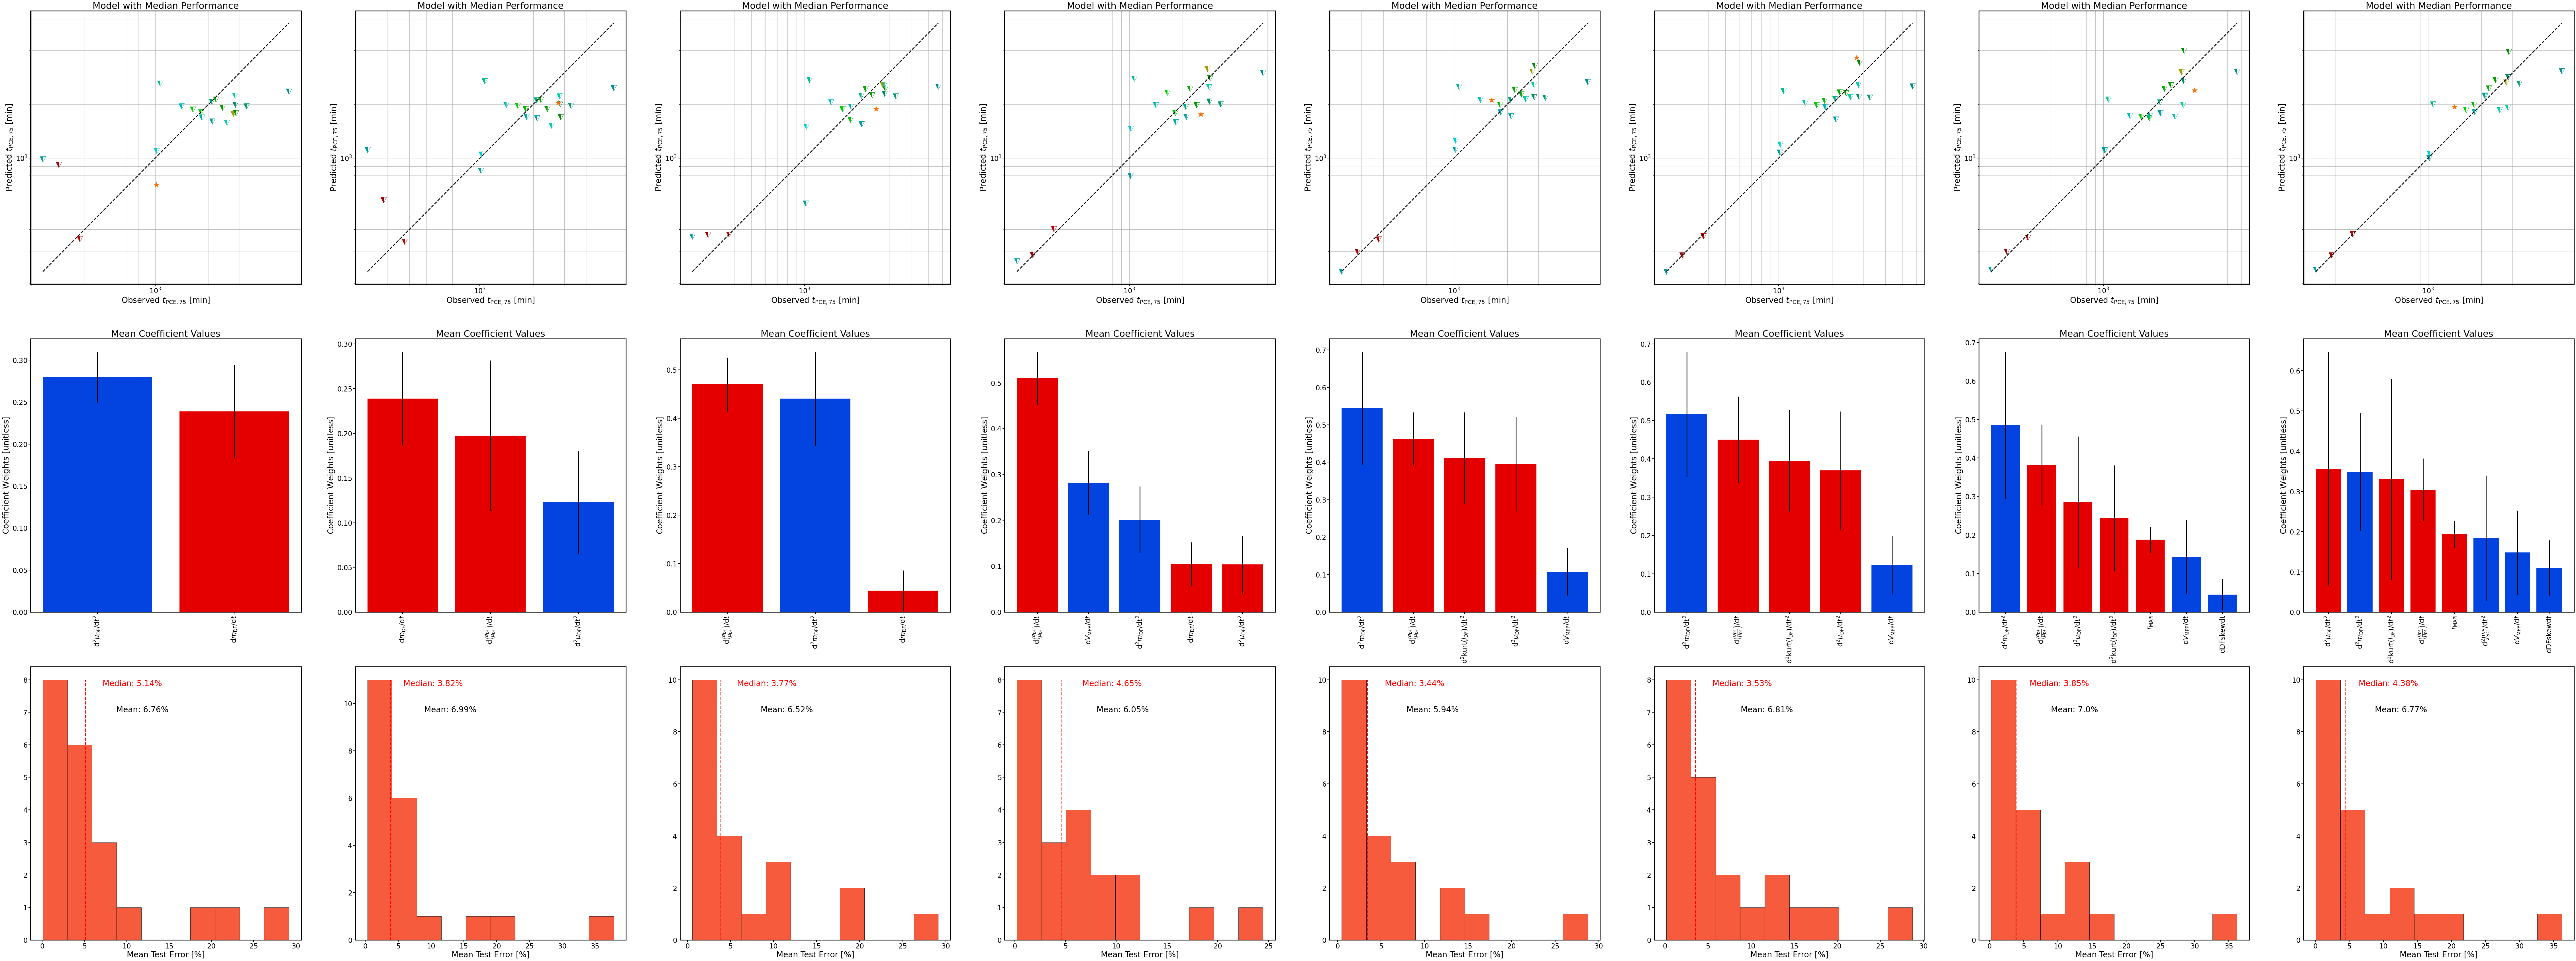

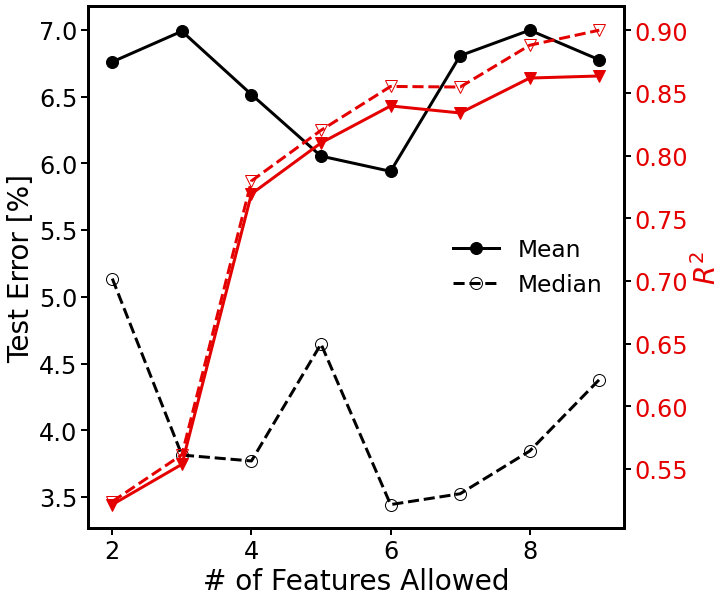

In [211]:
# change to True if using a log transform on the response
Log_transform = True

unshrink_coefficients = False

# choose the feature to use as the response
response = 't_PCE75'
#response = 't_Jsc75'
#response = 't_Vocmax'
#response = 't_FF90'

R_thresh = np.sqrt(0.5) # threshold for rejecting cross-correlated features 

feats_to_use_max = 10 # how many features to use for modeling, max
feats_to_use_min = 2 # how many features to use for modeling, min

mean_err_feats = np.zeros(feats_to_use_max-feats_to_use_min) # keep track of error
median_err_feats = np.zeros(feats_to_use_max-feats_to_use_min)
mean_R2_feats = np.zeros(feats_to_use_max-feats_to_use_min)
median_R2_feats = np.zeros(feats_to_use_max-feats_to_use_min)

# identify whether the prediction target should be log-transformed or not
if Log_transform and response == 't_PCE75':
    target = 'ln_PCE75'
elif Log_transform and response == 't_Jsc75':
    target = 'ln_Jsc75'
else:
    target = response
    
# initialize a big figure where we track parity plots, error, etc across each echelon of model complexity
big_fig, big_ax = plt.subplots(3,feats_to_use_max-feats_to_use_min,
                               figsize=(20*(feats_to_use_max-feats_to_use_min),60))

grand_feats_PCE = grand_feats.copy()
grand_feats_PCE.remove('Jsc75_pred')
grand_feats_PCE.remove('FF90_pred')

for feats_to_use in range(feats_to_use_min,feats_to_use_max): # OUTERMOST LOOP: iterate over # of allowed features in the model
    
    print('Training Models with',feats_to_use,'Features')

    ############################## FIGURING OUT WHICH FEATURES TO USE ############################################
    
    # initialize lists of correlation coefficients AND their absolute values
    Pearson_Rs = []
    Pearson_Rs_abs = []

    # calculate Pearson correlation for each feature
    for feat in grand_feats_PCE:
        # screen out points where data are missing
        nas = np.logical_or(np.isnan(rawdata_df[target].values), np.isnan(rawdata_df[feat].values))
        r,_ = scipy.stats.pearsonr(rawdata_df[target].values[~nas],rawdata_df[feat].values[~nas])
        Pearson_Rs.append(r)
        Pearson_Rs_abs.append(np.abs(r))

    # create a dataframe keeping track of features and correlation coefficients
    feat_corrs_df = pd.DataFrame(columns = ['Feature','Pearson R','Pearson |R|'])
    feat_corrs_df['Feature'] = grand_feats_PCE
    feat_corrs_df['Pearson R'] = Pearson_Rs
    feat_corrs_df['Pearson |R|'] = Pearson_Rs_abs

    # take preliminary feature set
    feat_corrs_df_sorted = feat_corrs_df.sort_values(by='Pearson |R|',ascending=False)
    selected_feat_corrs_df = feat_corrs_df_sorted.iloc[:feats_to_use]

    alt_feat_idx = feats_to_use # keep track of where we stopped taking features from the larger dataframe

    # now we have to make sure that the selected features aren't too closely correlated with each other
    ii = 0
    while ii < feats_to_use: # scan over all features in the selected list

        # print('ii =',ii) # error checking

        jj = 0 # reset inner loop index

        while jj < ii: # scan over all other features (only need to do jj < ii b/c correlation matrix is symmetric)

            # print('jj =',jj) # error checking

            # calculate cross-correlation between iith and jjth features in the selected df
            nas = np.logical_or(np.isnan(rawdata_df[selected_feat_corrs_df['Feature'].iloc[ii]].values), 
                                np.isnan(rawdata_df[selected_feat_corrs_df['Feature'].iloc[jj]].values))        
            R_cross,_ = scipy.stats.pearsonr(rawdata_df[selected_feat_corrs_df['Feature'].iloc[ii]].values[~nas],
                                             rawdata_df[selected_feat_corrs_df['Feature'].iloc[jj]].values[~nas])

            # if they're too highly cross-correlated... 
            if R_cross > R_thresh:

                # print('Found cross-correlation') # error checking

                # throw out whichever one has a lower correlation with the target...
                # Note that because the features are already ranked by |R| we can throw out whichever is associated with
                # the larger index - i.e., ii (since jj is by definition < ii as defined in the second loop)
                selected_feat_corrs_df = selected_feat_corrs_df.drop(selected_feat_corrs_df.index[ii])

                # ...and replace the rejected feature with the next-most correlated feature from the grand feature list
                selected_feat_corrs_df = selected_feat_corrs_df.append(feat_corrs_df_sorted.iloc[alt_feat_idx])

                alt_feat_idx += 1 # increment the feature counter for the larger dataframe so we don't keep picking the same new features

                # reset ii and jj and break to outer loop
                ii = 0
                break
            # if the cross-correlation is acceptable, just increment the inner loop counter
            else:
                jj += 1
        # if everything is successful, move to the next feature in the list        
        ii += 1

    # display the final list of features and their correlations
    # selected_feat_corrs_df
    
    # now let's set up the model...
    
    # Features we keep:
    Ryan_features = list(selected_feat_corrs_df['Feature'].values)

    # full set: features + response
    terms_to_keep = Ryan_features + [response]

    # make a copy of the dataframe so that irrelevant responses can be removed
    coded_df = rawdata_df.copy()
    
    # drop responses that we're not interested in
    cols_to_drop = diff(list(coded_df.columns),terms_to_keep)
    coded_df = coded_df.drop(columns=cols_to_drop)

    # drop rows containing NaNs
    coded_df = coded_df.dropna(axis=0)
    
    # get rid of non-positive values if taking log of response
    if Log_transform:
        coded_df = coded_df[coded_df[response]>0]
    
    # print('Number of Runs Total:',len(coded_df))

    # display the modeling-ready dataset head    
    coded_df
    
    ############################## TRAINING THE MODELS ############################################
    
    if Log_transform:
        Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
    else:
        Y = coded_df[response].copy()
    X = coded_df.drop(columns=response).copy()

    # number of runs in dataset - for leave-one-out testing this is the size of the dataset
    n_trials = len(Y)

    # set up search parameters for cross-validation, which will be used to select the hyperparameter
    param_vals = np.logspace(-3,3,num=31) # range of hyperparameters to test
    parameters = {'alpha': param_vals}
    model = Lasso(max_iter=1e9) # model to implement - LASSO, Ridge, etc.
    #metric = 'neg_mean_squared_error' # scoring metric - MSE, R2, etc.
    metric = 'neg_mean_absolute_error'
    #metric = 'r2'
    folds = n_trials-1 # how many folds to do in k-fold cross-validation - 5 is standard
    #folds = 10

    # initialize error metrics for test set...
    R2 = np.zeros(n_trials) # coefficient of determination
    RMSE = np.zeros(n_trials) # RMS error
    MAE_pct = np.zeros(n_trials) # mean absolute error, percent
    MAE_pct_signed = np.zeros(n_trials) # mean absolute error, percent with sign
    MAE = np.zeros(n_trials) # mean absolute error

    # ...and for the whole dataset...
    MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
    MAE_overall = np.zeros(n_trials) # mean absolute error, percent
    R2_overall = np.zeros(n_trials) # coefficient of determination

    # ...and for the training set
    MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
    MAE_train = np.zeros(n_trials) # mean absolute error, percent
    R2_train = np.zeros(n_trials) # coefficient of determination

    # error on linear scale (only relevant if log transform is used on response, but we do this a lot)
    linear_error = np.zeros(n_trials)

    # initialize a dataframe to keep track of model coefficients on every iteration of the test set loop
    coeffs_df = pd.DataFrame(columns=coded_df.drop(columns=response).columns)
    # keep track of Shapley values too
    Shap_vals_df =  pd.DataFrame(columns=coded_df.drop(columns=response).columns)
    # keep track of *change in* error with feature deleted relative to model with the full feature set
    d_error_missing_feats = []

    # outer loop: hold one sample out for testing every iteration
    for kk in range(n_trials):

        if kk%10 == 0:
            print('Status: model training about ' + str(np.round(kk/n_trials * 100,2)) + '% complete...')

        # do test/train split by pulling out one row at a time form the feature and response DFs
        # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
        # ALSO: COPY THE SUBSETS Of THE DATAFRAMES or the values in the source will change and the 
        # prediction will be unstable and the whole thing will be ruined
        X_whold = X.iloc[kk].copy()
        y_whold = Y.iloc[kk:kk+1].copy()
        X_train = X.drop(X.index[kk]).copy()
        y_train = Y.drop(X.index[kk]).copy()

        # standardize the data according to the mean and variance of each feature in the training dataset
        for col in X_train.columns:
            # get mean and variance of features in the test set
            col_mean = np.mean(X_train[col])
            col_std = np.std(X_train[col])
            # standardize the features in the training set
            z_train = (X_train[col] - col_mean)/col_std
            X_train[col] = z_train
            # standardize the features in the test set
            z_whold = (X_whold[col] - col_mean)/col_std
            X_whold[col] = z_whold

        # cross-validation step to set alpha/lambda/penalty hyperparameter
        regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
        regressor.fit(X_train,y_train)

        # print winning HP value if desired...
        print(regressor.best_params_)
        #print(regressor.best_score_)
        alpha = regressor.best_params_['alpha']

        # ...and retrain the final model on the full training set
        final_model = Lasso(alpha=alpha)
        final_model.fit(X_train,y_train)
        #print(final_model.coef_)

        # if desired, recalculate the coefficients:
        if unshrink_coefficients:

            # figure out which coefficients survived
            surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]

            # make a copy of the training set with rejected coefficients stripped out
            X_red = X_train.copy()
            X_red = X_red[surviving_coeffs]
            X_whold_red = X_whold.copy()
            X_whold_red = X_whold_red[surviving_coeffs]
            # retrain the final model

            # train a simple linear regression
            shrunk_model = sklearn.linear_model.LinearRegression()
            shrunk_model.fit(X_red,y_train)

            # and fit the data
            ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
            ytpred=shrunk_model.predict(X_red)

        else:
            # make predictions on the test and training data
            ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
            ytpred=final_model.predict(X_train)

        # calculate error metrics on test set
        RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
        R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
        MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
        MAE_pct_signed[kk] = (y_whold-ypred)/y_whold*100
        MAE[kk] = np.mean(np.abs(y_whold-ypred))

        # put the whole dataset back together (note that this will create arrays, not DFs)
        y_net = np.concatenate([y_train,y_whold])
        y_pred_net = np.concatenate([ytpred,ypred])

        # calculate error metrics on entire set
        R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
        MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
        MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

        # calculate error metrics on training set
        R2_train[kk] = metrics.r2_score(y_train, ytpred)
        MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
        MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

        # calculate linear error metric
        linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100              

        # save the model coefficients to the respective row in the DF
        if unshrink_coefficients:
            # reconstruct the full model coefficients
            coeffs_vector = np.zeros(len(final_model.coef_))
            count = 0
            for ii in range(len(final_model.coef_)):
                if final_model.coef_[ii] != 0:
                    coeffs_vector[ii] = shrunk_model.coef_[count]
                    count += 1
            coeffs_df = coeffs_df.append(pd.DataFrame(coeffs_vector.reshape(1,len(final_model.coef_)),
                                                      columns=coded_df.drop(columns=response).columns))
        else:
            coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns))

        # calculate and save Shapley values
        shap_vals = final_model.coef_.reshape(1,len(final_model.coef_))*(np.array(X_whold)-np.mean(np.array(X_train),axis=0))
        Shap_vals_df = Shap_vals_df.append(pd.DataFrame(shap_vals,columns=coded_df.drop(columns=response).columns))  

    coeffs = coeffs_df.columns # save coefficient names
    avgs = np.mean(coeffs_df) # average the coefficients
    error = np.std(coeffs_df) # and get their standard deviations



    # Print important test statistics
    print(feats_to_use,'Feature Model Error Metrics:')
    print('-----------------------------------------------------------------')
    print('For test set:')
    print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct),1), '%')
    print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct),1), '%')
    print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct),1), '%')
    print('Mean of Mean Absolute Error =', np.round(np.mean(MAE),3))
    print('Median of Mean Absolute Error =', np.round(np.median(MAE),3))
    print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE),3))
    print('Mean R2 =', np.round(np.mean(R2),4))
    print('Median R2 =', np.round(np.median(R2),4))
    print('Std Dev. R2 =', np.round(np.std(R2),4))
    
    mean_err_feats[feats_to_use - feats_to_use_min] = np.mean(MAE_pct)
    median_err_feats[feats_to_use - feats_to_use_min] = np.median(MAE_pct)

    print('For whole model:')
    print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct_overall),1), '%')
    print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct_overall),1), '%')
    print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct_overall),1), '%')
    print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_overall),3))
    print('Median of Mean Absolute Error =', np.round(np.median(MAE_overall),3))
    print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_overall),3))
    print('Mean R2 =', np.round(np.mean(R2_overall),4))
    print('Median R2 =', np.round(np.median(R2_overall),4))
    print('Std Dev. R2 =', np.round(np.std(R2_overall),4))
    
    mean_R2_feats[feats_to_use - feats_to_use_min] = np.mean(R2_overall)
    median_R2_feats[feats_to_use - feats_to_use_min] = np.median(R2_overall)

    print('Mean Linear Error =',np.round(np.mean(linear_error)),'%')
    print('Median Linear Error =',np.round(np.median(linear_error)),'%')
    print('-----------------------------------------------------------------')
    print('\n')

    ##### Below this line is the code for plotting the performance of the median model

    # identify the index corresponding to the median mean test error
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    med_idx = idx # save the median index in a less ambiguous form
    print('Index of Median Model:',idx)

    # partition the dataset - note the manipulations necessary to convert the index derived from 
    # the test error array to the index of the DataFrame - THESE VALUES ARE DIFFERENT!
    kk = idx
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold

    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)

    # print winning HP value if desired...
    print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']

    # and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)

    if unshrink_coefficients:

        # figure out which coefficients survived
        surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]

        # make a copy of the training set with rejected coefficients stripped out
        X_red = X_train.copy()
        X_red = X_red[surviving_coeffs]
        X_whold_red = X_whold.copy()
        X_whold_red = X_whold_red[surviving_coeffs]
        # retrain the final model

        # train a simple linear regression
        shrunk_model = sklearn.linear_model.LinearRegression()
        shrunk_model.fit(X_red,y_train)

        # and fit the data
        ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
        ytpred=shrunk_model.predict(X_red)

    else:
        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)
        
    ####### PLOT THE MEDIAN MODEL ##############

    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        if Log_transform:
            big_ax[0,feats_to_use-2].loglog(np.exp(y_train.loc[idx]),np.exp(ytpred[ii]),color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
        else:
            big_ax[0,feats_to_use-2].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
        #plt.text(y_train.loc[idx],ytpred[ii],idx) # ERROR checking: plot the index value

    # plot perfect prediction line and +/-50% error bounds
    if Log_transform:
        plotRange = np.linspace(np.min([np.min(np.exp(y_train)),np.min(np.exp(y_whold))]),
                                np.max([np.max(np.exp(y_train)),np.max(np.exp(y_whold))]),
                                num=101)
        big_ax[0,feats_to_use-2].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    else:
        plotRange = np.linspace(np.min([np.min(y_train),np.min(y_whold)]),np.max([np.max(y_train),np.max(y_whold)]),num=101)
        big_ax[0,feats_to_use-2].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    big_ax[0,feats_to_use-2].grid(which='both')

    if response == 't_Jsc75':
        big_ax[0,feats_to_use-2].set_xlabel('Observed $t_{J_\mathrm{sc},75}$ [min]')
        big_ax[0,feats_to_use-2].set_ylabel('Predicted $t_{J_\mathrm{sc},75}$ [min]')
    elif response == 't_PCE75':
        big_ax[0,feats_to_use-2].set_xlabel('Observed $t_\mathrm{PCE,75}$ [min]')
        big_ax[0,feats_to_use-2].set_ylabel('Predicted $t_\mathrm{PCE,75}$ [min]')
    else:
        big_ax[0,feats_to_use-2].set_xlabel('Observed Value')
        big_ax[0,feats_to_use-2].set_ylabel('Predicted Value')
    #big_ax[0,feats_to_use].set_xticks(fontsize=16)
    #big_ax[0,feats_to_use].set_yticks(fontsize=16)
    big_ax[0,feats_to_use-2].set_title('Model with Median Performance')

    # plot test data as above, with environment denoted by marker appearance and composition by marker size
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        if Log_transform:
            big_ax[0,feats_to_use-2].loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            # plot orange star to identify test samples
            big_ax[0,feats_to_use-2].loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),marker='*',markersize=20,color='xkcd:orange')                
        else:
            big_ax[0,feats_to_use-2].plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            # plot orange star to identify test samples
            big_ax[0,feats_to_use-2].plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange') 
    

    ###################### NOW MAKE PLOTS OF OTHER IMPORTANT THINGS ##########################################
    
    # make a copy of the coeffs_df but with Boolean values to indicate whether the corresponding feature was selected
    selected_df = coeffs_df.copy()

    for ii in range(len(selected_df)):
        logic = selected_df.iloc[ii] != 0 # convert nonzero values to True, zero values to False
        selected_df.iloc[ii] = logic

    # make a DF of key statistics on the coefficient values
    stats_df = coeffs_df.copy()

    # initialize lists of key stats
    medians = []
    means = []
    stds = []

    # populate the lists...
    for col in coeffs_df.columns:
        medians.append(np.median(coeffs_df[col]))
        means.append(np.mean(coeffs_df[col]))
        stds.append(np.std(coeffs_df[col]))
    # ...and add them to the DataFrame 
    stats_df.loc['medians'] = medians
    stats_df.loc['means'] = means
    stats_df.loc['stds'] = stds

    # plot the median values of the coefficients
    #plt.figure(figsize=(10,10))
    #plt.bar(stats_df.columns,stats_df.loc['medians'])
    #plt.xticks(rotation=90)

    # assign bar colors to mean coefficient values
    bar_colors_mean = []
    if response == 'Bleach Rate (fit to 5% inc) (1/min)':
        for jj in range(len(coeffs)):
            if np.sign(means[jj]) == 1:
                bar_colors_mean.append('xkcd:red')
            else:
                bar_colors_mean.append('xkcd:blue')
    else:
        for jj in range(len(coeffs)):
            if np.sign(avgs[jj]) == 1:
                bar_colors_mean.append('xkcd:blue')
            else:
                bar_colors_mean.append('xkcd:red')

    # assign bar colors to median coefficient values
    bar_colors_median = []
    if response == 'Bleach Rate (fit to 5% inc) (1/min)':
        for jj in range(len(coeffs)):
            if np.sign(medians[jj]) == 1:
                bar_colors_median.append('xkcd:red')
            else:
                bar_colors_median.append('xkcd:blue')
    else:
        for jj in range(len(coeffs)):
            if np.sign(medians[jj]) == 1:
                bar_colors_median.append('xkcd:blue')
            else:
                bar_colors_median.append('xkcd:red')

    # make a dataFrame that will be used for bar plots specifically
    bars_df = pd.DataFrame(means) # base it off the mean coefficient values
    bars_df = bars_df.rename(columns={0:'means'})
    bars_df['coeffs'] = coeffs # get coefficient names
    bars_df.index = coeffs # make the DF indices equal to the coefficient names
    bars_df['means'] = np.abs(bars_df['means']) # convert means to their absolute values for prettier/easier-to-read plots
    bars_df['medians'] = np.abs(medians) # add median coefficient values
    bars_df['error'] = stds # add standard deviations
    bars_df['colors_mean'] = bar_colors_mean # encode coefficient sign in bar color
    bars_df['colors_median'] = bar_colors_mean # encode coefficient sign in bar color
    bars_df = bars_df.sort_values(by = 'means', ascending=False) # sort the bars in descending order of mean

    # reduced dataframe of only coefficients with nonvanishing magnitude
    nz_bars_df = bars_df[bars_df['means'] > 0]

    # further reduced dataframe of only coefficients whose average is larger than their std. dev.
    sig_bars_df = nz_bars_df[nz_bars_df['means'] > nz_bars_df['error']]

    
    # define list of nice-looking labels
    fancy_labels=[]
    for coeff in sig_bars_df['coeffs']:
        try:
            fancy_labels.append(fancy_labels_dict[coeff])
        except:
            fancy_labels.append(coeff)

    # plot the means with error bars represented by the standard deviation
    big_ax[1,feats_to_use-2].bar(sig_bars_df['coeffs'],sig_bars_df['means'],yerr=sig_bars_df['error'],color=sig_bars_df['colors_mean'])
    big_ax[1,feats_to_use-2].set_xticklabels(labels=fancy_labels,rotation=90)
    big_ax[1,feats_to_use-2].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
    big_ax[1,feats_to_use-2].set_title('Mean Coefficient Values')

    ##### BOTTOM LEFT: test set error distribution
    big_ax[2,feats_to_use-2].hist(MAE_pct,color='xkcd:vermillion',alpha=0.8,edgecolor='black',histtype='bar')
    big_ax[2,feats_to_use-2].set_xlabel('Mean Test Error [%]')
    big_ax[2,feats_to_use-2].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
    big_ax[2,feats_to_use-2].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
                  'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top')
    big_ax[2,feats_to_use-2].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
                  'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top')

    

feature_nos = np.array([2,3,4,5,6,7,8,9])

err_fig, err_ax = plt.subplots()

err_ax.plot(feature_nos,mean_err_feats,marker='o',fillstyle='full',linestyle='-',color='xkcd:black')
err_ax.plot(feature_nos,median_err_feats,marker='o',fillstyle='none',linestyle='--',color='xkcd:black')
err_ax.set_xlabel('# of Features Allowed')
err_ax.set_ylabel('Test Error [%]')
err_ax.legend(['Mean','Median'],frameon=False)

ax2 = err_ax.twinx()
ax2.plot(feature_nos,mean_R2_feats,marker='v',fillstyle='full',linestyle='-',color='xkcd:red')
ax2.plot(feature_nos,median_R2_feats,marker='v',fillstyle='none',linestyle='--',color='xkcd:red')
ax2.set_ylabel('$R^2$', color='xkcd:red')
ax2.tick_params(axis='y', labelcolor='xkcd:red')

In [ ]:
pd.set_option('display.max_rows', None)

feat_corrs_df_sorted['Feature']

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
for ii in range(len(rawdata_df)):

    # get environmental conditions
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    xMA = rawdata_df['MA fraction'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    # plot points
    ax.plot(rawdata_df['Jsc75_pred'].iloc[ii],rawdata_df['FF90_pred'].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=20)
# label axes
ax.set_xlabel('$t_{J_\mathrm{SC},75}$ [min]')
ax.set_ylabel('$t_\mathrm{PCE,75}$ [min]')




# identify where NaNs occur in the dataset...
nas = np.logical_or(np.isnan(rawdata_df['Jsc75_pred'].values),np.isnan(rawdata_df['FF90_pred'].values))
# ... and do not use them for calculating the correlation coefficient
r,_ = sp.stats.pearsonr(rawdata_df['Jsc75_pred'].values[~nas],rawdata_df['FF90_pred'].values[~nas])
ax.set_title('$\\rho$ = ' + str(np.round(r,4)))

# log_fit = np.polyfit(np.log(rawdata_df['t_Jsc75'].values[~nas]),np.log(rawdata_df['t_PCE75'].values[~nas]),1)
# tJsc_range = np.linspace(np.min(rawdata_df['t_Jsc75']),np.max(rawdata_df['t_Jsc75']),num=101)
# ax.plot(tJsc_range,np.exp(log_fit[1])*tJsc_range**log_fit[0],'k--')

lin_fit = np.polyfit(rawdata_df['Jsc75_pred'].values[~nas],rawdata_df['FF90_pred'].values[~nas],1)
tJsc_range = np.linspace(np.min(rawdata_df['Jsc75_pred']),np.max(rawdata_df['FF90_pred']),num=101)
ax.plot(tJsc_range,lin_fit[1] + tJsc_range*lin_fit[0],'k--')

<AxesSubplot:>

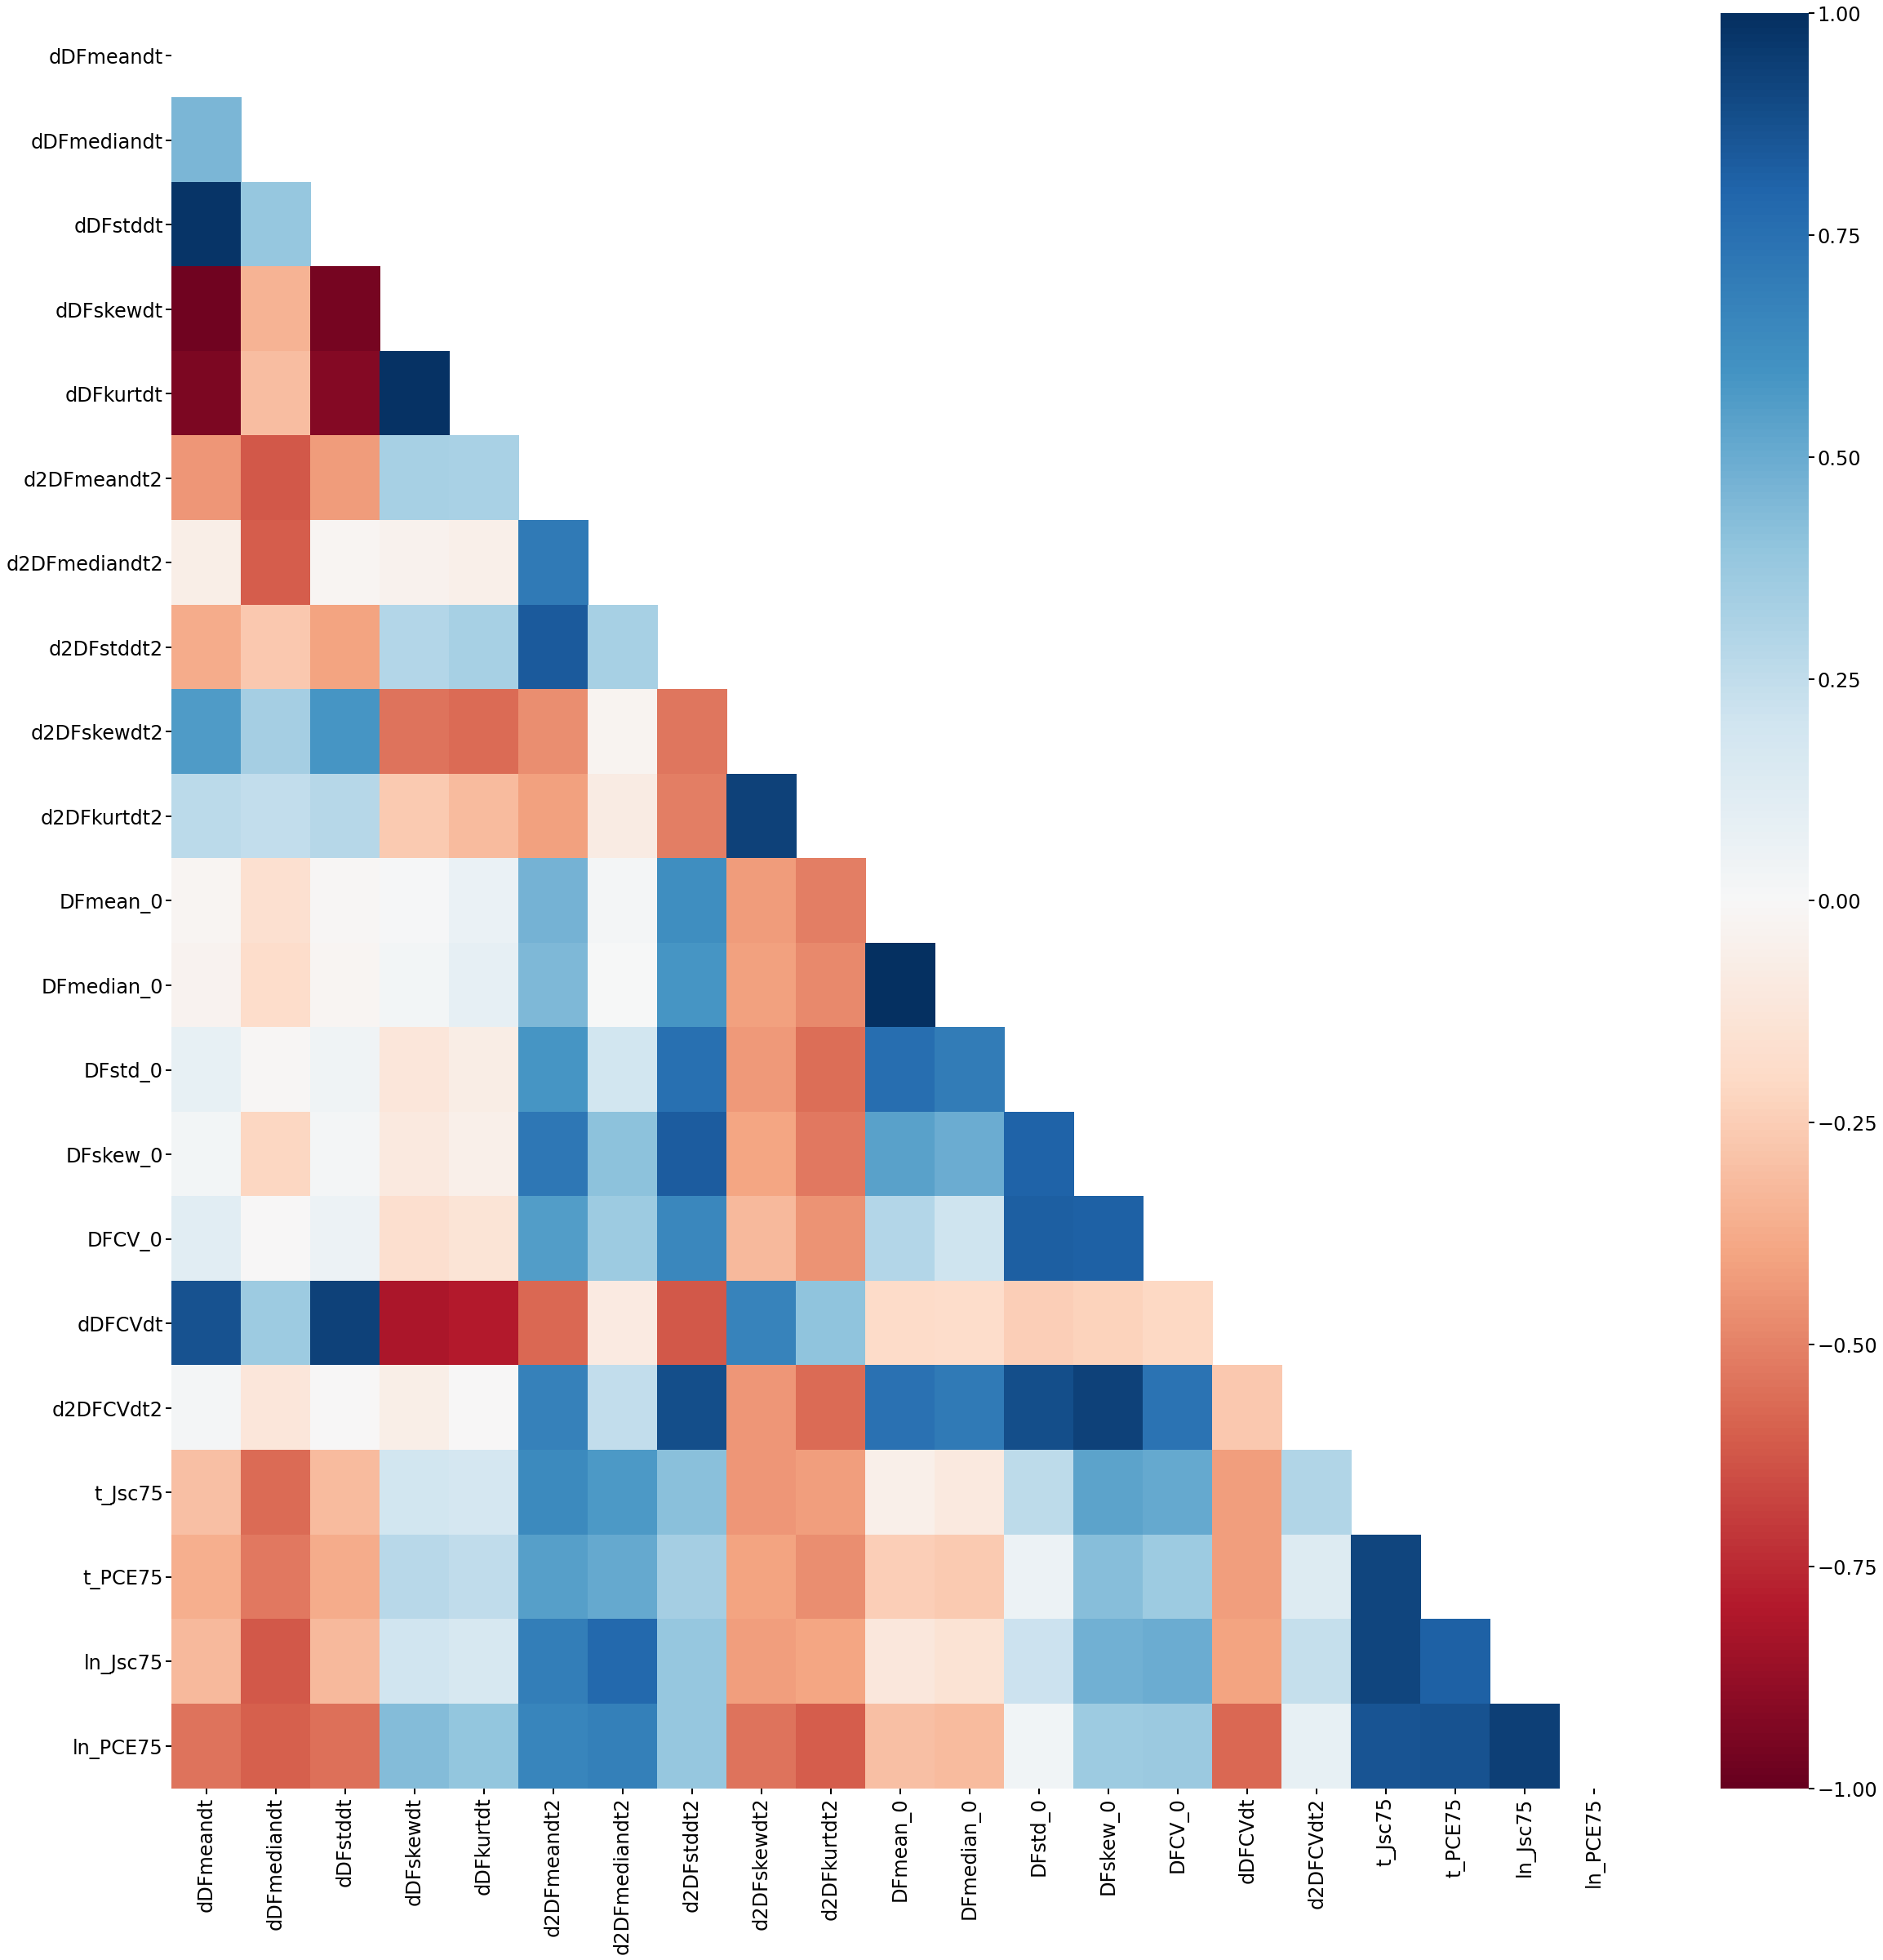

In [78]:


columns_to_analyze = [  
#                       'PLQY_0',
#                       'xy1t0_0',
#                       'xy0t1_0',
#                       'xy0t1Norm_0',
#                       'xy1t1_0',
#                       't0xy1_0',
#                       't1xy0_0',
#                       'xy2t0',
#                       'xy3t0',
#                       'xy2t1',
#                       'xy3t1',
#                       'frac_bright_0',
#                       'QFLS_0',
#                       'beta_mean',
#                       'beta_std',
#                       'cv_slopes',
#                       'dPLdt',
#                       'ddPLdt2',
#                       'dxy1t0dt','dxy0t1dt','dxy0t1Normdt','dxy1t1dt','dt0xy1dt',
#                       'dt1xy0dt','dfrac_brightdt','dxy2t0dt','dxy3t0dt','dxy2t1dt',
#                       'dxy3t1dt','dbeta_meandt','dbeta_stddt','dcv_slopesdt',
#                       'ddxy1t0','ddxy0t1','ddxy0t1Norm','ddxy1t1','ddt0xy1',
#                       'ddt1xy0','ddfrac_bright','ddxy2t0','ddxy3t0','ddxy2t1',
#                       'ddxy3t1','ddbeta_mean','ddbeta_std','ddcv_slopes',

                      'dDFmeandt',
                      'dDFmediandt',
                      'dDFstddt',
                      'dDFskewdt',
                      'dDFkurtdt',
                      'd2DFmeandt2',
                      'd2DFmediandt2',
                      'd2DFstddt2',
                      'd2DFskewdt2',
                      'd2DFkurtdt2',
                      'DFmean_0',
                      'DFmedian_0',
                      'DFstd_0',
                      'DFskew_0',
#                       'DFkurtdt_0',
                        'DFCV_0','dDFCVdt','d2DFCVdt2',
#                       'Jmpp_0',
#                       'Vmpp_0',
#                       'Pmpp_0',
#                       'Jsc_0',
#                       'Voc_0',
#                       'dJmppdt',
#                       'dVmppdt',
#                       'dPmppdt',
#                       'dJscdt',
#                       'dVocdt',
#                       'ddJmppdt2',
#                       'ddVmppdt2',
#                       'ddPmppdt2',
#                       'ddJscdt2',
#                       'ddVocdt2',
#                       'Jschyst_0',
#                       'Vochyst_0',
#                       'FFhyst_0',
#                       'dJsc_fwddt',
#                       'dVoc_fwddt',
#                       'dFF_fwddt',
#                       'dJsc_revdt',
#                       'dVoc_revdt',
#                       'dFF_revdt',
#                       'ddJsc_fwddt2',
#                       'ddVoc_fwddt2',
#                       'ddFF_fwddt2',
#                       'ddJsc_revdt2',
#                       'ddVoc_revdt2',
#                       'ddFF_revdt2',
                       't_Jsc75',
                       't_PCE75',
                       'ln_Jsc75',
                       'ln_PCE75',
                     ]

rawdata_df_reduced = rawdata_df.copy()[columns_to_analyze]

plt.figure(figsize=(40,40))
corr_Matrix = rawdata_df_reduced.corr()

mask = np.zeros_like(corr_Matrix)
mask[np.triu_indices_from(mask)] = True

sn.heatmap(corr_Matrix,
           annot = False,
           cmap = 'RdBu', vmin=-1, vmax=1,
           mask=mask
           )



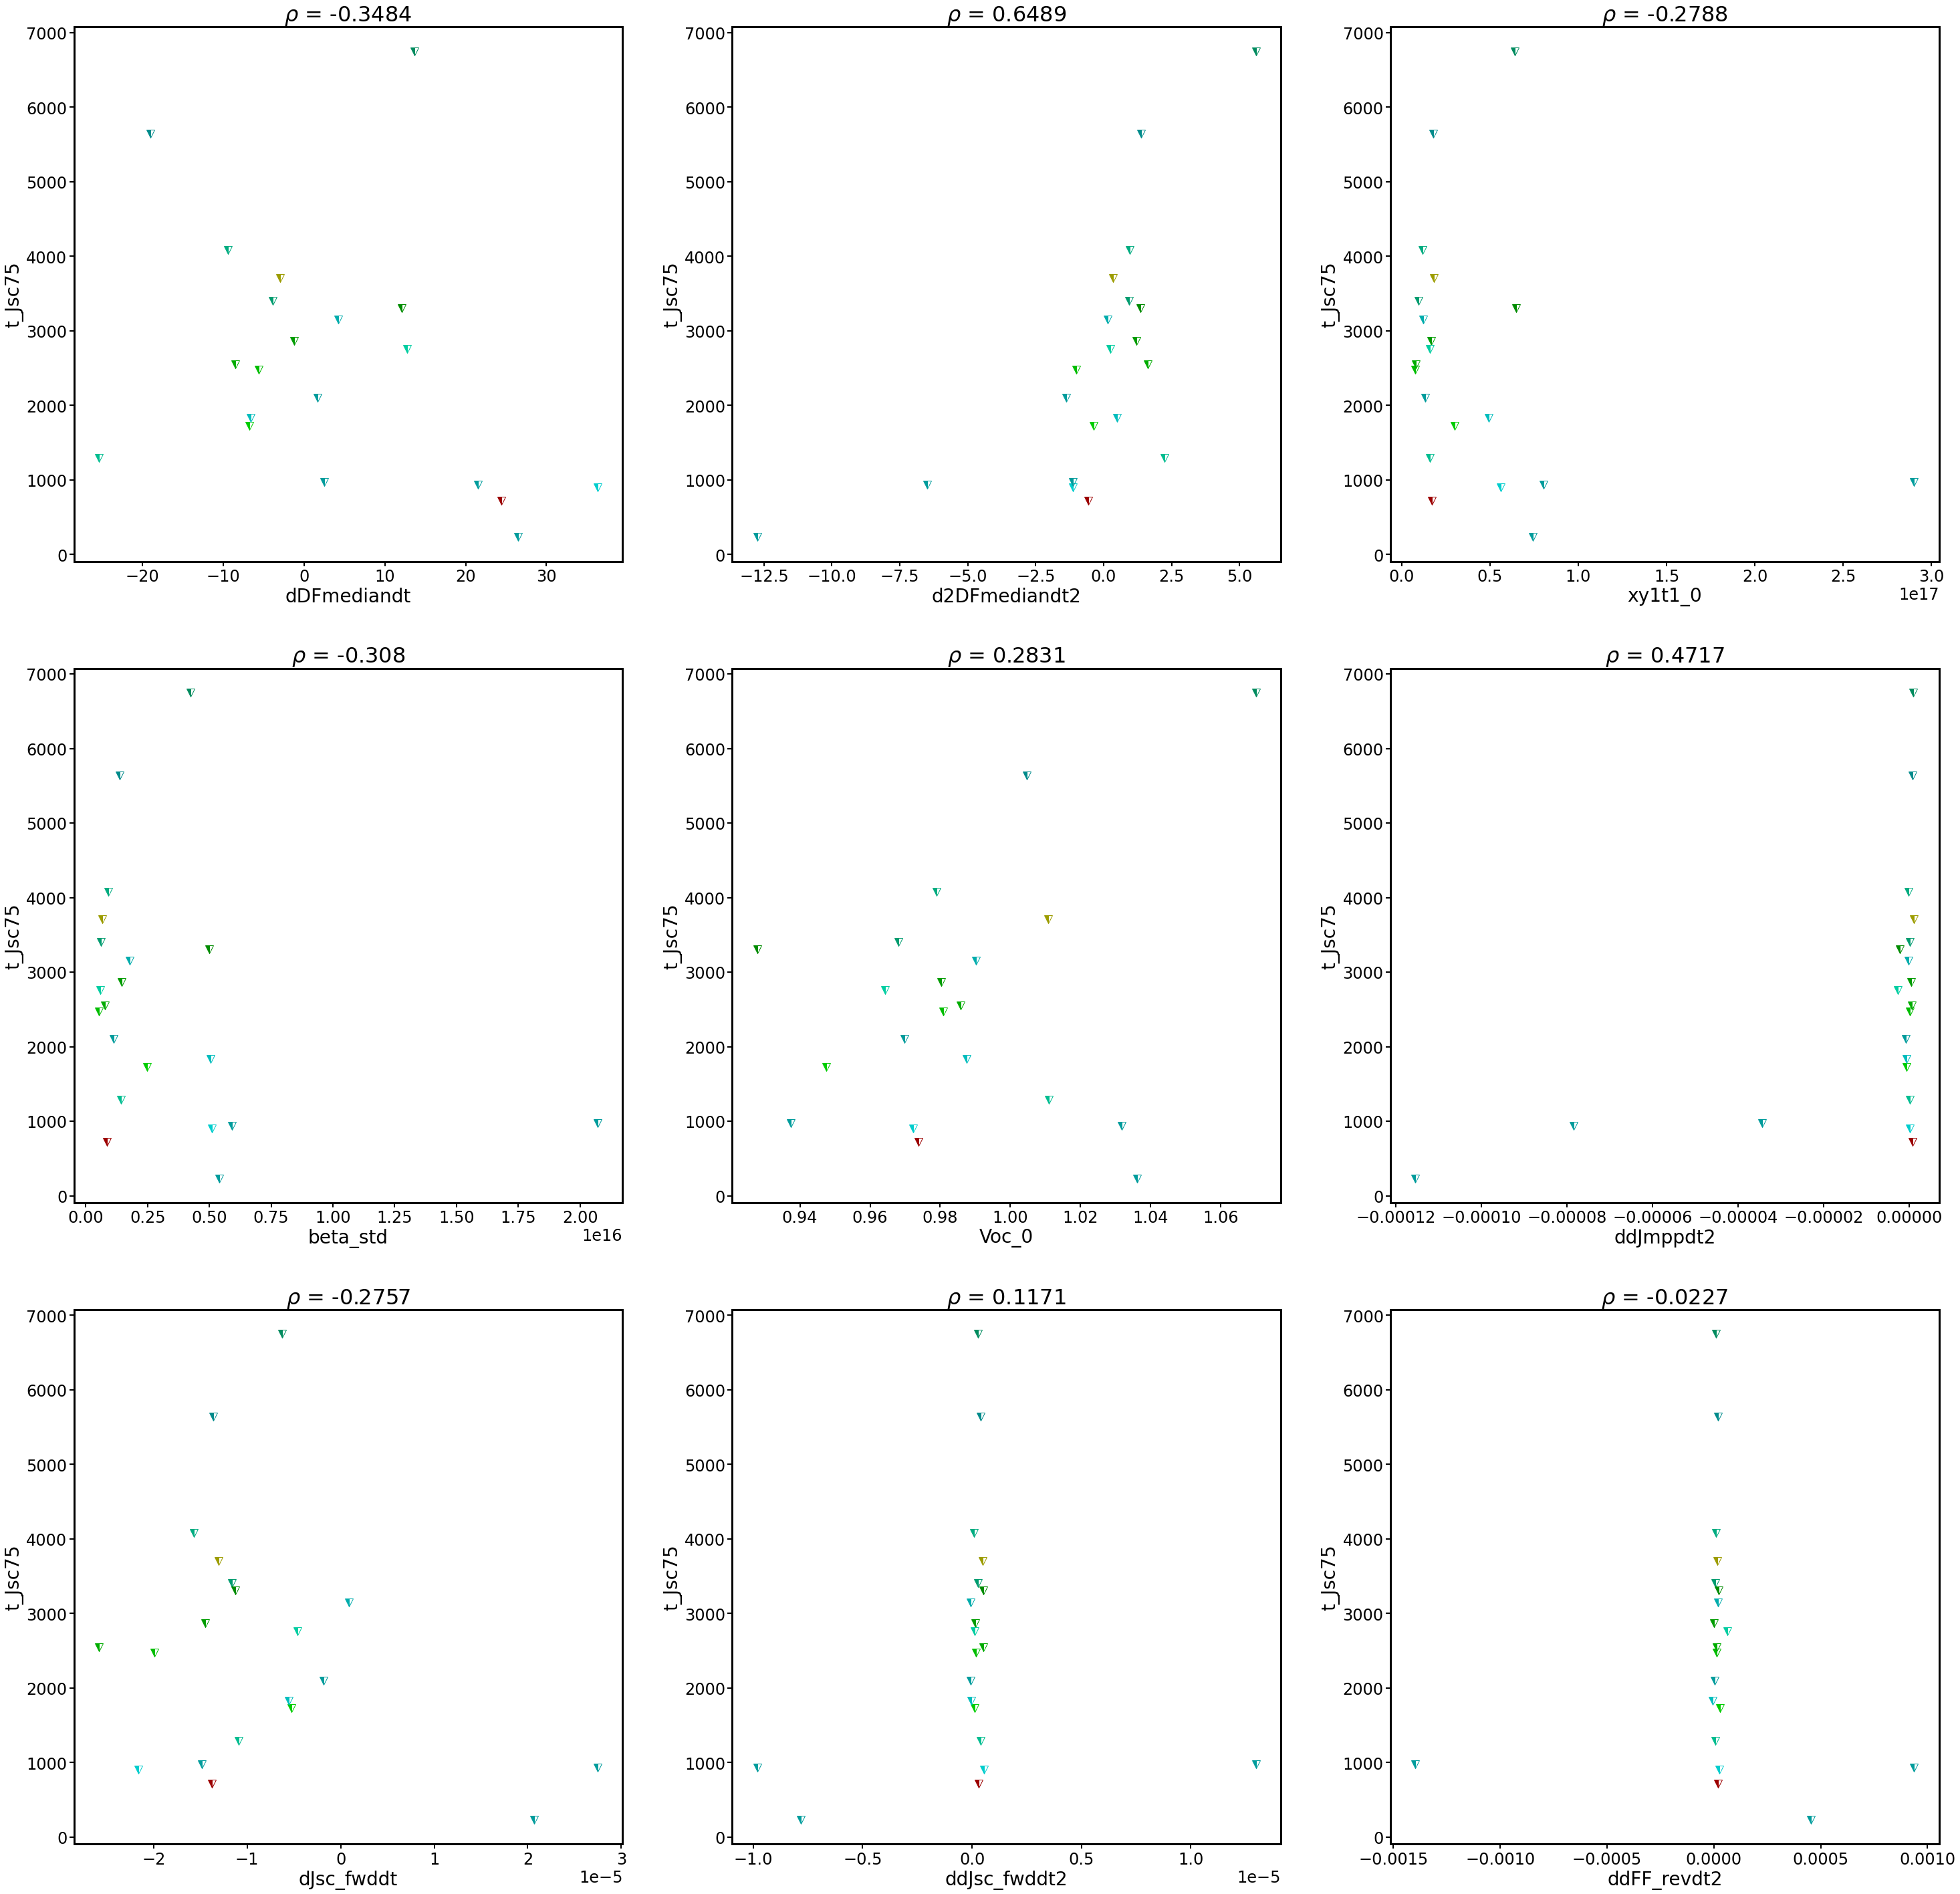

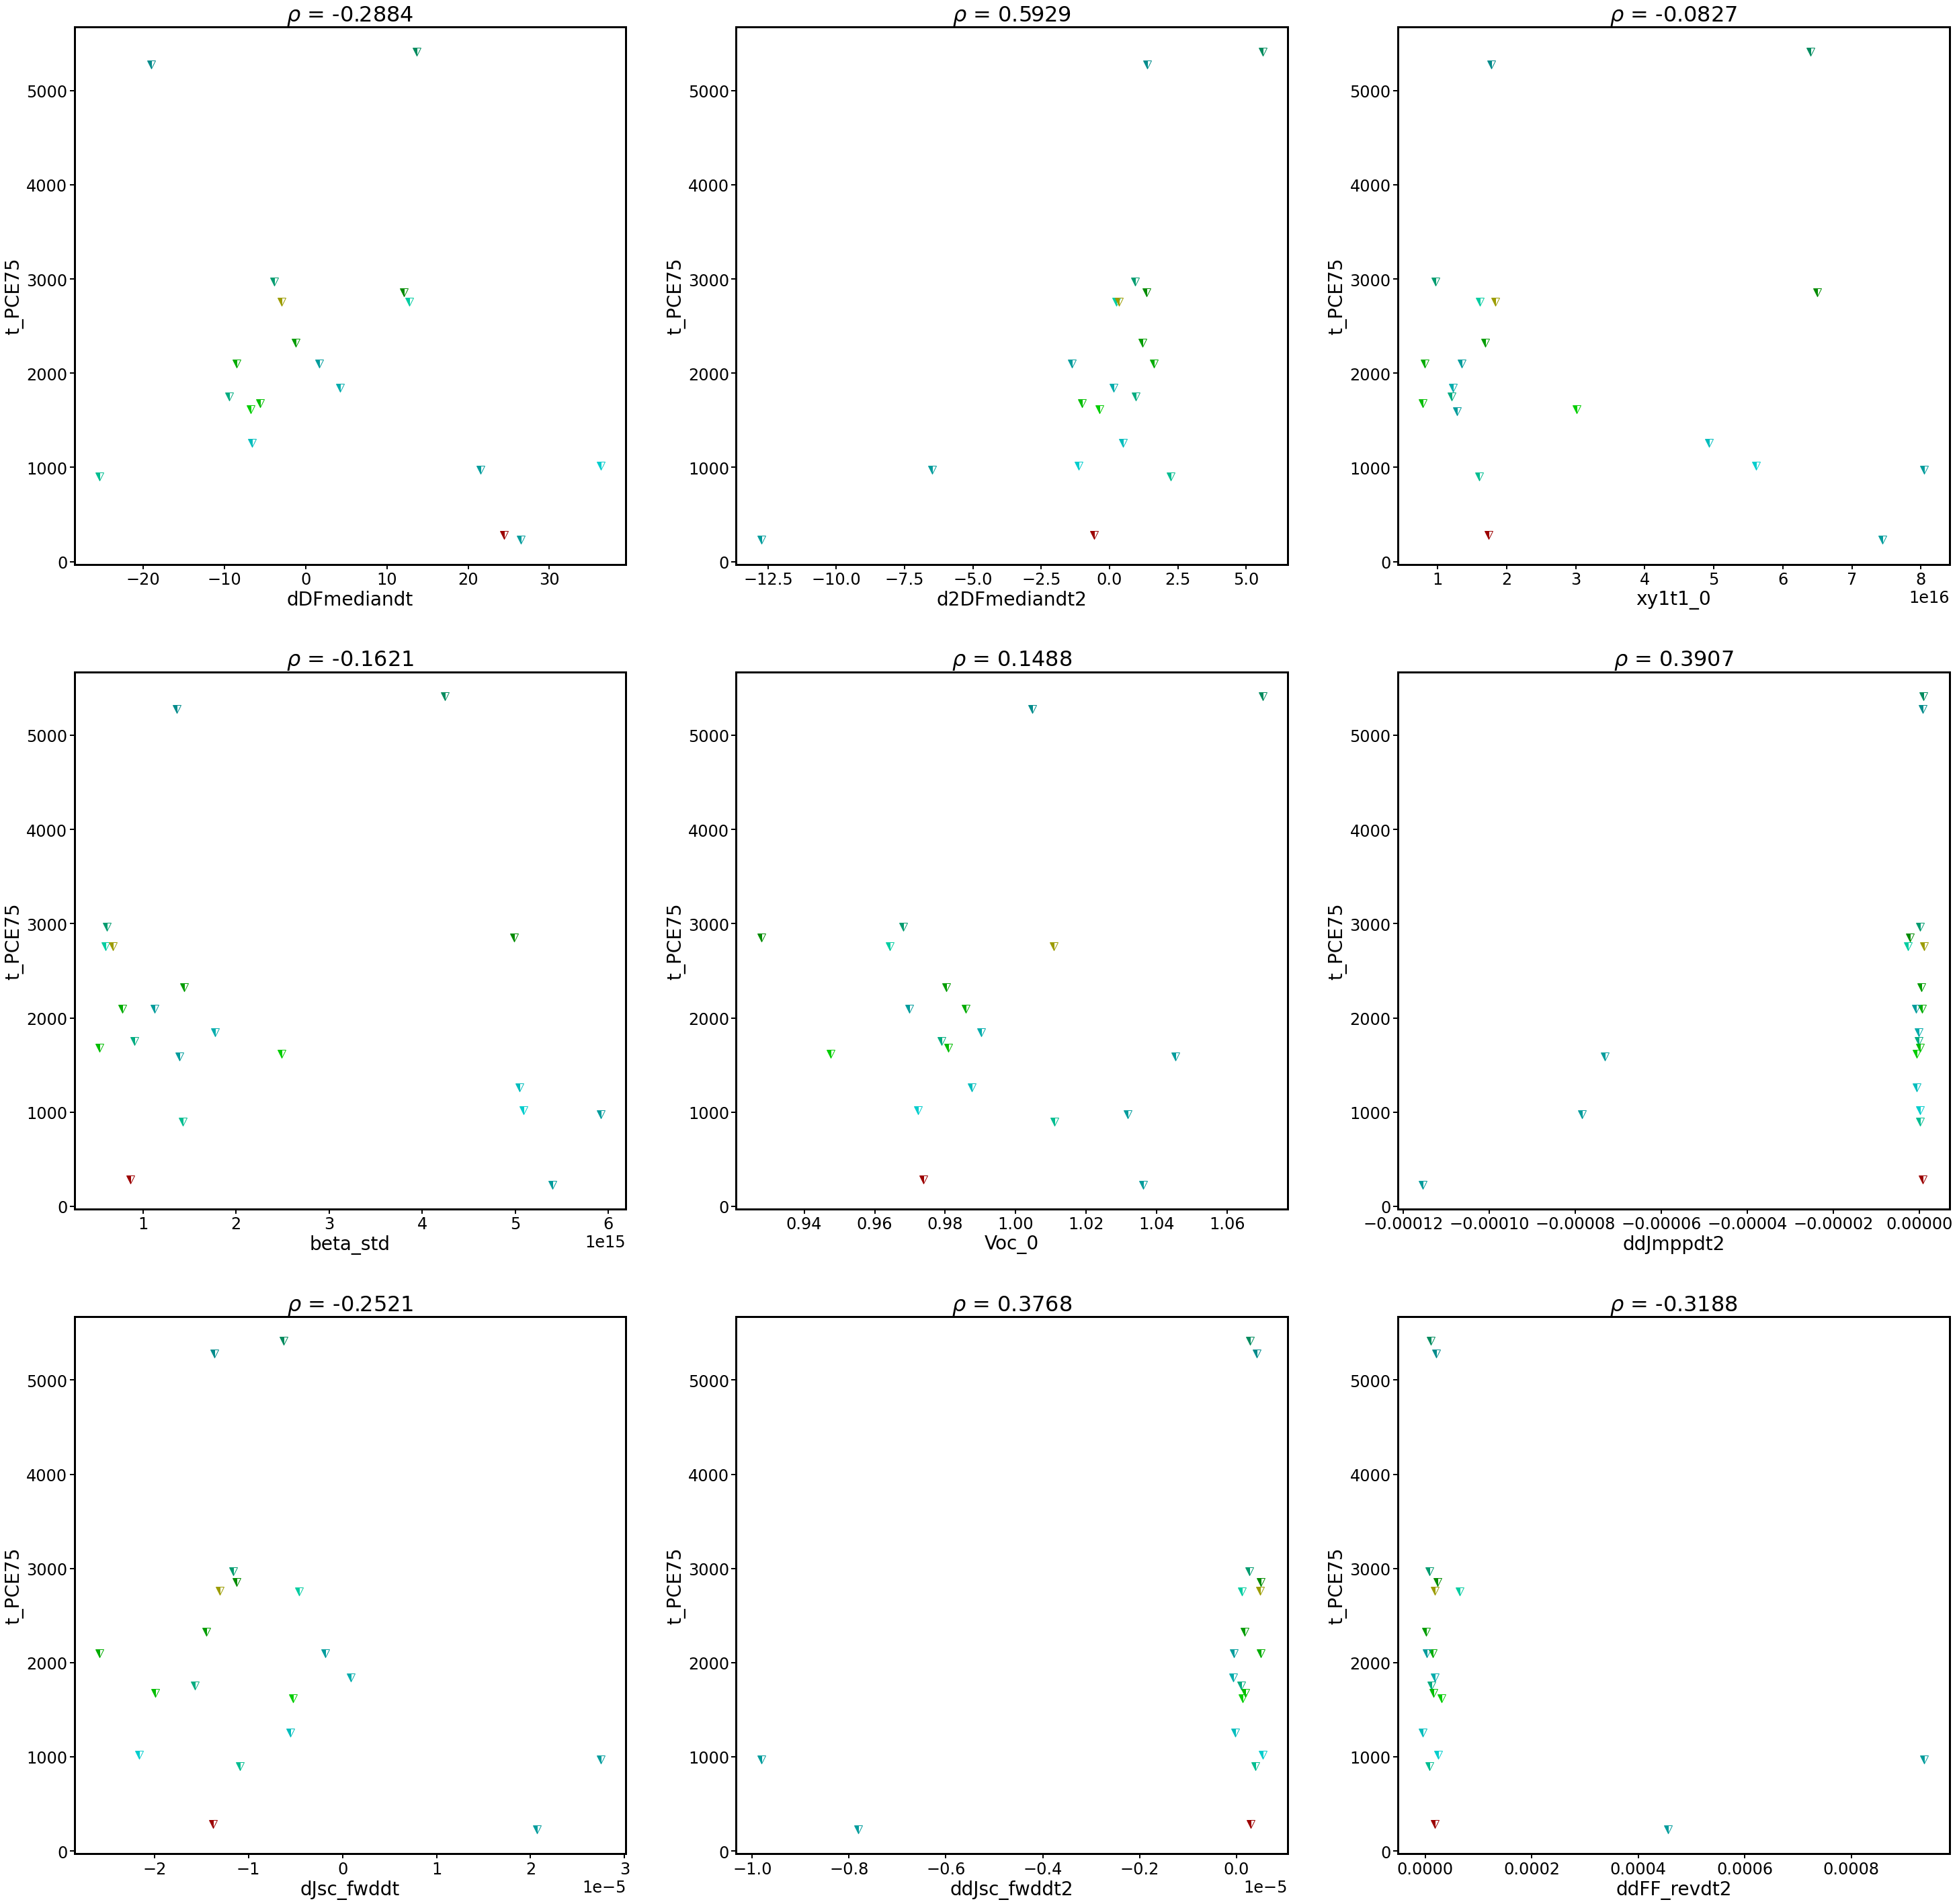

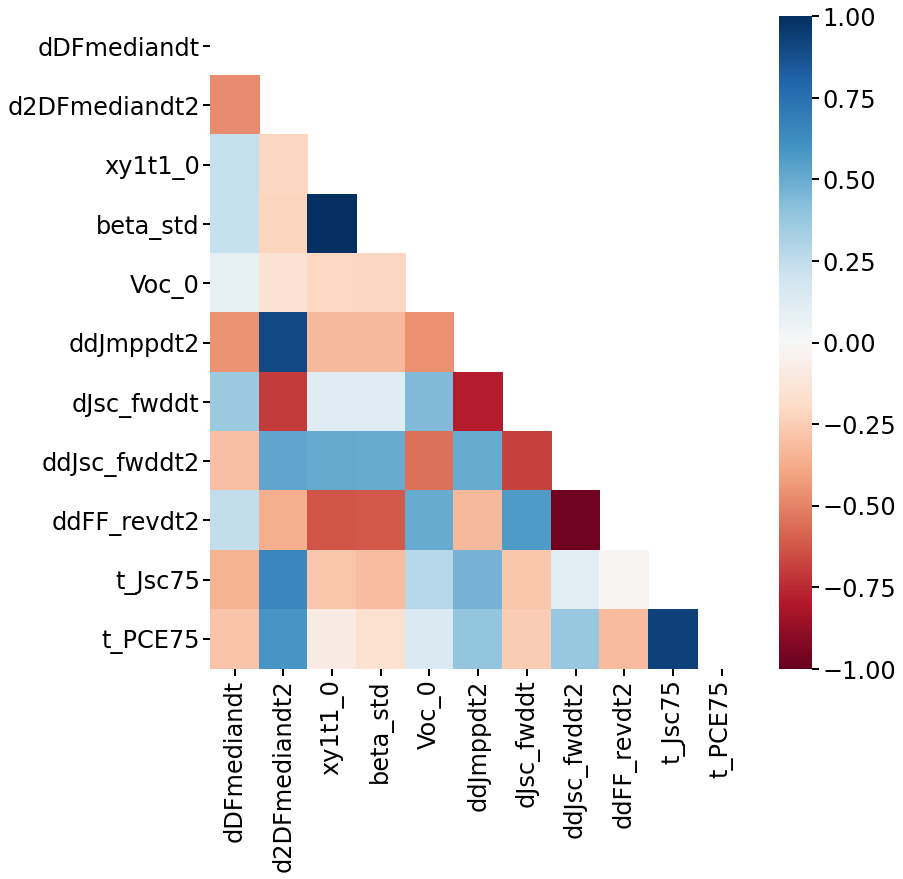

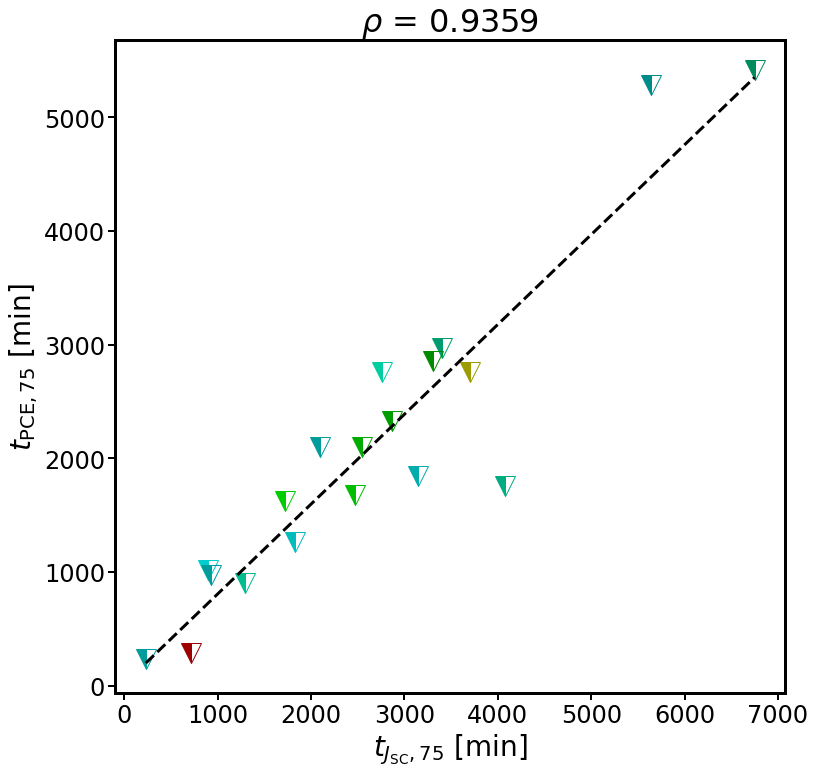

In [14]:
# In this cell, make pairwise plots of correlation between physics-inspired features versus the environmental and early-time features


# target features we want to predict (tLD80, etc.)
target_feats = ['t_Jsc75',
                't_PCE75',
             ]

# early-time measurements (PL, LD, transmittance, dark field...)
early_feats = ['dDFmediandt',
               'd2DFmediandt2',
               'xy1t1_0',
               'beta_std',
               'Voc_0',
               'ddJmppdt2',
               'dJsc_fwddt',
               'ddJsc_fwddt2',
               'ddFF_revdt2'              
              ]

# put all the non-physics-inspired features together
other_feats = early_feats

# loop over physics-inspired features
for p_feat in target_feats:
    
    # initialize the plot
    fig, ax = plt.subplots(3,3,figsize=(50,50))
    
    # loop over other features
    for jj,feat in enumerate(other_feats):
        
        # indicate which pane of the subplot to plot in            
        row = math.floor(jj/3)
        col = jj % 3
        
        # plot each point according to conditions
        for ii in range(len(rawdata_df)):

            # get environmental conditions
            T = rawdata_df['Temp (deg C)'].iloc[ii]
            RH = rawdata_df['RH (%)'].iloc[ii]
            pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
            N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
            xMA = rawdata_df['MA fraction'].iloc[ii]
            encap = 'none'
            # use environmental variables to define the plot style
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            # plot points
            ax[row,col].plot(rawdata_df[feat].iloc[ii],rawdata_df[p_feat].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
        # label axes
        ax[row,col].set_xlabel(feat)
        ax[row,col].set_ylabel(p_feat)
            
        # identify where NaNs occur in the dataset...
        nas = np.logical_or(np.isnan(rawdata_df[feat].values),np.isnan(rawdata_df[p_feat].values))
        # ... and do not use them for calculating the correlation coefficient
        r,_ = sp.stats.pearsonr(rawdata_df[feat].values[~nas],rawdata_df[p_feat].values[~nas])
        ax[row,col].set_title('$\\rho$ = ' + str(np.round(r,4)))

    
# now put all the features together
all_feats =  other_feats + target_feats 

# create list of fancy labels 
# all_feats_fancy = []
# for feat in all_feats:
#     all_feats_fancy.append(fancy_labels_dict[feat])

# take only the features of interest that are typically used for LD80 modeling
rawdata_df_reduced = rawdata_df.copy()[all_feats]

# initialize a figure for the correlation matrix
corr_fig = plt.figure(figsize=(12,12))
corr_Matrix = rawdata_df_reduced.corr() # calculate correlations...
mask = np.zeros_like(corr_Matrix)
mask[np.triu_indices_from(mask)] = True
# ...and plot them as a heatmap
sn.heatmap(corr_Matrix, 
           mask=mask,
           annot = False, 
           cmap = 'RdBu', 
           vmin = -1, 
           vmax = 1, 
#            xticklabels = ['$\mathrm{d}m_\mathrm{DF}/\mathrm{d}t$',
#                       '$\\sigma_{\\beta}$',
#                       '$\mathrm{d}^2J_\mathrm{MPP}/\mathrm{d}t^2$',
#                       '$t_{J_\mathrm{SC},75}$',
#                       '$t_\mathrm{PCE,75}$',
#            ],
#            yticklabels = ['$\mathrm{d}m_\mathrm{DF}/\mathrm{d}t$',
#                       '$\\sigma_{\\beta}$',
#                       '$\mathrm{d}^2J_\mathrm{MPP}/\mathrm{d}t^2$',
#                       '$t_{J_\mathrm{SC},75}$',
#                       '$t_\mathrm{PCE,75}$',
#            ]
          )



fig, ax = plt.subplots(figsize=(12,12))
for ii in range(len(rawdata_df)):

    # get environmental conditions
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    xMA = rawdata_df['MA fraction'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    # plot points
    ax.plot(rawdata_df['t_Jsc75'].iloc[ii],rawdata_df['t_PCE75'].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=20)
# label axes
ax.set_xlabel('$t_{J_\mathrm{SC},75}$ [min]')
ax.set_ylabel('$t_\mathrm{PCE,75}$ [min]')




# identify where NaNs occur in the dataset...
nas = np.logical_or(np.isnan(rawdata_df['t_Jsc75'].values),np.isnan(rawdata_df['t_PCE75'].values))
# ... and do not use them for calculating the correlation coefficient
r,_ = sp.stats.pearsonr(rawdata_df['t_Jsc75'].values[~nas],rawdata_df['t_PCE75'].values[~nas])
ax.set_title('$\\rho$ = ' + str(np.round(r,4)))

# log_fit = np.polyfit(np.log(rawdata_df['t_Jsc75'].values[~nas]),np.log(rawdata_df['t_PCE75'].values[~nas]),1)
# tJsc_range = np.linspace(np.min(rawdata_df['t_Jsc75']),np.max(rawdata_df['t_Jsc75']),num=101)
# ax.plot(tJsc_range,np.exp(log_fit[1])*tJsc_range**log_fit[0],'k--')

lin_fit = np.polyfit(rawdata_df['t_Jsc75'].values[~nas],rawdata_df['t_PCE75'].values[~nas],1)
tJsc_range = np.linspace(np.min(rawdata_df['t_Jsc75']),np.max(rawdata_df['t_Jsc75']),num=101)
ax.plot(tJsc_range,lin_fit[1] + tJsc_range*lin_fit[0],'k--')

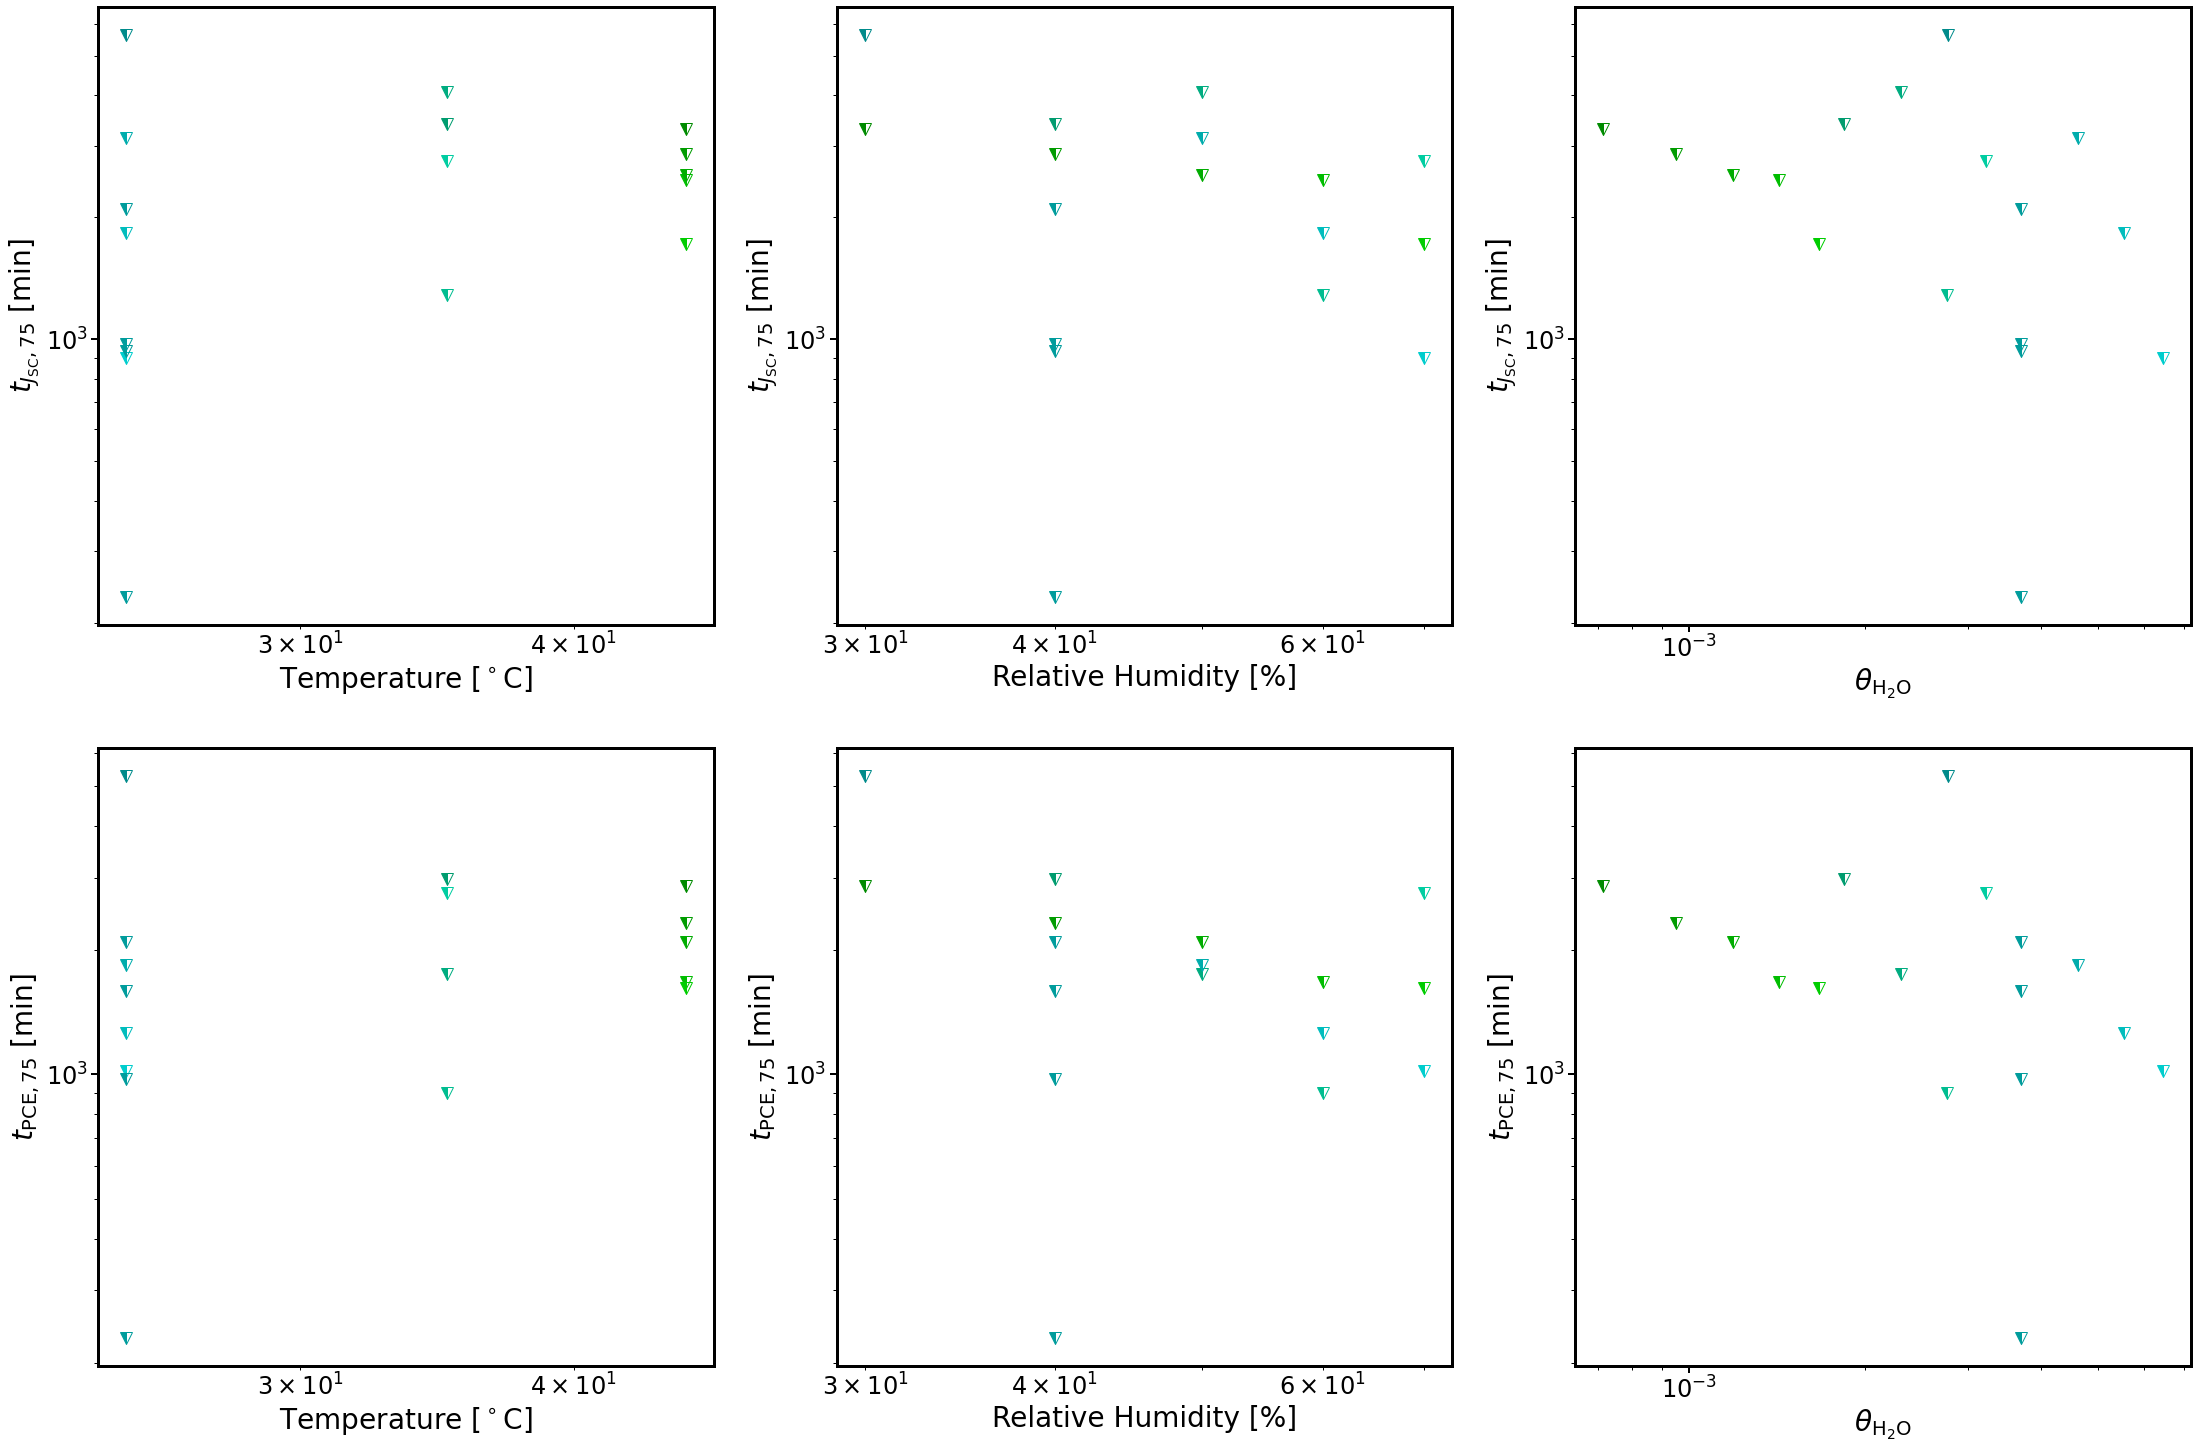

In [6]:

 
# target features we want to predict (tLD80, etc.)
target_feats = ['t_Jsc75',
                't_PCE75',
                #'dDFmediandt'
             ]

target_dict = {'t_Jsc75':'$t_{J_\mathrm{SC},75}$ [min]',
                't_PCE75':'$t_{\mathrm{PCE},75}$ [min]',
               'dDFmediandt':'$\mathrm{d}\mu_\mathrm{DF}/\mathrm{d}t \mathrm{[min^{-1}]}$'}



# put all the non-physics-inspired features together
other_feats = ['Temp (deg C)',
               'RH (%)',
               'LAI_H2O']

other_dict = {'Temp (deg C)':'Temperature $\mathrm{[^\circ C]}$',
              'RH (%)':'Relative Humidity [%]',
              'LAI_H2O':'$\\theta_\mathrm{H_2O}$' 
             }

fig, ax = plt.subplots(len(target_feats),len(other_feats),figsize=(len(other_feats)*12.5,len(target_feats)*12.5))

for kk, t_feat in enumerate(target_feats):
    for jj, o_feat in enumerate(other_feats):
        for ii in range(len(rawdata_df)):

            # get environmental conditions
            T = rawdata_df['Temp (deg C)'].iloc[ii]
            RH = rawdata_df['RH (%)'].iloc[ii]
            pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
            N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
            xMA = rawdata_df['MA fraction'].iloc[ii]
            encap = 'none'
            # use environmental variables to define the plot style
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            # plot points
            ax[kk,jj].loglog(rawdata_df[o_feat].iloc[ii],rawdata_df[t_feat].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
        # label axes
        ax[kk,jj].set_xlabel(other_dict[o_feat])
        ax[kk,jj].set_ylabel(target_dict[t_feat])

# 5. Feature Pre-Selection

In this cell, set up the machine learning task by deciding which of the above attributes to use as the response (i.e., variable to predict) and which to use as the features and which to ignore. It is also possible to construct interaction-related features, such as those between environment and composition.

In [21]:
# change to True if using a log transform on the response
Log_transform = True

# change to True if recalculating coefficients after regularization
unshrink_coefficients = False

# choose the feature to use as the response
response = 't_PCE75'
#response = 't_Jsc75'



# Features to use, for historical reasons termed "Ryan features"
Ryan_features = [
               'dDFmediandt',
#               'd2DFmediandt2',
               'xy1t1_0',
#                'xy0t1_0',
#               'beta_std',
#               'ln_xy1t1',
#               'Voc_0',
#              'ddJmppdt2',
             'dVmppdt',
#              'dJsc_fwddt',
#               'ddJsc_fwddt2',
#               'ddFF_revdt2',
#                't_Jsc75'
                ]

""" Good for JSC:
Ryan_features = [
               'dDFmediandt',
               'xy1t1_0',
              'dVmppdt',
                ]
"""

""" Good for PCE:
Ryan_features = [
               'dDFmediandt',
               'xy1t1_0',
              'dVmppdt',
                ]
"""

# full dataset: features + response
terms_to_keep = Ryan_features + [response]

# make a copy of the dataframe so that irrelevant responses can be removed
coded_df = rawdata_df.copy()
print('Number of Runs Total:',len(coded_df))

# If what we are trying to predict is a failure time (e.g., tLD75, tPL10, etc.),
# throw out runs that fail before the prediction interval has finished
# or all runs that take 10 min or less
#if response[0] == 't':
#    coded_df = coded_df[coded_df['pred_horiz']*5.0/6.0 < coded_df[response]]
#    #coded_df = coded_df[10 <= coded_df[response]]
#print('Number of Runs That Fail After Prediction Horizon:',len(coded_df))

# drop responses that we're not interested in
cols_to_drop = diff(list(coded_df.columns),terms_to_keep)
coded_df = coded_df.drop(columns=cols_to_drop)


# drop rows containing NaNs
coded_df = coded_df.dropna(axis=0)

# display the modeling-ready dataset head    
coded_df

Number of Runs Total: 18


xy1t1_0  dDFmediandt       dVmppdt  t_PCE75
0   9.649158e+15    -3.866667  2.666667e-04   2970.0
1   1.203461e+16    -9.466667  1.333333e-04   1755.0
3   7.875237e+15    -5.600000  3.333333e-04   1680.0
4   8.170481e+15    -8.533333  6.666667e-04   2100.0
6   1.691187e+16    -1.266667  3.333333e-04   2325.0
7   1.778139e+16   -19.000000  8.666667e-04   5280.0
8   5.611574e+16    36.333333  5.333333e-04   1020.0
9   3.014138e+16    -6.800000  7.333333e-04   1620.0
10  1.601512e+16   -25.400000  6.666667e-04    900.0
11  6.502522e+16    12.066667  1.200000e-03   2856.0
12  1.614559e+16    12.766667  4.666667e-04   2758.0
13  7.440002e+16    26.500000 -1.500000e-03    230.0
15  8.050030e+16    21.500000  5.000000e-04    975.0
17  1.225727e+16     4.266667 -4.053961e-18   1845.0
18  1.352359e+16     1.666667  4.000000e-04   2100.0
19  4.935014e+16    -6.600000  4.000000e-04   1260.0


# 6. Modeling

In this cell, the machine learning model is initialized and trained. Error metrics and coefficients are calculated and tabulated for visualization in the cells below.

Status: about 0.0% complete...
{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.001}
Status: about 62.5% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.003981071705534973}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}
For test set:
Mean of Mean Absolute Error = 4.8 %
Median of Mean Absolute Error = 3.2 %
Std. Dev. of Mean Absolute Error = 4.7 %
Mean of Mean Absolute Error = 0.354
Median of Mean Absolute Error = 0.242
Std. Dev. of Mean Absolute Error = 0.338
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 3.5 %
Median of Mean Absolute Error = 3.5 %
Std. Dev. of Mean Absolute Error = 0.1 %
Mean of Mean Absolute Error = 0.265
Median of Mean Absolute Error = 0.262
Std. Dev. of Mean Absolute Error = 0.007
Mean R2 = 0.7132
Median R2 = 0.7202
Std Dev. R2 = 0.0146
Mean Linear Error = 42.0 %
Median Linear Error = 25.0 %
Index of Median Model: 3


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
<ipython-input-22-a02445c01cf0>:295: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


{'alpha': 0.01584893192461114}


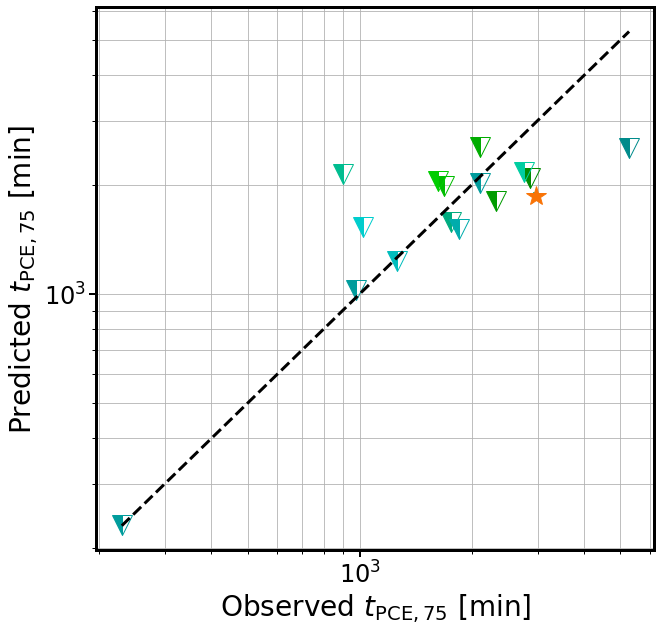

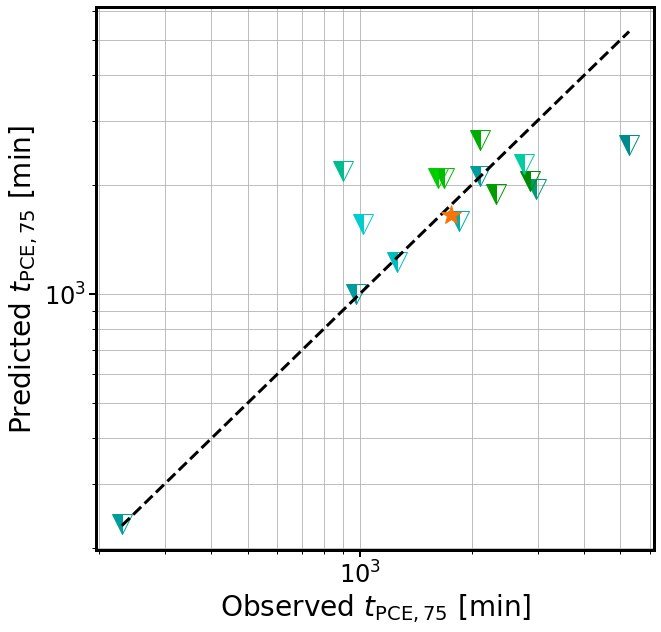

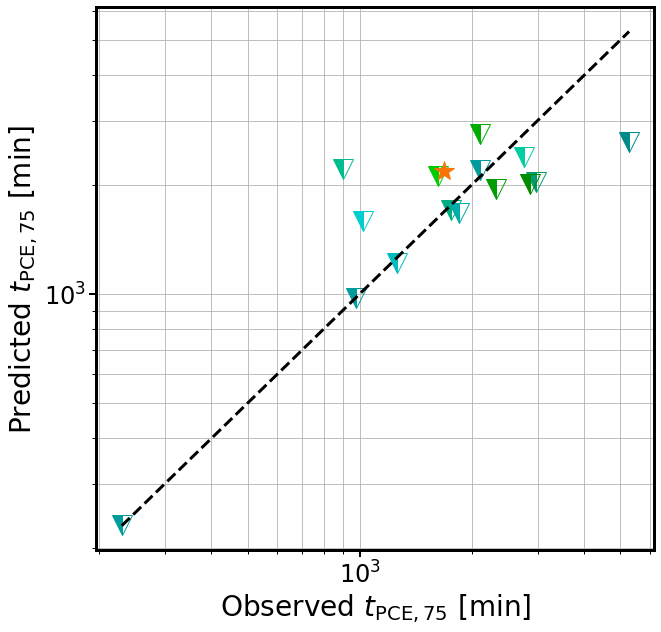

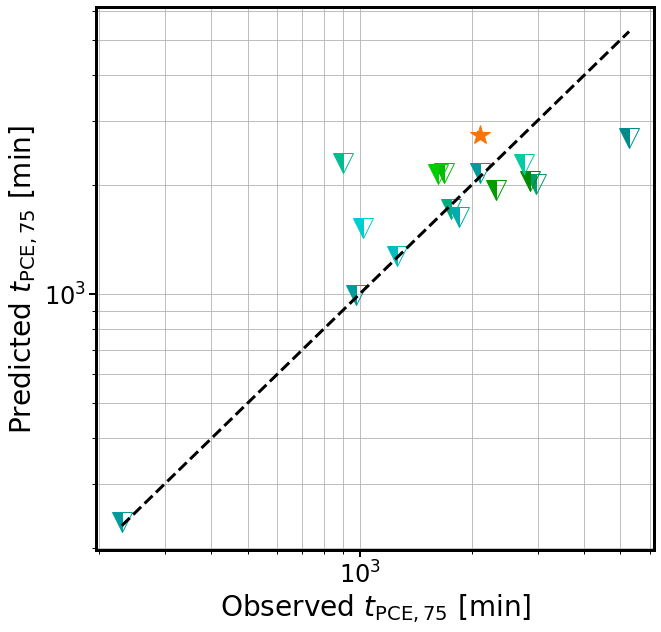

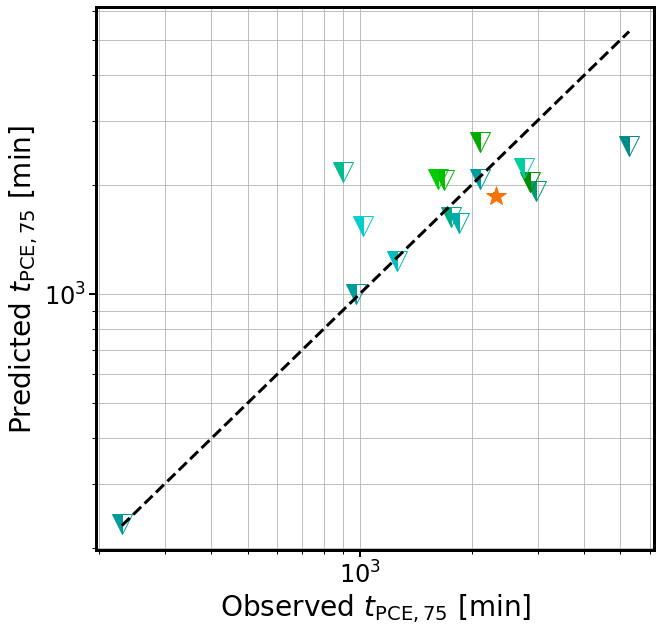

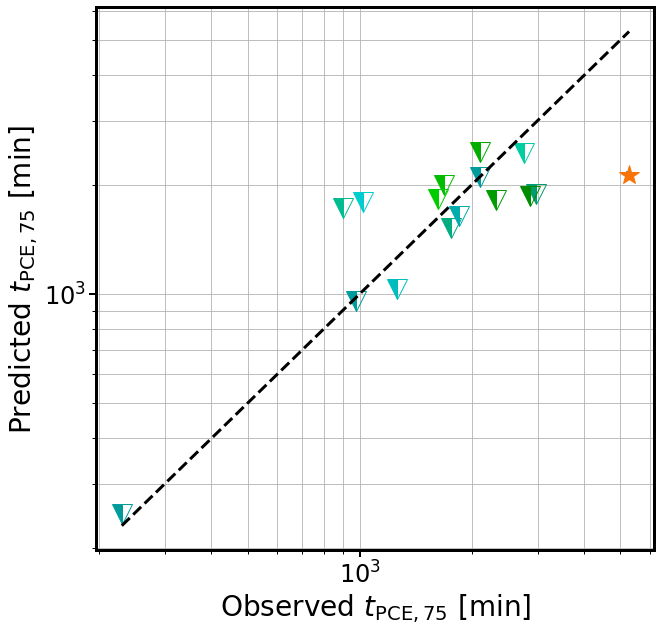

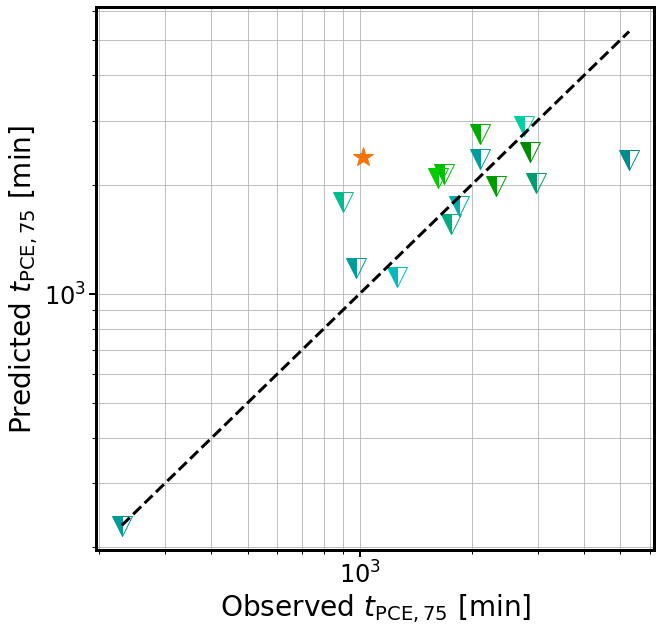

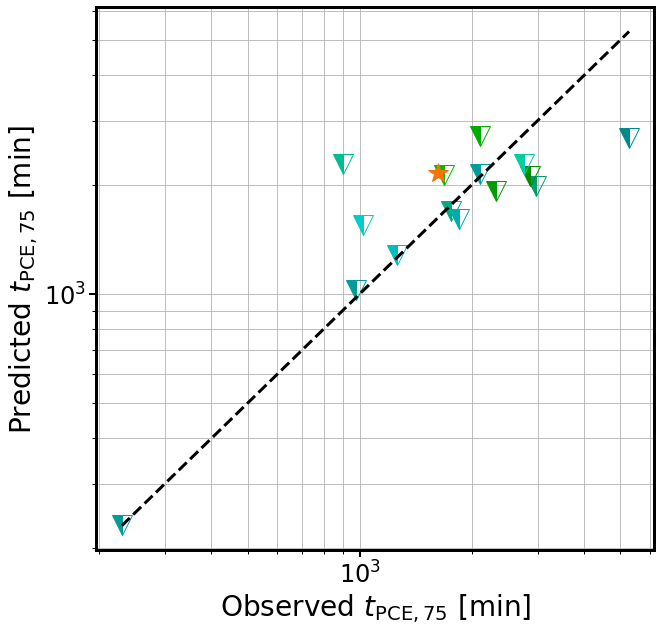

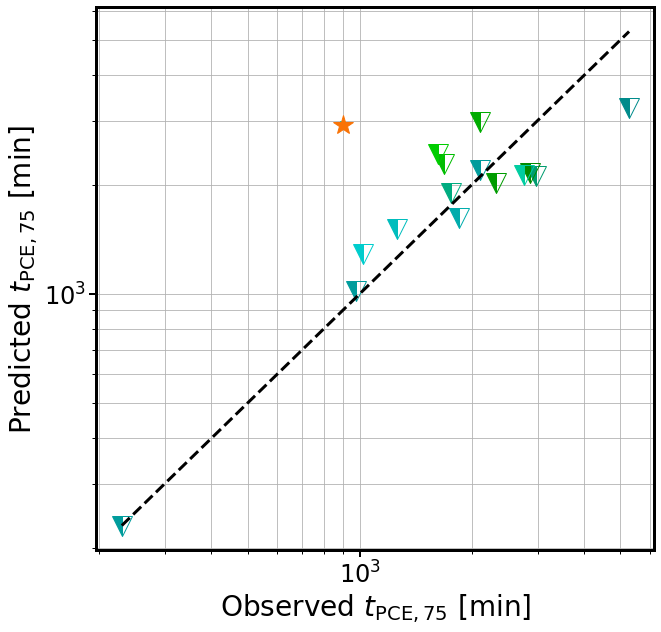

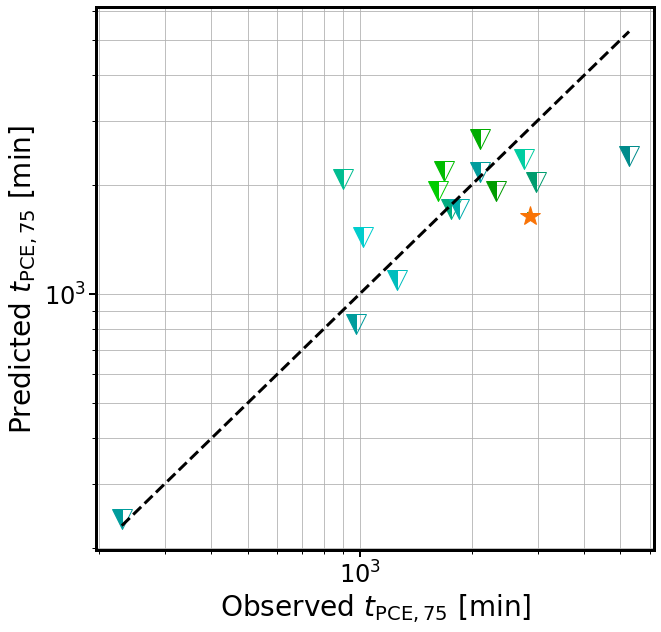

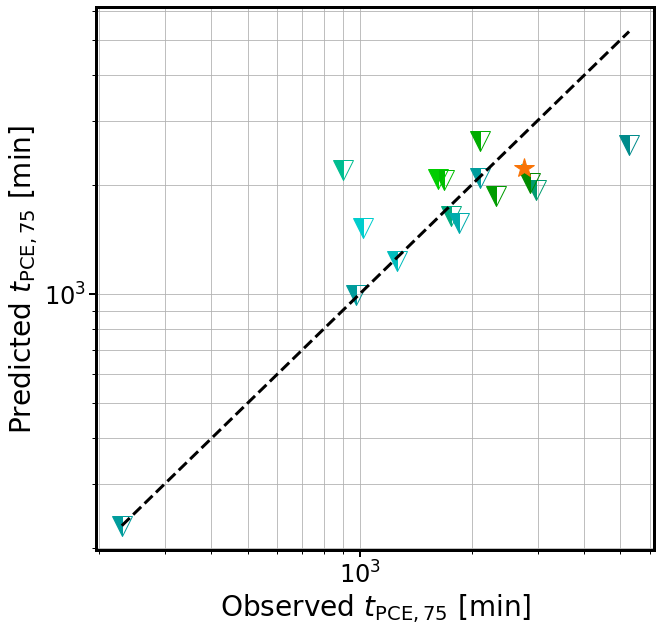

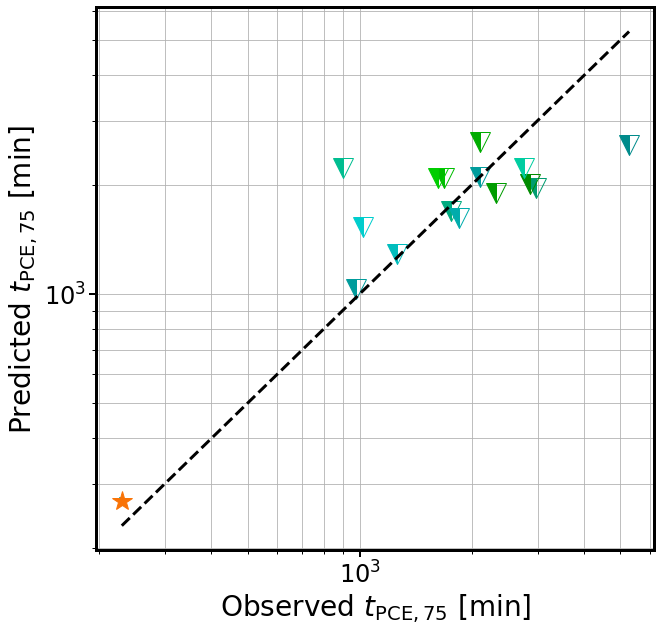

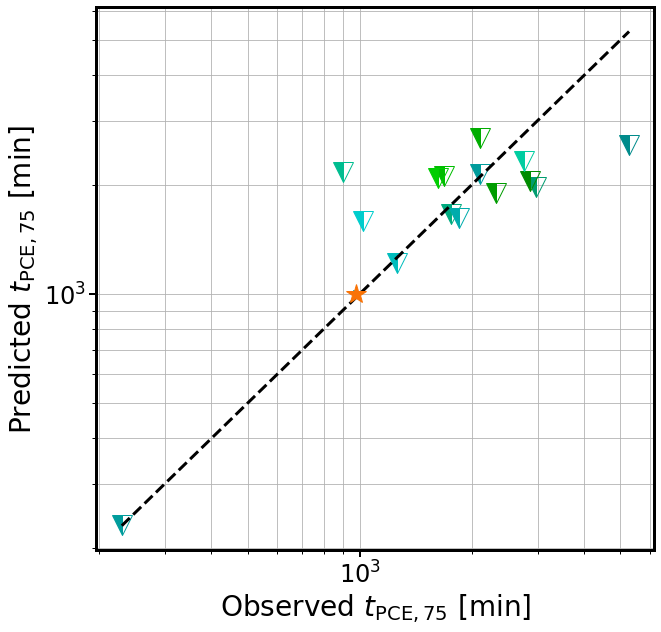

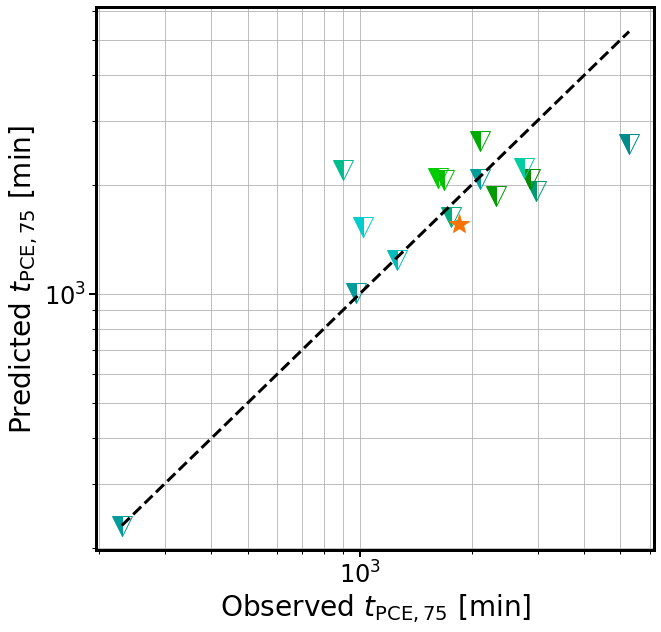

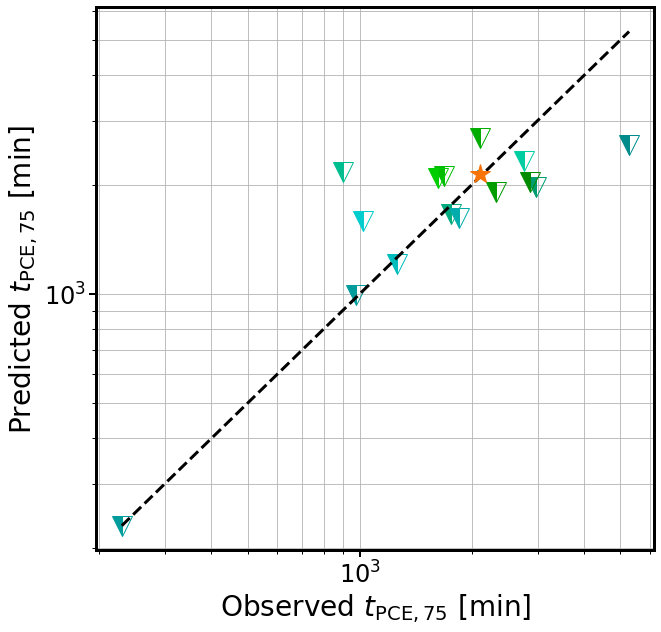

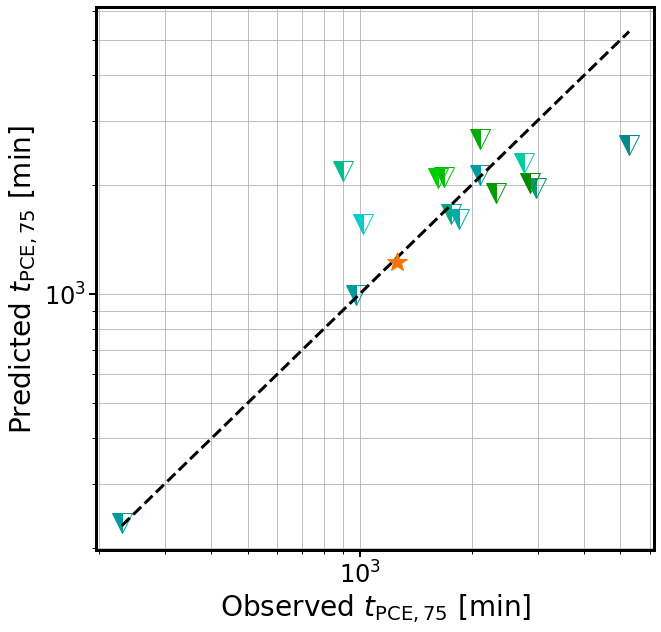

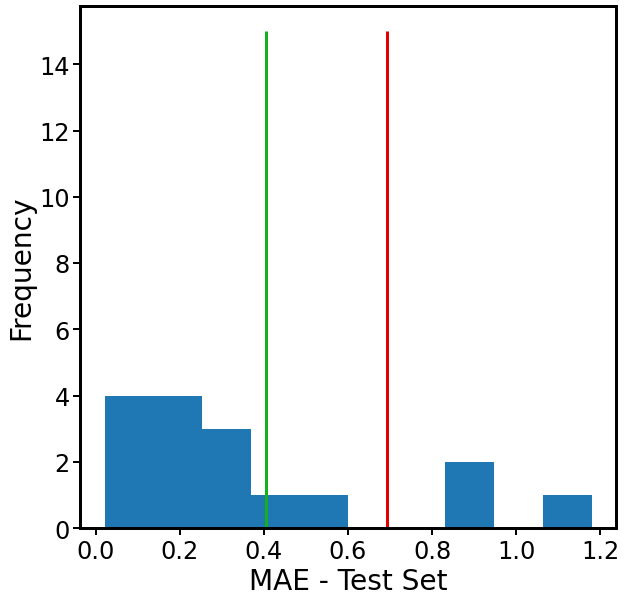

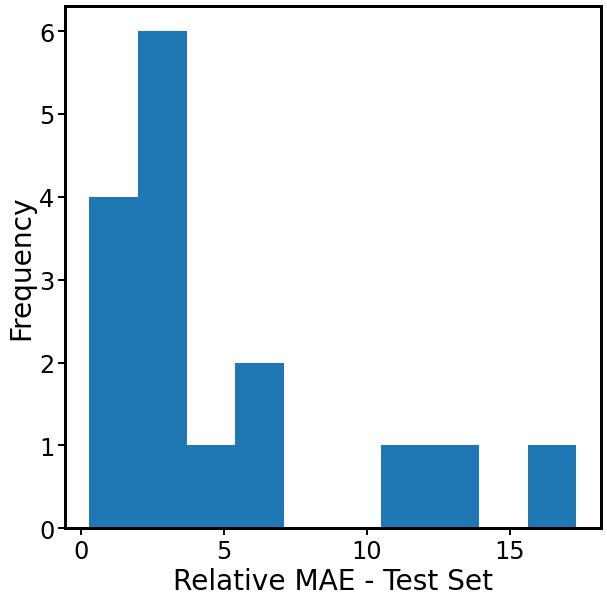

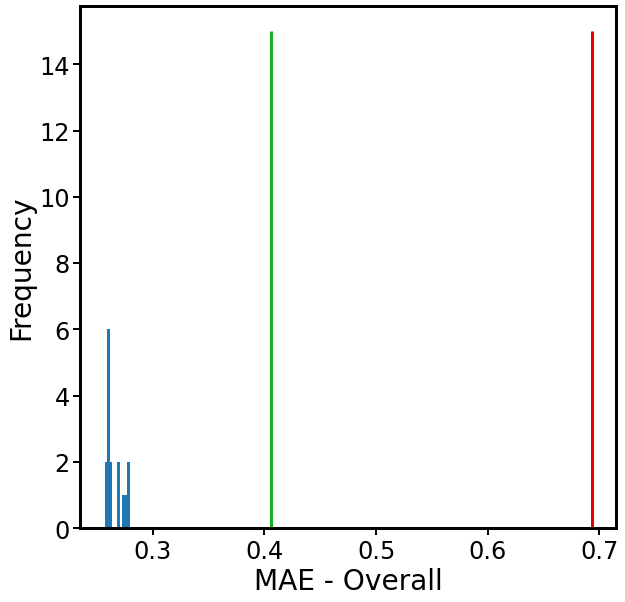

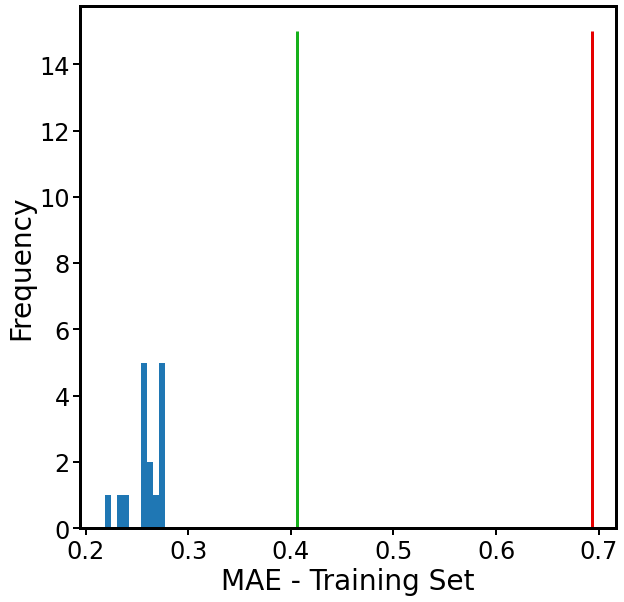

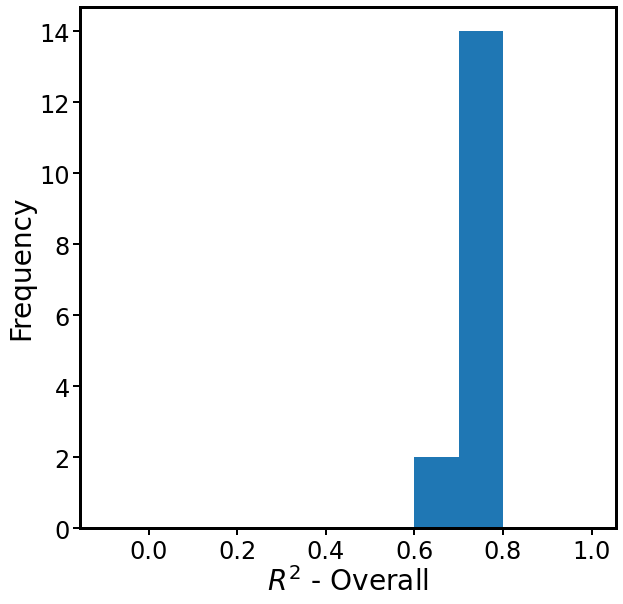

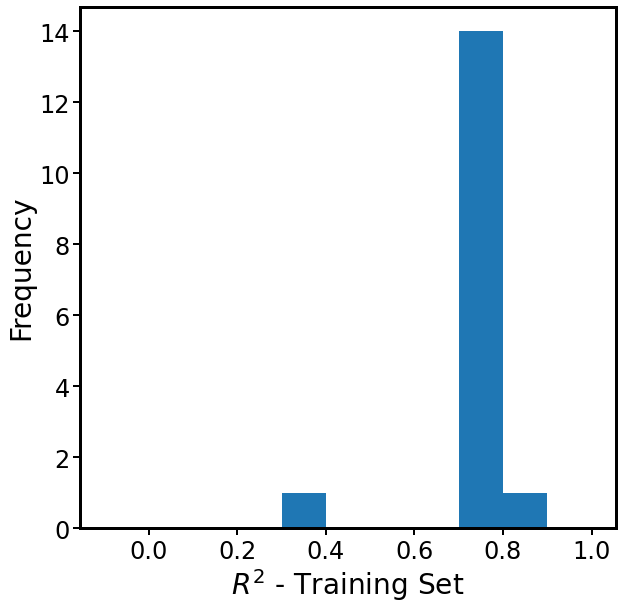

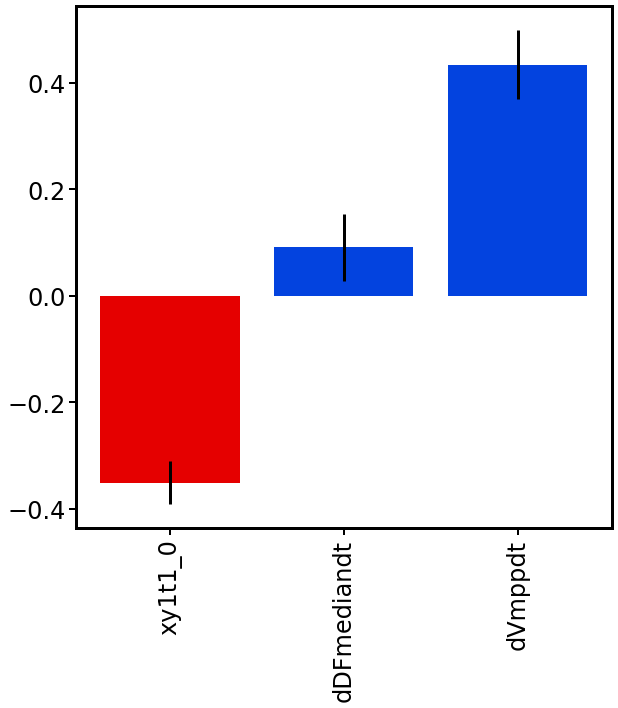

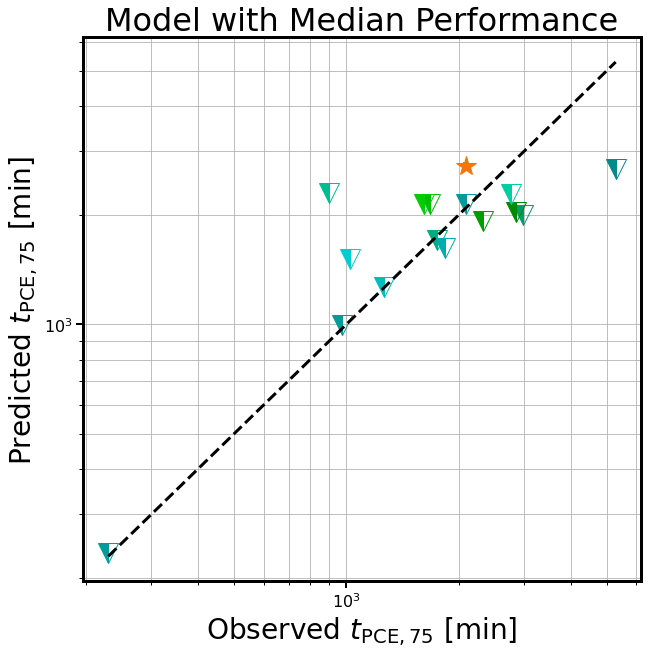

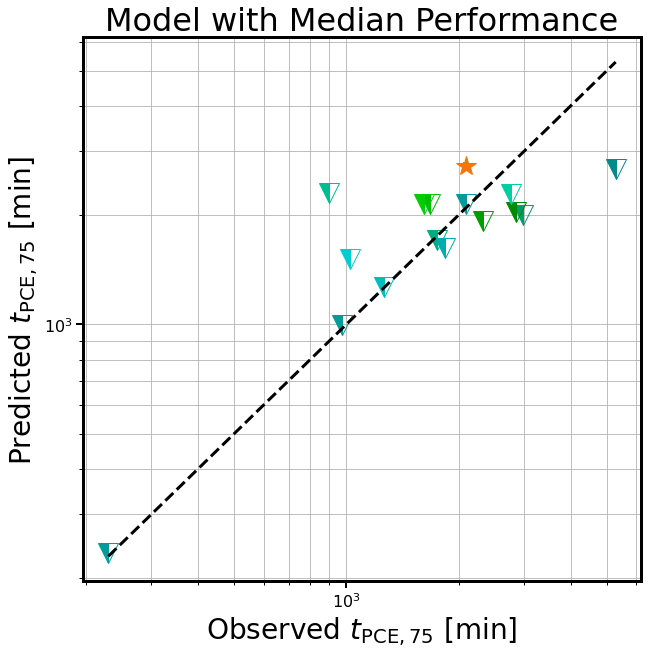

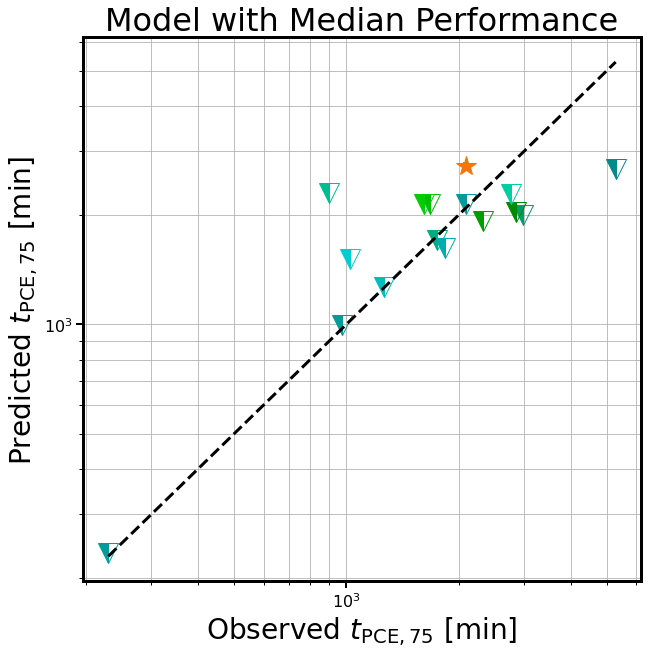

In [22]:
# try some machine learning in this cell - LASSO with leave one out testing [test cell]
# DISCLAIMER: be very careful when mixing pandas and sklearn - some of the canned functions from sklearn take in 
# DataFrames but spit out arrays. Indexing can become a mess if rows have been removed from the DF during data cleaning
# because the indices will no longer sync up between the DFs and the output array. (This can happen when using the 
# .dropna() method to remove runs that do not go to LD,75, for instance.) 

# first determine whether to do a log transform on the response or not, 
# then partition the data into features (X) and response (Y) DFs


if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset - for leave-one-out testing this is the size of the dataset
n_trials = len(Y)

# set up search parameters for cross-validation, which will be used to select the hyperparameter
param_vals = np.logspace(-3,3,num=31) # range of hyperparameters to test
parameters = {'alpha': param_vals}
model = Lasso(max_iter=1e9) # model to implement - LASSO, Ridge, etc.
#metric = 'neg_mean_squared_error' # scoring metric - MSE, R2, etc.
metric = 'neg_mean_absolute_error'
#metric = 'r2'
folds = n_trials-1 # how many folds to do in k-fold cross-validation - 5 is standard
#folds = 10

# initialize error metrics for test set...
R2 = np.zeros(n_trials) # coefficient of determination
RMSE = np.zeros(n_trials) # RMS error
MAE_pct = np.zeros(n_trials) # mean absolute error, percent
MAE_pct_signed = np.zeros(n_trials) # mean absolute error, percent with sign
MAE = np.zeros(n_trials) # mean absolute error

# ...and for the whole dataset...
MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
MAE_overall = np.zeros(n_trials) # mean absolute error, percent
R2_overall = np.zeros(n_trials) # coefficient of determination

# ...and for the training set
MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
MAE_train = np.zeros(n_trials) # mean absolute error, percent
R2_train = np.zeros(n_trials) # coefficient of determination

# error on linear scale (only relevant if log transform is used on response, but we do this a lot)
linear_error = np.zeros(n_trials)

# initialize a dataframe to keep track of model coefficients on every iteration of the test set loop
coeffs_df = pd.DataFrame(columns=coded_df.drop(columns=response).columns)
# keep track of Shapley values too
Shap_vals_df =  pd.DataFrame(columns=coded_df.drop(columns=response).columns)
# keep track of *change in* error with feature deleted relative to model with the full feature set
d_error_missing_feats = []

# outer loop: hold one sample out for testing every iteration
for kk in range(n_trials):
    
    if kk%10 == 0:
        print('Status: about ' + str(np.round(kk/n_trials * 100,2)) + '% complete...')
    
    # do test/train split by pulling out one row at a time form the feature and response DFs
    # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
    # ALSO: COPY THE SUBSETS Of THE DATAFRAMES or the values in the source will change and the 
    # prediction will be unstable and the whole thing will be ruined
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of each feature in the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold
    
    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)
    
    # print winning HP value if desired...
    print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']
    
    # ...and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)
    
    # if desired, recalculate the coefficients:
    if unshrink_coefficients:
        
        # figure out which coefficients survived
        surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]
        
        # make a copy of the training set with rejected coefficients stripped out
        X_red = X_train.copy()
        X_red = X_red[surviving_coeffs]
        X_whold_red = X_whold.copy()
        X_whold_red = X_whold_red[surviving_coeffs]
        # retrain the final model
        
        # train a simple linear regression
        shrunk_model = sklearn.linear_model.LinearRegression()
        shrunk_model.fit(X_red,y_train)
        
        # and fit the data
        ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
        ytpred=shrunk_model.predict(X_red)
    
    else:
        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)
    
    # calculate error metrics on test set
    RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
    R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
    MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
    MAE_pct_signed[kk] = (y_whold-ypred)/y_whold*100
    MAE[kk] = np.mean(np.abs(y_whold-ypred))
    
    # put the whole dataset back together (note that this will create arrays, not DFs)
    y_net = np.concatenate([y_train,y_whold])
    y_pred_net = np.concatenate([ytpred,ypred])
    
    # calculate error metrics on entire set
    R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
    MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
    MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)
    
    # calculate error metrics on training set
    R2_train[kk] = metrics.r2_score(y_train, ytpred)
    MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
    MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)
    
    # calculate linear error metric
    linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100
    
    # plot training data with markers corresponding to environmental + compositional conditions
    if kk%1 == 0: # only do this for a few models to save memory
        
        plt.figure(figsize=(10,10))
        for ii in range(len(y_train)):
            idx = y_train.index[ii] # pull the corresponding index in the DF
            T = rawdata_df['Temp (deg C)'][idx] # get temperature
            RH = rawdata_df['RH (%)'][idx] # get relative humidity
            pct_O2 = rawdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
            N_suns_stress = rawdata_df['Illum (Nsuns)'][idx] # get illumination
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            MA_frac = rawdata_df['MA fraction'][idx] # get composition
            # and plot
            if Log_transform:
                plt.loglog(np.exp(y_train.loc[idx]),np.exp(ytpred[ii]),color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
            else:
                plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
            #plt.text(y_train.loc[idx],ytpred[ii],idx) # ERROR checking: plot the index value
            
        # plot perfect prediction line and +/-50% error bounds
        if Log_transform:
            plotRange = np.linspace(np.min([np.min(np.exp(y_train)),np.min(np.exp(y_whold))]),
                                    np.max([np.max(np.exp(y_train)),np.max(np.exp(y_whold))]),
                                    num=101)
            plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
        else:
            plotRange = np.linspace(np.min([np.min(y_train),np.min(y_whold)]),np.max([np.max(y_train),np.max(y_whold)]),num=101)
            plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
        plt.grid(which='both')
        #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
        #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
        
        # put labels on the axes
        if response == 't_Jsc75':
            plt.xlabel('Observed $t_{J_\mathrm{sc},75}$ [min]')
            plt.ylabel('Predicted $t_{J_\mathrm{sc},75}$ [min]')
        elif response == 't_PCE75':
            plt.xlabel('Observed $t_\mathrm{PCE,75}$ [min]')
            plt.ylabel('Predicted $t_\mathrm{PCE,75}$ [min]')
        else:
            plt.xlabel('Observed Value')
            plt.ylabel('Predicted Value')

        # plot test data as above
        for ii in range(len(y_whold)):
            idx = y_whold.index[ii] # pull the corresponding index in the DF
            T = rawdata_df['Temp (deg C)'][idx] # get temperature
            RH = rawdata_df['RH (%)'][idx] # get relative humidity
            pct_O2 = rawdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
            N_suns_stress = rawdata_df['Illum (Nsuns)'][idx] # get illumination
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            MA_frac = rawdata_df['MA fraction'][idx] # get composition
            if Log_transform:
                plt.loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
                # plot orange star to identify test samples
                plt.loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),marker='*',markersize=20,color='xkcd:orange')                
            else:
                plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
                # plot orange star to identify test samples
                plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')                

    # save the model coefficients to the respective row in the DF
    if unshrink_coefficients:
        # reconstruct the full model coefficients
        coeffs_vector = np.zeros(len(final_model.coef_))
        count = 0
        for ii in range(len(final_model.coef_)):
            if final_model.coef_[ii] != 0:
                coeffs_vector[ii] = shrunk_model.coef_[count]
                count += 1
        coeffs_df = coeffs_df.append(pd.DataFrame(coeffs_vector.reshape(1,len(final_model.coef_)),
                                                  columns=coded_df.drop(columns=response).columns))
    else:
        coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns))
        
    # calculate and save Shapley values
    shap_vals = final_model.coef_.reshape(1,len(final_model.coef_))*(np.array(X_whold)-np.mean(np.array(X_train),axis=0))
    Shap_vals_df = Shap_vals_df.append(pd.DataFrame(shap_vals,columns=coded_df.drop(columns=response).columns))
    
    # sensitivity analysis for feature removal
    sensitivity_analysis = False
    
    if sensitivity_analysis:
        # re-initialize a list for keeping track of error with feature deleted
        d_error_missing_feats_per_obv = []

        # loop over features
        for col in X_train.columns:

            # drop each feature
            X_train_reduced = X_train.drop(columns=col).copy()
            X_whold_reduced = X_whold.drop(col).copy()

            # set alpha/lambda/penalty hyperparameter
            regressor.fit(X_train_reduced,y_train)
            alpha = regressor.best_params_['alpha']

            # train the final model on the full training set
            final_model_red = Lasso(alpha=alpha)
            final_model_red.fit(X_train_reduced,y_train)

            # make predictions on the test and training data
            ypred=final_model_red.predict(np.array(X_whold_reduced).reshape(1,-1))

            # calculate error metrics on test set with the missing feature
            # and append it to the error list
            d_error_missing_feats_per_obv.append(np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100) - MAE_pct[kk])

    if sensitivity_analysis:    
        # save the error with deleted features
        d_error_missing_feats.append(d_error_missing_feats_per_obv)

if sensitivity_analysis:
    # convert the change in error with missing features to a dataframe from epi-list
    missing_feats_DF = pd.DataFrame(d_error_missing_feats,columns=coded_df.drop(columns=response).columns)    

# plot histogram of absolute test set error
plt.figure()
plt.hist(MAE)
plt.xlabel('MAE - Test Set')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

# plot histogram of percent test set error
plt.figure()
plt.hist(MAE_pct)
plt.xlabel('Relative MAE - Test Set')
plt.ylabel('Frequency')

# plot histogram of absolute full set error
plt.figure()
plt.hist(MAE_overall)
plt.xlabel('MAE - Overall')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

# plot histogram of absolute training set error
plt.figure()
plt.hist(MAE_train)
plt.xlabel('MAE - Training Set')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

# plot histogram of full set R2
plt.figure()
plt.hist(R2_overall,bins=np.linspace(-0.1,1,num=12))
plt.xlabel('$R^2$ - Overall')
plt.ylabel('Frequency')

# plot histogram of training set R2
plt.figure()
plt.hist(R2_train,bins=np.linspace(-0.1,1,num=12))
plt.xlabel('$R^2$ - Training Set')
plt.ylabel('Frequency')

# plot distribution of coefficients...
plt.figure()

# convert labels "A", "B", etc. back to physically meaningful names
new_dict = {
    "A":"Temp",
    "B":"RH",
    'C':'O2',
    'D':'Nsuns',
    'E':'MA_frac'
}
coeffs_df.rename(columns = new_dict, inplace = True)

coeffs = coeffs_df.columns # save coefficient names
avgs = np.mean(coeffs_df) # average the coefficients
error = np.std(coeffs_df) # and get their standard deviations

# assign colors to coefficient bars based on sign:
# red: accelerates degradation
# blue: decelerates degradation
# (these have different signs depending on what the response is)
bar_colors = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:red')
        else:
            bar_colors.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:blue')
        else:
            bar_colors.append('xkcd:red')

# plot the coefficients
plt.bar(coeffs,avgs,yerr=error,color=bar_colors)
plt.xticks(rotation=90) # make the labels legible

# Print important test statistics
print('For test set:')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct),1), '%')
print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct),1), '%')
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct),1), '%')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE),3))
print('Median of Mean Absolute Error =', np.round(np.median(MAE),3))
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE),3))
print('Mean R2 =', np.round(np.mean(R2),4))
print('Median R2 =', np.round(np.median(R2),4))
print('Std Dev. R2 =', np.round(np.std(R2),4))

print('For whole model:')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct_overall),1), '%')
print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct_overall),1), '%')
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct_overall),1), '%')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_overall),3))
print('Median of Mean Absolute Error =', np.round(np.median(MAE_overall),3))
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_overall),3))
print('Mean R2 =', np.round(np.mean(R2_overall),4))
print('Median R2 =', np.round(np.median(R2_overall),4))
print('Std Dev. R2 =', np.round(np.std(R2_overall),4))

print('Mean Linear Error =',np.round(np.mean(linear_error)),'%')
print('Median Linear Error =',np.round(np.median(linear_error)),'%')


##### Below this line is the code for plotting the performance of the median model

# identify the index corresponding to the median mean test error
idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
med_idx = idx # save the median index in a less ambiguous form
print('Index of Median Model:',idx)

# partition the dataset - note the manipulations necessary to convert the index derived from 
# the test error array to the index of the DataFrame - THESE VALUES ARE DIFFERENT!
kk = idx
X_whold = X.iloc[kk].copy()
y_whold = Y.iloc[kk:kk+1].copy()
X_train = X.drop(X.index[kk]).copy()
y_train = Y.drop(X.index[kk]).copy()

# standardize the data according to the mean and variance of the training dataset
for col in X_train.columns:
    # get mean and variance of features in the test set
    col_mean = np.mean(X_train[col])
    col_std = np.std(X_train[col])
    # standardize the features in the training set
    z_train = (X_train[col] - col_mean)/col_std
    X_train[col] = z_train
    # standardize the features in the test set
    z_whold = (X_whold[col] - col_mean)/col_std
    X_whold[col] = z_whold

# cross-validation step to set alpha/lambda/penalty hyperparameter
regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
regressor.fit(X_train,y_train)

# print winning HP value if desired...
print(regressor.best_params_)
#print(regressor.best_score_)
alpha = regressor.best_params_['alpha']

# and retrain the final model on the full training set
final_model = Lasso(alpha=alpha)
final_model.fit(X_train,y_train)
#print(final_model.coef_)

if unshrink_coefficients:

    # figure out which coefficients survived
    surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]

    # make a copy of the training set with rejected coefficients stripped out
    X_red = X_train.copy()
    X_red = X_red[surviving_coeffs]
    X_whold_red = X_whold.copy()
    X_whold_red = X_whold_red[surviving_coeffs]
    # retrain the final model

    # train a simple linear regression
    shrunk_model = sklearn.linear_model.LinearRegression()
    shrunk_model.fit(X_red,y_train)

    # and fit the data
    ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
    ytpred=shrunk_model.predict(X_red)

else:
    # make predictions on the test and training data
    ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
    ytpred=final_model.predict(X_train)

####### PLOT THE MEDIAN MODEL ##############

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    if Log_transform:
        plt.loglog(np.exp(y_train.loc[idx]),np.exp(ytpred[ii]),color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
    else:
        plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
    #plt.text(y_train.loc[idx],ytpred[ii],idx) # ERROR checking: plot the index value

# plot perfect prediction line and +/-50% error bounds
if Log_transform:
    plotRange = np.linspace(np.min([np.min(np.exp(y_train)),np.min(np.exp(y_whold))]),
                            np.max([np.max(np.exp(y_train)),np.max(np.exp(y_whold))]),
                            num=101)
    plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
else:
    plotRange = np.linspace(np.min([np.min(y_train),np.min(y_whold)]),np.max([np.max(y_train),np.max(y_whold)]),num=101)
    plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
plt.grid(which='both')
    
if response == 't_Jsc75':
    plt.xlabel('Observed $t_{J_\mathrm{sc},75}$ [min]')
    plt.ylabel('Predicted $t_{J_\mathrm{sc},75}$ [min]')
elif response == 't_PCE75':
    plt.xlabel('Observed $t_\mathrm{PCE,75}$ [min]')
    plt.ylabel('Predicted $t_\mathrm{PCE,75}$ [min]')
else:
    plt.xlabel('Observed Value')
    plt.ylabel('Predicted Value')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Model with Median Performance')

# plot test data as above, with environment denoted by marker appearance and composition by marker size
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    if Log_transform:
        plt.loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
        # plot orange star to identify test samples
        plt.loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),marker='*',markersize=20,color='xkcd:orange')                
    else:
        plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
        # plot orange star to identify test samples
        plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange') 
    
####### PLOT THE MEDIAN MODEL - ALTERNATIVE STYLE ##############
# i.e., separate plots encoding environment and composition

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    if Log_transform:
        plt.loglog(np.exp(y_train.loc[idx]),np.exp(ytpred[ii]),color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
    else:
        plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
    #plt.text(y_train.loc[idx],ytpred[ii],idx) # ERROR checking: plot the index value

# plot perfect prediction line and +/-50% error bounds
if Log_transform:
    plotRange = np.linspace(np.min([np.min(np.exp(y_train)),np.min(np.exp(y_whold))]),
                            np.max([np.max(np.exp(y_train)),np.max(np.exp(y_whold))]),
                            num=101)
    plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
else:
    plotRange = np.linspace(np.min([np.min(y_train),np.min(y_whold)]),np.max([np.max(y_train),np.max(y_whold)]),num=101)
    plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
plt.grid(which='both')

if response == 't_Jsc75':
    plt.xlabel('Observed $t_{J_\mathrm{sc},75}$ [min]')
    plt.ylabel('Predicted $t_{J_\mathrm{sc},75}$ [min]')
elif response == 't_PCE75':
    plt.xlabel('Observed $t_\mathrm{PCE,75}$ [min]')
    plt.ylabel('Predicted $t_\mathrm{PCE,75}$ [min]')
else:
    plt.xlabel('Observed Value')
    plt.ylabel('Predicted Value')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Model with Median Performance')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    if Log_transform:
        plt.loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
        # plot orange star to identify test samples
        plt.loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),marker='*',markersize=20,color='xkcd:orange')                
    else:
        plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
        # plot orange star to identify test samples
        plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange') 

##### COMPOSITION AS ONLY DISTINGUISHING FEATURE    

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    if Log_transform:
        plt.loglog(np.exp(y_train.loc[idx]),np.exp(ytpred[ii]),color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
    else:
        plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=20,fillstyle=fill,linestyle=style)
    #plt.text(y_train.loc[idx],ytpred[ii],idx) # ERROR checking: plot the index value

# plot perfect prediction line and +/-50% error bounds
if Log_transform:
    plotRange = np.linspace(np.min([np.min(np.exp(y_train)),np.min(np.exp(y_whold))]),
                            np.max([np.max(np.exp(y_train)),np.max(np.exp(y_whold))]),
                            num=101)
    plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
else:
    plotRange = np.linspace(np.min([np.min(y_train),np.min(y_whold)]),np.max([np.max(y_train),np.max(y_whold)]),num=101)
    plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
plt.grid(which='both')

if response == 't_Jsc75':
    plt.xlabel('Observed $t_{J_\mathrm{sc},75}$ [min]')
    plt.ylabel('Predicted $t_{J_\mathrm{sc},75}$ [min]')
elif response == 't_PCE75':
    plt.xlabel('Observed $t_\mathrm{PCE,75}$ [min]')
    plt.ylabel('Predicted $t_\mathrm{PCE,75}$ [min]')
else:
    plt.xlabel('Observed Value')
    plt.ylabel('Predicted Value')
    
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Model with Median Performance')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    if Log_transform:
        plt.loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
        # plot orange star to identify test samples
        plt.loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),marker='*',markersize=20,color='xkcd:orange')                
    else:
        plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
        # plot orange star to identify test samples
        plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange') 

In [6]:
encap='none'

In [84]:
# make a dataFrame that will be used for bar plots specifically
bars_df = pd.DataFrame(np.mean(missing_feats_DF)) # base it off the mean coefficient values
bars_df = bars_df.rename(columns={0:'means'})
bars_df['coeffs'] = missing_feats_DF.columns # get coefficient names
bars_df.index = coeffs # make the DF indices equal to the coefficient names
bars_df['means'] = bars_df['means'] # convert means to their absolute values for prettier/easier-to-read plots
bars_df = bars_df.sort_values(by = 'means', ascending=False) # sort the bars in descending order of mean


plt.figure()
plt.bar(bars_df.index,bars_df['means'])
ax=plt.gca()
ax.set_xticklabels(bars_df.index,rotation=90)
plt.ylabel('Mean Increase in Test Set Error as a Result of Dropping Feature [%]')

NameError: name 'missing_feats_DF' is not defined

A     D    E     dTrdt     dLDdt     dPLdt         LD0       PL0  \
19  85.0   8.0  0.0  0.000736  0.010450  0.221149  133.264830  0.001764   
21  85.0   8.0  0.0  0.000615  0.003976  0.499553  132.580672  0.000636   
22  85.0  32.0  0.0  0.000562  0.010857  0.843375  146.365505  0.001194   
25  85.0   8.0  0.0  0.000462 -0.039032  0.002906  173.781098  0.001508   
29  85.0  32.0  0.0  0.000283 -0.007797  0.053549  125.517030  0.003358   
32  85.0   8.0  0.0  0.000958  0.024014  0.986865  118.703884  0.000179   
35  25.0  32.0  0.0  0.000002  0.006328  0.439098  105.688895  0.003795   
53  25.0  32.0  0.0  0.000132  0.001232  0.026522  111.873623  0.018219   
88  25.0   1.0  0.0  0.000003  0.003268  0.028341  169.951613  0.212743   
91  85.0  32.0  0.0  0.000807 -0.046872  0.104322  138.944029  0.005455   

       ddTr0     ddPL0  ...    dtaudt     dmudt     ddmu0    ddtau0  \
19 -0.000041  0.015421  ...  0.068259 -0.029457  0.008584  0.002031   
21 -0.000014  0.043511  ...  0.120984 -0.055276  0.013513 -0.001047   
22 -0.000044  0.185840  ...  0.216429 -0.103408  0.010542  0.028007   
25 -0.000035  0.026612  ...  0.001930 -0.073581 -0.006188  0.011236   
29  0.000029  0.182050  ...  0.023494 -0.039337 -0.106639  0.084930   
32 -0.000140 -0.057088  ...  0.235920 -0.089270  0.103316 -0.072436   
35  0.000005  0.004591  ...  0.124428 -0.041645  0.012123 -0.007778   
53 -0.000007 -0.004276  ...  0.012004 -0.007416  0.001983 -0.002089   
88 -0.000002 -0.000042  ...  0.011565 -0.003049  0.000386 -0.000105   
91 -0.000031  0.010741  ...  0.040775 -0.108793 -0.020498  0.003105   

          P_H2O       P_O2  PhotoOx_rate  Hydration_rate  delS_mix    lndTrdt  
19  1992.653044   21278.25  2.827135e-15    4.418507e-07  0.455886  -7.213942  
21   783.166331   21278.25  2.827135e-15    1.736593e-07  0.455886  -7.393960  
22  1850.546250   21278.25  7.460854e-15    4.103400e-07  0.455886  -7.483948  
25  1894.757253  101325.00  1.346255e-14    4.201433e-07  0.455886  -7.679781  
29   669.480896   21278.25  7.460854e-15    1.484507e-07  0.455886  -8.170597  
32   682.112611  101325.00  1.346255e-14    1.512516e-07  0.455886  -6.951028  
35   675.796753   21278.25  1.113745e-15    1.811080e-06  0.455886 -13.127376  
53   631.585751   21278.25  1.113745e-15    1.692598e-06  0.455886  -8.932739  
88  1364.225222   21278.25  9.844210e-17    3.656004e-06  0.455886 -12.621588  
91  1894.757253  101325.00  3.552788e-14    4.201433e-07  0.455886  -7.121880  

[10 rows x 22 columns]

In [ ]:
import seaborn as sns

shvals_mean = np.mean(Shap_vals_df)
#plt.bar(Shap_vals_df.columns,shvals_mean)
#ax=plt.gca()
#ax.set_xticklabels(Shap_vals_df.columns,rotation=90)


Shap_vals_abs = Shap_vals_df.copy()
for col in Shap_vals_abs.columns:
    vals = Shap_vals_abs[col].values
    vals = np.abs(vals)
    Shap_vals_abs[col] = vals
    
Shap_vals_abs.boxplot(rot=90)
abs_means = np.mean(Shap_vals_abs)

# make a dataFrame that will be used for bar plots specifically
bars_df = pd.DataFrame(abs_means) # base it off the mean coefficient values
bars_df = bars_df.rename(columns={0:'means'})
bars_df['coeffs'] = Shap_vals_abs.columns # get coefficient names
bars_df.index = coeffs # make the DF indices equal to the coefficient names
bars_df['means'] = np.abs(bars_df['means']) # convert means to their absolute values for prettier/easier-to-read plots
bars_df = bars_df.sort_values(by = 'means', ascending=False) # sort the bars in descending order of mean


plt.figure()
plt.bar(bars_df.index,bars_df['means'])
ax=plt.gca()
ax.set_xticklabels(bars_df.index,rotation=90)
plt.ylabel('|Feature Shapley Value|')

In [ ]:
# Look at collinearity of derivatives with early time points

for jj in [1,2,3,4,5]:
    fig, ax = plt.subplots(figsize=(5,5))
    for ii in range(len(rawdata_df)):
        ax.plot(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Tr'+str(jj)].iloc[ii],'.')
        #plt.text(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Tr1'].iloc[ii],str(ii))
    ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['Tr'+str(jj)])[0],4)))
    ax.set_xlabel('Bleaching Rate [1/min]')
    ax.set_ylabel('$\\frac{\mathscr{T}}{\mathscr{T}_0}(t=$'+str(jj)+'$)$')
#rawdata_df.head()

fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    ax.plot(rawdata_df['dPLdt (1/min)'].iloc[ii],rawdata_df['PL1'].iloc[ii],'.')
    #plt.text(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Tr1'].iloc[ii],str(ii))
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['dPLdt (1/min)'],rawdata_df['PL1'])[0],4)))
ax.set_xlabel('$\\frac{\mathrm{d}\Phi_\mathrm{PL}}{\mathrm{d}t}$ [1/min]')
ax.set_ylabel('$\\frac{\Phi_\mathrm{PL}}{\Phi_\mathrm{PL,0}}(t=1)$')

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    ax.plot(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Oxygen (%)'].iloc[ii],'.')
    #plt.text(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Tr1'].iloc[ii],str(ii))
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['Oxygen (%)'])[0],4)))
ax.set_xlabel('Bleaching Rate [1/min]')
ax.set_ylabel('Oxygen Content')

fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    ax.plot(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Illum (Nsuns)'].iloc[ii],'.')
    #plt.text(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Tr1'].iloc[ii],str(ii))
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['Illum (Nsuns)'])[0],4)))
ax.set_xlabel('Bleaching Rate [1/min]')
ax.set_ylabel('Illumination Intensity [$N_\mathrm{suns}$]')

fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    ax.loglog(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['PhotoOx_rate'].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['PhotoOx_rate'])[0],4)))
ax.set_xlabel('Bleaching Rate [1/min]')
ax.set_ylabel('Langmuir Photooxidation Rate')

fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    ax.loglog(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['PhotoOx_rate_P'].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['PhotoOx_rate_P'])[0],4)))
ax.set_xlabel('Bleaching Rate [1/min]')
ax.set_ylabel('Henry Photooxidation Rate')

fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    ax.loglog(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Hydration_rate'].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['Hydration_rate'])[0],4)))
ax.set_xlabel('Bleaching Rate [1/min]')
ax.set_ylabel('Hydration Rate')

# 7. View Coefficient Summaries

For each iteration of the test set loop, we pulled out the values of the coefficients corresponding to each feature; let's look more closely at some statistics to determine how the models look

<ipython-input-130-fe902652ddf0>:193: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels=fancy_labels,rotation=90)
<ipython-input-130-fe902652ddf0>:210: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels=fancy_labels,rotation=90)
<ipython-input-130-fe902652ddf0>:255: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(fancy_labels,rotation=90)


NameError: name 'coeffs_aug' is not defined

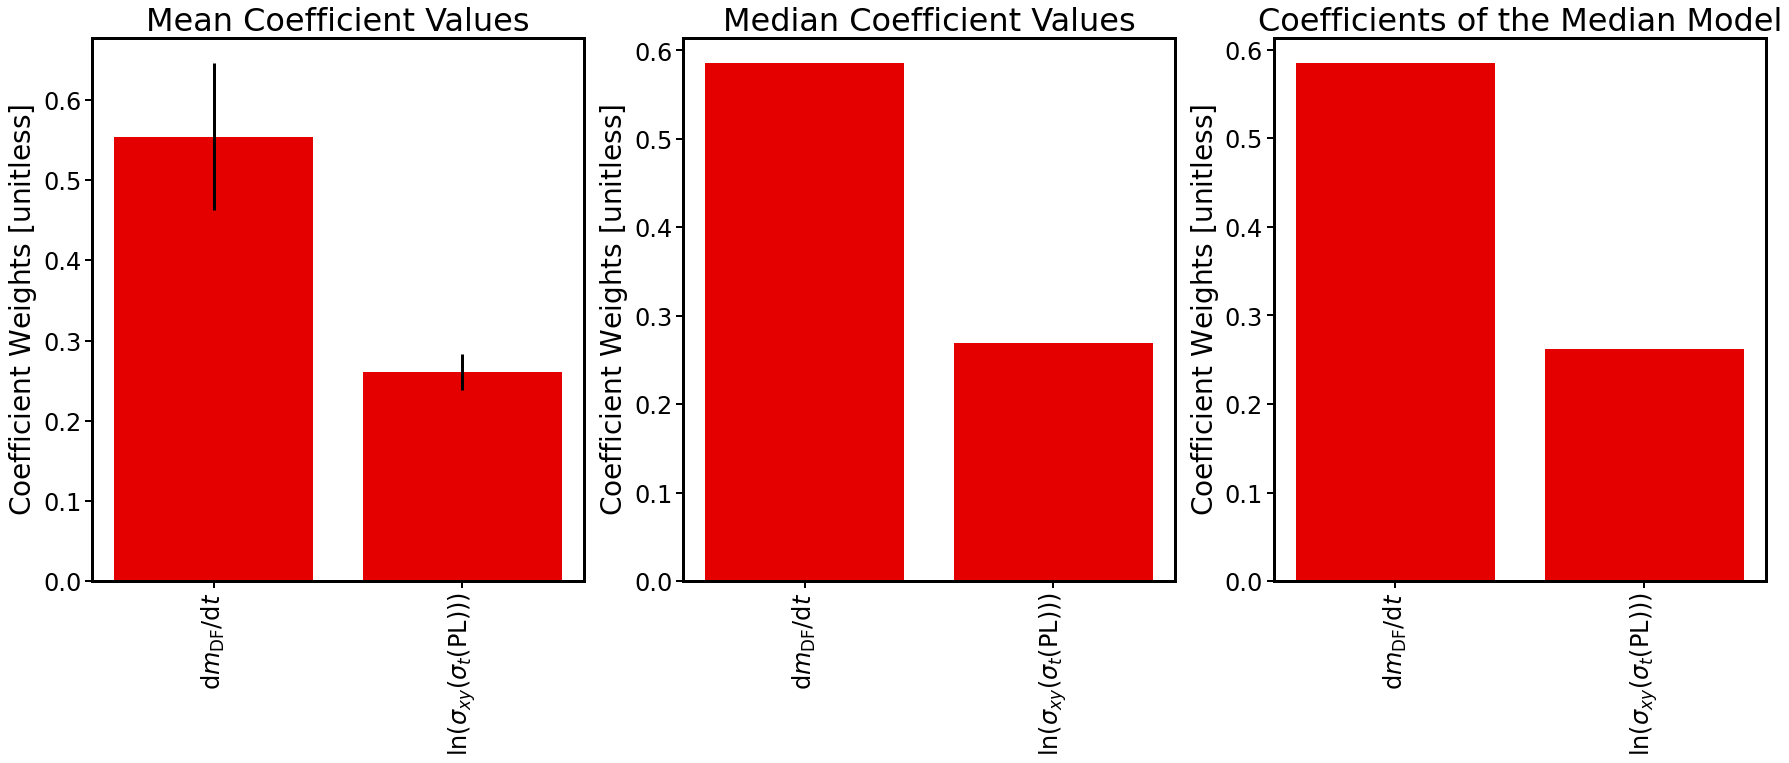

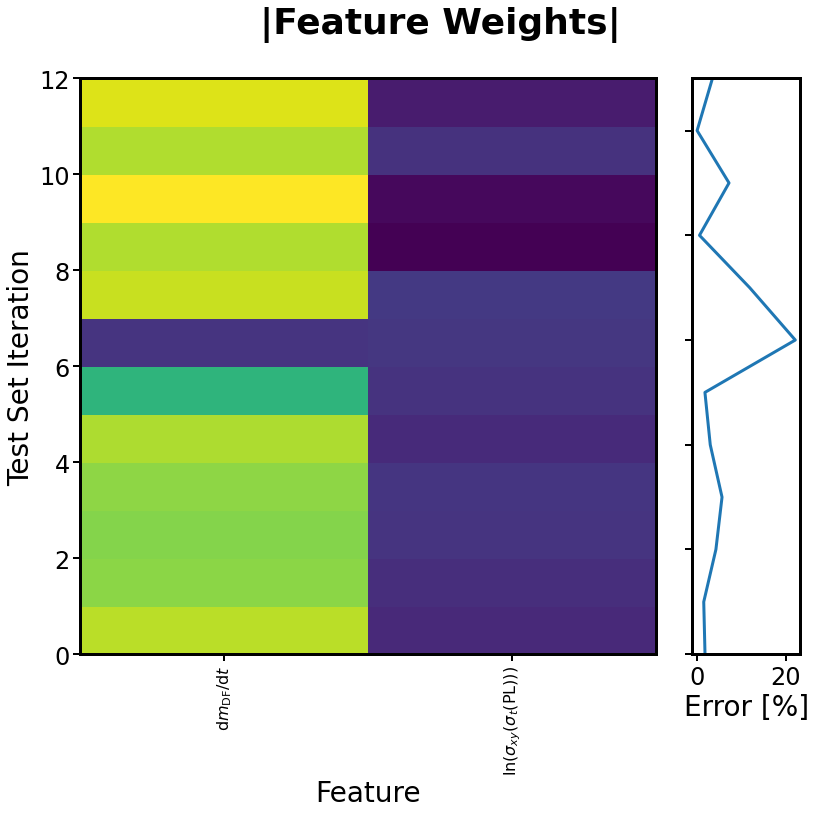

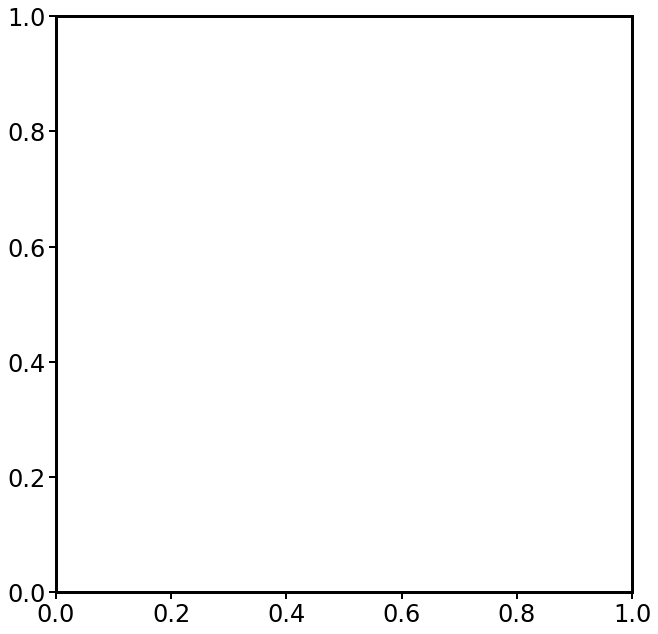

In [130]:
# make a copy of the coeffs_df but with Boolean values to indicate whether the corresponding feature was selected
selected_df = coeffs_df.copy()

for ii in range(len(selected_df)):
    logic = selected_df.iloc[ii] != 0 # convert nonzero values to True, zero values to False
    selected_df.iloc[ii] = logic

# make a DF of key statistics on the coefficient values
stats_df = coeffs_df.copy()

# initialize lists of key stats
medians = []
means = []
stds = []

# populate the lists...
for col in coeffs_df.columns:
    medians.append(np.median(coeffs_df[col]))
    means.append(np.mean(coeffs_df[col]))
    stds.append(np.std(coeffs_df[col]))
# ...and add them to the DataFrame 
stats_df.loc['medians'] = medians
stats_df.loc['means'] = means
stats_df.loc['stds'] = stds

# plot the median values of the coefficients
#plt.figure(figsize=(10,10))
#plt.bar(stats_df.columns,stats_df.loc['medians'])
#plt.xticks(rotation=90)

# assign bar colors to mean coefficient values
bar_colors_mean = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(means[jj]) == 1:
            bar_colors_mean.append('xkcd:red')
        else:
            bar_colors_mean.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors_mean.append('xkcd:blue')
        else:
            bar_colors_mean.append('xkcd:red')

# assign bar colors to median coefficient values
bar_colors_median = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(medians[jj]) == 1:
            bar_colors_median.append('xkcd:red')
        else:
            bar_colors_median.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(medians[jj]) == 1:
            bar_colors_median.append('xkcd:blue')
        else:
            bar_colors_median.append('xkcd:red')

# make a dataFrame that will be used for bar plots specifically
bars_df = pd.DataFrame(means) # base it off the mean coefficient values
bars_df = bars_df.rename(columns={0:'means'})
bars_df['coeffs'] = coeffs # get coefficient names
bars_df.index = coeffs # make the DF indices equal to the coefficient names
bars_df['means'] = np.abs(bars_df['means']) # convert means to their absolute values for prettier/easier-to-read plots
bars_df['medians'] = np.abs(medians) # add median coefficient values
bars_df['error'] = stds # add standard deviations
bars_df['colors_mean'] = bar_colors_mean # encode coefficient sign in bar color
bars_df['colors_median'] = bar_colors_mean # encode coefficient sign in bar color
bars_df = bars_df.sort_values(by = 'means', ascending=False) # sort the bars in descending order of mean

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_bars_df = bars_df[bars_df['means'] > 0]

# further reduced dataframe of only coefficients whose average is larger than their std. dev.
sig_bars_df = nz_bars_df[nz_bars_df['means'] > nz_bars_df['error']]

# for making plots look nice:
# dictionary for conversion of ASCII feature labels to TeX-style labels
fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'lndTrdt':'ln($\mathrm{d}\mathcal{T}/\mathrm{d}t$)',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'mu1':'$\mu_{t=1}$',
                     'mu2':'$\mu_{t=2}$',
                     'mu3':'$\mu_{t=3}$',
                     'mu4':'$\mu_{t=4}$',
                     'mu5':'$\mu_{t=5}$',
                     'tau1':'$\\tau_{t=1}$',
                     'tau2':'$\\tau_{t=2}$',
                     'tau3':'$\\tau_{t=3}$',
                     'tau4':'$\\tau_{t=4}$',
                     'tau5':'$\\tau_{t=5}$',
                     'PL0':'$\Phi_{\mathrm{PL},0}$',
                     'LD0':'$L_{\mathrm{D},0}$',
                     'QFLS_0':'$\Delta E_{\mathrm{F},0}$',
                     'Days Stored':'$t_{\mathrm{storage}}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'O2':'$\chi_\mathrm{O_2}$',
                     'RH':'$\mathrm{RH}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\\theta_\mathrm{H_2O}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$',
                     'LAI_O2':'$\\theta_\mathrm{O_2}$',
                     'Ox_rate_LAI':'$\\theta_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Ox_rate_P':'$P_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Arrhenius_Ox':'$\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'PhotoOx_rate_P':'$P_\mathrm{O_2}N_\mathrm{suns}^{\gamma}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'dtaudt':'$\mathrm{d}\\tau/\mathrm{d}t$',
                     'dmudt':'$\mathrm{d}\mu/\mathrm{d}t$',
                     'dtdT':'$(\mathrm{d}\mathcal{T}/\mathrm{d}t)^{-1}$',
                     'dtdLD':'$(\mathrm{d}L_D/\mathrm{d}t)^{-1}$',
                     'dtdPL':'$(\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t)^{-1}$',
                     'd2tdT2':'$(\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2)^{-1}$',
                     'd2tdLD2':'$(\mathrm{d^2}L_D/\mathrm{d}t^2)^{-1}$',
                     'd2tdPL2':'$(\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2)^{-1}$',
                     'mu0':'$\mu_0$',
                     'tau0':'$\\tau_0$',
                     'ddtau0':'$\mathrm{d}^2\\tau/\mathrm{d}t^2$',
                     'ddmu0':'$\mathrm{d}^2\mu/\mathrm{d}t^2$',
                     'AB':'$T \mathrm{RH}$',
                     'AC':'$T \chi_\mathrm{O_2}$',
                     'AD':'$T N_\mathrm{suns}$',
                     'AE':'$T x_\mathrm{MA}}$',
                     'BC':'$\mathrm{RH} \chi_\mathrm{O_2}$',
                     'BD':'$\mathrm{RH} N_\mathrm{suns}$',
                     'BE':'$\mathrm{RH} x_\mathrm{MA}}$',
                     'CD':'$\chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'CE':'$\chi_\mathrm{O_2} x_\mathrm{MA}}$',
                     'DE':'$N_\mathrm{suns} x_\mathrm{MA}}$',
                     'ABC':'$T \mathrm{RH} \chi_\mathrm{O_2}$',
                     'ABD':'$T \mathrm{RH} N_\mathrm{suns}$',
                     'ABE':'$T \mathrm{RH} x_\mathrm{MA}$',
                     'ACD':'$T \chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'ACE':'$T \chi_\mathrm{O_2} x_\mathrm{MA}$',
                     'ADE':'$T N_\mathrm{suns} x_\mathrm{MA}$',
                     'BCD':'$\mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'BCE':'$\mathrm{RH} \chi_\mathrm{O_2} x_\mathrm{MA}$',
                     'BDE':'$\mathrm{RH} N_\mathrm{suns} x_\mathrm{MA}$',
                     'CDE':'$\chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}}$',
                     'ABCD':'$T \mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'ABCE':'$T \mathrm{RH} \chi_\mathrm{O_2} x_\mathrm{MA}$',
                     'ABDE':'$T \mathrm{RH} N_\mathrm{suns} x_\mathrm{MA}$',
                     'ACDE':'$T \chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}$',
                     'BCDE':'$\mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}$',
                     'ABCDE':'$T \mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}$',
                     'log_dTdt_full':'ln$(\mathrm{d}\mathcal{T}/\mathrm{d}t)_{5\%}$',
                     'dTrdt_full':'$(\mathrm{d}\mathcal{T}/\mathrm{d}t)_{5\%}$',
                     'Tr_LD80':'$\mathcal{T}_{L_\mathrm{D},80}$',
                     'lnPL80':'ln($\\tilde{\phi}_{L_\mathrm{D},80}$)',
                     'Opt_Tol':'$\mathcal{T}_{L_\mathrm{D},80}(x_\mathrm{MA})$',
                     'ddJmppdt2':'$\mathrm{d}^2J_\mathrm{MPP}/\mathrm{d}t^2$',
                     'dDFmediandt':'$\mathrm{d}m_\mathrm{DF}/\mathrm{d}t$',
                     'beta_std':'$\\sigma_{\\beta}$',
                     'dVmppdt':'$\mathrm{d}V_\mathrm{MPP}/\mathrm{d}t$',
                     'xy1t1_0':'$\sigma_{xy}(\sigma_t(\mathrm{PL}))$',
                     'ln_xy1t1':'ln($\sigma_{xy}(\sigma_t(\mathrm{PL})))$'
                    }
# define list of nice-looking labels
fancy_labels=[]
for coeff in sig_bars_df['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])

# initialize the figure for comparing coefficients
fig, ax = plt.subplots(1,3,figsize=(30,10))  

# plot the means with error bars represented by the standard deviation
ax[0].bar(sig_bars_df['coeffs'],sig_bars_df['means'],yerr=sig_bars_df['error'],color=sig_bars_df['colors_mean'])
ax[0].set_xticklabels(labels=fancy_labels,rotation=90)
ax[0].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[0].set_title('Mean Coefficient Values')

# now re-sort the DF by descending medians
bars_df = bars_df.sort_values(by = 'medians', ascending=False)

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_meds_df = bars_df[bars_df['medians'] > 0]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in nz_meds_df['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])

# and plot the median coefficient weights
ax[1].bar(nz_meds_df['coeffs'],nz_meds_df['medians'],color=nz_meds_df['colors_median'])
ax[1].set_xticklabels(labels=fancy_labels,rotation=90)
ax[1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[1].set_title('Median Coefficient Values')

# identify the index corresponding to the median model
idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
med_idx = idx # save the median index in a less ambiguous form
coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

# assign bar colors to coefficient values
bar_colors_med_model = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    div_cmap = 'RdBu_r'
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:red')
        else:
            bar_colors_med_model.append('xkcd:blue')
else:
    div_cmap = 'RdBu'
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:blue')
        else:
            bar_colors_med_model.append('xkcd:red')

# make a DataFrame for bar plotting of the median model's coefficients
med_model_bars_df = pd.DataFrame(coeffs_med_model) 
med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
med_model_bars_df.index = coeffs # make the DF indices equal to the coefficient names
med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

# identify the nonzero coefficients
sig_bars_med_model = med_model_bars_df.copy()[med_model_bars_df['abs. values'] > 0]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in sig_bars_med_model['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])

# and make the plot
ax[2].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
ax[2].set_xticklabels(fancy_labels,rotation=90)
ax[2].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[2].set_title('Coefficients of the Median Model')



# make a figure with all the coefficients in a heat map
fig = plt.figure(figsize=(10,10))

# redefine the fancy coefficients
fancy_labels=[]
for coeff in coeffs_df.columns:
    fancy_labels.append(fancy_labels_dict[coeff])

# first panel: heat map
ax1 = fig.add_axes([0,0,0.8,0.8])
ax1.pcolor(np.abs(coeffs_df))
ax1.set_xticks(np.arange(0.5, len(coeffs_df.columns), 1))
ax1.set_xticklabels(fancy_labels,rotation=90,fontsize=16)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Test Set Iteration')

# plot of error with same y-axis
ax2 = fig.add_axes([0.85,0,0.15,0.8])
ax2.plot(MAE_pct,range(len(MAE_pct)))
ax2.set_ylim([np.min(range(len(MAE_pct))),np.max(range(len(MAE_pct)))])
ax2.set_yticklabels([])
ax2.set_xlabel('Error [%]',fontsize=28)
fig.suptitle('|Feature Weights|', x=0.5, y=0.9, fontsize=36, weight='bold')


# make a figure with all the coefficients in a DIVERGING heat map
fig2 = plt.figure(figsize=(10,10))

# redefine the fancy coefficients
fancy_labels=[]
for coeff in coeffs_df.columns:
    fancy_labels.append(fancy_labels_dict[coeff])

# first panel: heat map
ax1 = fig2.add_axes([0,0,0.8,0.8])
ax1.pcolor(coeffs_aug, cmap = div_cmap, vmin = -np.max(np.max(np.abs(coeffs_aug))), vmax = np.max(np.max(np.abs(coeffs_aug))))
ax1.set_xticks(np.arange(0.5, len(coeffs_df.columns), 1))
ax1.set_xticklabels(fancy_labels,rotation=90,fontsize=16)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Test Set Iteration')

# plot of error with same y-axis
ax2 = fig2.add_axes([0.85,0,0.15,0.8])
ax2.plot(MAE_pct,range(len(MAE_pct)))
ax2.set_ylim([np.min(range(len(MAE_pct))),np.max(range(len(MAE_pct)))])
ax2.set_yticklabels([])
ax2.set_xlabel('Error [%]',fontsize=28)
fig2.suptitle('Feature Weights', x=0.5, y=0.9, fontsize=36, weight='bold')


# make a figure with all the coefficients in a DIVERGING heat map; this time sort everything by test error
fig2 = plt.figure(figsize=(10,10))

# augment the coeffs_df with an MAE column
coeffs_aug = coeffs_df.copy()
coeffs_aug['MAE'] = MAE_pct

# sort the runs by error
coeffs_aug = coeffs_aug.sort_values(by='MAE',axis=0,ascending=True)
MAE_sorted = coeffs_aug['MAE']
coeffs_aug = coeffs_aug.drop('MAE',axis=1)

# redefine the fancy coefficients
fancy_labels=[]
for coeff in coeffs_aug.columns:
    fancy_labels.append(fancy_labels_dict[coeff])

# first panel: heat map
ax1 = fig2.add_axes([0,0,0.8,0.8])
ax1.pcolor(coeffs_aug, cmap = div_cmap, vmin = -np.max(np.max(np.abs(coeffs_aug))), vmax = np.max(np.max(np.abs(coeffs_aug))))
ax1.set_xticks(np.arange(0.5, len(coeffs_aug.columns), 1))
ax1.set_xticklabels(fancy_labels,rotation=90,fontsize=16)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Test Set Iteration')

# plot of error with same y-axis
ax2 = fig2.add_axes([0.85,0,0.15,0.8])
ax2.plot(MAE_sorted,range(len(MAE_sorted)))
ax2.set_ylim([np.min(range(len(MAE_sorted))),np.max(range(len(MAE_sorted)))])
ax2.set_yticklabels([])
ax2.set_xlabel('Error [%]',fontsize=28)
fig2.suptitle('Feature Weights', x=0.5, y=0.9, fontsize=36, weight='bold')

In [13]:
coeffs_df

beta_std  dDFmediandt   ddJmppdt2
0 -339.236099  -376.530904  466.093823
0 -322.997444    -0.000000  726.261722
0 -364.831378  -275.561690  557.668887
0 -405.922644  -259.391535  288.866670
0 -377.922974  -282.209100  498.508805
0 -454.223025  -261.538291  397.555926
0 -341.667990  -494.622010  351.075506
0 -380.030008  -191.762680  639.834149
0 -395.330469  -329.764234  637.145579

# 8. Predictions Broken Down by Composition

Make a triptych of parity plots broken down by composition for the model with the median test set error. In these plots we do not distinguish between members of the training and test set.

## CAREFUL -- Note that the variables corresponding to the median model were defined in block (6) above - if you insert any modeling blocks between that block and this one, this may change and you may not plot the median model!

Text(2, 6, 'MAE = 14.17%')

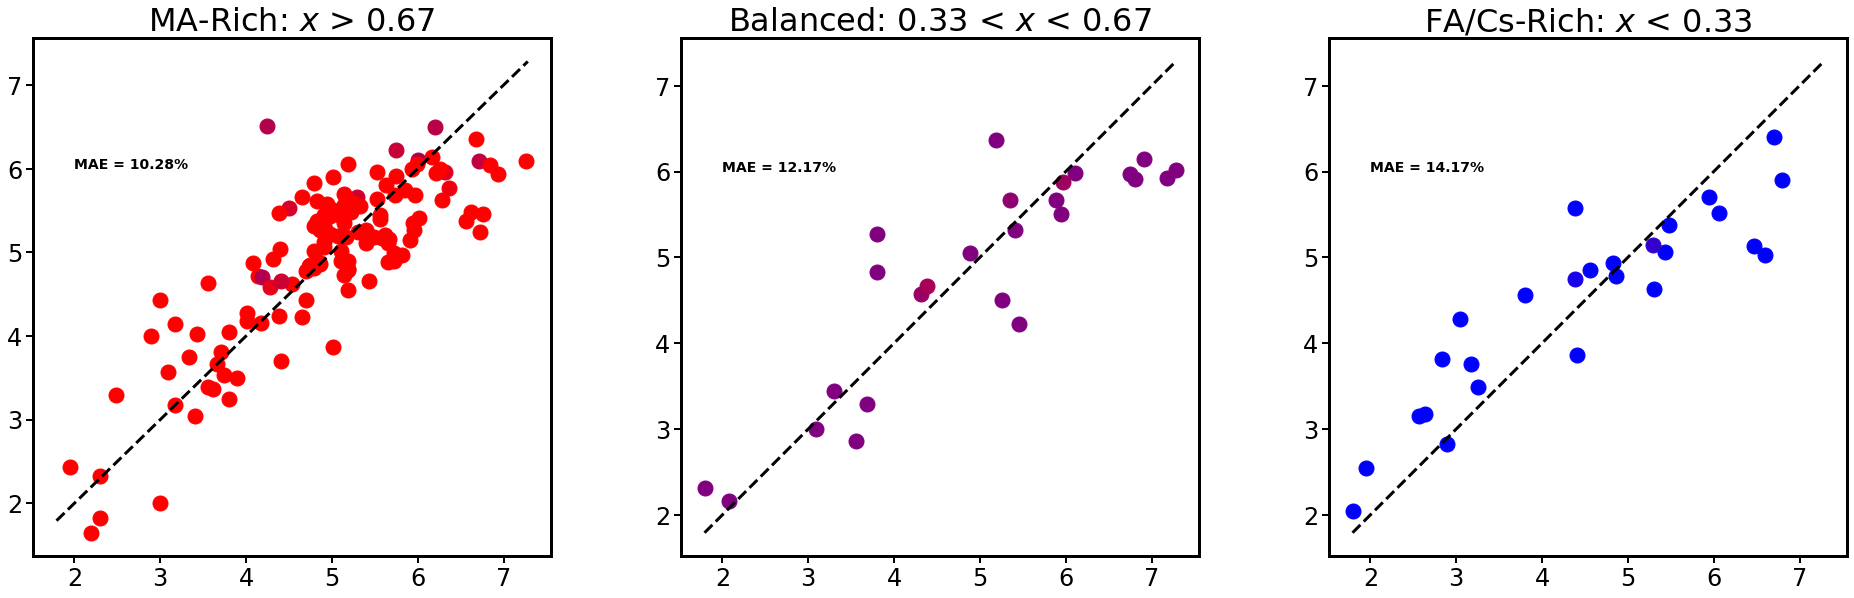

In [126]:
# Make fancy plots of composition

# define initial plot parameters
panel_size = 9 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 1 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# set up the plot axes - this is a more manual way than using plt.subplots(),
# but it ensures that all the axes are square
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge
ax0 = fig.add_axes([0 + spacing*aspect_x,0, aspect_x*ax_size,ax_size])
ax1 = fig.add_axes([aspect_x + spacing*aspect_x,0, aspect_x*ax_size,ax_size])
ax2 = fig.add_axes([2*aspect_x + spacing*aspect_x,0, aspect_x*ax_size,ax_size])
ax = [ax0,ax1,ax2]

# where on the plot to put text
if response == 'tLD75 (min)' or response == 'tLD80 (min)' or response == 'tLD80 corrected (min)' or response == 'tLD75 corrected (min)':
    text_x = 2
    text_y = 6
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    text_x = -9
    text_y = -4

# format specifiers for text
textsize = 14
textweight = 'bold'
    
##### FIRST PANEL: Parity plot for MA-rich compositions

# initialize lists of observed and predicted values for MA-rich samples
MA_rich_act = []
MA_rich_pred = []

# loop over training set first
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac > 0.67:
        MA_rich_act.append(y_train.loc[idx])
        MA_rich_pred.append(ytpred[ii])
        ax[0].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')

# make axis labels according to the appropriate response variable
if response == 'tLD75 (min)':
    ax[0].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[0].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[0].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[0].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')
ax[0].set_title('MA-Rich: $x$ > 0.67')

# now plot the test set
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac > 0.67:
        MA_rich_act.append(y_whold.loc[idx])
        MA_rich_pred.append(ypred[ii])
        ax[0].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# convert lists to arrays to faciliate stats calcs
MA_rich_act = np.array(MA_rich_act) 
MA_rich_pred = np.array(MA_rich_pred) 
        
# stats calcs
MA_rich_R2 = r2_score(MA_rich_act,MA_rich_pred)
MA_rich_MAE_pct = np.abs((MA_rich_pred - MA_rich_act)/MA_rich_act)*100

# note the error on the plot
ax[0].text(text_x,text_y,'MAE = ' + str(round(np.mean(MA_rich_MAE_pct),2)) + '%',weight=textweight,fontsize=textsize)

##### SECOND PANEL: Parity plot for balanced compositions

# initialize lists of observed and predicted 
MA_bal_act = []
MA_bal_pred = []

# loop over training set
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.67 and MA_frac > 0.33:
        MA_bal_act.append(y_train.loc[idx])
        MA_bal_pred.append(ytpred[ii])
        ax[1].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[1].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')

# make axis labels according to the appropriate response variable
if response == 'tLD75 (min)':
    ax[1].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[1].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[1].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[1].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')
ax[1].set_title('Balanced: 0.33 < $x$ < 0.67')

# loop over test set
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.67 and MA_frac > 0.33:
        MA_bal_act.append(y_whold.loc[idx])
        MA_bal_pred.append(ypred[ii])
        ax[1].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# convert lists to arrays to faciliate stats calcs
MA_bal_act = np.array(MA_bal_act) 
MA_bal_pred = np.array(MA_bal_pred) 
        
# stats calcs        
MA_bal_R2 = r2_score(MA_bal_act,MA_bal_pred)
MA_bal_MAE_pct = np.abs((MA_bal_pred - MA_bal_act)/MA_bal_act)*100

# put error on plot
ax[1].text(text_x,text_y,'MAE = ' + str(round(np.mean(MA_bal_MAE_pct),2)) + '%',weight=textweight,fontsize=textsize)

##### THIRD PANEL: Parity plot for FACS-rich compositions

# initalize lists
MA_lean_act = []
MA_lean_pred = []

# training set
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.33:
        MA_lean_act.append(y_train.loc[idx])
        MA_lean_pred.append(ytpred[ii])
        ax[2].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[2].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')

# set axis labels and title
if response == 'tLD75 (min)':
    ax[2].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[2].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[2].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[2].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')
ax[2].set_title('FA/Cs-Rich: $x$ < 0.33')

# test set
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.33:
        MA_lean_act.append(y_whold.loc[idx])
        MA_lean_pred.append(ypred[ii])
        ax[2].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# lists -> arrays
MA_lean_act = np.array(MA_lean_act) 
MA_lean_pred = np.array(MA_lean_pred) 
        
# calculate and plot error
MA_lean_R2 = r2_score(MA_lean_act,MA_lean_pred)
MA_lean_MAE_pct = np.abs((MA_lean_pred - MA_lean_act)/MA_lean_act)*100
ax[2].text(text_x,text_y,'MAE = ' + str(round(np.mean(MA_lean_MAE_pct),2)) + '%',weight=textweight,fontsize=textsize)

# Print figure title and panel labels if desired
#fig.suptitle('Early-Time Features', x=0.5, y=1, fontsize=48, weight='bold')
#fig.text(0,ax_size,'a',fontsize=36,weight='bold')
#fig.text(aspect_x,ax_size,'b',fontsize=36,weight='bold')
#fig.text(2*aspect_x,ax_size,'c',fontsize=36,weight='bold')

In [103]:
fa_data = rawdata_df.copy()[rawdata_df['MA fraction']==0]
fa_data['tLD80 (min)']

18       NaN
19      82.0
20       NaN
21      26.0
22      14.0
23     201.0
24       4.0
25       7.0
26     130.0
27      15.0
28      45.0
29      13.0
30     230.0
31     240.0
32      18.0
33       5.0
34       NaN
35     645.0
43     430.0
53     735.0
66     380.0
67     895.0
88     810.0
89      17.0
90      15.0
91       6.0
125     21.0
127     24.0
147      NaN
148     95.0
149     80.0
150    125.0
159      NaN
Name: tLD80 (min), dtype: float64

# 9. Predictions Broken Down by Environmental Conditions

Make a four-panel figure with a) coefficient weights of the median model, b) parity plot of the median model, c) test set error distribution, and d) symbol legend

## CAREFUL -- As in block (8), note that the variables corresponding to the median model were defined in block (6) above - if you insert any modeling blocks between that block and this one, this may change and you may not plot the median model!

NameError: name 'batch_colors' is not defined

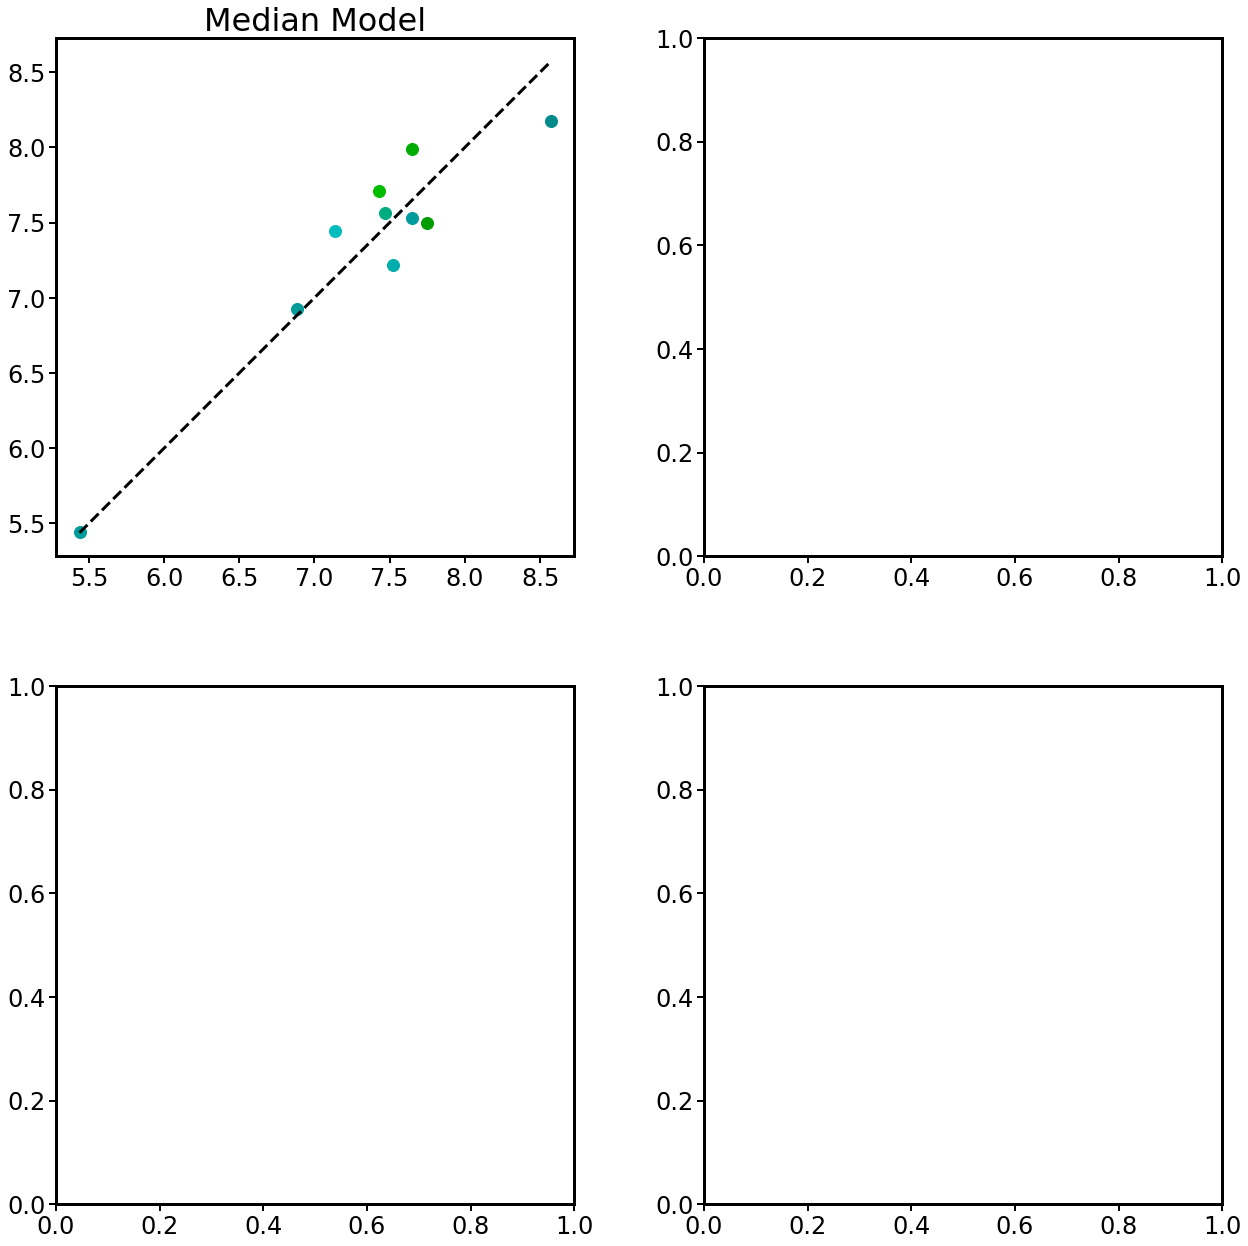

In [62]:
# Make fancy plots of test set error 

# Set up the subplot parameters - again we want square panels not square subplots, so we do things manually
panel_size = 9 # absolute size of a single panel, inches(?)
n_plots_x = 2 # how many panels to plot in the x-direction
n_plots_y = 2 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_x):
    row_panel_list = []
    for jj in range(n_plots_y):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list)



##### TOP LEFT: parity plot of median model
actual_all = []
preds_all = []
idxs_all = []

# plot training set
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    actual_all.append(y_train.loc[idx])
    preds_all.append(ytpred[ii])
    idxs_all.append(idx)
    ax[0][0].plot(y_train.loc[idx],ytpred[ii],color=color,marker='o',fillstyle='full',linestyle=style,markersize=12)
    #ax[0][0].text(y_train.loc[idx],ytpred[ii],ii,fontsize=8)
# plot perfect prediction line and +/-50% error bounds (latter good for DOE presentations, bad for publications)
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[0][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#ax[0][0].plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#ax[0][0].plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

# set appropriate axis labels and title
if response == 'tLD75 (min)':
    ax[0][0].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[0][0].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
if 'tLD80' in response:
    ax[0][0].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,80}$)')
    ax[0][0].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,80}$)')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[0][0].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[0][0].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')
ax[0][0].set_title('Median Model')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    actual_all.append(y_whold.loc[idx])
    preds_all.append(ypred[ii])
    idxs_all.append(idx)
    ax[0][0].plot(y_whold[idx],ypred[ii],color=batch_colors[rawdata_df['BatchID'][idx]],marker='o',fillstyle='full',linestyle=style,markersize=8)
    # test sample in orange
    ax[0][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')

# plot legend for test sample
#if response == 'tLD75 (min)':
#    ax[0][0].plot(5,2,marker='*',markersize=20,color='xkcd:orange')
#    ax[0][0].text(5.2,1.98,'Test Sample',fontsize=20,weight='bold',color='xkcd:orange',va='center')
  
# calculate error metrics
actual_all = np.array(actual_all)
preds_all = np.array(preds_all)
R2_overall = r2_score(actual_all,preds_all)
MAE_pct_overall = np.abs((preds_all - actual_all)/preds_all)*100
    
# set text position for the approporiate response variable
if response == 'tLD75 (min)':
    text_x = 2
    text_y = 6
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    text_x = -9
    text_y = -4
    
##### TOP RIGHT: symbol legend

ax[0][1].axis('off') # no bounding box
ax[0][1].set_xlim([0,10]) # set grid for plotting symbols on
ax[0][1].set_ylim([0,10]) 

origin = (1,7) # corner to start plotting from
pitch = 1.5 # spacing between symbols

# plot temperature/humidity symbols, defined by color
pct_O2 = 21
N_suns_stress = 8
for ii in range(4): # iterate over 4 temps
    for jj in range(5): # iterate over 5 RHs
        T = 25 + ii*20
        RH = jj*20

        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)

        ax[0][1].plot(origin[0]+ii*pitch,origin[1]-jj*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# plot temp legends
ax[0][1].text(origin[0],origin[1]+0.5*pitch,'25 $\degree$C',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+pitch,origin[1]+0.5*pitch,'45 $\degree$C',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+2*pitch,origin[1]+0.5*pitch,'65 $\degree$C',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+3*pitch,origin[1]+0.5*pitch,'85 $\degree$C',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+1.5*pitch,origin[1]+pitch,'Temperature',fontsize=25,ha='center',va='center')

# plot RH legends
ax[0][1].text(origin[0]-0.25*pitch,origin[1],'0%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-0.25*pitch,origin[1]-pitch,'20%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-0.25*pitch,origin[1]-2*pitch,'40%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-0.25*pitch,origin[1]-3*pitch,'60%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-0.25*pitch,origin[1]-4*pitch,'80%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-1.125*pitch,origin[1]-2*pitch,'Relative Humidity',fontsize=25,ha='center',va='center',rotation=90)

# plot illumination symbols, defined by shape
T = 25
RH = 60

ill_x = 4 # how many pitches "east" of the origin to plot illumination symbols

# dark: pentagons
N_suns_stress = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1],color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# 0.5 suns: triangles
N_suns_stress = 0.5
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-4*pitch/5,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# 1 sun: inverted triangles
N_suns_stress = 1
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-8*pitch/5,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# 8 suns: circles
N_suns_stress = 8
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-12*pitch/5,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# 16 suns: squares
N_suns_stress = 16
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-16*pitch/5,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# 32 suns: diamonds
N_suns_stress = 32
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-20*pitch/5,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# plot illumination legends
ax[0][1].text(origin[0]+(ill_x-0.2)*pitch,origin[1] + 0.9,'Illumination',rotation=45,fontsize=25,va='bottom')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1] + 0.33*pitch,'0 suns',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1] - (4/5 - 0.33)*pitch,'0.5 suns',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1] - (8/5 - 0.33)*pitch,'1 sun',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1] - (12/5 - 0.33)*pitch,'8 suns',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1] - (16/5 - 0.33)*pitch,'16 suns',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1] - (20/5 - 0.33)*pitch,'32 suns',fontsize=20,ha='center',va='center')

# plot atmosphere symbols, defined by fill
atm_x = 5 # how many pitches "east" of orign to plot atmosphere symbols

N_suns_stress = 8

# N2: open symbols
pct_O2 = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+atm_x*pitch,origin[1]-1*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# air: half-filled symbols
pct_O2 = 21
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+atm_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# O2: filled symbols
pct_O2 = 100
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+atm_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# plot O2 legends
ax[0][1].text(origin[0]+(atm_x-0.2)*pitch,origin[1],'Atmosphere',rotation=45,fontsize=25,va='bottom')
ax[0][1].text(origin[0]+atm_x*pitch,origin[1]-0.5*pitch,'N$_2$',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+atm_x*pitch,origin[1]-1.5*pitch,'Air',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+atm_x*pitch,origin[1]-2.5*pitch,'O$_2$',fontsize=20,ha='center',va='center')

# set full legend title
ax[0][1].text(origin[0]+2.5*pitch,origin[1]+1.75*pitch,'Symbol Legend',fontsize=32,ha='center',weight='bold')


##### BOTTOM LEFT: test set error distribution
ax[1][0].hist(MAE_pct,color='xkcd:vermillion',alpha=0.8,edgecolor='black',histtype='bar')
ax[1][0].set_xlabel('Mean Test Error [%]')
ax[1][0].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
ax[1][0].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
              'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top')
ax[1][0].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
              'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top')

##### BOTTOM RIGHT: coefficients of the median model

# identify the index corresponding to the median model
idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
med_idx = idx # save the median index in a less ambiguous form
coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

# assign bar colors to coefficient values
bar_colors_med_model = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:red')
        else:
            bar_colors_med_model.append('xkcd:blue')
else:
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:blue')
        else:
            bar_colors_med_model.append('xkcd:red')

# make a DataFrame for bar plotting of the median model's coefficients
med_model_bars_df = pd.DataFrame(coeffs_med_model) 
med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
med_model_bars_df.index = coeffs # make the DF indices equal to the coefficient names
med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

# identify the nonzero coefficients
sig_bars_med_model = med_model_bars_df[med_model_bars_df['abs. values'] > 0]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in sig_bars_med_model['coeffs']:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)

# and make the plot
ax[1][1].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
ax[1][1].set_xticklabels(fancy_labels,rotation=90)
ax[1][1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[1][1].set_title('Coefficients of the Median Model')

# add grand title and panel labels if desired
#fig.suptitle('Early-Time + Linear Env\'t and Comp. Features', x=0.5, y=1, fontsize=48, weight='bold')
fig.text(0,0.95,'a',fontsize=36,weight='bold')
fig.text(0,0.45,'b',fontsize=36,weight='bold')
fig.text(0.5,0.45,'c',fontsize=36,weight='bold')

### Uncomment the linest below to see corners of the figure
#fig.text(0,0,'(0,0)')
#fig.text(1,0,'(1,0)')
#fig.text(0,1,'(0,1)')
#fig.text(1,1,'(1,1)')

viridis = cm.get_cmap('viridis', 256)
c_min = np.nanmin(np.log(rawdata_df['Bleach Rate (polyfit) (1/min)']))
c_max = np.nanmax(np.log(rawdata_df['Bleach Rate (polyfit) (1/min)']))


d_fig, diag_ax = plt.subplots() # initialize axis for diagnostic plots
residuals = actual_all-preds_all

for ii in range(len(rawdata_df)):
    bleach_color = viridis((np.log(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii]) - c_min)/(c_max-c_min)) 
    diag_ax.plot(actual_all[ii],residuals[ii],color=bleach_color,marker='.',linestyle=' ')
    diag_ax.text(actual_all[ii],residuals[ii],idxs_all[ii],fontsize=8)
diag_ax.set_xlabel('Observed Value $y$')
diag_ax.set_ylabel('Residuals $y\ - \hat{y}$')

std_resids = (residuals-np.mean(residuals))/np.std(residuals)
# initialize axis for qq plot
new_fig = plt.figure()
import statsmodels.api as sm
sm.qqplot(std_resids,line='45')


# 10. Make a Big Figure 4

Plot the most sophisticated physics-inspired models, using leave-one-out testing in the top row and normal operating conditions testing in the bottom row.

In [ ]:
# Start by initializing the figure: 3 x 3 square panels
panel_size = 15 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 2 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_y):
    row_panel_list = []
    for jj in range(n_plots_x):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list) 
    
# Global size to use for figure markers
marker_size = 25

axis_lab_size = 36
title_size=48

##### TOP PANEL: parity plot for model with leave-one-out testing

# train the model
# first determine whether to do a log transform or not, then partition the data into features (X) and response (Y) DFs
if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset
n_trials = len(Y)


# set up search parameters for cross-validation, which will be used to select the hyperparameter
# range of hyperparameters to test
param_vals = np.logspace(-3,3,num=31)
parameters = {'alpha': param_vals}
# model to implement - LASSO, Ridge, etc.
model = Lasso(max_iter=1e8)
# scoring metric - MSE, R2, etc.
metric = 'neg_mean_squared_error'
# how many folds to do in k-fold cross-validation - 5 is standard
folds = n_trials-1

# feature sets to test: currently use only early time and early time + linear
feature_sets = [
                ['dTrdt','dLDdt','dPLdt',
                 'ddTr0','ddLD0','ddPL0',
                 'Ld1','Ld2','Ld3','Ld4','Ld5',
                 'Tr1','Tr2','Tr3','Tr4','Tr5',
                 'PL1','PL2','PL3','PL4','PL5',
                 'A','P_H2O','P_O2','D','E',
                 'PhotoOx_rate','Hydration_rate','delS_mix',]
                ]

# define metrics to keep track of for each feature set
performance_metrics = ['Mean Test Set Error (%)','Median Test Set Error (%)','Std Dev Test Set Error (%)',
                       'Mean Test Set Error','Median Test Set Error','Std Dev Test Set Error',
                       'Mean Training Set Error (%)','Median Training Set Error (%)','Std Dev Training Set Error (%)',
                       'Mean Training Set Error','Median Training Set Error','Std Dev Training Set Error',
                       'Mean Full Set Error (%)','Median Full Set Error (%)','Std Dev Full Set Error (%)',
                       'Mean Full Set Error','Median Full Set Error','Std Dev Full Set Error',
                       'Mean Training Set R2', 'Median Training Set R2','Std Dev Training Set R2',
                       'MA-Rich Error (%)','Balanced Error (%)','FACs-Rich Error (%)',
                       'MA-Rich R2 (%)','Balanced R2 (%)','FACs-Rich R2 (%)',
                      ]
performance_metalist = []

# keep track of coefficients
coeffs_DFs = []

# Loop over model echelons
for j, echelon in enumerate(feature_sets):
    
    # initialize the list of error/performance metrics
    performance_list = []
    
    X = coded_df.drop(columns=response).copy()
    X = X[echelon]
    
    # initialize error metrics for test set
    R2 = np.zeros(n_trials) # coefficient of determination
    RMSE = np.zeros(n_trials) # RMS error
    MAE_pct = np.zeros(n_trials) # mean absolute error, percent
    MAE = np.zeros(n_trials) # mean absolute error

    # for the whole dataset
    MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
    MAE_overall = np.zeros(n_trials) # mean absolute error, percent
    R2_overall = np.zeros(n_trials) # coefficient of determination

    # for the training set
    MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
    MAE_train = np.zeros(n_trials) # mean absolute error, percent
    R2_train = np.zeros(n_trials) # coefficient of determination

    # error on linear scale
    linear_error = np.zeros(n_trials)

    # initialize a dataframe to keep track of model coefficients
    coeffs_df = pd.DataFrame(columns=X.columns)

    # Loop over test sets
    for kk in range(n_trials):
    
    
        # Partition the TT split
        X_whold = X.iloc[kk].copy()
        y_whold = Y.iloc[kk:kk+1].copy()
        X_train = X.drop(X.index[kk]).copy()
        y_train = Y.drop(X.index[kk]).copy()

        # standardize the data according to the mean and variance of the training dataset
        for col in X_train.columns:
            # get mean and variance of features in the test set
            col_mean = np.mean(X_train[col])
            col_std = np.std(X_train[col])
            # standardize the features in the training set
            z_train = (X_train[col] - col_mean)/col_std
            X_train[col] = z_train
            # standardize the features in the test set
            z_whold = (X_whold[col] - col_mean)/col_std
            X_whold[col] = z_whold

        # cross-validation step to set alpha/lambda/penalty hyperparameter
        regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
        regressor.fit(X_train,y_train)

        # print winning HP value if desired...
        print(regressor.best_params_)
        #print(regressor.best_score_)
        alpha = regressor.best_params_['alpha']

        # and retrain the final model on the full training set
        final_model = Lasso(alpha=alpha)
        final_model.fit(X_train,y_train)
        #print(final_model.coef_)

        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)

        # calculate error metrics on test set
        RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
        R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
        MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
        MAE[kk] = np.mean(np.abs(y_whold-ypred))

        # put the whole dataset back together (note that this will create arrays, not DFs)
        y_net = np.concatenate([y_train,y_whold])
        y_pred_net = np.concatenate([ytpred,ypred])

        # calculate error metrics on entire set
        R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
        MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
        MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

        # calculate error metrics on training set
        R2_train[kk] = metrics.r2_score(y_train, ytpred)
        MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
        MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

        linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100

    
        # save the model coefficients
        coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=X.columns))
        
        # Save coefficients and error metrics
        
    # append performance metrics for the test set
    performance_list.append(np.mean(MAE_pct))
    performance_list.append(np.median(MAE_pct))
    performance_list.append(np.std(MAE_pct))
    performance_list.append(np.mean(MAE))
    performance_list.append(np.median(MAE))
    performance_list.append(np.std(MAE))
    # append performance metrics for the training set
    performance_list.append(np.mean(MAE_pct_train))
    performance_list.append(np.median(MAE_pct_train))
    performance_list.append(np.std(MAE_pct_train))    
    performance_list.append(np.mean(MAE_train))
    performance_list.append(np.median(MAE_train))
    performance_list.append(np.std(MAE_train))
    # append performance metrics for the full set
    performance_list.append(np.mean(MAE_pct_overall))
    performance_list.append(np.median(MAE_pct_overall))
    performance_list.append(np.std(MAE_pct_overall))
    performance_list.append(np.mean(MAE_overall))
    performance_list.append(np.median(MAE_overall))
    performance_list.append(np.std(MAE_overall))
    # append training set R2
    performance_list.append(np.mean(R2_train))
    performance_list.append(np.median(R2_train))
    performance_list.append(np.std(R2_train))
    
    # append dataframe of coefficients
    coeffs_DFs.append(coeffs_df)
        
    # Find the median model and train it
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    print(idx)
    
    kk = idx
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold

    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)

    # print winning HP value if desired...
    #print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']

    # and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)

    # make predictions on the test and training data
    ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
    ytpred=final_model.predict(X_train)
    
    # save the model coefficients
    coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=X.columns))    
    
    # convert labels "A", "B", etc. back to physically meaningful names
    new_dict = {
        "A":"Temp",
        "B":"RH",
        'C':'O2',
        'D':'Nsuns',
        'E':'MA_frac'
    }
    coeffs_df.rename(columns = new_dict, inplace = True)

    coeffs = coeffs_df.columns # save coefficient names
    
    
    # Plot the median model's coefficients in the middle panel
    # ax[j][1].plot(...)
    # identify the index corresponding to the median model
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    med_idx = idx # save the median index in a less ambiguous form
    coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

    # assign bar colors to coefficient values
    bar_colors_med_model = []
    if response == 'Bleach Rate (fit to 5% inc) (1/min)':
        for jj in range(len(coeffs_med_model)):
            if np.sign(coeffs_med_model[jj]) == 1:
                bar_colors_med_model.append('xkcd:red')
            else:
                bar_colors_med_model.append('xkcd:blue')
    else:
        for jj in range(len(coeffs_med_model)):
            if np.sign(coeffs_med_model[jj]) == 1:
                bar_colors_med_model.append('xkcd:blue')
            else:
                bar_colors_med_model.append('xkcd:red')

    # make a DataFrame for bar plotting of the median model's coefficients
    med_model_bars_df = pd.DataFrame(coeffs_med_model) 
    med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
    med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
    med_model_bars_df.index = coeffs_df.columns # make the DF indices equal to the coefficient names
    med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
    med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
    med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

    # identify the nonzero coefficients
    sig_bars_med_model = med_model_bars_df[med_model_bars_df['abs. values'] > 0]
    
    fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\\theta_\mathrm{H_2O}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$',
                     'LAI_O2':'$\\theta_\mathrm{O_2}$',
                     'Ox_rate_LAI':'$\\theta_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Ox_rate_P':'$P_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Arrhenius_Ox':'$\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'PhOx_rate_P':'$P_\mathrm{O_2}\mathrm{exp}N_\mathrm{suns}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                    }
    
    # redefine the fancy coefficients
    fancy_labels=[]
    for coeff in sig_bars_med_model['coeffs']:
        fancy_labels.append(fancy_labels_dict[coeff])

    # and make the plot
    ax[j][1].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
    ax[j][1].set_xticklabels(fancy_labels,rotation=90,fontsize=axis_lab_size)
    ax[j][1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$',fontsize=axis_lab_size)
    ax[j][1].set_title('Coefficients of the Median Model',fontsize=title_size)
    
    # Plot the test set error histogram in the right panel
    # ax[j][2].hist(...)
    ax[j][2].hist(MAE_pct,color='xkcd:cerulean',alpha=0.8,edgecolor='black',histtype='bar')
    ax[j][2].set_xlabel('Mean Test Error [%]',fontsize=axis_lab_size)
    ax[j][2].set_ylabel('Frequency',fontsize=axis_lab_size)
    ax[j][2].set_title('Histogram of Testing Error',fontsize=title_size)
    ax[j][2].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
    ax[j][2].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
                  'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top',fontsize=40)
    ax[j][2].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
                  'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top',fontsize=40)

    # Plot the median model, indexed by environment, in the bottom row
    # ax[2][j].plot(...)
    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[j][0].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

    # plot perfect prediction line and +/-50% error bounds
    plotRange = np.linspace(1,7.5,num=101)
    ax[j][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
    
    # set axis labels
    ax[j][0].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    ax[j][0].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    
    # set axis limits
    ax[j][0].set_xlim([0.5,8])
    ax[j][0].set_ylim([0.5,8])
    
    # plot legend for test sample
    ax[j][0].plot(4,1.5,marker='*',markersize=30,color='xkcd:orange')
    ax[j][0].text(4.2,1.48,'Test Sample',fontsize=40,weight='bold',color='xkcd:orange',va='center')
    

    # plot test data as above
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[j][0].plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)
        ax[j][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=marker_size,color='xkcd:orange')

###### BOTTOM ROW: plot the model trained on accelerated testing conditions tested on normal operating conditions

# find indices in the mother dataframe corresponding to 1 sun test conditions,
# which we definte  as "normal operating conditions"
NOP_indices = rawdata_df[rawdata_df['Illum (Nsuns)'] == 1].index

# try some machine learning in this cell - LASSO with leave one out testing [test cell]
# DISCLAIMER: be very careful when mixing pandas and sklearn - some of the canned functions from sklearn take in 
# DataFrames but spit out arrays. Indexing can become a mess if rows have been removed from the DF during data cleaning
# because the indices will no longer sync up between the DFs and the output array. (This can happen when using the 
# .dropna() method to remove runs that do not go to LD,75, for instance.) 

# first determine whether to do a log transform or not, then partition the data into features (X) and response (Y) DFs
if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset
n_trials = 1
#n_trials=5

# set up search parameters for cross-validation, which will be used to select the hyperparameter
# range of hyperparameters to test
param_vals = np.logspace(-3,3,num=31)
parameters = {'alpha': param_vals}
# model to implement - LASSO, Ridge, etc.
model = Lasso(max_iter=1e9)
# scoring metric - MSE, R2, etc.
metric = 'neg_mean_squared_error'
# how many folds to do in k-fold cross-validation - 5 is standard
folds = len(Y) - len(NOP_indices)- 1

# initialize error metrics for test set
R2 = np.zeros(n_trials) # coefficient of determination
RMSE = np.zeros(n_trials) # RMS error
MAE_pct = np.zeros(n_trials) # mean absolute error, percent
MAE = np.zeros(n_trials) # mean absolute error

# for the whole dataset
MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
MAE_overall = np.zeros(n_trials) # mean absolute error, percent
R2_overall = np.zeros(n_trials) # coefficient of determination

# for the training set
MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
MAE_train = np.zeros(n_trials) # mean absolute error, percent
R2_train = np.zeros(n_trials) # coefficient of determination

# initialize a dataframe to keep track of model coefficients
coeffs_df = pd.DataFrame(columns=coded_df.drop(columns=response).columns)

kk = 0

# Recalculate NOP indices based on which runs make it through the dropna() filter
NOP_indices = coded_df.loc[NOP_indices].dropna().index

# And do test-train split
X_whold = X.loc[NOP_indices].copy()
y_whold = Y.loc[NOP_indices].copy()
X_train = X.drop(index=NOP_indices).copy()
y_train = Y.drop(index=NOP_indices).copy()

# standardize the data according to the mean and variance of the training dataset
z_means = []
z_stds = []

for col in X_train.columns:
    # get mean and variance of features in the test set
    col_mean = np.mean(X_train[col])
    col_std = np.std(X_train[col])
    print(col_mean)
    z_means.append(col_mean)
    z_stds.append(col_std)
    # standardize the features in the training set
    z_train = (X_train[col] - col_mean)/col_std
    X_train[col] = z_train
    # standardize the features in the test set
    z_whold = (X_whold[col] - col_mean)/col_std
    X_whold[col] = z_whold


# cross-validation step to set alpha/lambda/penalty hyperparameter
regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
regressor.fit(X_train,y_train)

# print winning HP value if desired...
print(regressor.best_params_)
#print(regressor.best_score_)
alpha = regressor.best_params_['alpha']

# and retrain the final model on the full training set
final_model = Lasso(alpha=alpha)
final_model.fit(X_train,y_train)
#print(final_model.coef_)

# make predictions on the test and training data
#ypred=final_model.predict(np.array(X_whold).reshape(1,-1)) # when test set is a single sample
ypred=final_model.predict(np.array(X_whold)) # when test set n > 1
ytpred=final_model.predict(X_train)

# calculate error metrics on test set
#RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
#R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold), ypred))
R2[kk] = metrics.r2_score(np.array(y_whold), ypred)
MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
MAE[kk] = np.mean(np.abs(y_whold-ypred))

# put the whole dataset back together (note that this will create arrays, not DFs)
y_net = np.concatenate([y_train,y_whold])
y_pred_net = np.concatenate([ytpred,ypred])

# calculate error metrics on entire set
R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

# calculate error metrics on training set
R2_train[kk] = metrics.r2_score(y_train, ytpred)
MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

# plot training data with markers corresponding to environmental + compositional conditions

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    ax[1][0].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=marker_size,fillstyle=fill,linestyle=style)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[1][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

ax[1][0].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=axis_lab_size)
ax[1][0].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=axis_lab_size)

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    ax[1][0].plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=marker_size,fillstyle=fill,linestyle=style)
    ax[1][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=30,color='xkcd:orange')                

# save the model coefficients
coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns))

coeffs_df.rename(columns = new_dict, inplace = True)
try:
    coeffs_df.rename(columns = second_order_dict, inplace = True)
except:
    pass

coeffs = coeffs_df.columns

avgs = np.mean(coeffs_df)
error = np.std(coeffs_df)

bar_colors = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:red')
        else:
            bar_colors.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:blue')
        else:
            bar_colors.append('xkcd:red')

bars_df = pd.DataFrame(avgs)
bars_df = bars_df.rename(columns={0:'avgs'})
bars_df['coeffs'] = bars_df.index
bars_df['avgs'] = np.abs(bars_df['avgs'])
bars_df['error'] = error
bars_df['colors'] = bar_colors
bars_df = bars_df.sort_values(by = 'avgs', ascending=False)

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_bars_df = bars_df[bars_df['avgs'] > 0]

# further reduced dataframe of only coefficients whose average is larger than their std. dev.
sig_bars_df = nz_bars_df[nz_bars_df['avgs'] > nz_bars_df['error']]

fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\\theta_\mathrm{H_2O}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$',
                     'LAI_O2':'$\\theta_\mathrm{O_2}$',
                     'Ox_rate_LAI':'$\\theta_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Ox_rate_P':'$P_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Arrhenius_Ox':'$\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'PhOx_rate_P':'$P_\mathrm{O_2}\mathrm{exp}N_\mathrm{suns}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                    }

fancy_labels=[]
for coeff in sig_bars_df['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])
    
ax[1][1].bar(sig_bars_df['coeffs'],sig_bars_df['avgs'],yerr=sig_bars_df['error'],color=sig_bars_df['colors'])
ax[1][1].set_xticklabels(labels=fancy_labels,rotation=90,fontsize=axis_lab_size)

ax[1][1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$',fontsize=axis_lab_size)
ax[1][1].set_title('Model Coefficients',fontsize=title_size)

# plot the symbol legend
ax[1][2].axis('off') # no bounding box
ax[1][2].set_xlim([0,10]) # set grid for plotting symbols on
ax[1][2].set_ylim([0,10]) 

origin = (1,7) # corner to start plotting from
pitch = 1.5 # spacing between symbols

# plot temperature/humidity symbols, defined by color
pct_O2 = 21
N_suns_stress = 8
for ii in range(4): # iterate over 4 temps
    for jj in range(5): # iterate over 5 RHs
        T = 25 + ii*20
        RH = jj*20

        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)

        ax[1][2].plot(origin[0]+ii*pitch,origin[1]-jj*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot temp legends
ax[1][2].text(origin[0],origin[1]+0.5*pitch,'25 $\degree$C',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+pitch,origin[1]+0.5*pitch,'45 $\degree$C',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+2*pitch,origin[1]+0.5*pitch,'65 $\degree$C',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+3*pitch,origin[1]+0.5*pitch,'85 $\degree$C',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+1.5*pitch,origin[1]+pitch,'Temperature',fontsize=25,ha='center',va='center')

# plot RH legends
ax[1][2].text(origin[0]-0.25*pitch,origin[1],'0%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-0.25*pitch,origin[1]-pitch,'20%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-0.25*pitch,origin[1]-2*pitch,'40%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-0.25*pitch,origin[1]-3*pitch,'60%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-0.25*pitch,origin[1]-4*pitch,'80%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-1.125*pitch,origin[1]-2*pitch,'Relative Humidity',fontsize=25,ha='center',va='center',rotation=90)

# plot illumination symbols, defined by shape
T = 25
RH = 60

ill_x = 4 # how many pitches "east" of the origin to plot illumination symbols

# dark: pentagons
N_suns_stress = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1],color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 1 sun: inverted triangles
N_suns_stress = 1
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1]-pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 8 suns: circles
N_suns_stress = 8
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 16 suns: squares
N_suns_stress = 16
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 32 suns: diamonds
N_suns_stress = 32
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1]-4*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot illumination legends
ax[1][2].text(origin[0]+(ill_x-0.2)*pitch,origin[1]+1.25,'Illumination',rotation=45,fontsize=25,va='bottom')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]+0.5*pitch,'0 suns',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]-0.5*pitch,'1 sun',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]-1.5*pitch,'8 suns',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]-2.5*pitch,'16 suns',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]-3.5*pitch,'32 suns',fontsize=20,ha='center',va='center')

# plot atmosphere symbols, defined by fill
atm_x = 5 # how many pitches "east" of orign to plot atmosphere symbols

N_suns_stress = 8

# N2: open symbols
pct_O2 = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+atm_x*pitch,origin[1]-1*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# air: half-filled symbols
pct_O2 = 21
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+atm_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# O2: filled symbols
pct_O2 = 100
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+atm_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot O2 legends
ax[1][2].text(origin[0]+(atm_x-0.2)*pitch,origin[1],'Atmosphere',rotation=45,fontsize=25,va='bottom')
ax[1][2].text(origin[0]+atm_x*pitch,origin[1]-0.5*pitch,'N$_2$',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+atm_x*pitch,origin[1]-1.5*pitch,'Air',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+atm_x*pitch,origin[1]-2.5*pitch,'O$_2$',fontsize=20,ha='center',va='center')

# set full legend title
ax[1][2].text(origin[0]+2.5*pitch,origin[1]+1.75*pitch,'Symbol Legend',fontsize=32,ha='center',weight='bold')

# row titles
fig.text(-0.02, 3/4, 'Leave-One-Out Testing', fontsize=48, rotation=90, ha='center', va='center')
fig.text(-0.02, 1/4, 'Normal Op. Cond. Testing', fontsize=48, rotation=90, ha='center', va='center')

# panel labels
v_offset = 0.02
fig.text(0,1-v_offset,'a',fontsize=60,weight='bold')
fig.text(1/3,1-v_offset,'b',fontsize=60,weight='bold')
fig.text(2/3,1-v_offset,'c',fontsize=60,weight='bold')
fig.text(0,1/2-v_offset,'d',fontsize=60,weight='bold')
fig.text(1/3,1/2-v_offset,'e',fontsize=60,weight='bold')
fig.text(2/3,1/2-v_offset,'f',fontsize=60,weight='bold')

for i in range(2):
    for j in range (3):
        ax[i][j].tick_params(axis='x', labelsize=28)
        ax[i][j].tick_params(axis='y', labelsize=28)

In [ ]:
MAE_pct

# 11. Make a Large Figure 2 for the Paper

Here we want a high-level comparison of the predictions made by the models with and without the environmental features, linear features only.

In [ ]:
# Start by initializing the figure: 3 x 3 square panels
panel_size = 15 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 3 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_y):
    row_panel_list = []
    for jj in range(n_plots_x):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list) 
    
# Global size to use for figure markers
marker_size = 25

axis_lab_size = 36
title_size=48
    
# set up the model

# first determine whether to do a log transform or not, then partition the data into features (X) and response (Y) DFs
if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset
n_trials = len(Y)


# set up search parameters for cross-validation, which will be used to select the hyperparameter
# range of hyperparameters to test
param_vals = np.logspace(-3,3,num=31)
parameters = {'alpha': param_vals}
# model to implement - LASSO, Ridge, etc.
model = Lasso(max_iter=1e8)
# scoring metric - MSE, R2, etc.
metric = 'neg_mean_squared_error'
# how many folds to do in k-fold cross-validation - 5 is standard
folds = len(Y)-1

# feature sets to test: currently use only early time and early time + linear
feature_sets = [
                ['dTrdt','dLDdt','dPLdt',
                 'ddTr0','ddLD0','ddPL0',
                 'Ld1','Ld2','Ld3','Ld4','Ld5',
                 'Tr1','Tr2','Tr3','Tr4','Tr5',
                 'PL1','PL2','PL3','PL4','PL5']
                ,
                ['dTrdt','dLDdt','dPLdt',
                 'ddTr0','ddLD0','ddPL0',
                 'Ld1','Ld2','Ld3','Ld4','Ld5',
                 'Tr1','Tr2','Tr3','Tr4','Tr5',
                 'PL1','PL2','PL3','PL4','PL5',
                 'A','P_H2O','P_O2','D','E']
                ,
                #['dTrdt','dLDdt','dPLdt',
                # 'ddTr0','ddLD0','ddPL0',
                # 'Ld1','Ld2','Ld3','Ld4','Ld5',
                # 'Tr1','Tr2','Tr3','Tr4','Tr5',
                # 'PL1','PL2','PL3','PL4','PL5',
                # 'A','P_H2O','P_O2','D','E',
                # 'PhotoOx_rate','Hydration_rate','delS_mix',]
                ]

# define metrics to keep track of for each feature set
performance_metrics = ['Mean Test Set Error (%)','Median Test Set Error (%)','Std Dev Test Set Error (%)',
                       'Mean Test Set Error','Median Test Set Error','Std Dev Test Set Error',
                       'Mean Training Set Error (%)','Median Training Set Error (%)','Std Dev Training Set Error (%)',
                       'Mean Training Set Error','Median Training Set Error','Std Dev Training Set Error',
                       'Mean Full Set Error (%)','Median Full Set Error (%)','Std Dev Full Set Error (%)',
                       'Mean Full Set Error','Median Full Set Error','Std Dev Full Set Error',
                       'Mean Training Set R2', 'Median Training Set R2','Std Dev Training Set R2',
                       'MA-Rich Error (%)','Balanced Error (%)','FACs-Rich Error (%)',
                       'MA-Rich R2 (%)','Balanced R2 (%)','FACs-Rich R2 (%)',
                      ]
performance_metalist = []

# keep track of coefficients
coeffs_DFs = []

# Loop over model echelons
for j, echelon in enumerate(feature_sets):
    
    # initialize the list of error/performance metrics
    performance_list = []
    
    X = coded_df.drop(columns=response).copy()
    X = X[echelon]
    
    # initialize error metrics for test set
    R2 = np.zeros(n_trials) # coefficient of determination
    RMSE = np.zeros(n_trials) # RMS error
    MAE_pct = np.zeros(n_trials) # mean absolute error, percent
    MAE = np.zeros(n_trials) # mean absolute error

    # for the whole dataset
    MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
    MAE_overall = np.zeros(n_trials) # mean absolute error, percent
    R2_overall = np.zeros(n_trials) # coefficient of determination

    # for the training set
    MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
    MAE_train = np.zeros(n_trials) # mean absolute error, percent
    R2_train = np.zeros(n_trials) # coefficient of determination

    # error on linear scale
    linear_error = np.zeros(n_trials)

    # initialize a dataframe to keep track of model coefficients
    coeffs_df = pd.DataFrame(columns=X.columns)

    # Loop over test sets
    for kk in range(n_trials):
    
    
        # Partition the TT split
        X_whold = X.iloc[kk].copy()
        y_whold = Y.iloc[kk:kk+1].copy()
        X_train = X.drop(X.index[kk]).copy()
        y_train = Y.drop(X.index[kk]).copy()

        # standardize the data according to the mean and variance of the training dataset
        for col in X_train.columns:
            # get mean and variance of features in the test set
            col_mean = np.mean(X_train[col])
            col_std = np.std(X_train[col])
            # standardize the features in the training set
            z_train = (X_train[col] - col_mean)/col_std
            X_train[col] = z_train
            # standardize the features in the test set
            z_whold = (X_whold[col] - col_mean)/col_std
            X_whold[col] = z_whold

        # cross-validation step to set alpha/lambda/penalty hyperparameter
        regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
        regressor.fit(X_train,y_train)

        # print winning HP value if desired...
        print(regressor.best_params_)
        #print(regressor.best_score_)
        alpha = regressor.best_params_['alpha']

        # and retrain the final model on the full training set
        final_model = Lasso(alpha=alpha)
        final_model.fit(X_train,y_train)
        #print(final_model.coef_)

        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)

        # calculate error metrics on test set
        RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
        R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
        MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
        MAE[kk] = np.mean(np.abs(y_whold-ypred))

        # put the whole dataset back together (note that this will create arrays, not DFs)
        y_net = np.concatenate([y_train,y_whold])
        y_pred_net = np.concatenate([ytpred,ypred])

        # calculate error metrics on entire set
        R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
        MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
        MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

        # calculate error metrics on training set
        R2_train[kk] = metrics.r2_score(y_train, ytpred)
        MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
        MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

        linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100

    
        # save the model coefficients
        coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=X.columns))
        
        # Save coefficients and error metrics
        
    # append performance metrics for the test set
    performance_list.append(np.mean(MAE_pct))
    performance_list.append(np.median(MAE_pct))
    performance_list.append(np.std(MAE_pct))
    performance_list.append(np.mean(MAE))
    performance_list.append(np.median(MAE))
    performance_list.append(np.std(MAE))
    # append performance metrics for the training set
    performance_list.append(np.mean(MAE_pct_train))
    performance_list.append(np.median(MAE_pct_train))
    performance_list.append(np.std(MAE_pct_train))    
    performance_list.append(np.mean(MAE_train))
    performance_list.append(np.median(MAE_train))
    performance_list.append(np.std(MAE_train))
    # append performance metrics for the full set
    performance_list.append(np.mean(MAE_pct_overall))
    performance_list.append(np.median(MAE_pct_overall))
    performance_list.append(np.std(MAE_pct_overall))
    performance_list.append(np.mean(MAE_overall))
    performance_list.append(np.median(MAE_overall))
    performance_list.append(np.std(MAE_overall))
    # append training set R2
    performance_list.append(np.mean(R2_train))
    performance_list.append(np.median(R2_train))
    performance_list.append(np.std(R2_train))
    
    # append dataframe of coefficients
    coeffs_DFs.append(coeffs_df)
        
    # Find the median model and train it
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    print(idx)
    
    kk = idx
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold

    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)

    # print winning HP value if desired...
    #print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']

    # and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)

    # make predictions on the test and training data
    ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
    ytpred=final_model.predict(X_train)
    
    # save the model coefficients
    coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=X.columns))    
    
    # convert labels "A", "B", etc. back to physically meaningful names
    new_dict = {
        "A":"Temp",
        "B":"RH",
        'C':'O2',
        'D':'Nsuns',
        'E':'MA_frac'
    }
    coeffs_df.rename(columns = new_dict, inplace = True)

    coeffs = coeffs_df.columns # save coefficient names
    
    # Plot the median model, indexed by composition, in the left panel
    # ax[ii][0].plot(...)
    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[2][j+1].plot(y_train.loc[idx],ytpred[ii],color=MA_cmp(MA_frac),marker='o',markersize=15)

    # plot perfect prediction line and +/-50% error bounds
    plotRange = np.linspace(1,7.5,num=101)
    ax[2][j+1].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
    
    # label the plot
    ax[2][j+1].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    ax[2][j+1].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    
    if j == 0 and i != 2:
        ax[0][j].set_title('Model with Median Performance',fontsize=title_size)
    
    # set axis limits
    ax[2][j+1].set_xlim([0.5,8])
    ax[2][j+1].set_ylim([0.5,8])

    # plot test data as above
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[2][j+1].plot(y_whold[idx],ypred[ii],color=MA_cmp(MA_frac),marker='o',markersize=15)
    
    # calculate the error metrics on the MA-rich data
    MA_rich_act = []
    MA_rich_pred = []
    
    # scan over training set...
    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac > 0.66:
            MA_rich_act.append(y_train.loc[idx])
            MA_rich_pred.append(ytpred[ii])

    # ...and over test set
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac > 0.66:
            MA_rich_act.append(y_whold.loc[idx])
            MA_rich_pred.append(ypred[ii])
    
    # calculate error and append to list
    MA_rich_act = np.array(MA_rich_act) 
    MA_rich_pred = np.array(MA_rich_pred) 
    MA_rich_R2 = r2_score(MA_rich_act,MA_rich_pred)
    MA_rich_MAE_pct = np.abs((MA_rich_pred - MA_rich_act)/MA_rich_act)*100
    performance_list.append(np.mean(MA_rich_MAE_pct))
    
    # do the same for the balanced MA 
    MA_bal_act = []
    MA_bal_pred = []

    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac < 0.66 and MA_frac > 0.33:
            MA_bal_act.append(y_train.loc[idx])
            MA_bal_pred.append(ytpred[ii])
            
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac < 0.66 and MA_frac > 0.33:
            MA_bal_act.append(y_whold.loc[idx])
            MA_bal_pred.append(ypred[ii])
   
    MA_bal_act = np.array(MA_bal_act) 
    MA_bal_pred = np.array(MA_bal_pred) 
    MA_bal_R2 = r2_score(MA_bal_act,MA_bal_pred)
    MA_bal_MAE_pct = np.abs((MA_bal_pred - MA_bal_act)/MA_bal_act)*100
    performance_list.append(np.mean(MA_bal_MAE_pct))
    
    # and the FA/Cs rich compositions
    MA_lean_act = []
    MA_lean_pred = []

    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac < 0.33:
            MA_lean_act.append(y_train.loc[idx])
            MA_lean_pred.append(ytpred[ii])

    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac < 0.33:
            MA_lean_act.append(y_whold.loc[idx])
            MA_lean_pred.append(ypred[ii])
            
    MA_lean_act = np.array(MA_lean_act) 
    MA_lean_pred = np.array(MA_lean_pred) 
    MA_lean_R2 = r2_score(MA_lean_act,MA_lean_pred)
    MA_lean_MAE_pct = np.abs((MA_lean_pred - MA_lean_act)/MA_lean_act)*100
    performance_list.append(np.mean(MA_lean_MAE_pct))
    
    # append the composition-subdivided R2 scores too
    performance_list.append(MA_rich_R2)
    performance_list.append(MA_bal_R2)
    performance_list.append(MA_lean_R2)
    
    # append the list of error and performance metrics to the meta-list
    performance_metalist.append(performance_list)
    
    # Plot the median model's coefficients in the middle panel
    # ax[j][1].plot(...)
    # identify the index corresponding to the median model
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    med_idx = idx # save the median index in a less ambiguous form
    coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

    # assign bar colors to coefficient values
    bar_colors_med_model = []
    if response == 'Bleach Rate (fit to 5% inc) (1/min)':
        for jj in range(len(coeffs_med_model)):
            if np.sign(coeffs_med_model[jj]) == 1:
                bar_colors_med_model.append('xkcd:red')
            else:
                bar_colors_med_model.append('xkcd:blue')
    else:
        for jj in range(len(coeffs_med_model)):
            if np.sign(coeffs_med_model[jj]) == 1:
                bar_colors_med_model.append('xkcd:blue')
            else:
                bar_colors_med_model.append('xkcd:red')

    # make a DataFrame for bar plotting of the median model's coefficients
    med_model_bars_df = pd.DataFrame(coeffs_med_model) 
    med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
    med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
    med_model_bars_df.index = coeffs_df.columns # make the DF indices equal to the coefficient names
    med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
    med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
    med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

    # identify the nonzero coefficients
    sig_bars_med_model = med_model_bars_df[med_model_bars_df['abs. values'] > 0]

    # redefine the fancy coefficients
    fancy_labels=[]
    for coeff in sig_bars_med_model['coeffs']:
        fancy_labels.append(fancy_labels_dict[coeff])

    # and make the plot
    ax[j][1].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
    ax[j][1].set_xticklabels(fancy_labels,rotation=90,fontsize=axis_lab_size)
    ax[j][1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$',fontsize=axis_lab_size)
    ax[j][1].set_title('Coefficients of the Median Model')
    
    # Plot the test set error histogram in the right panel
    # ax[j][2].hist(...)
    ax[j][2].hist(MAE_pct,color='xkcd:cerulean',alpha=0.8,edgecolor='black',histtype='bar')
    ax[j][2].set_xlabel('Mean Test Error [%]',fontsize=title_size)
    ax[j][2].set_ylabel('Frequency',fontsize=axis_lab_size)
    ax[j][2].set_title('Histogram of Testing Error',fontsize=title_size)
    ax[j][2].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
    ax[j][2].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
                  'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top',fontsize=40)
    ax[j][2].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
                  'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top',fontsize=40)

    # Plot the median model, indexed by environment, in the bottom row
    # ax[2][j].plot(...)
    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[j][0].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

    # plot perfect prediction line and +/-50% error bounds
    plotRange = np.linspace(1,7.5,num=101)
    ax[j][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
    
    # set axis labels
    ax[j][0].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    ax[j][0].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    
    # set axis limits
    ax[j][0].set_xlim([0.5,8])
    ax[j][0].set_ylim([0.5,8])
    
    # plot legend for test sample
    ax[j][0].plot(4,1.5,marker='*',markersize=30,color='xkcd:orange')
    ax[j][0].text(4.2,1.48,'Test Sample',fontsize=40,weight='bold',color='xkcd:orange',va='center')
    
    # set title depending on iteration



    # plot test data as above
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[j][0].plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)
        ax[j][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=marker_size,color='xkcd:orange')

        
ax[2][1].set_title('Early-Time Features',fontsize=title_size)
ax[2][2].set_title('Early-Time + Env\'t + Comp. Features',fontsize=title_size)

# plot the symbol legend
ax[2][0].axis('off') # no bounding box
ax[2][0].set_xlim([0,10]) # set grid for plotting symbols on
ax[2][0].set_ylim([0,10]) 

origin = (1,7) # corner to start plotting from
pitch = 1.5 # spacing between symbols

# plot temperature/humidity symbols, defined by color
pct_O2 = 21
N_suns_stress = 8
for ii in range(4): # iterate over 4 temps
    for jj in range(5): # iterate over 5 RHs
        T = 25 + ii*20
        RH = jj*20

        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)

        ax[2][0].plot(origin[0]+ii*pitch,origin[1]-jj*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot temp legends
ax[2][0].text(origin[0],origin[1]+0.5*pitch,'25 $\degree$C',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+pitch,origin[1]+0.5*pitch,'45 $\degree$C',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+2*pitch,origin[1]+0.5*pitch,'65 $\degree$C',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+3*pitch,origin[1]+0.5*pitch,'85 $\degree$C',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+1.5*pitch,origin[1]+pitch,'Temperature',fontsize=25,ha='center',va='center')

# plot RH legends
ax[2][0].text(origin[0]-0.25*pitch,origin[1],'0%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-0.25*pitch,origin[1]-pitch,'20%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-0.25*pitch,origin[1]-2*pitch,'40%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-0.25*pitch,origin[1]-3*pitch,'60%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-0.25*pitch,origin[1]-4*pitch,'80%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-1.125*pitch,origin[1]-2*pitch,'Relative Humidity',fontsize=25,ha='center',va='center',rotation=90)

# plot illumination symbols, defined by shape
T = 25
RH = 60

ill_x = 4 # how many pitches "east" of the origin to plot illumination symbols

# dark: pentagons
N_suns_stress = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1],color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 1 sun: inverted triangles
N_suns_stress = 1
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1]-pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 8 suns: circles
N_suns_stress = 8
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 16 suns: squares
N_suns_stress = 16
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 32 suns: diamonds
N_suns_stress = 32
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1]-4*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot illumination legends
ax[2][0].text(origin[0]+(ill_x-0.2)*pitch,origin[1]+1.25,'Illumination',rotation=45,fontsize=25,va='bottom')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]+0.5*pitch,'0 suns',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]-0.5*pitch,'1 sun',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]-1.5*pitch,'8 suns',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]-2.5*pitch,'16 suns',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]-3.5*pitch,'32 suns',fontsize=20,ha='center',va='center')

# plot atmosphere symbols, defined by fill
atm_x = 5 # how many pitches "east" of orign to plot atmosphere symbols

N_suns_stress = 8

# N2: open symbols
pct_O2 = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][2].plot(origin[0]+atm_x*pitch,origin[1]-1*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# air: half-filled symbols
pct_O2 = 21
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+atm_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# O2: filled symbols
pct_O2 = 100
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+atm_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot O2 legends
ax[2][0].text(origin[0]+(atm_x-0.2)*pitch,origin[1],'Atmosphere',rotation=45,fontsize=25,va='bottom')
ax[2][0].text(origin[0]+atm_x*pitch,origin[1]-0.5*pitch,'N$_2$',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+atm_x*pitch,origin[1]-1.5*pitch,'Air',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+atm_x*pitch,origin[1]-2.5*pitch,'O$_2$',fontsize=20,ha='center',va='center')

# set full legend title
ax[2][0].text(origin[0]+2.5*pitch,origin[1]+1.75*pitch,'Symbol Legend',fontsize=32,ha='center',weight='bold')

# add grand title and panel labels if desired
#fig.suptitle('Early-Time + Linear Env\'t and Comp. Features', x=0.5, y=1, fontsize=48, weight='bold')

##### FINAL FIGURE ANNOTATIONS

# row titles
fig.text(-0.02, 5/6, 'Early-Time Features Only', fontsize=48, rotation=90, ha='center', va='center')
fig.text(-0.02, 1/2, '+ Linear Env\'t and Comp. Features', fontsize=48, rotation=90, ha='center', va='center')

# panel labels
v_offset = 0.02
fig.text(0,1-v_offset,'a',fontsize=60,weight='bold')
fig.text(1/3,1-v_offset,'b',fontsize=60,weight='bold')
fig.text(2/3,1-v_offset,'c',fontsize=60,weight='bold')
fig.text(0,2/3-v_offset,'d',fontsize=60,weight='bold')
fig.text(1/3,2/3-v_offset,'e',fontsize=60,weight='bold')
fig.text(2/3,2/3-v_offset,'f',fontsize=60,weight='bold')
fig.text(0,1/3-v_offset,'g',fontsize=60,weight='bold')
fig.text(1/3,1/3-v_offset,'h',fontsize=60,weight='bold')
fig.text(2/3,1/3-v_offset,'i',fontsize=60,weight='bold')

# add colorbars to composition color plots

# colorbar position and dimensions, in figure coordinates 
cb_xpos = 0.46
cb_ypos = 0.06
cb_dx = 0.14
cb_dy = 0.01

cb = fig.add_axes([cb_xpos,cb_ypos,cb_dx,cb_dy])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cb.imshow(gradient, aspect='auto', cmap=MA_cmp)
cb.set_yticks([])
cb.set_xticks([])
cb.set_title('$x$')
fig.text(cb_xpos,cb_ypos-0.005,'FA$_{0.83}$Cs$_{0.17}$PbI$_3$',color=MA_cmp(0), ha='center',va='top',fontsize=28)
fig.text(cb_xpos+cb_dx,cb_ypos-0.005,'MAPbI$_3$',color=MA_cmp(1.0), ha='center',va='top',fontsize=28)

# colorbar position and dimensions, in figure coordinates 
cb_xpos = 0.80
cb_ypos = 0.06
cb_dx = 0.14
cb_dy = 0.01

cb = fig.add_axes([cb_xpos,cb_ypos,cb_dx,cb_dy])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cb.imshow(gradient, aspect='auto', cmap=MA_cmp)
cb.set_yticks([])
cb.set_xticks([])
cb.set_title('$x$')
fig.text(cb_xpos,cb_ypos-0.005,'FA$_{0.83}$Cs$_{0.17}$PbI$_3$',color=MA_cmp(0), ha='center',va='top',fontsize=28)
fig.text(cb_xpos+cb_dx,cb_ypos-0.005,'MAPbI$_3$',color=MA_cmp(1.0), ha='center',va='top',fontsize=28)

for i in range(3):
    for j in range (3):
        ax[i][j].tick_params(axis='x', labelsize=28)
        ax[i][j].tick_params(axis='y', labelsize=28)



####### NEW FIGURE: #######


# Make some plots of model performance statistics
echelons = ['Early-Time','+Linear Envt.','+Physics-Inspired']
performance_DF = pd.DataFrame(performance_metalist,columns=performance_metrics,index=echelons[:2])

fig2, ax2 = plt.subplots(1,2,figsize=(20,9.5))

# left panel: error broken down by composition
ax2[0].plot(performance_DF.index,performance_DF['MA-Rich Error (%)'],'s--',color=(1,0,0),markersize=12)
ax2[0].plot(performance_DF.index,performance_DF['Balanced Error (%)'],'s--',color=(0.5,0,0.5),markersize=12)
ax2[0].plot(performance_DF.index,performance_DF['FACs-Rich Error (%)'],'s--',color=(0,0,1),markersize=12)
ax2[0].set_ylabel('Mean Error (%)',fontsize=14)
ax2[0].tick_params(axis='x', rotation=45)
ax2[0].set_title('Evolution of Composition Parity',fontsize=24)
ax2[0].legend(['MA-Rich','Balanced','MA-Lean'],fontsize=20,loc='upper right',frameon=False)

# right panel: test and training set error
ax2[1].plot(performance_DF.index,performance_DF['Mean Test Set Error (%)'],'^-',color=(0,0.5,1),markersize=12)
ax2[1].plot(performance_DF.index,performance_DF['Mean Training Set Error (%)'],'^--',color=(0,0.5,1),markersize=12)
ax2[1].set_ylabel('Mean Error (%)',color=(0,0.5,1),fontsize=16)
ax2[1].tick_params(axis='y', labelcolor=(0,0.5,1))
ax2[1].tick_params(axis='x', rotation=45)
ax2[1].set_title('Evolution of Overall Performance ',fontsize=24)
ax2[1].legend(['Test Set','Training Set'],fontsize=20,loc='upper center',frameon=False)
# also training set R2
#ax_21 = ax2[1].twinx()
#ax_21.plot(performance_DF.index,performance_DF['Mean Training Set R2'],'^--',color=(1,0,0),markersize=12)
#ax_21.set_ylabel('Training Set $R^2$',color=(1,0,0))
#ax_21.tick_params(axis='y', labelcolor=(1,0,0))


In [ ]:
panel_size = 15 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 3 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_y):
    row_panel_list = []
    for jj in range(n_plots_x):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list) 
    
# Global size to use for figure markers
marker_size = 25

# colorbar position and dimensions, in figure coordinates 
cb_xpos = 0.46
cb_ypos = 0.06
cb_dx = 0.14
cb_dy = 0.01

cb = fig.add_axes([cb_xpos,cb_ypos,cb_dx,cb_dy])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cb.imshow(gradient, aspect='auto', cmap=MA_cmp)
cb.set_yticks([])
cb.set_xticks([])
cb.set_title('$x$')
fig.text(cb_xpos,cb_ypos-0.005,'FA$_{0.83}$Cs$_{0.17}$PbI$_3$',color=MA_cmp(0), ha='center',va='top',fontsize=28)
fig.text(cb_xpos+cb_dx,cb_ypos-0.005,'MAPbI$_3$',color=MA_cmp(1.0), ha='center',va='top',fontsize=28)

# colorbar position and dimensions, in figure coordinates 
cb_xpos = 0.80
cb_ypos = 0.06
cb_dx = 0.14
cb_dy = 0.01

cb = fig.add_axes([cb_xpos,cb_ypos,cb_dx,cb_dy])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cb.imshow(gradient, aspect='auto', cmap=MA_cmp)
cb.set_yticks([])
cb.set_xticks([])
cb.set_title('$x$')
fig.text(cb_xpos,cb_ypos-0.005,'FA$_{0.83}$Cs$_{0.17}$PbI$_3$',color=MA_cmp(0), ha='center',va='top',fontsize=28)
fig.text(cb_xpos+cb_dx,cb_ypos-0.005,'MAPbI$_3$',color=MA_cmp(1.0), ha='center',va='top',fontsize=28)

for i in range(3):
    for j in range (3):
        ax[i][j].tick_params(axis='x', labelsize=28)
        ax[i][j].tick_params(axis='y', labelsize=28)

ax[1][0].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=36)
ax[1][0].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=36)
ax[1][0].set_title('+Linear Env\'t and Comp.',fontsize=48)

# row titles
fig.text(-0.02, 5/6, 'Early-Time Features Only', fontsize=48, rotation=90, ha='center', va='center')
fig.text(-0.02, 1/2, '+ Linear Env\'t and Comp. Features', fontsize=48, rotation=90, ha='center', va='center')

# 12. Adsorption Calculations 

In [ ]:
import random

O2_Ma = [-0.45,-0.48,-0.6,-0.54]
O2_Ouyang = [-0.14,-0.06,-0.11,-0.05,0.02,0.09]
O2_Zhou = [-0.19,-0.22,-0.24,-0.18]
O2_Brenes = [-3.94,-2.48,-0.72]
O2_Hao = [-0.398,-0.096,-0.12,-0.144,-0.15,-0.287]

O2_all = np.array(O2_Ma + O2_Ouyang + O2_Zhou + O2_Brenes + O2_Hao)

H2O_MAPI_Li = [-0.48,-0.34,-0.45,-0.45,-0.31,-0.45,-0.16,-0.11,-0.29,-0.51,-0.43,-0.5]
H2O_MAPI_Koocher = [-0.49,-0.36,-0.48,-0.4,-0.38,-0.9,-0.18,-0.13,-0.28,-0.54,-0.54,-0.54]
H2O_MAPI_Brenes = [-0.66,-0.46,-0.54]
H2O_MAPI_Hao = [-0.627,-0.627,-0.224,-0.137,-0.131,-0.333,]
H2O_MAPI_Xie = [-1.17594,-1.13924]

H2O_MAPI_all = np.array(H2O_MAPI_Li + H2O_MAPI_Koocher + H2O_MAPI_Brenes + H2O_MAPI_Hao + H2O_MAPI_Xie)

H2O_FAPI_Li = [-0.12,-0.21,-0.28,-0.32,-0.41,-0.38,-0.13,-0.41]
H2O_FAPI_Guo = [-0.26,-0.51,-0.11]

H2O_FAPI_all = np.array(H2O_FAPI_Li + H2O_FAPI_Guo)


# Start by initializing the figure: 3 x 3 square panels
panel_size = 15 # absolute size of a single panel, inches(?)
n_plots_x = 2 # how many panels to plot in the x-direction
n_plots_y = 1 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_y):
    row_panel_list = []
    for jj in range(n_plots_x):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list) 

ax[0][0].boxplot([-O2_all,-H2O_MAPI_all,-H2O_FAPI_all],labels=['O$_2$','H$_2$O: MAPI','H$_2$O: FAPI'],showfliers=False,positions=[0,0.5,1])
ax[0][1].boxplot([-O2_all,-H2O_MAPI_all,-H2O_FAPI_all],labels=['O$_2$','H$_2$O: MAPI','H$_2$O: FAPI'],showfliers=False,positions=[0,0.5,1])

def jittery_vector(length,noise_mean,noise_std):
    
    vector = np.zeros(length)
    for i in range(length):
        vector[i] += random.gauss(noise_mean,noise_std)
    
    return vector


ax[0][0].plot(0,np.mean(-O2_all),'r*',markersize=25,color='xkcd:orange')
ax[0][0].plot(jittery_vector(len(np.array(O2_Ma)),0,0.01),-np.array(O2_Ma),
         color='r',marker='s',markersize=10,linestyle=' ')
ax[0][0].plot(jittery_vector(len(np.array(O2_Ouyang)),0,0.01),-np.array(O2_Ouyang),
         color='r',marker='p',markersize=10,linestyle=' ')
ax[0][0].plot(jittery_vector(len(np.array(O2_Zhou)),0,0.01),-np.array(O2_Zhou),
         color='r',marker='D',markersize=10,linestyle=' ')
ax[0][0].plot(jittery_vector(len(np.array(O2_Brenes)),0,0.01),-np.array(O2_Brenes),
         color='r',marker='o',markersize=10,linestyle=' ')
ax[0][0].plot(jittery_vector(len(np.array(O2_Hao)),0,0.01),-np.array(O2_Hao),
         color='r',marker='v',markersize=10,linestyle=' ')

ax[0][0].plot(0.5,np.mean(-H2O_MAPI_all),'b*',markersize=25,color='xkcd:orange')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Li)),0,0.01),-np.array(H2O_MAPI_Li),
         color='b',marker='P',markersize=10,linestyle=' ')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Koocher)),0,0.01),-np.array(H2O_MAPI_Koocher),
         color='b',marker='H',markersize=10,linestyle=' ')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Brenes)),0,0.01),-np.array(H2O_MAPI_Brenes),
         color='b',marker='o',markersize=10,linestyle=' ')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Hao)),0,0.01),-np.array(H2O_MAPI_Hao),
         color='b',marker='v',markersize=10,linestyle=' ')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Xie)),0,0.01),-np.array(H2O_MAPI_Xie),
         color='b',marker='^',markersize=10,linestyle=' ')

ax[0][0].plot(1,np.mean(-H2O_FAPI_all),'c*',markersize=25,color='xkcd:orange')
ax[0][0].plot(1+jittery_vector(len(np.array(H2O_FAPI_Li)),0,0.01),-np.array(H2O_FAPI_Li),
         color='c',marker='P',markersize=10,linestyle=' ')
ax[0][0].plot(1+jittery_vector(len(np.array(H2O_FAPI_Guo)),0,0.01),-np.array(H2O_FAPI_Guo),
         color='c',marker='X',markersize=10,linestyle=' ')

ax[0][0].set_ylabel('$-E_\mathrm{ads}$ [eV]')

ax[0][1].plot(0,np.mean(-O2_all),'r*',markersize=25,color='xkcd:orange')
ax[0][1].plot(jittery_vector(len(np.array(O2_Ma)),0,0.01),-np.array(O2_Ma),
         color='r',marker='s',markersize=10,linestyle=' ')
ax[0][1].plot(jittery_vector(len(np.array(O2_Ouyang)),0,0.01),-np.array(O2_Ouyang),
         color='r',marker='p',markersize=10,linestyle=' ')
ax[0][1].plot(jittery_vector(len(np.array(O2_Zhou)),0,0.01),-np.array(O2_Zhou),
         color='r',marker='D',markersize=10,linestyle=' ')
ax[0][1].plot(jittery_vector(len(np.array(O2_Brenes)),0,0.01),-np.array(O2_Brenes),
         color='r',marker='o',markersize=10,linestyle=' ')
ax[0][1].plot(jittery_vector(len(np.array(O2_Hao)),0,0.01),-np.array(O2_Hao),
         color='r',marker='v',markersize=10,linestyle=' ')

ax[0][1].plot(0.5,np.mean(-H2O_MAPI_all),'b*',markersize=25,color='xkcd:orange')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Li)),0,0.01),-np.array(H2O_MAPI_Li),
         color='b',marker='P',markersize=10,linestyle=' ')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Koocher)),0,0.01),-np.array(H2O_MAPI_Koocher),
         color='b',marker='H',markersize=10,linestyle=' ')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Brenes)),0,0.01),-np.array(H2O_MAPI_Brenes),
         color='b',marker='o',markersize=10,linestyle=' ')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Hao)),0,0.01),-np.array(H2O_MAPI_Hao),
         color='b',marker='v',markersize=10,linestyle=' ')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Xie)),0,0.01),-np.array(H2O_MAPI_Xie),
         color='b',marker='^',markersize=10,linestyle=' ')

ax[0][1].plot(1,np.mean(-H2O_FAPI_all),'*',markersize=25,color='xkcd:orange')
ax[0][1].plot(1+jittery_vector(len(np.array(H2O_FAPI_Li)),0,0.01),-np.array(H2O_FAPI_Li),
         color='c',marker='P',markersize=10,linestyle=' ')
ax[0][1].plot(1+jittery_vector(len(np.array(H2O_FAPI_Guo)),0,0.01),-np.array(H2O_FAPI_Guo),
         color='c',marker='X',markersize=10,linestyle=' ')

ax[0][1].set_ylim([-0.2,1.3])
ax[0][1].set_ylabel('$-E_\mathrm{ads}$ [eV]')

ax[0][0].plot(0.75,3.8,color='k',marker='s',markersize=10)
ax[0][0].text(0.8,3.8,'Ma et al.',ha='left',va='center')
ax[0][0].plot(0.75,3.6,color='k',marker='p',markersize=10)
ax[0][0].text(0.8,3.6,'Ouyang et al.',ha='left',va='center')
ax[0][0].plot(0.75,3.4,color='k',marker='D',markersize=10)
ax[0][0].text(0.8,3.4,'Zhou et al.',ha='left',va='center')
ax[0][0].plot(0.75,3.2,color='k',marker='o',markersize=10)
ax[0][0].text(0.8,3.2,'Brenes et al.',ha='left',va='center')
ax[0][0].plot(0.75,3,color='k',marker='v',markersize=10)
ax[0][0].text(0.8,3,'Hao et al.',ha='left',va='center')
ax[0][0].plot(0.75,2.8,color='k',marker='P',markersize=10)
ax[0][0].text(0.8,2.8,'Li et al.',ha='left',va='center')
ax[0][0].plot(0.75,2.6,color='k',marker='H',markersize=10)
ax[0][0].text(0.8,2.6,'Koocher et al.',ha='left',va='center')
ax[0][0].plot(0.75,2.4,color='k',marker='^',markersize=10)
ax[0][0].text(0.8,2.4,'Xie et al.',ha='left',va='center')
ax[0][0].plot(0.75,2.2,color='k',marker='X',markersize=10)
ax[0][0].text(0.8,2.2,'Guo et al.',ha='left',va='center')


In [ ]:
np.median(H2O_FAPI_all)

# Conformal Prediction

Use the Jackknife+ algorithm to establish confidence intervals and look at test reproducibility

## BEWARE: This block has to train 99 x 98 / 2 (= almost 5000) models, so it takes forever (~2 hours) to run. Use wisely.


In [5]:
##### Regenerate the dataset with all the features

# full dataset: features + response
terms_to_keep = Ryan_features + [response]

# make a copy of the dataframe so that irrelevant responses can be removed
coded_df = rawdata_df.copy()
print('Number of Runs Total:',len(coded_df))

# If what we are trying to predict is a failure time (e.g., tLD75, tPL10, etc.),
# throw out runs that fail before the prediction interval has finished
# or all runs that take 10 min or less
if response[0] == 't':
    coded_df = coded_df[coded_df['pred_horiz']*5.0/6.0 < coded_df[response]]
    #coded_df = coded_df[10 <= coded_df[response]]
print('Number of Runs That Fail After Prediction Horizon:',len(coded_df))

# encode feature names to simplify interaction calculations
coded_df.rename(columns = factor_dict_inv, inplace = True)
# drop responses that we're not interested in
cols_to_drop = diff(list(coded_df.columns),terms_to_keep)
coded_df = coded_df.drop(columns=cols_to_drop)

# drop rows containing NaNs
coded_df = coded_df.dropna(axis=0)

if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset - for leave-one-out testing this is the size of the dataset
n_trials = len(Y)

# set up search parameters for cross-validation, which will be used to select the hyperparameter
param_vals = np.logspace(-3,3,num=31) # range of hyperparameters to test
parameters = {'alpha': param_vals}
model = Lasso(max_iter=1e9) # model to implement - LASSO, Ridge, etc.
metric = 'neg_mean_squared_error' # scoring metric - MSE, R2, etc.
folds = 10 # how many folds to do in k-fold cross-validation - 5 is standard


##### Start the Jackknife+ algorithm

# initialize matrices containing summary data
fij = np.zeros([n_trials,n_trials]) # prediction on sample i holding out samples i and j
fji = np.zeros([n_trials,n_trials]) # prediction on sample j holding out samples i and j
Rij = np.zeros([n_trials,n_trials]) # residual on sample i holding out samples i and j
Rji = np.zeros([n_trials,n_trials]) # residual on sample j holding out samples i and j


# Outer loop: iterate over samples in the test set
for j in range(n_trials):
    
    # do test/train split by pulling out one row at a time form the feature and response DFs
    # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
    # ALSO: COPY THE SUBSETS Of THE DATAFRAMES or the values in the source will change and the 
    # prediction will be unstable and the whole thing will be ruined
    X_whold = X.iloc[j].copy()
    y_whold = Y.iloc[j:j+1].copy()
    X_train = X.drop(X.index[j]).copy()
    y_train = Y.drop(X.index[j]).copy()
    
    # standardize the data according to the mean and variance of each feature in the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold
    
    # Inner loop: hold samples out one at a time from the training set
    for i in range(j):
        
        # keep track of things
        print('Holding out samples',(i,j))
        
        # partition training and test sets again
        X_val = X_train.iloc[i].copy()
        y_val = y_train.iloc[i:i+1].copy()
        X_val_train = X_train.drop(X_train.index[i]).copy()
        y_val_train = y_train.drop(X_train.index[i]).copy()

        # cross-validation step to set alpha/lambda/penalty hyperparameter
        regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
        regressor.fit(X_val_train,y_val_train)

        # print winning HP value if desired...
        print(regressor.best_params_)
        #print(regressor.best_score_)
        alpha = regressor.best_params_['alpha']

        # ...and retrain the final model on the full training set
        # mu_ij: model trained holding samples i and j out
        mu_ij = Lasso(alpha=alpha)
        mu_ij.fit(X_val_train,y_val_train)
        #print(final_model.coef_)

        # make predictions on the test and training data
        ypred=mu_ij.predict(np.array(X_val).reshape(1,-1))
        ytpred=mu_ij.predict(X_val_train)         
        
        # test predictions on held-out samples i and j
        fij[i,j] = mu_ij.predict(np.array(X_val).reshape(1,-1))
        fji[j,i] = mu_ij.predict(np.array(X_whold).reshape(1,-1))
        
        # calculate residuals on those predictions
        Rij[i,j] = np.abs(y_val - fij[i,j])
        Rji[j,i] = np.abs(y_whold - fji[j,i])



Number of Runs Total: 214
Number of Runs That Fail After Prediction Horizon: 183
Holding out samples (0, 1)
{'alpha': 0.0025118864315095794}
Holding out samples (0, 2)
{'alpha': 0.003981071705534973}
Holding out samples (1, 2)
{'alpha': 0.003981071705534973}
Holding out samples (0, 3)
{'alpha': 0.001584893192461114}
Holding out samples (1, 3)
{'alpha': 0.0025118864315095794}
Holding out samples (2, 3)
{'alpha': 0.003981071705534973}
Holding out samples (0, 4)
{'alpha': 0.001}
Holding out samples (1, 4)
{'alpha': 0.001}
Holding out samples (2, 4)
{'alpha': 0.003981071705534973}
Holding out samples (3, 4)
{'alpha': 0.001}
Holding out samples (0, 5)
{'alpha': 0.001584893192461114}
Holding out samples (1, 5)
{'alpha': 0.0025118864315095794}
Holding out samples (2, 5)
{'alpha': 0.003981071705534973}
Holding out samples (3, 5)
{'alpha': 0.001584893192461114}
Holding out samples (4, 5)
{'alpha': 0.001}
Holding out samples (0, 6)
{'alpha': 0.0025118864315095794}
Holding out samples (1, 6)
{'al

{'alpha': 0.0025118864315095794}
Holding out samples (14, 17)
{'alpha': 0.0025118864315095794}
Holding out samples (15, 17)
{'alpha': 0.001584893192461114}
Holding out samples (16, 17)
{'alpha': 0.0025118864315095794}
Holding out samples (0, 18)
{'alpha': 0.0025118864315095794}
Holding out samples (1, 18)
{'alpha': 0.0025118864315095794}
Holding out samples (2, 18)
{'alpha': 0.0025118864315095794}
Holding out samples (3, 18)
{'alpha': 0.0025118864315095794}
Holding out samples (4, 18)
{'alpha': 0.0025118864315095794}
Holding out samples (5, 18)
{'alpha': 0.0025118864315095794}
Holding out samples (6, 18)
{'alpha': 0.003981071705534973}
Holding out samples (7, 18)
{'alpha': 0.0025118864315095794}
Holding out samples (8, 18)
{'alpha': 0.001}
Holding out samples (9, 18)
{'alpha': 0.0025118864315095794}
Holding out samples (10, 18)
{'alpha': 0.0025118864315095794}
Holding out samples (11, 18)
{'alpha': 0.0025118864315095794}
Holding out samples (12, 18)
{'alpha': 0.0025118864315095794}
Hol

{'alpha': 0.0025118864315095794}
Holding out samples (18, 24)
{'alpha': 0.0025118864315095794}
Holding out samples (19, 24)
{'alpha': 0.003981071705534973}
Holding out samples (20, 24)
{'alpha': 0.001}
Holding out samples (21, 24)
{'alpha': 0.001584893192461114}
Holding out samples (22, 24)
{'alpha': 0.001584893192461114}
Holding out samples (23, 24)
{'alpha': 0.001}
Holding out samples (0, 25)
{'alpha': 0.001584893192461114}
Holding out samples (1, 25)
{'alpha': 0.0025118864315095794}
Holding out samples (2, 25)
{'alpha': 0.003981071705534973}
Holding out samples (3, 25)
{'alpha': 0.001584893192461114}
Holding out samples (4, 25)
{'alpha': 0.001}
Holding out samples (5, 25)
{'alpha': 0.0025118864315095794}
Holding out samples (6, 25)
{'alpha': 0.0025118864315095794}
Holding out samples (7, 25)
{'alpha': 0.001}
Holding out samples (8, 25)
{'alpha': 0.001}
Holding out samples (9, 25)
{'alpha': 0.0025118864315095794}
Holding out samples (10, 25)
{'alpha': 0.0025118864315095794}
Holding o

{'alpha': 0.001584893192461114}
Holding out samples (4, 30)
{'alpha': 0.001}
Holding out samples (5, 30)
{'alpha': 0.001584893192461114}
Holding out samples (6, 30)
{'alpha': 0.003981071705534973}
Holding out samples (7, 30)
{'alpha': 0.001584893192461114}
Holding out samples (8, 30)
{'alpha': 0.001}
Holding out samples (9, 30)
{'alpha': 0.0025118864315095794}
Holding out samples (10, 30)
{'alpha': 0.0025118864315095794}
Holding out samples (11, 30)
{'alpha': 0.0025118864315095794}
Holding out samples (12, 30)
{'alpha': 0.0025118864315095794}
Holding out samples (13, 30)
{'alpha': 0.001584893192461114}
Holding out samples (14, 30)
{'alpha': 0.0025118864315095794}
Holding out samples (15, 30)
{'alpha': 0.001}
Holding out samples (16, 30)
{'alpha': 0.0025118864315095794}
Holding out samples (17, 30)
{'alpha': 0.0025118864315095794}
Holding out samples (18, 30)
{'alpha': 0.003981071705534973}
Holding out samples (19, 30)
{'alpha': 0.0025118864315095794}
Holding out samples (20, 30)
{'alph

{'alpha': 0.001584893192461114}
Holding out samples (21, 34)
{'alpha': 0.001}
Holding out samples (22, 34)
{'alpha': 0.001}
Holding out samples (23, 34)
{'alpha': 0.001}
Holding out samples (24, 34)
{'alpha': 0.001}
Holding out samples (25, 34)
{'alpha': 0.001584893192461114}
Holding out samples (26, 34)
{'alpha': 0.001584893192461114}
Holding out samples (27, 34)
{'alpha': 0.001}
Holding out samples (28, 34)
{'alpha': 0.001}
Holding out samples (29, 34)
{'alpha': 0.001}
Holding out samples (30, 34)
{'alpha': 0.001584893192461114}
Holding out samples (31, 34)
{'alpha': 0.001584893192461114}
Holding out samples (32, 34)
{'alpha': 0.001}
Holding out samples (33, 34)
{'alpha': 0.003981071705534973}
Holding out samples (0, 35)
{'alpha': 0.0025118864315095794}
Holding out samples (1, 35)
{'alpha': 0.0025118864315095794}
Holding out samples (2, 35)
{'alpha': 0.003981071705534973}
Holding out samples (3, 35)
{'alpha': 0.001584893192461114}
Holding out samples (4, 35)
{'alpha': 0.001}
Holding 

{'alpha': 0.001}
Holding out samples (33, 38)
{'alpha': 0.001}
Holding out samples (34, 38)
{'alpha': 0.001}
Holding out samples (35, 38)
{'alpha': 0.001584893192461114}
Holding out samples (36, 38)
{'alpha': 0.001}
Holding out samples (37, 38)
{'alpha': 0.001584893192461114}
Holding out samples (0, 39)
{'alpha': 0.001}
Holding out samples (1, 39)
{'alpha': 0.001}
Holding out samples (2, 39)
{'alpha': 0.0025118864315095794}
Holding out samples (3, 39)
{'alpha': 0.001}
Holding out samples (4, 39)
{'alpha': 0.001}
Holding out samples (5, 39)
{'alpha': 0.001}
Holding out samples (6, 39)
{'alpha': 0.001}
Holding out samples (7, 39)
{'alpha': 0.001}
Holding out samples (8, 39)
{'alpha': 0.001}
Holding out samples (9, 39)
{'alpha': 0.001}
Holding out samples (10, 39)
{'alpha': 0.001}
Holding out samples (11, 39)
{'alpha': 0.001}
Holding out samples (12, 39)
{'alpha': 0.001}
Holding out samples (13, 39)
{'alpha': 0.001}
Holding out samples (14, 39)
{'alpha': 0.001}
Holding out samples (15, 39

{'alpha': 0.001}
Holding out samples (1, 43)
{'alpha': 0.001}
Holding out samples (2, 43)
{'alpha': 0.003981071705534973}
Holding out samples (3, 43)
{'alpha': 0.001}
Holding out samples (4, 43)
{'alpha': 0.001}
Holding out samples (5, 43)
{'alpha': 0.001}
Holding out samples (6, 43)
{'alpha': 0.001584893192461114}
Holding out samples (7, 43)
{'alpha': 0.001}
Holding out samples (8, 43)
{'alpha': 0.001}
Holding out samples (9, 43)
{'alpha': 0.001}
Holding out samples (10, 43)
{'alpha': 0.001584893192461114}
Holding out samples (11, 43)
{'alpha': 0.001}
Holding out samples (12, 43)
{'alpha': 0.001}
Holding out samples (13, 43)
{'alpha': 0.001}
Holding out samples (14, 43)
{'alpha': 0.001}
Holding out samples (15, 43)
{'alpha': 0.001}
Holding out samples (16, 43)
{'alpha': 0.001}
Holding out samples (17, 43)
{'alpha': 0.001584893192461114}
Holding out samples (18, 43)
{'alpha': 0.001}
Holding out samples (19, 43)
{'alpha': 0.001}
Holding out samples (20, 43)
{'alpha': 0.001}
Holding out 

{'alpha': 0.001}
Holding out samples (43, 46)
{'alpha': 0.001}
Holding out samples (44, 46)
{'alpha': 0.001}
Holding out samples (45, 46)
{'alpha': 0.001}
Holding out samples (0, 47)
{'alpha': 0.001}
Holding out samples (1, 47)
{'alpha': 0.001}
Holding out samples (2, 47)
{'alpha': 0.001584893192461114}
Holding out samples (3, 47)
{'alpha': 0.001}
Holding out samples (4, 47)
{'alpha': 0.001}
Holding out samples (5, 47)
{'alpha': 0.001}
Holding out samples (6, 47)
{'alpha': 0.001}
Holding out samples (7, 47)
{'alpha': 0.001}
Holding out samples (8, 47)
{'alpha': 0.001}
Holding out samples (9, 47)
{'alpha': 0.001}
Holding out samples (10, 47)
{'alpha': 0.001}
Holding out samples (11, 47)
{'alpha': 0.001}
Holding out samples (12, 47)
{'alpha': 0.001}
Holding out samples (13, 47)
{'alpha': 0.001}
Holding out samples (14, 47)
{'alpha': 0.001}
Holding out samples (15, 47)
{'alpha': 0.001}
Holding out samples (16, 47)
{'alpha': 0.001}
Holding out samples (17, 47)
{'alpha': 0.001}
Holding out 

{'alpha': 0.001}
Holding out samples (30, 50)
{'alpha': 0.001}
Holding out samples (31, 50)
{'alpha': 0.001}
Holding out samples (32, 50)
{'alpha': 0.001}
Holding out samples (33, 50)
{'alpha': 0.001}
Holding out samples (34, 50)
{'alpha': 0.001}
Holding out samples (35, 50)
{'alpha': 0.001}
Holding out samples (36, 50)
{'alpha': 0.001}
Holding out samples (37, 50)
{'alpha': 0.001}
Holding out samples (38, 50)
{'alpha': 0.001}
Holding out samples (39, 50)
{'alpha': 0.001}
Holding out samples (40, 50)
{'alpha': 0.001}
Holding out samples (41, 50)
{'alpha': 0.001}
Holding out samples (42, 50)
{'alpha': 0.001}
Holding out samples (43, 50)
{'alpha': 0.001}
Holding out samples (44, 50)
{'alpha': 0.001}
Holding out samples (45, 50)
{'alpha': 0.001}
Holding out samples (46, 50)
{'alpha': 0.001}
Holding out samples (47, 50)
{'alpha': 0.001}
Holding out samples (48, 50)
{'alpha': 0.001}
Holding out samples (49, 50)
{'alpha': 0.001}
Holding out samples (0, 51)
{'alpha': 0.001}
Holding out sample

{'alpha': 0.001}
Holding out samples (1, 54)
{'alpha': 0.001}
Holding out samples (2, 54)
{'alpha': 0.0025118864315095794}
Holding out samples (3, 54)
{'alpha': 0.001}
Holding out samples (4, 54)
{'alpha': 0.001}
Holding out samples (5, 54)
{'alpha': 0.001}
Holding out samples (6, 54)
{'alpha': 0.001}
Holding out samples (7, 54)
{'alpha': 0.001}
Holding out samples (8, 54)
{'alpha': 0.001}
Holding out samples (9, 54)
{'alpha': 0.001}
Holding out samples (10, 54)
{'alpha': 0.001}
Holding out samples (11, 54)
{'alpha': 0.001}
Holding out samples (12, 54)
{'alpha': 0.001}
Holding out samples (13, 54)
{'alpha': 0.001}
Holding out samples (14, 54)
{'alpha': 0.001}
Holding out samples (15, 54)
{'alpha': 0.001}
Holding out samples (16, 54)
{'alpha': 0.001}
Holding out samples (17, 54)
{'alpha': 0.001}
Holding out samples (18, 54)
{'alpha': 0.001}
Holding out samples (19, 54)
{'alpha': 0.001}
Holding out samples (20, 54)
{'alpha': 0.001}
Holding out samples (21, 54)
{'alpha': 0.001}
Holding ou

{'alpha': 0.0025118864315095794}
Holding out samples (12, 57)
{'alpha': 0.0025118864315095794}
Holding out samples (13, 57)
{'alpha': 0.0025118864315095794}
Holding out samples (14, 57)
{'alpha': 0.0025118864315095794}
Holding out samples (15, 57)
{'alpha': 0.001}
Holding out samples (16, 57)
{'alpha': 0.0025118864315095794}
Holding out samples (17, 57)
{'alpha': 0.0025118864315095794}
Holding out samples (18, 57)
{'alpha': 0.001584893192461114}
Holding out samples (19, 57)
{'alpha': 0.0025118864315095794}
Holding out samples (20, 57)
{'alpha': 0.001}
Holding out samples (21, 57)
{'alpha': 0.0025118864315095794}
Holding out samples (22, 57)
{'alpha': 0.001}
Holding out samples (23, 57)
{'alpha': 0.001}
Holding out samples (24, 57)
{'alpha': 0.001}
Holding out samples (25, 57)
{'alpha': 0.001}
Holding out samples (26, 57)
{'alpha': 0.001}
Holding out samples (27, 57)
{'alpha': 0.001}
Holding out samples (28, 57)
{'alpha': 0.001}
Holding out samples (29, 57)
{'alpha': 0.001}
Holding out 

{'alpha': 0.001}
Holding out samples (9, 60)
{'alpha': 0.001584893192461114}
Holding out samples (10, 60)
{'alpha': 0.0025118864315095794}
Holding out samples (11, 60)
{'alpha': 0.001584893192461114}
Holding out samples (12, 60)
{'alpha': 0.001584893192461114}
Holding out samples (13, 60)
{'alpha': 0.001584893192461114}
Holding out samples (14, 60)
{'alpha': 0.001584893192461114}
Holding out samples (15, 60)
{'alpha': 0.001}
Holding out samples (16, 60)
{'alpha': 0.001584893192461114}
Holding out samples (17, 60)
{'alpha': 0.001}
Holding out samples (18, 60)
{'alpha': 0.0025118864315095794}
Holding out samples (19, 60)
{'alpha': 0.001}
Holding out samples (20, 60)
{'alpha': 0.001584893192461114}
Holding out samples (21, 60)
{'alpha': 0.001584893192461114}
Holding out samples (22, 60)
{'alpha': 0.001}
Holding out samples (23, 60)
{'alpha': 0.001}
Holding out samples (24, 60)
{'alpha': 0.001}
Holding out samples (25, 60)
{'alpha': 0.001584893192461114}
Holding out samples (26, 60)
{'alph

{'alpha': 0.001}
Holding out samples (57, 62)
{'alpha': 0.001}
Holding out samples (58, 62)
{'alpha': 0.001}
Holding out samples (59, 62)
{'alpha': 0.001}
Holding out samples (60, 62)
{'alpha': 0.001}
Holding out samples (61, 62)
{'alpha': 0.001}
Holding out samples (0, 63)
{'alpha': 0.001}
Holding out samples (1, 63)
{'alpha': 0.001}
Holding out samples (2, 63)
{'alpha': 0.0025118864315095794}
Holding out samples (3, 63)
{'alpha': 0.001}
Holding out samples (4, 63)
{'alpha': 0.001}
Holding out samples (5, 63)
{'alpha': 0.001}
Holding out samples (6, 63)
{'alpha': 0.001}
Holding out samples (7, 63)
{'alpha': 0.001}
Holding out samples (8, 63)
{'alpha': 0.001}
Holding out samples (9, 63)
{'alpha': 0.001}
Holding out samples (10, 63)
{'alpha': 0.001}
Holding out samples (11, 63)
{'alpha': 0.001}
Holding out samples (12, 63)
{'alpha': 0.001}
Holding out samples (13, 63)
{'alpha': 0.001}
Holding out samples (14, 63)
{'alpha': 0.001}
Holding out samples (15, 63)
{'alpha': 0.001}
Holding out

{'alpha': 0.001}
Holding out samples (34, 65)
{'alpha': 0.001}
Holding out samples (35, 65)
{'alpha': 0.001}
Holding out samples (36, 65)
{'alpha': 0.001}
Holding out samples (37, 65)
{'alpha': 0.001}
Holding out samples (38, 65)
{'alpha': 0.001}
Holding out samples (39, 65)
{'alpha': 0.001}
Holding out samples (40, 65)
{'alpha': 0.001}
Holding out samples (41, 65)
{'alpha': 0.001}
Holding out samples (42, 65)
{'alpha': 0.001}
Holding out samples (43, 65)
{'alpha': 0.001}
Holding out samples (44, 65)
{'alpha': 0.001}
Holding out samples (45, 65)
{'alpha': 0.001}
Holding out samples (46, 65)
{'alpha': 0.001}
Holding out samples (47, 65)
{'alpha': 0.001}
Holding out samples (48, 65)
{'alpha': 0.001}
Holding out samples (49, 65)
{'alpha': 0.001}
Holding out samples (50, 65)
{'alpha': 0.001}
Holding out samples (51, 65)
{'alpha': 0.001}
Holding out samples (52, 65)
{'alpha': 0.001}
Holding out samples (53, 65)
{'alpha': 0.001}
Holding out samples (54, 65)
{'alpha': 0.001}
Holding out sampl

{'alpha': 0.001584893192461114}
Holding out samples (11, 68)
{'alpha': 0.001}
Holding out samples (12, 68)
{'alpha': 0.001584893192461114}
Holding out samples (13, 68)
{'alpha': 0.001}
Holding out samples (14, 68)
{'alpha': 0.001584893192461114}
Holding out samples (15, 68)
{'alpha': 0.001}
Holding out samples (16, 68)
{'alpha': 0.001}
Holding out samples (17, 68)
{'alpha': 0.001}
Holding out samples (18, 68)
{'alpha': 0.001584893192461114}
Holding out samples (19, 68)
{'alpha': 0.001}
Holding out samples (20, 68)
{'alpha': 0.001}
Holding out samples (21, 68)
{'alpha': 0.001}
Holding out samples (22, 68)
{'alpha': 0.001}
Holding out samples (23, 68)
{'alpha': 0.001}
Holding out samples (24, 68)
{'alpha': 0.001}
Holding out samples (25, 68)
{'alpha': 0.001}
Holding out samples (26, 68)
{'alpha': 0.001}
Holding out samples (27, 68)
{'alpha': 0.001}
Holding out samples (28, 68)
{'alpha': 0.001}
Holding out samples (29, 68)
{'alpha': 0.001}
Holding out samples (30, 68)
{'alpha': 0.001}
Hol

{'alpha': 0.001}
Holding out samples (48, 70)
{'alpha': 0.01584893192461114}
Holding out samples (49, 70)
{'alpha': 0.001}
Holding out samples (50, 70)
{'alpha': 0.001}
Holding out samples (51, 70)
{'alpha': 0.001}
Holding out samples (52, 70)
{'alpha': 0.001}
Holding out samples (53, 70)
{'alpha': 0.001}
Holding out samples (54, 70)
{'alpha': 0.001}
Holding out samples (55, 70)
{'alpha': 0.01584893192461114}
Holding out samples (56, 70)
{'alpha': 0.001}
Holding out samples (57, 70)
{'alpha': 0.01584893192461114}
Holding out samples (58, 70)
{'alpha': 0.001}
Holding out samples (59, 70)
{'alpha': 0.001}
Holding out samples (60, 70)
{'alpha': 0.01584893192461114}
Holding out samples (61, 70)
{'alpha': 0.001}
Holding out samples (62, 70)
{'alpha': 0.001}
Holding out samples (63, 70)
{'alpha': 0.001}
Holding out samples (64, 70)
{'alpha': 0.01584893192461114}
Holding out samples (65, 70)
{'alpha': 0.001}
Holding out samples (66, 70)
{'alpha': 0.001}
Holding out samples (67, 70)
{'alpha': 

{'alpha': 0.001}
Holding out samples (8, 73)
{'alpha': 0.001}
Holding out samples (9, 73)
{'alpha': 0.001}
Holding out samples (10, 73)
{'alpha': 0.001584893192461114}
Holding out samples (11, 73)
{'alpha': 0.001}
Holding out samples (12, 73)
{'alpha': 0.001}
Holding out samples (13, 73)
{'alpha': 0.001}
Holding out samples (14, 73)
{'alpha': 0.001}
Holding out samples (15, 73)
{'alpha': 0.001}
Holding out samples (16, 73)
{'alpha': 0.001}
Holding out samples (17, 73)
{'alpha': 0.001}
Holding out samples (18, 73)
{'alpha': 0.001584893192461114}
Holding out samples (19, 73)
{'alpha': 0.001}
Holding out samples (20, 73)
{'alpha': 0.001}
Holding out samples (21, 73)
{'alpha': 0.001}
Holding out samples (22, 73)
{'alpha': 0.001}
Holding out samples (23, 73)
{'alpha': 0.001}
Holding out samples (24, 73)
{'alpha': 0.001}
Holding out samples (25, 73)
{'alpha': 0.001}
Holding out samples (26, 73)
{'alpha': 0.001}
Holding out samples (27, 73)
{'alpha': 0.001}
Holding out samples (28, 73)
{'alph

{'alpha': 0.001}
Holding out samples (34, 75)
{'alpha': 0.001}
Holding out samples (35, 75)
{'alpha': 0.001}
Holding out samples (36, 75)
{'alpha': 0.001}
Holding out samples (37, 75)
{'alpha': 0.001}
Holding out samples (38, 75)
{'alpha': 0.001584893192461114}
Holding out samples (39, 75)
{'alpha': 0.001}
Holding out samples (40, 75)
{'alpha': 0.01584893192461114}
Holding out samples (41, 75)
{'alpha': 0.001}
Holding out samples (42, 75)
{'alpha': 0.001}
Holding out samples (43, 75)
{'alpha': 0.001}
Holding out samples (44, 75)
{'alpha': 0.001}
Holding out samples (45, 75)
{'alpha': 0.001}
Holding out samples (46, 75)
{'alpha': 0.001}
Holding out samples (47, 75)
{'alpha': 0.001}
Holding out samples (48, 75)
{'alpha': 0.001}
Holding out samples (49, 75)
{'alpha': 0.001}
Holding out samples (50, 75)
{'alpha': 0.001}
Holding out samples (51, 75)
{'alpha': 0.001}
Holding out samples (52, 75)
{'alpha': 0.001}
Holding out samples (53, 75)
{'alpha': 0.001}
Holding out samples (54, 75)
{'alp

{'alpha': 0.001}
Holding out samples (55, 77)
{'alpha': 0.001}
Holding out samples (56, 77)
{'alpha': 0.001}
Holding out samples (57, 77)
{'alpha': 0.001}
Holding out samples (58, 77)
{'alpha': 0.001}
Holding out samples (59, 77)
{'alpha': 0.001}
Holding out samples (60, 77)
{'alpha': 0.001}
Holding out samples (61, 77)
{'alpha': 0.001}
Holding out samples (62, 77)
{'alpha': 0.001}
Holding out samples (63, 77)
{'alpha': 0.001}
Holding out samples (64, 77)
{'alpha': 0.001}
Holding out samples (65, 77)
{'alpha': 0.001}
Holding out samples (66, 77)
{'alpha': 0.001}
Holding out samples (67, 77)
{'alpha': 0.001}
Holding out samples (68, 77)
{'alpha': 0.001}
Holding out samples (69, 77)
{'alpha': 0.001}
Holding out samples (70, 77)
{'alpha': 0.01584893192461114}
Holding out samples (71, 77)
{'alpha': 0.001}
Holding out samples (72, 77)
{'alpha': 0.001}
Holding out samples (73, 77)
{'alpha': 0.001}
Holding out samples (74, 77)
{'alpha': 0.001}
Holding out samples (75, 77)
{'alpha': 0.001}
Hol

{'alpha': 0.001}
Holding out samples (75, 79)
{'alpha': 0.001}
Holding out samples (76, 79)
{'alpha': 0.001}
Holding out samples (77, 79)
{'alpha': 0.001}
Holding out samples (78, 79)
{'alpha': 0.001}
Holding out samples (0, 80)
{'alpha': 0.001}
Holding out samples (1, 80)
{'alpha': 0.001}
Holding out samples (2, 80)
{'alpha': 0.001}
Holding out samples (3, 80)
{'alpha': 0.001}
Holding out samples (4, 80)
{'alpha': 0.001}
Holding out samples (5, 80)
{'alpha': 0.001}
Holding out samples (6, 80)
{'alpha': 0.001}
Holding out samples (7, 80)
{'alpha': 0.001}
Holding out samples (8, 80)
{'alpha': 0.001}
Holding out samples (9, 80)
{'alpha': 0.001}
Holding out samples (10, 80)
{'alpha': 0.001}
Holding out samples (11, 80)
{'alpha': 0.001}
Holding out samples (12, 80)
{'alpha': 0.001}
Holding out samples (13, 80)
{'alpha': 0.001}
Holding out samples (14, 80)
{'alpha': 0.001}
Holding out samples (15, 80)
{'alpha': 0.001}
Holding out samples (16, 80)
{'alpha': 0.001}
Holding out samples (17, 80

{'alpha': 0.001}
Holding out samples (12, 82)
{'alpha': 0.001}
Holding out samples (13, 82)
{'alpha': 0.001}
Holding out samples (14, 82)
{'alpha': 0.001}
Holding out samples (15, 82)
{'alpha': 0.001}
Holding out samples (16, 82)
{'alpha': 0.001}
Holding out samples (17, 82)
{'alpha': 0.001}
Holding out samples (18, 82)
{'alpha': 0.001584893192461114}
Holding out samples (19, 82)
{'alpha': 0.001}
Holding out samples (20, 82)
{'alpha': 0.001}
Holding out samples (21, 82)
{'alpha': 0.001}
Holding out samples (22, 82)
{'alpha': 0.001}
Holding out samples (23, 82)
{'alpha': 0.001}
Holding out samples (24, 82)
{'alpha': 0.001}
Holding out samples (25, 82)
{'alpha': 0.001}
Holding out samples (26, 82)
{'alpha': 0.001}
Holding out samples (27, 82)
{'alpha': 0.001}
Holding out samples (28, 82)
{'alpha': 0.001}
Holding out samples (29, 82)
{'alpha': 0.001}
Holding out samples (30, 82)
{'alpha': 0.001}
Holding out samples (31, 82)
{'alpha': 0.003981071705534973}
Holding out samples (32, 82)
{'al

{'alpha': 0.001}
Holding out samples (23, 84)
{'alpha': 0.001}
Holding out samples (24, 84)
{'alpha': 0.001}
Holding out samples (25, 84)
{'alpha': 0.001}
Holding out samples (26, 84)
{'alpha': 0.001}
Holding out samples (27, 84)
{'alpha': 0.001}
Holding out samples (28, 84)
{'alpha': 0.001}
Holding out samples (29, 84)
{'alpha': 0.001}
Holding out samples (30, 84)
{'alpha': 0.001}
Holding out samples (31, 84)
{'alpha': 0.001}
Holding out samples (32, 84)
{'alpha': 0.001}
Holding out samples (33, 84)
{'alpha': 0.001}
Holding out samples (34, 84)
{'alpha': 0.001}
Holding out samples (35, 84)
{'alpha': 0.001}
Holding out samples (36, 84)
{'alpha': 0.001}
Holding out samples (37, 84)
{'alpha': 0.001}
Holding out samples (38, 84)
{'alpha': 0.001584893192461114}
Holding out samples (39, 84)
{'alpha': 0.001}
Holding out samples (40, 84)
{'alpha': 0.01584893192461114}
Holding out samples (41, 84)
{'alpha': 0.001}
Holding out samples (42, 84)
{'alpha': 0.001}
Holding out samples (43, 84)
{'alp

{'alpha': 0.001}
Holding out samples (29, 86)
{'alpha': 0.001}
Holding out samples (30, 86)
{'alpha': 0.001}
Holding out samples (31, 86)
{'alpha': 0.001}
Holding out samples (32, 86)
{'alpha': 0.001}
Holding out samples (33, 86)
{'alpha': 0.001}
Holding out samples (34, 86)
{'alpha': 0.001}
Holding out samples (35, 86)
{'alpha': 0.001}
Holding out samples (36, 86)
{'alpha': 0.001}
Holding out samples (37, 86)
{'alpha': 0.001}
Holding out samples (38, 86)
{'alpha': 0.001}
Holding out samples (39, 86)
{'alpha': 0.001}
Holding out samples (40, 86)
{'alpha': 0.01}
Holding out samples (41, 86)
{'alpha': 0.001}
Holding out samples (42, 86)
{'alpha': 0.001}
Holding out samples (43, 86)
{'alpha': 0.001}
Holding out samples (44, 86)
{'alpha': 0.001}
Holding out samples (45, 86)
{'alpha': 0.001}
Holding out samples (46, 86)
{'alpha': 0.001}
Holding out samples (47, 86)
{'alpha': 0.001}
Holding out samples (48, 86)
{'alpha': 0.001}
Holding out samples (49, 86)
{'alpha': 0.001}
Holding out sample

{'alpha': 0.001}
Holding out samples (31, 88)
{'alpha': 0.00630957344480193}
Holding out samples (32, 88)
{'alpha': 0.001}
Holding out samples (33, 88)
{'alpha': 0.001}
Holding out samples (34, 88)
{'alpha': 0.001}
Holding out samples (35, 88)
{'alpha': 0.001}
Holding out samples (36, 88)
{'alpha': 0.001}
Holding out samples (37, 88)
{'alpha': 0.001}
Holding out samples (38, 88)
{'alpha': 0.001584893192461114}
Holding out samples (39, 88)
{'alpha': 0.001}
Holding out samples (40, 88)
{'alpha': 0.01584893192461114}
Holding out samples (41, 88)
{'alpha': 0.001}
Holding out samples (42, 88)
{'alpha': 0.001}
Holding out samples (43, 88)
{'alpha': 0.001}
Holding out samples (44, 88)
{'alpha': 0.001}
Holding out samples (45, 88)
{'alpha': 0.001}
Holding out samples (46, 88)
{'alpha': 0.001}
Holding out samples (47, 88)
{'alpha': 0.001}
Holding out samples (48, 88)
{'alpha': 0.001}
Holding out samples (49, 88)
{'alpha': 0.001}
Holding out samples (50, 88)
{'alpha': 0.001}
Holding out samples 

{'alpha': 0.001584893192461114}
Holding out samples (16, 90)
{'alpha': 0.0025118864315095794}
Holding out samples (17, 90)
{'alpha': 0.0025118864315095794}
Holding out samples (18, 90)
{'alpha': 0.003981071705534973}
Holding out samples (19, 90)
{'alpha': 0.001584893192461114}
Holding out samples (20, 90)
{'alpha': 0.0025118864315095794}
Holding out samples (21, 90)
{'alpha': 0.001584893192461114}
Holding out samples (22, 90)
{'alpha': 0.001584893192461114}
Holding out samples (23, 90)
{'alpha': 0.001584893192461114}
Holding out samples (24, 90)
{'alpha': 0.001584893192461114}
Holding out samples (25, 90)
{'alpha': 0.0025118864315095794}
Holding out samples (26, 90)
{'alpha': 0.0025118864315095794}
Holding out samples (27, 90)
{'alpha': 0.0025118864315095794}
Holding out samples (28, 90)
{'alpha': 0.001584893192461114}
Holding out samples (29, 90)
{'alpha': 0.001584893192461114}
Holding out samples (30, 90)
{'alpha': 0.0025118864315095794}
Holding out samples (31, 90)
{'alpha': 0.00398

{'alpha': 0.001}
Holding out samples (0, 92)
{'alpha': 0.001}
Holding out samples (1, 92)
{'alpha': 0.001}
Holding out samples (2, 92)
{'alpha': 0.003981071705534973}
Holding out samples (3, 92)
{'alpha': 0.001}
Holding out samples (4, 92)
{'alpha': 0.001}
Holding out samples (5, 92)
{'alpha': 0.001}
Holding out samples (6, 92)
{'alpha': 0.001584893192461114}
Holding out samples (7, 92)
{'alpha': 0.001}
Holding out samples (8, 92)
{'alpha': 0.001}
Holding out samples (9, 92)
{'alpha': 0.001}
Holding out samples (10, 92)
{'alpha': 0.001}
Holding out samples (11, 92)
{'alpha': 0.001}
Holding out samples (12, 92)
{'alpha': 0.001}
Holding out samples (13, 92)
{'alpha': 0.001}
Holding out samples (14, 92)
{'alpha': 0.001}
Holding out samples (15, 92)
{'alpha': 0.001}
Holding out samples (16, 92)
{'alpha': 0.001}
Holding out samples (17, 92)
{'alpha': 0.001}
Holding out samples (18, 92)
{'alpha': 0.001584893192461114}
Holding out samples (19, 92)
{'alpha': 0.001}
Holding out samples (20, 92)

{'alpha': 0.001}
Holding out samples (82, 93)
{'alpha': 0.001}
Holding out samples (83, 93)
{'alpha': 0.001}
Holding out samples (84, 93)
{'alpha': 0.001}
Holding out samples (85, 93)
{'alpha': 0.001}
Holding out samples (86, 93)
{'alpha': 0.001}
Holding out samples (87, 93)
{'alpha': 0.001}
Holding out samples (88, 93)
{'alpha': 0.001}
Holding out samples (89, 93)
{'alpha': 0.01584893192461114}
Holding out samples (90, 93)
{'alpha': 0.001}
Holding out samples (91, 93)
{'alpha': 0.001}
Holding out samples (92, 93)
{'alpha': 0.001}
Holding out samples (0, 94)
{'alpha': 0.001}
Holding out samples (1, 94)
{'alpha': 0.001}
Holding out samples (2, 94)
{'alpha': 0.001}
Holding out samples (3, 94)
{'alpha': 0.001}
Holding out samples (4, 94)
{'alpha': 0.001}
Holding out samples (5, 94)
{'alpha': 0.001}
Holding out samples (6, 94)
{'alpha': 0.001}
Holding out samples (7, 94)
{'alpha': 0.001}
Holding out samples (8, 94)
{'alpha': 0.001}
Holding out samples (9, 94)
{'alpha': 0.001}
Holding out s

{'alpha': 0.001}
Holding out samples (70, 95)
{'alpha': 0.01584893192461114}
Holding out samples (71, 95)
{'alpha': 0.001}
Holding out samples (72, 95)
{'alpha': 0.001}
Holding out samples (73, 95)
{'alpha': 0.001}
Holding out samples (74, 95)
{'alpha': 0.001}
Holding out samples (75, 95)
{'alpha': 0.001}
Holding out samples (76, 95)
{'alpha': 0.001}
Holding out samples (77, 95)
{'alpha': 0.001}
Holding out samples (78, 95)
{'alpha': 0.001}
Holding out samples (79, 95)
{'alpha': 0.001}
Holding out samples (80, 95)
{'alpha': 0.001}
Holding out samples (81, 95)
{'alpha': 0.001}
Holding out samples (82, 95)
{'alpha': 0.001}
Holding out samples (83, 95)
{'alpha': 0.001}
Holding out samples (84, 95)
{'alpha': 0.001}
Holding out samples (85, 95)
{'alpha': 0.001}
Holding out samples (86, 95)
{'alpha': 0.001}
Holding out samples (87, 95)
{'alpha': 0.01584893192461114}
Holding out samples (88, 95)
{'alpha': 0.001}
Holding out samples (89, 95)
{'alpha': 0.01584893192461114}
Holding out samples (

{'alpha': 0.001}
Holding out samples (37, 97)
{'alpha': 0.001}
Holding out samples (38, 97)
{'alpha': 0.001584893192461114}
Holding out samples (39, 97)
{'alpha': 0.001}
Holding out samples (40, 97)
{'alpha': 0.01584893192461114}
Holding out samples (41, 97)
{'alpha': 0.001}
Holding out samples (42, 97)
{'alpha': 0.001}
Holding out samples (43, 97)
{'alpha': 0.001}
Holding out samples (44, 97)
{'alpha': 0.001}
Holding out samples (45, 97)
{'alpha': 0.001}
Holding out samples (46, 97)
{'alpha': 0.001}
Holding out samples (47, 97)
{'alpha': 0.001}
Holding out samples (48, 97)
{'alpha': 0.001}
Holding out samples (49, 97)
{'alpha': 0.001}
Holding out samples (50, 97)
{'alpha': 0.001}
Holding out samples (51, 97)
{'alpha': 0.001}
Holding out samples (52, 97)
{'alpha': 0.001}
Holding out samples (53, 97)
{'alpha': 0.001}
Holding out samples (54, 97)
{'alpha': 0.001}
Holding out samples (55, 97)
{'alpha': 0.001}
Holding out samples (56, 97)
{'alpha': 0.001}
Holding out samples (57, 97)
{'alp

{'alpha': 0.001}
Holding out samples (18, 99)
{'alpha': 0.001}
Holding out samples (19, 99)
{'alpha': 0.001}
Holding out samples (20, 99)
{'alpha': 0.001}
Holding out samples (21, 99)
{'alpha': 0.001}
Holding out samples (22, 99)
{'alpha': 0.001}
Holding out samples (23, 99)
{'alpha': 0.001}
Holding out samples (24, 99)
{'alpha': 0.001}
Holding out samples (25, 99)
{'alpha': 0.001}
Holding out samples (26, 99)
{'alpha': 0.001}
Holding out samples (27, 99)
{'alpha': 0.001}
Holding out samples (28, 99)
{'alpha': 0.001}
Holding out samples (29, 99)
{'alpha': 0.001}
Holding out samples (30, 99)
{'alpha': 0.001}
Holding out samples (31, 99)
{'alpha': 0.001}
Holding out samples (32, 99)
{'alpha': 0.001}
Holding out samples (33, 99)
{'alpha': 0.001}
Holding out samples (34, 99)
{'alpha': 0.001}
Holding out samples (35, 99)
{'alpha': 0.001}
Holding out samples (36, 99)
{'alpha': 0.001}
Holding out samples (37, 99)
{'alpha': 0.001}
Holding out samples (38, 99)
{'alpha': 0.0025118864315095794}
H

{'alpha': 0.001}
Holding out samples (94, 100)
{'alpha': 0.001}
Holding out samples (95, 100)
{'alpha': 0.001}
Holding out samples (96, 100)
{'alpha': 0.001}
Holding out samples (97, 100)
{'alpha': 0.001}
Holding out samples (98, 100)
{'alpha': 0.001}
Holding out samples (99, 100)
{'alpha': 0.001}
Holding out samples (0, 101)
{'alpha': 0.001}
Holding out samples (1, 101)
{'alpha': 0.001}
Holding out samples (2, 101)
{'alpha': 0.0025118864315095794}
Holding out samples (3, 101)
{'alpha': 0.001}
Holding out samples (4, 101)
{'alpha': 0.001}
Holding out samples (5, 101)
{'alpha': 0.001}
Holding out samples (6, 101)
{'alpha': 0.001}
Holding out samples (7, 101)
{'alpha': 0.001}
Holding out samples (8, 101)
{'alpha': 0.001}
Holding out samples (9, 101)
{'alpha': 0.001}
Holding out samples (10, 101)
{'alpha': 0.001}
Holding out samples (11, 101)
{'alpha': 0.001}
Holding out samples (12, 101)
{'alpha': 0.001}
Holding out samples (13, 101)
{'alpha': 0.001}
Holding out samples (14, 101)
{'alpha

{'alpha': 0.001}
Holding out samples (66, 102)
{'alpha': 0.001}
Holding out samples (67, 102)
{'alpha': 0.001}
Holding out samples (68, 102)
{'alpha': 0.001}
Holding out samples (69, 102)
{'alpha': 0.001}
Holding out samples (70, 102)
{'alpha': 0.001}
Holding out samples (71, 102)
{'alpha': 0.001}
Holding out samples (72, 102)
{'alpha': 0.001}
Holding out samples (73, 102)
{'alpha': 0.001}
Holding out samples (74, 102)
{'alpha': 0.001}
Holding out samples (75, 102)
{'alpha': 0.001}
Holding out samples (76, 102)
{'alpha': 0.001}
Holding out samples (77, 102)
{'alpha': 0.001}
Holding out samples (78, 102)
{'alpha': 0.001}
Holding out samples (79, 102)
{'alpha': 0.001}
Holding out samples (80, 102)
{'alpha': 0.001}
Holding out samples (81, 102)
{'alpha': 0.001}
Holding out samples (82, 102)
{'alpha': 0.001}
Holding out samples (83, 102)
{'alpha': 0.001}
Holding out samples (84, 102)
{'alpha': 0.001}
Holding out samples (85, 102)
{'alpha': 0.001}
Holding out samples (86, 102)
{'alpha': 0.0

{'alpha': 0.001}
Holding out samples (35, 104)
{'alpha': 0.001}
Holding out samples (36, 104)
{'alpha': 0.001}
Holding out samples (37, 104)
{'alpha': 0.001}
Holding out samples (38, 104)
{'alpha': 0.001}
Holding out samples (39, 104)
{'alpha': 0.001}
Holding out samples (40, 104)
{'alpha': 0.01584893192461114}
Holding out samples (41, 104)
{'alpha': 0.001}
Holding out samples (42, 104)
{'alpha': 0.001}
Holding out samples (43, 104)
{'alpha': 0.001}
Holding out samples (44, 104)
{'alpha': 0.001}
Holding out samples (45, 104)
{'alpha': 0.001}
Holding out samples (46, 104)
{'alpha': 0.001}
Holding out samples (47, 104)
{'alpha': 0.001}
Holding out samples (48, 104)
{'alpha': 0.001}
Holding out samples (49, 104)
{'alpha': 0.001}
Holding out samples (50, 104)
{'alpha': 0.001}
Holding out samples (51, 104)
{'alpha': 0.001}
Holding out samples (52, 104)
{'alpha': 0.001}
Holding out samples (53, 104)
{'alpha': 0.001}
Holding out samples (54, 104)
{'alpha': 0.001}
Holding out samples (55, 104)

{'alpha': 0.001}
Holding out samples (0, 106)
{'alpha': 0.001}
Holding out samples (1, 106)
{'alpha': 0.001}
Holding out samples (2, 106)
{'alpha': 0.0025118864315095794}
Holding out samples (3, 106)
{'alpha': 0.001}
Holding out samples (4, 106)
{'alpha': 0.001}
Holding out samples (5, 106)
{'alpha': 0.001}
Holding out samples (6, 106)
{'alpha': 0.001}
Holding out samples (7, 106)
{'alpha': 0.001}
Holding out samples (8, 106)
{'alpha': 0.001}
Holding out samples (9, 106)
{'alpha': 0.001}
Holding out samples (10, 106)
{'alpha': 0.001}
Holding out samples (11, 106)
{'alpha': 0.001}
Holding out samples (12, 106)
{'alpha': 0.001}
Holding out samples (13, 106)
{'alpha': 0.001}
Holding out samples (14, 106)
{'alpha': 0.001}
Holding out samples (15, 106)
{'alpha': 0.001}
Holding out samples (16, 106)
{'alpha': 0.001}
Holding out samples (17, 106)
{'alpha': 0.001}
Holding out samples (18, 106)
{'alpha': 0.001}
Holding out samples (19, 106)
{'alpha': 0.001}
Holding out samples (20, 106)
{'alpha

{'alpha': 0.001584893192461114}
Holding out samples (59, 107)
{'alpha': 0.001}
Holding out samples (60, 107)
{'alpha': 0.01}
Holding out samples (61, 107)
{'alpha': 0.001}
Holding out samples (62, 107)
{'alpha': 0.001}
Holding out samples (63, 107)
{'alpha': 0.001}
Holding out samples (64, 107)
{'alpha': 0.00630957344480193}
Holding out samples (65, 107)
{'alpha': 0.001}
Holding out samples (66, 107)
{'alpha': 0.001}
Holding out samples (67, 107)
{'alpha': 0.001}
Holding out samples (68, 107)
{'alpha': 0.001}
Holding out samples (69, 107)
{'alpha': 0.001}
Holding out samples (70, 107)
{'alpha': 0.001}
Holding out samples (71, 107)
{'alpha': 0.001}
Holding out samples (72, 107)
{'alpha': 0.001}
Holding out samples (73, 107)
{'alpha': 0.001}
Holding out samples (74, 107)
{'alpha': 0.001}
Holding out samples (75, 107)
{'alpha': 0.001}
Holding out samples (76, 107)
{'alpha': 0.001}
Holding out samples (77, 107)
{'alpha': 0.001}
Holding out samples (78, 107)
{'alpha': 0.001}
Holding out sam

{'alpha': 0.001}
Holding out samples (16, 109)
{'alpha': 0.001}
Holding out samples (17, 109)
{'alpha': 0.001}
Holding out samples (18, 109)
{'alpha': 0.001}
Holding out samples (19, 109)
{'alpha': 0.001}
Holding out samples (20, 109)
{'alpha': 0.001}
Holding out samples (21, 109)
{'alpha': 0.001}
Holding out samples (22, 109)
{'alpha': 0.001}
Holding out samples (23, 109)
{'alpha': 0.001}
Holding out samples (24, 109)
{'alpha': 0.001}
Holding out samples (25, 109)
{'alpha': 0.001}
Holding out samples (26, 109)
{'alpha': 0.001}
Holding out samples (27, 109)
{'alpha': 0.001}
Holding out samples (28, 109)
{'alpha': 0.001}
Holding out samples (29, 109)
{'alpha': 0.001}
Holding out samples (30, 109)
{'alpha': 0.001}
Holding out samples (31, 109)
{'alpha': 0.001584893192461114}
Holding out samples (32, 109)
{'alpha': 0.001}
Holding out samples (33, 109)
{'alpha': 0.001}
Holding out samples (34, 109)
{'alpha': 0.001}
Holding out samples (35, 109)
{'alpha': 0.001}
Holding out samples (36, 109

{'alpha': 0.001}
Holding out samples (78, 110)
{'alpha': 0.001}
Holding out samples (79, 110)
{'alpha': 0.001}
Holding out samples (80, 110)
{'alpha': 0.001}
Holding out samples (81, 110)
{'alpha': 0.001}
Holding out samples (82, 110)
{'alpha': 0.001}
Holding out samples (83, 110)
{'alpha': 0.001}
Holding out samples (84, 110)
{'alpha': 0.001}
Holding out samples (85, 110)
{'alpha': 0.001}
Holding out samples (86, 110)
{'alpha': 0.001}
Holding out samples (87, 110)
{'alpha': 0.001}
Holding out samples (88, 110)
{'alpha': 0.001}
Holding out samples (89, 110)
{'alpha': 0.01584893192461114}
Holding out samples (90, 110)
{'alpha': 0.01}
Holding out samples (91, 110)
{'alpha': 0.001}
Holding out samples (92, 110)
{'alpha': 0.001}
Holding out samples (93, 110)
{'alpha': 0.001}
Holding out samples (94, 110)
{'alpha': 0.001}
Holding out samples (95, 110)
{'alpha': 0.01584893192461114}
Holding out samples (96, 110)
{'alpha': 0.01584893192461114}
Holding out samples (97, 110)
{'alpha': 0.001}
Ho

{'alpha': 0.001}
Holding out samples (23, 112)
{'alpha': 0.001}
Holding out samples (24, 112)
{'alpha': 0.001584893192461114}
Holding out samples (25, 112)
{'alpha': 0.01584893192461114}
Holding out samples (26, 112)
{'alpha': 0.0025118864315095794}
Holding out samples (27, 112)
{'alpha': 0.001584893192461114}
Holding out samples (28, 112)
{'alpha': 0.001}
Holding out samples (29, 112)
{'alpha': 0.001}
Holding out samples (30, 112)
{'alpha': 0.001584893192461114}
Holding out samples (31, 112)
{'alpha': 0.00630957344480193}
Holding out samples (32, 112)
{'alpha': 0.001584893192461114}
Holding out samples (33, 112)
{'alpha': 0.001}
Holding out samples (34, 112)
{'alpha': 0.001584893192461114}
Holding out samples (35, 112)
{'alpha': 0.0025118864315095794}
Holding out samples (36, 112)
{'alpha': 0.0025118864315095794}
Holding out samples (37, 112)
{'alpha': 0.001}
Holding out samples (38, 112)
{'alpha': 0.00630957344480193}
Holding out samples (39, 112)
{'alpha': 0.001}
Holding out samples

{'alpha': 0.001}
Holding out samples (66, 113)
{'alpha': 0.001}
Holding out samples (67, 113)
{'alpha': 0.001}
Holding out samples (68, 113)
{'alpha': 0.001}
Holding out samples (69, 113)
{'alpha': 0.001}
Holding out samples (70, 113)
{'alpha': 0.01584893192461114}
Holding out samples (71, 113)
{'alpha': 0.001}
Holding out samples (72, 113)
{'alpha': 0.001}
Holding out samples (73, 113)
{'alpha': 0.001}
Holding out samples (74, 113)
{'alpha': 0.001}
Holding out samples (75, 113)
{'alpha': 0.001}
Holding out samples (76, 113)
{'alpha': 0.001}
Holding out samples (77, 113)
{'alpha': 0.001}
Holding out samples (78, 113)
{'alpha': 0.001}
Holding out samples (79, 113)
{'alpha': 0.001}
Holding out samples (80, 113)
{'alpha': 0.001}
Holding out samples (81, 113)
{'alpha': 0.001}
Holding out samples (82, 113)
{'alpha': 0.001}
Holding out samples (83, 113)
{'alpha': 0.001}
Holding out samples (84, 113)
{'alpha': 0.001}
Holding out samples (85, 113)
{'alpha': 0.001}
Holding out samples (86, 113)

{'alpha': 0.0025118864315095794}
Holding out samples (3, 115)
{'alpha': 0.001}
Holding out samples (4, 115)
{'alpha': 0.001}
Holding out samples (5, 115)
{'alpha': 0.001}
Holding out samples (6, 115)
{'alpha': 0.001}
Holding out samples (7, 115)
{'alpha': 0.001}
Holding out samples (8, 115)
{'alpha': 0.001}
Holding out samples (9, 115)
{'alpha': 0.001}
Holding out samples (10, 115)
{'alpha': 0.001}
Holding out samples (11, 115)
{'alpha': 0.001}
Holding out samples (12, 115)
{'alpha': 0.001}
Holding out samples (13, 115)
{'alpha': 0.001}
Holding out samples (14, 115)
{'alpha': 0.001}
Holding out samples (15, 115)
{'alpha': 0.001}
Holding out samples (16, 115)
{'alpha': 0.001}
Holding out samples (17, 115)
{'alpha': 0.001}
Holding out samples (18, 115)
{'alpha': 0.001584893192461114}
Holding out samples (19, 115)
{'alpha': 0.001}
Holding out samples (20, 115)
{'alpha': 0.001}
Holding out samples (21, 115)
{'alpha': 0.001}
Holding out samples (22, 115)
{'alpha': 0.001}
Holding out samples

{'alpha': 0.01584893192461114}
Holding out samples (48, 116)
{'alpha': 0.01584893192461114}
Holding out samples (49, 116)
{'alpha': 0.001}
Holding out samples (50, 116)
{'alpha': 0.001}
Holding out samples (51, 116)
{'alpha': 0.01584893192461114}
Holding out samples (52, 116)
{'alpha': 0.01584893192461114}
Holding out samples (53, 116)
{'alpha': 0.001584893192461114}
Holding out samples (54, 116)
{'alpha': 0.001}
Holding out samples (55, 116)
{'alpha': 0.01584893192461114}
Holding out samples (56, 116)
{'alpha': 0.001}
Holding out samples (57, 116)
{'alpha': 0.01584893192461114}
Holding out samples (58, 116)
{'alpha': 0.01584893192461114}
Holding out samples (59, 116)
{'alpha': 0.001}
Holding out samples (60, 116)
{'alpha': 0.01584893192461114}
Holding out samples (61, 116)
{'alpha': 0.01584893192461114}
Holding out samples (62, 116)
{'alpha': 0.01584893192461114}
Holding out samples (63, 116)
{'alpha': 0.01584893192461114}
Holding out samples (64, 116)
{'alpha': 0.01584893192461114}
H

{'alpha': 0.001}
Holding out samples (80, 117)
{'alpha': 0.001}
Holding out samples (81, 117)
{'alpha': 0.001}
Holding out samples (82, 117)
{'alpha': 0.001}
Holding out samples (83, 117)
{'alpha': 0.001}
Holding out samples (84, 117)
{'alpha': 0.001}
Holding out samples (85, 117)
{'alpha': 0.001}
Holding out samples (86, 117)
{'alpha': 0.001}
Holding out samples (87, 117)
{'alpha': 0.001}
Holding out samples (88, 117)
{'alpha': 0.001}
Holding out samples (89, 117)
{'alpha': 0.01584893192461114}
Holding out samples (90, 117)
{'alpha': 0.00630957344480193}
Holding out samples (91, 117)
{'alpha': 0.001}
Holding out samples (92, 117)
{'alpha': 0.001584893192461114}
Holding out samples (93, 117)
{'alpha': 0.001}
Holding out samples (94, 117)
{'alpha': 0.001}
Holding out samples (95, 117)
{'alpha': 0.01584893192461114}
Holding out samples (96, 117)
{'alpha': 0.00630957344480193}
Holding out samples (97, 117)
{'alpha': 0.001}
Holding out samples (98, 117)
{'alpha': 0.001}
Holding out samples

{'alpha': 0.0025118864315095794}
Holding out samples (13, 119)
{'alpha': 0.0025118864315095794}
Holding out samples (14, 119)
{'alpha': 0.0025118864315095794}
Holding out samples (15, 119)
{'alpha': 0.001}
Holding out samples (16, 119)
{'alpha': 0.0025118864315095794}
Holding out samples (17, 119)
{'alpha': 0.001}
Holding out samples (18, 119)
{'alpha': 0.001584893192461114}
Holding out samples (19, 119)
{'alpha': 0.001}
Holding out samples (20, 119)
{'alpha': 0.001}
Holding out samples (21, 119)
{'alpha': 0.001}
Holding out samples (22, 119)
{'alpha': 0.001}
Holding out samples (23, 119)
{'alpha': 0.001}
Holding out samples (24, 119)
{'alpha': 0.001}
Holding out samples (25, 119)
{'alpha': 0.001}
Holding out samples (26, 119)
{'alpha': 0.001}
Holding out samples (27, 119)
{'alpha': 0.001}
Holding out samples (28, 119)
{'alpha': 0.001}
Holding out samples (29, 119)
{'alpha': 0.001}
Holding out samples (30, 119)
{'alpha': 0.001}
Holding out samples (31, 119)
{'alpha': 0.0039810717055349

{'alpha': 0.001}
Holding out samples (56, 120)
{'alpha': 0.001}
Holding out samples (57, 120)
{'alpha': 0.01584893192461114}
Holding out samples (58, 120)
{'alpha': 0.001}
Holding out samples (59, 120)
{'alpha': 0.001}
Holding out samples (60, 120)
{'alpha': 0.001584893192461114}
Holding out samples (61, 120)
{'alpha': 0.001}
Holding out samples (62, 120)
{'alpha': 0.001}
Holding out samples (63, 120)
{'alpha': 0.001}
Holding out samples (64, 120)
{'alpha': 0.001}
Holding out samples (65, 120)
{'alpha': 0.001}
Holding out samples (66, 120)
{'alpha': 0.001}
Holding out samples (67, 120)
{'alpha': 0.001}
Holding out samples (68, 120)
{'alpha': 0.001}
Holding out samples (69, 120)
{'alpha': 0.001}
Holding out samples (70, 120)
{'alpha': 0.01584893192461114}
Holding out samples (71, 120)
{'alpha': 0.001}
Holding out samples (72, 120)
{'alpha': 0.001}
Holding out samples (73, 120)
{'alpha': 0.001}
Holding out samples (74, 120)
{'alpha': 0.001}
Holding out samples (75, 120)
{'alpha': 0.001}


{'alpha': 0.001}
Holding out samples (102, 121)
{'alpha': 0.001}
Holding out samples (103, 121)
{'alpha': 0.001}
Holding out samples (104, 121)
{'alpha': 0.001}
Holding out samples (105, 121)
{'alpha': 0.001}
Holding out samples (106, 121)
{'alpha': 0.001}
Holding out samples (107, 121)
{'alpha': 0.001}
Holding out samples (108, 121)
{'alpha': 0.001}
Holding out samples (109, 121)
{'alpha': 0.001}
Holding out samples (110, 121)
{'alpha': 0.001}
Holding out samples (111, 121)
{'alpha': 0.001}
Holding out samples (112, 121)
{'alpha': 0.001}
Holding out samples (113, 121)
{'alpha': 0.001}
Holding out samples (114, 121)
{'alpha': 0.001}
Holding out samples (115, 121)
{'alpha': 0.001}
Holding out samples (116, 121)
{'alpha': 0.01584893192461114}
Holding out samples (117, 121)
{'alpha': 0.001}
Holding out samples (118, 121)
{'alpha': 0.001}
Holding out samples (119, 121)
{'alpha': 0.001}
Holding out samples (120, 121)
{'alpha': 0.001}
Holding out samples (0, 122)
{'alpha': 0.001}
Holding out

{'alpha': 0.001}
Holding out samples (28, 123)
{'alpha': 0.001}
Holding out samples (29, 123)
{'alpha': 0.001}
Holding out samples (30, 123)
{'alpha': 0.001}
Holding out samples (31, 123)
{'alpha': 0.001}
Holding out samples (32, 123)
{'alpha': 0.001}
Holding out samples (33, 123)
{'alpha': 0.001}
Holding out samples (34, 123)
{'alpha': 0.001}
Holding out samples (35, 123)
{'alpha': 0.001}
Holding out samples (36, 123)
{'alpha': 0.001}
Holding out samples (37, 123)
{'alpha': 0.001}
Holding out samples (38, 123)
{'alpha': 0.0025118864315095794}
Holding out samples (39, 123)
{'alpha': 0.001}
Holding out samples (40, 123)
{'alpha': 0.01584893192461114}
Holding out samples (41, 123)
{'alpha': 0.001}
Holding out samples (42, 123)
{'alpha': 0.001}
Holding out samples (43, 123)
{'alpha': 0.001}
Holding out samples (44, 123)
{'alpha': 0.001}
Holding out samples (45, 123)
{'alpha': 0.001}
Holding out samples (46, 123)
{'alpha': 0.001}
Holding out samples (47, 123)
{'alpha': 0.001}
Holding out s

{'alpha': 0.001}
Holding out samples (67, 124)
{'alpha': 0.01584893192461114}
Holding out samples (68, 124)
{'alpha': 0.01584893192461114}
Holding out samples (69, 124)
{'alpha': 0.01584893192461114}
Holding out samples (70, 124)
{'alpha': 0.01584893192461114}
Holding out samples (71, 124)
{'alpha': 0.001}
Holding out samples (72, 124)
{'alpha': 0.01584893192461114}
Holding out samples (73, 124)
{'alpha': 0.01584893192461114}
Holding out samples (74, 124)
{'alpha': 0.001}
Holding out samples (75, 124)
{'alpha': 0.001}
Holding out samples (76, 124)
{'alpha': 0.001}
Holding out samples (77, 124)
{'alpha': 0.001}
Holding out samples (78, 124)
{'alpha': 0.001}
Holding out samples (79, 124)
{'alpha': 0.001}
Holding out samples (80, 124)
{'alpha': 0.001}
Holding out samples (81, 124)
{'alpha': 0.001}
Holding out samples (82, 124)
{'alpha': 0.001}
Holding out samples (83, 124)
{'alpha': 0.001}
Holding out samples (84, 124)
{'alpha': 0.001}
Holding out samples (85, 124)
{'alpha': 0.001}
Holdin

{'alpha': 0.001}
Holding out samples (109, 125)
{'alpha': 0.001}
Holding out samples (110, 125)
{'alpha': 0.001}
Holding out samples (111, 125)
{'alpha': 0.001}
Holding out samples (112, 125)
{'alpha': 0.01584893192461114}
Holding out samples (113, 125)
{'alpha': 0.001}
Holding out samples (114, 125)
{'alpha': 0.001}
Holding out samples (115, 125)
{'alpha': 0.001}
Holding out samples (116, 125)
{'alpha': 0.01584893192461114}
Holding out samples (117, 125)
{'alpha': 0.001}
Holding out samples (118, 125)
{'alpha': 0.001}
Holding out samples (119, 125)
{'alpha': 0.001}
Holding out samples (120, 125)
{'alpha': 0.001}
Holding out samples (121, 125)
{'alpha': 0.001}
Holding out samples (122, 125)
{'alpha': 0.001}
Holding out samples (123, 125)
{'alpha': 0.001}
Holding out samples (124, 125)
{'alpha': 0.001}
Holding out samples (0, 126)
{'alpha': 0.001}
Holding out samples (1, 126)
{'alpha': 0.001584893192461114}
Holding out samples (2, 126)
{'alpha': 0.0025118864315095794}
Holding out sample

{'alpha': 0.001}
Holding out samples (26, 127)
{'alpha': 0.001}
Holding out samples (27, 127)
{'alpha': 0.001}
Holding out samples (28, 127)
{'alpha': 0.001}
Holding out samples (29, 127)
{'alpha': 0.001}
Holding out samples (30, 127)
{'alpha': 0.001}
Holding out samples (31, 127)
{'alpha': 0.001}
Holding out samples (32, 127)
{'alpha': 0.001}
Holding out samples (33, 127)
{'alpha': 0.001}
Holding out samples (34, 127)
{'alpha': 0.001}
Holding out samples (35, 127)
{'alpha': 0.001}
Holding out samples (36, 127)
{'alpha': 0.001}
Holding out samples (37, 127)
{'alpha': 0.001}
Holding out samples (38, 127)
{'alpha': 0.0025118864315095794}
Holding out samples (39, 127)
{'alpha': 0.001}
Holding out samples (40, 127)
{'alpha': 0.01584893192461114}
Holding out samples (41, 127)
{'alpha': 0.001}
Holding out samples (42, 127)
{'alpha': 0.001}
Holding out samples (43, 127)
{'alpha': 0.001}
Holding out samples (44, 127)
{'alpha': 0.001}
Holding out samples (45, 127)
{'alpha': 0.001}
Holding out s

{'alpha': 0.01584893192461114}
Holding out samples (58, 128)
{'alpha': 0.001}
Holding out samples (59, 128)
{'alpha': 0.001}
Holding out samples (60, 128)
{'alpha': 0.01584893192461114}
Holding out samples (61, 128)
{'alpha': 0.001584893192461114}
Holding out samples (62, 128)
{'alpha': 0.001}
Holding out samples (63, 128)
{'alpha': 0.001}
Holding out samples (64, 128)
{'alpha': 0.003981071705534973}
Holding out samples (65, 128)
{'alpha': 0.001}
Holding out samples (66, 128)
{'alpha': 0.001}
Holding out samples (67, 128)
{'alpha': 0.001}
Holding out samples (68, 128)
{'alpha': 0.001584893192461114}
Holding out samples (69, 128)
{'alpha': 0.001}
Holding out samples (70, 128)
{'alpha': 0.01584893192461114}
Holding out samples (71, 128)
{'alpha': 0.001}
Holding out samples (72, 128)
{'alpha': 0.0025118864315095794}
Holding out samples (73, 128)
{'alpha': 0.001584893192461114}
Holding out samples (74, 128)
{'alpha': 0.001}
Holding out samples (75, 128)
{'alpha': 0.001}
Holding out samples

{'alpha': 0.01584893192461114}
Holding out samples (93, 129)
{'alpha': 0.001}
Holding out samples (94, 129)
{'alpha': 0.001}
Holding out samples (95, 129)
{'alpha': 0.01584893192461114}
Holding out samples (96, 129)
{'alpha': 0.01584893192461114}
Holding out samples (97, 129)
{'alpha': 0.01584893192461114}
Holding out samples (98, 129)
{'alpha': 0.001}
Holding out samples (99, 129)
{'alpha': 0.001}
Holding out samples (100, 129)
{'alpha': 0.001}
Holding out samples (101, 129)
{'alpha': 0.001}
Holding out samples (102, 129)
{'alpha': 0.001}
Holding out samples (103, 129)
{'alpha': 0.001}
Holding out samples (104, 129)
{'alpha': 0.001}
Holding out samples (105, 129)
{'alpha': 0.001}
Holding out samples (106, 129)
{'alpha': 0.001}
Holding out samples (107, 129)
{'alpha': 0.01}
Holding out samples (108, 129)
{'alpha': 0.001}
Holding out samples (109, 129)
{'alpha': 0.001}
Holding out samples (110, 129)
{'alpha': 0.001}
Holding out samples (111, 129)
{'alpha': 0.001}
Holding out samples (11

{'alpha': 0.001}
Holding out samples (0, 131)
{'alpha': 0.001}
Holding out samples (1, 131)
{'alpha': 0.001}
Holding out samples (2, 131)
{'alpha': 0.0025118864315095794}
Holding out samples (3, 131)
{'alpha': 0.001}
Holding out samples (4, 131)
{'alpha': 0.001}
Holding out samples (5, 131)
{'alpha': 0.001}
Holding out samples (6, 131)
{'alpha': 0.001}
Holding out samples (7, 131)
{'alpha': 0.001}
Holding out samples (8, 131)
{'alpha': 0.001}
Holding out samples (9, 131)
{'alpha': 0.001}
Holding out samples (10, 131)
{'alpha': 0.001}
Holding out samples (11, 131)
{'alpha': 0.001}
Holding out samples (12, 131)
{'alpha': 0.001}
Holding out samples (13, 131)
{'alpha': 0.001}
Holding out samples (14, 131)
{'alpha': 0.001}
Holding out samples (15, 131)
{'alpha': 0.001}
Holding out samples (16, 131)
{'alpha': 0.001}
Holding out samples (17, 131)
{'alpha': 0.001}
Holding out samples (18, 131)
{'alpha': 0.001}
Holding out samples (19, 131)
{'alpha': 0.001}
Holding out samples (20, 131)
{'alpha

{'alpha': 0.001}
Holding out samples (38, 132)
{'alpha': 0.003981071705534973}
Holding out samples (39, 132)
{'alpha': 0.001}
Holding out samples (40, 132)
{'alpha': 0.01584893192461114}
Holding out samples (41, 132)
{'alpha': 0.001}
Holding out samples (42, 132)
{'alpha': 0.001}
Holding out samples (43, 132)
{'alpha': 0.001584893192461114}
Holding out samples (44, 132)
{'alpha': 0.001}
Holding out samples (45, 132)
{'alpha': 0.001}
Holding out samples (46, 132)
{'alpha': 0.001}
Holding out samples (47, 132)
{'alpha': 0.001}
Holding out samples (48, 132)
{'alpha': 0.001}
Holding out samples (49, 132)
{'alpha': 0.001}
Holding out samples (50, 132)
{'alpha': 0.001}
Holding out samples (51, 132)
{'alpha': 0.001}
Holding out samples (52, 132)
{'alpha': 0.001}
Holding out samples (53, 132)
{'alpha': 0.001}
Holding out samples (54, 132)
{'alpha': 0.001}
Holding out samples (55, 132)
{'alpha': 0.001}
Holding out samples (56, 132)
{'alpha': 0.001}
Holding out samples (57, 132)
{'alpha': 0.0158

{'alpha': 0.001}
Holding out samples (73, 133)
{'alpha': 0.001}
Holding out samples (74, 133)
{'alpha': 0.001}
Holding out samples (75, 133)
{'alpha': 0.001}
Holding out samples (76, 133)
{'alpha': 0.001}
Holding out samples (77, 133)
{'alpha': 0.001}
Holding out samples (78, 133)
{'alpha': 0.001}
Holding out samples (79, 133)
{'alpha': 0.001}
Holding out samples (80, 133)
{'alpha': 0.001}
Holding out samples (81, 133)
{'alpha': 0.001}
Holding out samples (82, 133)
{'alpha': 0.001}
Holding out samples (83, 133)
{'alpha': 0.001}
Holding out samples (84, 133)
{'alpha': 0.001}
Holding out samples (85, 133)
{'alpha': 0.001}
Holding out samples (86, 133)
{'alpha': 0.001}
Holding out samples (87, 133)
{'alpha': 0.001}
Holding out samples (88, 133)
{'alpha': 0.001}
Holding out samples (89, 133)
{'alpha': 0.01584893192461114}
Holding out samples (90, 133)
{'alpha': 0.01584893192461114}
Holding out samples (91, 133)
{'alpha': 0.001}
Holding out samples (92, 133)
{'alpha': 0.001}
Holding out sam

{'alpha': 0.01}
Holding out samples (108, 134)
{'alpha': 0.001}
Holding out samples (109, 134)
{'alpha': 0.001}
Holding out samples (110, 134)
{'alpha': 0.001}
Holding out samples (111, 134)
{'alpha': 0.001}
Holding out samples (112, 134)
{'alpha': 0.01584893192461114}
Holding out samples (113, 134)
{'alpha': 0.001}
Holding out samples (114, 134)
{'alpha': 0.001}
Holding out samples (115, 134)
{'alpha': 0.001}
Holding out samples (116, 134)
{'alpha': 0.01584893192461114}
Holding out samples (117, 134)
{'alpha': 0.001}
Holding out samples (118, 134)
{'alpha': 0.001}
Holding out samples (119, 134)
{'alpha': 0.001}
Holding out samples (120, 134)
{'alpha': 0.001}
Holding out samples (121, 134)
{'alpha': 0.001}
Holding out samples (122, 134)
{'alpha': 0.001}
Holding out samples (123, 134)
{'alpha': 0.001}
Holding out samples (124, 134)
{'alpha': 0.01584893192461114}
Holding out samples (125, 134)
{'alpha': 0.001}
Holding out samples (126, 134)
{'alpha': 0.001}
Holding out samples (127, 134)

{'alpha': 0.001}
Holding out samples (8, 136)
{'alpha': 0.001}
Holding out samples (9, 136)
{'alpha': 0.001}
Holding out samples (10, 136)
{'alpha': 0.0025118864315095794}
Holding out samples (11, 136)
{'alpha': 0.001}
Holding out samples (12, 136)
{'alpha': 0.001}
Holding out samples (13, 136)
{'alpha': 0.001}
Holding out samples (14, 136)
{'alpha': 0.001}
Holding out samples (15, 136)
{'alpha': 0.001}
Holding out samples (16, 136)
{'alpha': 0.001}
Holding out samples (17, 136)
{'alpha': 0.001}
Holding out samples (18, 136)
{'alpha': 0.0025118864315095794}
Holding out samples (19, 136)
{'alpha': 0.001}
Holding out samples (20, 136)
{'alpha': 0.001}
Holding out samples (21, 136)
{'alpha': 0.001}
Holding out samples (22, 136)
{'alpha': 0.001}
Holding out samples (23, 136)
{'alpha': 0.001}
Holding out samples (24, 136)
{'alpha': 0.001}
Holding out samples (25, 136)
{'alpha': 0.001}
Holding out samples (26, 136)
{'alpha': 0.001}
Holding out samples (27, 136)
{'alpha': 0.001}
Holding out s

{'alpha': 0.001}
Holding out samples (40, 137)
{'alpha': 0.01584893192461114}
Holding out samples (41, 137)
{'alpha': 0.001}
Holding out samples (42, 137)
{'alpha': 0.001}
Holding out samples (43, 137)
{'alpha': 0.001584893192461114}
Holding out samples (44, 137)
{'alpha': 0.001}
Holding out samples (45, 137)
{'alpha': 0.001}
Holding out samples (46, 137)
{'alpha': 0.001}
Holding out samples (47, 137)
{'alpha': 0.001}
Holding out samples (48, 137)
{'alpha': 0.001}
Holding out samples (49, 137)
{'alpha': 0.001}
Holding out samples (50, 137)
{'alpha': 0.001}
Holding out samples (51, 137)
{'alpha': 0.001}
Holding out samples (52, 137)
{'alpha': 0.001}
Holding out samples (53, 137)
{'alpha': 0.001}
Holding out samples (54, 137)
{'alpha': 0.001}
Holding out samples (55, 137)
{'alpha': 0.001}
Holding out samples (56, 137)
{'alpha': 0.001}
Holding out samples (57, 137)
{'alpha': 0.01584893192461114}
Holding out samples (58, 137)
{'alpha': 0.001}
Holding out samples (59, 137)
{'alpha': 0.001}


{'alpha': 0.01584893192461114}
Holding out samples (71, 138)
{'alpha': 0.001}
Holding out samples (72, 138)
{'alpha': 0.001}
Holding out samples (73, 138)
{'alpha': 0.001}
Holding out samples (74, 138)
{'alpha': 0.001}
Holding out samples (75, 138)
{'alpha': 0.001}
Holding out samples (76, 138)
{'alpha': 0.001}
Holding out samples (77, 138)
{'alpha': 0.001}
Holding out samples (78, 138)
{'alpha': 0.001}
Holding out samples (79, 138)
{'alpha': 0.001}
Holding out samples (80, 138)
{'alpha': 0.001}
Holding out samples (81, 138)
{'alpha': 0.001}
Holding out samples (82, 138)
{'alpha': 0.001}
Holding out samples (83, 138)
{'alpha': 0.001}
Holding out samples (84, 138)
{'alpha': 0.001}
Holding out samples (85, 138)
{'alpha': 0.001}
Holding out samples (86, 138)
{'alpha': 0.001}
Holding out samples (87, 138)
{'alpha': 0.001}
Holding out samples (88, 138)
{'alpha': 0.001}
Holding out samples (89, 138)
{'alpha': 0.01584893192461114}
Holding out samples (90, 138)
{'alpha': 0.01584893192461114}
H

{'alpha': 0.01584893192461114}
Holding out samples (96, 139)
{'alpha': 0.01584893192461114}
Holding out samples (97, 139)
{'alpha': 0.01584893192461114}
Holding out samples (98, 139)
{'alpha': 0.001}
Holding out samples (99, 139)
{'alpha': 0.001}
Holding out samples (100, 139)
{'alpha': 0.001}
Holding out samples (101, 139)
{'alpha': 0.001}
Holding out samples (102, 139)
{'alpha': 0.001}
Holding out samples (103, 139)
{'alpha': 0.001}
Holding out samples (104, 139)
{'alpha': 0.001}
Holding out samples (105, 139)
{'alpha': 0.001}
Holding out samples (106, 139)
{'alpha': 0.001}
Holding out samples (107, 139)
{'alpha': 0.01}
Holding out samples (108, 139)
{'alpha': 0.001}
Holding out samples (109, 139)
{'alpha': 0.001}
Holding out samples (110, 139)
{'alpha': 0.001}
Holding out samples (111, 139)
{'alpha': 0.001}
Holding out samples (112, 139)
{'alpha': 0.01584893192461114}
Holding out samples (113, 139)
{'alpha': 0.001}
Holding out samples (114, 139)
{'alpha': 0.001}
Holding out samples 

{'alpha': 0.001}
Holding out samples (121, 140)
{'alpha': 0.001}
Holding out samples (122, 140)
{'alpha': 0.001}
Holding out samples (123, 140)
{'alpha': 0.001}
Holding out samples (124, 140)
{'alpha': 0.01584893192461114}
Holding out samples (125, 140)
{'alpha': 0.001}
Holding out samples (126, 140)
{'alpha': 0.001}
Holding out samples (127, 140)
{'alpha': 0.001}
Holding out samples (128, 140)
{'alpha': 0.001584893192461114}
Holding out samples (129, 140)
{'alpha': 0.001}
Holding out samples (130, 140)
{'alpha': 0.001}
Holding out samples (131, 140)
{'alpha': 0.001}
Holding out samples (132, 140)
{'alpha': 0.001}
Holding out samples (133, 140)
{'alpha': 0.001}
Holding out samples (134, 140)
{'alpha': 0.001}
Holding out samples (135, 140)
{'alpha': 0.001}
Holding out samples (136, 140)
{'alpha': 0.001}
Holding out samples (137, 140)
{'alpha': 0.001}
Holding out samples (138, 140)
{'alpha': 0.001}
Holding out samples (139, 140)
{'alpha': 0.001}
Holding out samples (0, 141)
{'alpha': 0.0

{'alpha': 0.001}
Holding out samples (7, 142)
{'alpha': 0.001}
Holding out samples (8, 142)
{'alpha': 0.001}
Holding out samples (9, 142)
{'alpha': 0.001}
Holding out samples (10, 142)
{'alpha': 0.001}
Holding out samples (11, 142)
{'alpha': 0.001}
Holding out samples (12, 142)
{'alpha': 0.001}
Holding out samples (13, 142)
{'alpha': 0.001}
Holding out samples (14, 142)
{'alpha': 0.001}
Holding out samples (15, 142)
{'alpha': 0.001}
Holding out samples (16, 142)
{'alpha': 0.001}
Holding out samples (17, 142)
{'alpha': 0.001}
Holding out samples (18, 142)
{'alpha': 0.001}
Holding out samples (19, 142)
{'alpha': 0.001}
Holding out samples (20, 142)
{'alpha': 0.001}
Holding out samples (21, 142)
{'alpha': 0.001}
Holding out samples (22, 142)
{'alpha': 0.001}
Holding out samples (23, 142)
{'alpha': 0.001}
Holding out samples (24, 142)
{'alpha': 0.001}
Holding out samples (25, 142)
{'alpha': 0.001}
Holding out samples (26, 142)
{'alpha': 0.001}
Holding out samples (27, 142)
{'alpha': 0.001}

{'alpha': 0.001}
Holding out samples (35, 143)
{'alpha': 0.001}
Holding out samples (36, 143)
{'alpha': 0.001}
Holding out samples (37, 143)
{'alpha': 0.001}
Holding out samples (38, 143)
{'alpha': 0.003981071705534973}
Holding out samples (39, 143)
{'alpha': 0.001}
Holding out samples (40, 143)
{'alpha': 0.01584893192461114}
Holding out samples (41, 143)
{'alpha': 0.001}
Holding out samples (42, 143)
{'alpha': 0.001}
Holding out samples (43, 143)
{'alpha': 0.001}
Holding out samples (44, 143)
{'alpha': 0.001}
Holding out samples (45, 143)
{'alpha': 0.001}
Holding out samples (46, 143)
{'alpha': 0.001}
Holding out samples (47, 143)
{'alpha': 0.001}
Holding out samples (48, 143)
{'alpha': 0.001}
Holding out samples (49, 143)
{'alpha': 0.001}
Holding out samples (50, 143)
{'alpha': 0.001}
Holding out samples (51, 143)
{'alpha': 0.001}
Holding out samples (52, 143)
{'alpha': 0.001}
Holding out samples (53, 143)
{'alpha': 0.001}
Holding out samples (54, 143)
{'alpha': 0.001}
Holding out sa

{'alpha': 0.001}
Holding out samples (60, 144)
{'alpha': 0.01584893192461114}
Holding out samples (61, 144)
{'alpha': 0.001}
Holding out samples (62, 144)
{'alpha': 0.001}
Holding out samples (63, 144)
{'alpha': 0.001}
Holding out samples (64, 144)
{'alpha': 0.001}
Holding out samples (65, 144)
{'alpha': 0.001}
Holding out samples (66, 144)
{'alpha': 0.001}
Holding out samples (67, 144)
{'alpha': 0.001}
Holding out samples (68, 144)
{'alpha': 0.001}
Holding out samples (69, 144)
{'alpha': 0.001}
Holding out samples (70, 144)
{'alpha': 0.01584893192461114}
Holding out samples (71, 144)
{'alpha': 0.001}
Holding out samples (72, 144)
{'alpha': 0.001}
Holding out samples (73, 144)
{'alpha': 0.001}
Holding out samples (74, 144)
{'alpha': 0.001}
Holding out samples (75, 144)
{'alpha': 0.001}
Holding out samples (76, 144)
{'alpha': 0.001}
Holding out samples (77, 144)
{'alpha': 0.001}
Holding out samples (78, 144)
{'alpha': 0.001}
Holding out samples (79, 144)
{'alpha': 0.001}
Holding out sam

{'alpha': 0.001}
Holding out samples (85, 145)
{'alpha': 0.001}
Holding out samples (86, 145)
{'alpha': 0.001}
Holding out samples (87, 145)
{'alpha': 0.001}
Holding out samples (88, 145)
{'alpha': 0.001}
Holding out samples (89, 145)
{'alpha': 0.01584893192461114}
Holding out samples (90, 145)
{'alpha': 0.01584893192461114}
Holding out samples (91, 145)
{'alpha': 0.001}
Holding out samples (92, 145)
{'alpha': 0.001}
Holding out samples (93, 145)
{'alpha': 0.001}
Holding out samples (94, 145)
{'alpha': 0.001}
Holding out samples (95, 145)
{'alpha': 0.01584893192461114}
Holding out samples (96, 145)
{'alpha': 0.01584893192461114}
Holding out samples (97, 145)
{'alpha': 0.001}
Holding out samples (98, 145)
{'alpha': 0.001}
Holding out samples (99, 145)
{'alpha': 0.001}
Holding out samples (100, 145)
{'alpha': 0.001}
Holding out samples (101, 145)
{'alpha': 0.001}
Holding out samples (102, 145)
{'alpha': 0.001}
Holding out samples (103, 145)
{'alpha': 0.001}
Holding out samples (104, 145)

{'alpha': 0.001}
Holding out samples (112, 146)
{'alpha': 0.001}
Holding out samples (113, 146)
{'alpha': 0.001}
Holding out samples (114, 146)
{'alpha': 0.001}
Holding out samples (115, 146)
{'alpha': 0.001}
Holding out samples (116, 146)
{'alpha': 0.001}
Holding out samples (117, 146)
{'alpha': 0.001}
Holding out samples (118, 146)
{'alpha': 0.001}
Holding out samples (119, 146)
{'alpha': 0.001}
Holding out samples (120, 146)
{'alpha': 0.001}
Holding out samples (121, 146)
{'alpha': 0.001}
Holding out samples (122, 146)
{'alpha': 0.001}
Holding out samples (123, 146)
{'alpha': 0.001}
Holding out samples (124, 146)
{'alpha': 0.001}
Holding out samples (125, 146)
{'alpha': 0.001}
Holding out samples (126, 146)
{'alpha': 0.001}
Holding out samples (127, 146)
{'alpha': 0.001}
Holding out samples (128, 146)
{'alpha': 0.001}
Holding out samples (129, 146)
{'alpha': 0.001}
Holding out samples (130, 146)
{'alpha': 0.001}
Holding out samples (131, 146)
{'alpha': 0.001}
Holding out samples (13

{'alpha': 0.001}
Holding out samples (139, 147)
{'alpha': 0.001}
Holding out samples (140, 147)
{'alpha': 0.001}
Holding out samples (141, 147)
{'alpha': 0.001}
Holding out samples (142, 147)
{'alpha': 0.001}
Holding out samples (143, 147)
{'alpha': 0.001}
Holding out samples (144, 147)
{'alpha': 0.001}
Holding out samples (145, 147)
{'alpha': 0.001}
Holding out samples (146, 147)
{'alpha': 0.001}
Holding out samples (0, 148)
{'alpha': 0.001}
Holding out samples (1, 148)
{'alpha': 0.001}
Holding out samples (2, 148)
{'alpha': 0.0025118864315095794}
Holding out samples (3, 148)
{'alpha': 0.001}
Holding out samples (4, 148)
{'alpha': 0.001}
Holding out samples (5, 148)
{'alpha': 0.001}
Holding out samples (6, 148)
{'alpha': 0.001}
Holding out samples (7, 148)
{'alpha': 0.001}
Holding out samples (8, 148)
{'alpha': 0.001}
Holding out samples (9, 148)
{'alpha': 0.001}
Holding out samples (10, 148)
{'alpha': 0.001}
Holding out samples (11, 148)
{'alpha': 0.001}
Holding out samples (12, 148)

{'alpha': 0.001}
Holding out samples (13, 149)
{'alpha': 0.001}
Holding out samples (14, 149)
{'alpha': 0.001}
Holding out samples (15, 149)
{'alpha': 0.001}
Holding out samples (16, 149)
{'alpha': 0.001}
Holding out samples (17, 149)
{'alpha': 0.001}
Holding out samples (18, 149)
{'alpha': 0.001584893192461114}
Holding out samples (19, 149)
{'alpha': 0.001}
Holding out samples (20, 149)
{'alpha': 0.001}
Holding out samples (21, 149)
{'alpha': 0.001}
Holding out samples (22, 149)
{'alpha': 0.001}
Holding out samples (23, 149)
{'alpha': 0.001}
Holding out samples (24, 149)
{'alpha': 0.001}
Holding out samples (25, 149)
{'alpha': 0.001}
Holding out samples (26, 149)
{'alpha': 0.001}
Holding out samples (27, 149)
{'alpha': 0.001}
Holding out samples (28, 149)
{'alpha': 0.001}
Holding out samples (29, 149)
{'alpha': 0.001}
Holding out samples (30, 149)
{'alpha': 0.001}
Holding out samples (31, 149)
{'alpha': 0.003981071705534973}
Holding out samples (32, 149)
{'alpha': 0.001}
Holding out s

{'alpha': 0.001}
Holding out samples (33, 150)
{'alpha': 0.001}
Holding out samples (34, 150)
{'alpha': 0.001}
Holding out samples (35, 150)
{'alpha': 0.001}
Holding out samples (36, 150)
{'alpha': 0.001}
Holding out samples (37, 150)
{'alpha': 0.001}
Holding out samples (38, 150)
{'alpha': 0.003981071705534973}
Holding out samples (39, 150)
{'alpha': 0.001}
Holding out samples (40, 150)
{'alpha': 0.01584893192461114}
Holding out samples (41, 150)
{'alpha': 0.001}
Holding out samples (42, 150)
{'alpha': 0.001}
Holding out samples (43, 150)
{'alpha': 0.001}
Holding out samples (44, 150)
{'alpha': 0.001}
Holding out samples (45, 150)
{'alpha': 0.001}
Holding out samples (46, 150)
{'alpha': 0.001}
Holding out samples (47, 150)
{'alpha': 0.001}
Holding out samples (48, 150)
{'alpha': 0.001}
Holding out samples (49, 150)
{'alpha': 0.001}
Holding out samples (50, 150)
{'alpha': 0.001}
Holding out samples (51, 150)
{'alpha': 0.001}
Holding out samples (52, 150)
{'alpha': 0.001}
Holding out sa

{'alpha': 0.001}
Holding out samples (51, 151)
{'alpha': 0.001}
Holding out samples (52, 151)
{'alpha': 0.001}
Holding out samples (53, 151)
{'alpha': 0.001}
Holding out samples (54, 151)
{'alpha': 0.001}
Holding out samples (55, 151)
{'alpha': 0.001}
Holding out samples (56, 151)
{'alpha': 0.001}
Holding out samples (57, 151)
{'alpha': 0.01584893192461114}
Holding out samples (58, 151)
{'alpha': 0.001}
Holding out samples (59, 151)
{'alpha': 0.001}
Holding out samples (60, 151)
{'alpha': 0.01584893192461114}
Holding out samples (61, 151)
{'alpha': 0.001}
Holding out samples (62, 151)
{'alpha': 0.001}
Holding out samples (63, 151)
{'alpha': 0.001}
Holding out samples (64, 151)
{'alpha': 0.001}
Holding out samples (65, 151)
{'alpha': 0.001}
Holding out samples (66, 151)
{'alpha': 0.001}
Holding out samples (67, 151)
{'alpha': 0.001}
Holding out samples (68, 151)
{'alpha': 0.001}
Holding out samples (69, 151)
{'alpha': 0.001}
Holding out samples (70, 151)
{'alpha': 0.01584893192461114}
H

{'alpha': 0.001}
Holding out samples (68, 152)
{'alpha': 0.001}
Holding out samples (69, 152)
{'alpha': 0.001}
Holding out samples (70, 152)
{'alpha': 0.01584893192461114}
Holding out samples (71, 152)
{'alpha': 0.001}
Holding out samples (72, 152)
{'alpha': 0.001}
Holding out samples (73, 152)
{'alpha': 0.001}
Holding out samples (74, 152)
{'alpha': 0.001}
Holding out samples (75, 152)
{'alpha': 0.001}
Holding out samples (76, 152)
{'alpha': 0.001}
Holding out samples (77, 152)
{'alpha': 0.001}
Holding out samples (78, 152)
{'alpha': 0.001}
Holding out samples (79, 152)
{'alpha': 0.001}
Holding out samples (80, 152)
{'alpha': 0.001}
Holding out samples (81, 152)
{'alpha': 0.001}
Holding out samples (82, 152)
{'alpha': 0.001}
Holding out samples (83, 152)
{'alpha': 0.001}
Holding out samples (84, 152)
{'alpha': 0.001}
Holding out samples (85, 152)
{'alpha': 0.001}
Holding out samples (86, 152)
{'alpha': 0.001}
Holding out samples (87, 152)
{'alpha': 0.001}
Holding out samples (88, 152)

{'alpha': 0.001}
Holding out samples (85, 153)
{'alpha': 0.001}
Holding out samples (86, 153)
{'alpha': 0.001}
Holding out samples (87, 153)
{'alpha': 0.001}
Holding out samples (88, 153)
{'alpha': 0.001}
Holding out samples (89, 153)
{'alpha': 0.01584893192461114}
Holding out samples (90, 153)
{'alpha': 0.01584893192461114}
Holding out samples (91, 153)
{'alpha': 0.001}
Holding out samples (92, 153)
{'alpha': 0.001}
Holding out samples (93, 153)
{'alpha': 0.001}
Holding out samples (94, 153)
{'alpha': 0.001}
Holding out samples (95, 153)
{'alpha': 0.01584893192461114}
Holding out samples (96, 153)
{'alpha': 0.01584893192461114}
Holding out samples (97, 153)
{'alpha': 0.001}
Holding out samples (98, 153)
{'alpha': 0.001}
Holding out samples (99, 153)
{'alpha': 0.001}
Holding out samples (100, 153)
{'alpha': 0.001}
Holding out samples (101, 153)
{'alpha': 0.001}
Holding out samples (102, 153)
{'alpha': 0.001}
Holding out samples (103, 153)
{'alpha': 0.001}
Holding out samples (104, 153)

{'alpha': 0.001}
Holding out samples (99, 154)
{'alpha': 0.001}
Holding out samples (100, 154)
{'alpha': 0.001}
Holding out samples (101, 154)
{'alpha': 0.001}
Holding out samples (102, 154)
{'alpha': 0.001}
Holding out samples (103, 154)
{'alpha': 0.001}
Holding out samples (104, 154)
{'alpha': 0.001}
Holding out samples (105, 154)
{'alpha': 0.001}
Holding out samples (106, 154)
{'alpha': 0.001}
Holding out samples (107, 154)
{'alpha': 0.01}
Holding out samples (108, 154)
{'alpha': 0.001}
Holding out samples (109, 154)
{'alpha': 0.001}
Holding out samples (110, 154)
{'alpha': 0.001}
Holding out samples (111, 154)
{'alpha': 0.001}
Holding out samples (112, 154)
{'alpha': 0.01584893192461114}
Holding out samples (113, 154)
{'alpha': 0.001}
Holding out samples (114, 154)
{'alpha': 0.001}
Holding out samples (115, 154)
{'alpha': 0.001}
Holding out samples (116, 154)
{'alpha': 0.01584893192461114}
Holding out samples (117, 154)
{'alpha': 0.001}
Holding out samples (118, 154)
{'alpha': 0.00

{'alpha': 0.01584893192461114}
Holding out samples (113, 155)
{'alpha': 0.001}
Holding out samples (114, 155)
{'alpha': 0.001}
Holding out samples (115, 155)
{'alpha': 0.001}
Holding out samples (116, 155)
{'alpha': 0.01584893192461114}
Holding out samples (117, 155)
{'alpha': 0.001}
Holding out samples (118, 155)
{'alpha': 0.001}
Holding out samples (119, 155)
{'alpha': 0.001}
Holding out samples (120, 155)
{'alpha': 0.001}
Holding out samples (121, 155)
{'alpha': 0.001}
Holding out samples (122, 155)
{'alpha': 0.001}
Holding out samples (123, 155)
{'alpha': 0.001}
Holding out samples (124, 155)
{'alpha': 0.001}
Holding out samples (125, 155)
{'alpha': 0.001}
Holding out samples (126, 155)
{'alpha': 0.001}
Holding out samples (127, 155)
{'alpha': 0.001}
Holding out samples (128, 155)
{'alpha': 0.001}
Holding out samples (129, 155)
{'alpha': 0.001}
Holding out samples (130, 155)
{'alpha': 0.001}
Holding out samples (131, 155)
{'alpha': 0.001}
Holding out samples (132, 155)
{'alpha': 0.

{'alpha': 0.001}
Holding out samples (126, 156)
{'alpha': 0.001}
Holding out samples (127, 156)
{'alpha': 0.001}
Holding out samples (128, 156)
{'alpha': 0.001}
Holding out samples (129, 156)
{'alpha': 0.001}
Holding out samples (130, 156)
{'alpha': 0.001}
Holding out samples (131, 156)
{'alpha': 0.001}
Holding out samples (132, 156)
{'alpha': 0.001}
Holding out samples (133, 156)
{'alpha': 0.001}
Holding out samples (134, 156)
{'alpha': 0.001}
Holding out samples (135, 156)
{'alpha': 0.001}
Holding out samples (136, 156)
{'alpha': 0.001}
Holding out samples (137, 156)
{'alpha': 0.001}
Holding out samples (138, 156)
{'alpha': 0.001}
Holding out samples (139, 156)
{'alpha': 0.001}
Holding out samples (140, 156)
{'alpha': 0.001}
Holding out samples (141, 156)
{'alpha': 0.001}
Holding out samples (142, 156)
{'alpha': 0.001}
Holding out samples (143, 156)
{'alpha': 0.001}
Holding out samples (144, 156)
{'alpha': 0.001}
Holding out samples (145, 156)
{'alpha': 0.001}
Holding out samples (14

{'alpha': 0.001}
Holding out samples (137, 157)
{'alpha': 0.001}
Holding out samples (138, 157)
{'alpha': 0.001}
Holding out samples (139, 157)
{'alpha': 0.001}
Holding out samples (140, 157)
{'alpha': 0.001}
Holding out samples (141, 157)
{'alpha': 0.001}
Holding out samples (142, 157)
{'alpha': 0.001}
Holding out samples (143, 157)
{'alpha': 0.001}
Holding out samples (144, 157)
{'alpha': 0.001}
Holding out samples (145, 157)
{'alpha': 0.001}
Holding out samples (146, 157)
{'alpha': 0.001}
Holding out samples (147, 157)
{'alpha': 0.001}
Holding out samples (148, 157)
{'alpha': 0.001}
Holding out samples (149, 157)
{'alpha': 0.001}
Holding out samples (150, 157)
{'alpha': 0.001}
Holding out samples (151, 157)
{'alpha': 0.001}
Holding out samples (152, 157)
{'alpha': 0.001}
Holding out samples (153, 157)
{'alpha': 0.001}
Holding out samples (154, 157)
{'alpha': 0.001}
Holding out samples (155, 157)
{'alpha': 0.001}
Holding out samples (156, 157)
{'alpha': 0.001}
Holding out samples (0,

{'alpha': 0.001}
Holding out samples (148, 158)
{'alpha': 0.001}
Holding out samples (149, 158)
{'alpha': 0.001}
Holding out samples (150, 158)
{'alpha': 0.001}
Holding out samples (151, 158)
{'alpha': 0.001}
Holding out samples (152, 158)
{'alpha': 0.001}
Holding out samples (153, 158)
{'alpha': 0.001}
Holding out samples (154, 158)
{'alpha': 0.001}
Holding out samples (155, 158)
{'alpha': 0.001}
Holding out samples (156, 158)
{'alpha': 0.001}
Holding out samples (157, 158)
{'alpha': 0.001}
Holding out samples (0, 159)
{'alpha': 0.001}
Holding out samples (1, 159)
{'alpha': 0.001}
Holding out samples (2, 159)
{'alpha': 0.0025118864315095794}
Holding out samples (3, 159)
{'alpha': 0.001}
Holding out samples (4, 159)
{'alpha': 0.001}
Holding out samples (5, 159)
{'alpha': 0.001}
Holding out samples (6, 159)
{'alpha': 0.0025118864315095794}
Holding out samples (7, 159)
{'alpha': 0.001}
Holding out samples (8, 159)
{'alpha': 0.001}
Holding out samples (9, 159)
{'alpha': 0.001}
Holding out

{'alpha': 0.001}
Holding out samples (158, 159)
{'alpha': 0.001}
Holding out samples (0, 160)
{'alpha': 0.001}
Holding out samples (1, 160)
{'alpha': 0.001}
Holding out samples (2, 160)
{'alpha': 0.0025118864315095794}
Holding out samples (3, 160)
{'alpha': 0.001}
Holding out samples (4, 160)
{'alpha': 0.001}
Holding out samples (5, 160)
{'alpha': 0.001}
Holding out samples (6, 160)
{'alpha': 0.0025118864315095794}
Holding out samples (7, 160)
{'alpha': 0.001}
Holding out samples (8, 160)
{'alpha': 0.001}
Holding out samples (9, 160)
{'alpha': 0.001}
Holding out samples (10, 160)
{'alpha': 0.0025118864315095794}
Holding out samples (11, 160)
{'alpha': 0.001}
Holding out samples (12, 160)
{'alpha': 0.001}
Holding out samples (13, 160)
{'alpha': 0.001}
Holding out samples (14, 160)
{'alpha': 0.001}
Holding out samples (15, 160)
{'alpha': 0.001}
Holding out samples (16, 160)
{'alpha': 0.001}
Holding out samples (17, 160)
{'alpha': 0.001}
Holding out samples (18, 160)
{'alpha': 0.002511886

{'alpha': 0.001}
Holding out samples (8, 161)
{'alpha': 0.001}
Holding out samples (9, 161)
{'alpha': 0.001}
Holding out samples (10, 161)
{'alpha': 0.0025118864315095794}
Holding out samples (11, 161)
{'alpha': 0.001}
Holding out samples (12, 161)
{'alpha': 0.0025118864315095794}
Holding out samples (13, 161)
{'alpha': 0.001}
Holding out samples (14, 161)
{'alpha': 0.001}
Holding out samples (15, 161)
{'alpha': 0.001}
Holding out samples (16, 161)
{'alpha': 0.0025118864315095794}
Holding out samples (17, 161)
{'alpha': 0.001}
Holding out samples (18, 161)
{'alpha': 0.0025118864315095794}
Holding out samples (19, 161)
{'alpha': 0.001}
Holding out samples (20, 161)
{'alpha': 0.001}
Holding out samples (21, 161)
{'alpha': 0.001}
Holding out samples (22, 161)
{'alpha': 0.001}
Holding out samples (23, 161)
{'alpha': 0.001}
Holding out samples (24, 161)
{'alpha': 0.001}
Holding out samples (25, 161)
{'alpha': 0.001}
Holding out samples (26, 161)
{'alpha': 0.001}
Holding out samples (27, 161

{'alpha': 0.001}
Holding out samples (14, 162)
{'alpha': 0.001}
Holding out samples (15, 162)
{'alpha': 0.001}
Holding out samples (16, 162)
{'alpha': 0.001}
Holding out samples (17, 162)
{'alpha': 0.001}
Holding out samples (18, 162)
{'alpha': 0.001584893192461114}
Holding out samples (19, 162)
{'alpha': 0.001}
Holding out samples (20, 162)
{'alpha': 0.001}
Holding out samples (21, 162)
{'alpha': 0.001}
Holding out samples (22, 162)
{'alpha': 0.001}
Holding out samples (23, 162)
{'alpha': 0.001}
Holding out samples (24, 162)
{'alpha': 0.001}
Holding out samples (25, 162)
{'alpha': 0.001}
Holding out samples (26, 162)
{'alpha': 0.001}
Holding out samples (27, 162)
{'alpha': 0.001}
Holding out samples (28, 162)
{'alpha': 0.001}
Holding out samples (29, 162)
{'alpha': 0.001}
Holding out samples (30, 162)
{'alpha': 0.001}
Holding out samples (31, 162)
{'alpha': 0.003981071705534973}
Holding out samples (32, 162)
{'alpha': 0.001}
Holding out samples (33, 162)
{'alpha': 0.001}
Holding out s

{'alpha': 0.001}
Holding out samples (21, 163)
{'alpha': 0.001}
Holding out samples (22, 163)
{'alpha': 0.001}
Holding out samples (23, 163)
{'alpha': 0.001}
Holding out samples (24, 163)
{'alpha': 0.001}
Holding out samples (25, 163)
{'alpha': 0.001}
Holding out samples (26, 163)
{'alpha': 0.001}
Holding out samples (27, 163)
{'alpha': 0.001}
Holding out samples (28, 163)
{'alpha': 0.001}
Holding out samples (29, 163)
{'alpha': 0.001}
Holding out samples (30, 163)
{'alpha': 0.001}
Holding out samples (31, 163)
{'alpha': 0.001}
Holding out samples (32, 163)
{'alpha': 0.001}
Holding out samples (33, 163)
{'alpha': 0.001}
Holding out samples (34, 163)
{'alpha': 0.001}
Holding out samples (35, 163)
{'alpha': 0.001}
Holding out samples (36, 163)
{'alpha': 0.001}
Holding out samples (37, 163)
{'alpha': 0.001}
Holding out samples (38, 163)
{'alpha': 0.003981071705534973}
Holding out samples (39, 163)
{'alpha': 0.001}
Holding out samples (40, 163)
{'alpha': 0.01584893192461114}
Holding out sa

{'alpha': 0.001}
Holding out samples (28, 164)
{'alpha': 0.001}
Holding out samples (29, 164)
{'alpha': 0.001}
Holding out samples (30, 164)
{'alpha': 0.001}
Holding out samples (31, 164)
{'alpha': 0.003981071705534973}
Holding out samples (32, 164)
{'alpha': 0.001}
Holding out samples (33, 164)
{'alpha': 0.001}
Holding out samples (34, 164)
{'alpha': 0.001}
Holding out samples (35, 164)
{'alpha': 0.001}
Holding out samples (36, 164)
{'alpha': 0.001}
Holding out samples (37, 164)
{'alpha': 0.001}
Holding out samples (38, 164)
{'alpha': 0.003981071705534973}
Holding out samples (39, 164)
{'alpha': 0.001}
Holding out samples (40, 164)
{'alpha': 0.01584893192461114}
Holding out samples (41, 164)
{'alpha': 0.001}
Holding out samples (42, 164)
{'alpha': 0.001}
Holding out samples (43, 164)
{'alpha': 0.001584893192461114}
Holding out samples (44, 164)
{'alpha': 0.001}
Holding out samples (45, 164)
{'alpha': 0.001}
Holding out samples (46, 164)
{'alpha': 0.001}
Holding out samples (47, 164)
{

{'alpha': 0.003981071705534973}
Holding out samples (32, 165)
{'alpha': 0.001}
Holding out samples (33, 165)
{'alpha': 0.001}
Holding out samples (34, 165)
{'alpha': 0.001}
Holding out samples (35, 165)
{'alpha': 0.001}
Holding out samples (36, 165)
{'alpha': 0.001}
Holding out samples (37, 165)
{'alpha': 0.001}
Holding out samples (38, 165)
{'alpha': 0.003981071705534973}
Holding out samples (39, 165)
{'alpha': 0.001}
Holding out samples (40, 165)
{'alpha': 0.01584893192461114}
Holding out samples (41, 165)
{'alpha': 0.001}
Holding out samples (42, 165)
{'alpha': 0.001}
Holding out samples (43, 165)
{'alpha': 0.001}
Holding out samples (44, 165)
{'alpha': 0.001}
Holding out samples (45, 165)
{'alpha': 0.001}
Holding out samples (46, 165)
{'alpha': 0.001}
Holding out samples (47, 165)
{'alpha': 0.001}
Holding out samples (48, 165)
{'alpha': 0.001}
Holding out samples (49, 165)
{'alpha': 0.001}
Holding out samples (50, 165)
{'alpha': 0.001}
Holding out samples (51, 165)
{'alpha': 0.001}

{'alpha': 0.001}
Holding out samples (36, 166)
{'alpha': 0.001}
Holding out samples (37, 166)
{'alpha': 0.001}
Holding out samples (38, 166)
{'alpha': 0.003981071705534973}
Holding out samples (39, 166)
{'alpha': 0.001}
Holding out samples (40, 166)
{'alpha': 0.01584893192461114}
Holding out samples (41, 166)
{'alpha': 0.001}
Holding out samples (42, 166)
{'alpha': 0.001}
Holding out samples (43, 166)
{'alpha': 0.001}
Holding out samples (44, 166)
{'alpha': 0.001}
Holding out samples (45, 166)
{'alpha': 0.001}
Holding out samples (46, 166)
{'alpha': 0.001}
Holding out samples (47, 166)
{'alpha': 0.001}
Holding out samples (48, 166)
{'alpha': 0.001}
Holding out samples (49, 166)
{'alpha': 0.001}
Holding out samples (50, 166)
{'alpha': 0.001}
Holding out samples (51, 166)
{'alpha': 0.001}
Holding out samples (52, 166)
{'alpha': 0.001}
Holding out samples (53, 166)
{'alpha': 0.001}
Holding out samples (54, 166)
{'alpha': 0.001}
Holding out samples (55, 166)
{'alpha': 0.001}
Holding out sa

{'alpha': 0.001}
Holding out samples (40, 167)
{'alpha': 0.01584893192461114}
Holding out samples (41, 167)
{'alpha': 0.001}
Holding out samples (42, 167)
{'alpha': 0.001}
Holding out samples (43, 167)
{'alpha': 0.001}
Holding out samples (44, 167)
{'alpha': 0.001}
Holding out samples (45, 167)
{'alpha': 0.001}
Holding out samples (46, 167)
{'alpha': 0.001}
Holding out samples (47, 167)
{'alpha': 0.001}
Holding out samples (48, 167)
{'alpha': 0.001}
Holding out samples (49, 167)
{'alpha': 0.001}
Holding out samples (50, 167)
{'alpha': 0.001}
Holding out samples (51, 167)
{'alpha': 0.001}
Holding out samples (52, 167)
{'alpha': 0.001}
Holding out samples (53, 167)
{'alpha': 0.001}
Holding out samples (54, 167)
{'alpha': 0.001}
Holding out samples (55, 167)
{'alpha': 0.001}
Holding out samples (56, 167)
{'alpha': 0.001}
Holding out samples (57, 167)
{'alpha': 0.01584893192461114}
Holding out samples (58, 167)
{'alpha': 0.001}
Holding out samples (59, 167)
{'alpha': 0.001}
Holding out sam

{'alpha': 0.001}
Holding out samples (42, 168)
{'alpha': 0.001}
Holding out samples (43, 168)
{'alpha': 0.001584893192461114}
Holding out samples (44, 168)
{'alpha': 0.001}
Holding out samples (45, 168)
{'alpha': 0.001}
Holding out samples (46, 168)
{'alpha': 0.001}
Holding out samples (47, 168)
{'alpha': 0.001}
Holding out samples (48, 168)
{'alpha': 0.001}
Holding out samples (49, 168)
{'alpha': 0.001}
Holding out samples (50, 168)
{'alpha': 0.001}
Holding out samples (51, 168)
{'alpha': 0.001}
Holding out samples (52, 168)
{'alpha': 0.001}
Holding out samples (53, 168)
{'alpha': 0.001}
Holding out samples (54, 168)
{'alpha': 0.001}
Holding out samples (55, 168)
{'alpha': 0.001}
Holding out samples (56, 168)
{'alpha': 0.001}
Holding out samples (57, 168)
{'alpha': 0.01584893192461114}
Holding out samples (58, 168)
{'alpha': 0.001}
Holding out samples (59, 168)
{'alpha': 0.001}
Holding out samples (60, 168)
{'alpha': 0.01584893192461114}
Holding out samples (61, 168)
{'alpha': 0.001}


{'alpha': 0.01584893192461114}
Holding out samples (41, 169)
{'alpha': 0.001}
Holding out samples (42, 169)
{'alpha': 0.001}
Holding out samples (43, 169)
{'alpha': 0.001584893192461114}
Holding out samples (44, 169)
{'alpha': 0.001}
Holding out samples (45, 169)
{'alpha': 0.001}
Holding out samples (46, 169)
{'alpha': 0.001}
Holding out samples (47, 169)
{'alpha': 0.001}
Holding out samples (48, 169)
{'alpha': 0.001}
Holding out samples (49, 169)
{'alpha': 0.001}
Holding out samples (50, 169)
{'alpha': 0.001}
Holding out samples (51, 169)
{'alpha': 0.001}
Holding out samples (52, 169)
{'alpha': 0.001}
Holding out samples (53, 169)
{'alpha': 0.001}
Holding out samples (54, 169)
{'alpha': 0.001}
Holding out samples (55, 169)
{'alpha': 0.001}
Holding out samples (56, 169)
{'alpha': 0.001}
Holding out samples (57, 169)
{'alpha': 0.01584893192461114}
Holding out samples (58, 169)
{'alpha': 0.001}
Holding out samples (59, 169)
{'alpha': 0.001}
Holding out samples (60, 169)
{'alpha': 0.01584

{'alpha': 0.001}
Holding out samples (40, 170)
{'alpha': 0.01584893192461114}
Holding out samples (41, 170)
{'alpha': 0.001}
Holding out samples (42, 170)
{'alpha': 0.001}
Holding out samples (43, 170)
{'alpha': 0.001}
Holding out samples (44, 170)
{'alpha': 0.001}
Holding out samples (45, 170)
{'alpha': 0.001}
Holding out samples (46, 170)
{'alpha': 0.001}
Holding out samples (47, 170)
{'alpha': 0.001}
Holding out samples (48, 170)
{'alpha': 0.001}
Holding out samples (49, 170)
{'alpha': 0.001}
Holding out samples (50, 170)
{'alpha': 0.001}
Holding out samples (51, 170)
{'alpha': 0.001}
Holding out samples (52, 170)
{'alpha': 0.001}
Holding out samples (53, 170)
{'alpha': 0.001}
Holding out samples (54, 170)
{'alpha': 0.001}
Holding out samples (55, 170)
{'alpha': 0.001}
Holding out samples (56, 170)
{'alpha': 0.001}
Holding out samples (57, 170)
{'alpha': 0.01584893192461114}
Holding out samples (58, 170)
{'alpha': 0.001}
Holding out samples (59, 170)
{'alpha': 0.001}
Holding out sam

{'alpha': 0.003981071705534973}
Holding out samples (39, 171)
{'alpha': 0.001}
Holding out samples (40, 171)
{'alpha': 0.01584893192461114}
Holding out samples (41, 171)
{'alpha': 0.001}
Holding out samples (42, 171)
{'alpha': 0.001}
Holding out samples (43, 171)
{'alpha': 0.001}
Holding out samples (44, 171)
{'alpha': 0.001}
Holding out samples (45, 171)
{'alpha': 0.001}
Holding out samples (46, 171)
{'alpha': 0.001}
Holding out samples (47, 171)
{'alpha': 0.001}
Holding out samples (48, 171)
{'alpha': 0.001584893192461114}
Holding out samples (49, 171)
{'alpha': 0.001}
Holding out samples (50, 171)
{'alpha': 0.001}
Holding out samples (51, 171)
{'alpha': 0.001}
Holding out samples (52, 171)
{'alpha': 0.001}
Holding out samples (53, 171)
{'alpha': 0.001}
Holding out samples (54, 171)
{'alpha': 0.001}
Holding out samples (55, 171)
{'alpha': 0.001}
Holding out samples (56, 171)
{'alpha': 0.001}
Holding out samples (57, 171)
{'alpha': 0.01584893192461114}
Holding out samples (58, 171)
{'

{'alpha': 0.001}
Holding out samples (36, 172)
{'alpha': 0.001}
Holding out samples (37, 172)
{'alpha': 0.001}
Holding out samples (38, 172)
{'alpha': 0.003981071705534973}
Holding out samples (39, 172)
{'alpha': 0.001}
Holding out samples (40, 172)
{'alpha': 0.01584893192461114}
Holding out samples (41, 172)
{'alpha': 0.001}
Holding out samples (42, 172)
{'alpha': 0.001}
Holding out samples (43, 172)
{'alpha': 0.001}
Holding out samples (44, 172)
{'alpha': 0.001}
Holding out samples (45, 172)
{'alpha': 0.001}
Holding out samples (46, 172)
{'alpha': 0.001}
Holding out samples (47, 172)
{'alpha': 0.001}
Holding out samples (48, 172)
{'alpha': 0.001}
Holding out samples (49, 172)
{'alpha': 0.001}
Holding out samples (50, 172)
{'alpha': 0.001}
Holding out samples (51, 172)
{'alpha': 0.001}
Holding out samples (52, 172)
{'alpha': 0.001}
Holding out samples (53, 172)
{'alpha': 0.001}
Holding out samples (54, 172)
{'alpha': 0.001}
Holding out samples (55, 172)
{'alpha': 0.001}
Holding out sa

{'alpha': 0.001}
Holding out samples (33, 173)
{'alpha': 0.001}
Holding out samples (34, 173)
{'alpha': 0.001}
Holding out samples (35, 173)
{'alpha': 0.001}
Holding out samples (36, 173)
{'alpha': 0.001}
Holding out samples (37, 173)
{'alpha': 0.001}
Holding out samples (38, 173)
{'alpha': 0.003981071705534973}
Holding out samples (39, 173)
{'alpha': 0.001}
Holding out samples (40, 173)
{'alpha': 0.01584893192461114}
Holding out samples (41, 173)
{'alpha': 0.001}
Holding out samples (42, 173)
{'alpha': 0.001}
Holding out samples (43, 173)
{'alpha': 0.001}
Holding out samples (44, 173)
{'alpha': 0.001}
Holding out samples (45, 173)
{'alpha': 0.001}
Holding out samples (46, 173)
{'alpha': 0.001}
Holding out samples (47, 173)
{'alpha': 0.001}
Holding out samples (48, 173)
{'alpha': 0.001}
Holding out samples (49, 173)
{'alpha': 0.001}
Holding out samples (50, 173)
{'alpha': 0.001}
Holding out samples (51, 173)
{'alpha': 0.001}
Holding out samples (52, 173)
{'alpha': 0.001}
Holding out sa

{'alpha': 0.001}
Holding out samples (29, 174)
{'alpha': 0.001}
Holding out samples (30, 174)
{'alpha': 0.001}
Holding out samples (31, 174)
{'alpha': 0.003981071705534973}
Holding out samples (32, 174)
{'alpha': 0.001}
Holding out samples (33, 174)
{'alpha': 0.001}
Holding out samples (34, 174)
{'alpha': 0.001}
Holding out samples (35, 174)
{'alpha': 0.001}
Holding out samples (36, 174)
{'alpha': 0.001}
Holding out samples (37, 174)
{'alpha': 0.001}
Holding out samples (38, 174)
{'alpha': 0.003981071705534973}
Holding out samples (39, 174)
{'alpha': 0.001}
Holding out samples (40, 174)
{'alpha': 0.01584893192461114}
Holding out samples (41, 174)
{'alpha': 0.001}
Holding out samples (42, 174)
{'alpha': 0.001}
Holding out samples (43, 174)
{'alpha': 0.001}
Holding out samples (44, 174)
{'alpha': 0.001}
Holding out samples (45, 174)
{'alpha': 0.001}
Holding out samples (46, 174)
{'alpha': 0.001}
Holding out samples (47, 174)
{'alpha': 0.001}
Holding out samples (48, 174)
{'alpha': 0.001}

{'alpha': 0.001}
Holding out samples (23, 175)
{'alpha': 0.001}
Holding out samples (24, 175)
{'alpha': 0.001}
Holding out samples (25, 175)
{'alpha': 0.001}
Holding out samples (26, 175)
{'alpha': 0.001}
Holding out samples (27, 175)
{'alpha': 0.001}
Holding out samples (28, 175)
{'alpha': 0.001}
Holding out samples (29, 175)
{'alpha': 0.001}
Holding out samples (30, 175)
{'alpha': 0.001}
Holding out samples (31, 175)
{'alpha': 0.003981071705534973}
Holding out samples (32, 175)
{'alpha': 0.001}
Holding out samples (33, 175)
{'alpha': 0.001}
Holding out samples (34, 175)
{'alpha': 0.001}
Holding out samples (35, 175)
{'alpha': 0.001}
Holding out samples (36, 175)
{'alpha': 0.001}
Holding out samples (37, 175)
{'alpha': 0.001}
Holding out samples (38, 175)
{'alpha': 0.003981071705534973}
Holding out samples (39, 175)
{'alpha': 0.001}
Holding out samples (40, 175)
{'alpha': 0.01584893192461114}
Holding out samples (41, 175)
{'alpha': 0.001}
Holding out samples (42, 175)
{'alpha': 0.001}

{'alpha': 0.001}
Holding out samples (16, 176)
{'alpha': 0.001}
Holding out samples (17, 176)
{'alpha': 0.001}
Holding out samples (18, 176)
{'alpha': 0.0025118864315095794}
Holding out samples (19, 176)
{'alpha': 0.001}
Holding out samples (20, 176)
{'alpha': 0.001}
Holding out samples (21, 176)
{'alpha': 0.001}
Holding out samples (22, 176)
{'alpha': 0.001}
Holding out samples (23, 176)
{'alpha': 0.001}
Holding out samples (24, 176)
{'alpha': 0.001}
Holding out samples (25, 176)
{'alpha': 0.001}
Holding out samples (26, 176)
{'alpha': 0.001}
Holding out samples (27, 176)
{'alpha': 0.001}
Holding out samples (28, 176)
{'alpha': 0.001}
Holding out samples (29, 176)
{'alpha': 0.001}
Holding out samples (30, 176)
{'alpha': 0.001}
Holding out samples (31, 176)
{'alpha': 0.003981071705534973}
Holding out samples (32, 176)
{'alpha': 0.001}
Holding out samples (33, 176)
{'alpha': 0.001}
Holding out samples (34, 176)
{'alpha': 0.001}
Holding out samples (35, 176)
{'alpha': 0.001}
Holding out 

{'alpha': 0.01584893192461114}
Holding out samples (8, 177)
{'alpha': 0.001}
Holding out samples (9, 177)
{'alpha': 0.0025118864315095794}
Holding out samples (10, 177)
{'alpha': 0.0025118864315095794}
Holding out samples (11, 177)
{'alpha': 0.0025118864315095794}
Holding out samples (12, 177)
{'alpha': 0.0025118864315095794}
Holding out samples (13, 177)
{'alpha': 0.0025118864315095794}
Holding out samples (14, 177)
{'alpha': 0.0025118864315095794}
Holding out samples (15, 177)
{'alpha': 0.001}
Holding out samples (16, 177)
{'alpha': 0.0025118864315095794}
Holding out samples (17, 177)
{'alpha': 0.0025118864315095794}
Holding out samples (18, 177)
{'alpha': 0.0025118864315095794}
Holding out samples (19, 177)
{'alpha': 0.0025118864315095794}
Holding out samples (20, 177)
{'alpha': 0.0025118864315095794}
Holding out samples (21, 177)
{'alpha': 0.0025118864315095794}
Holding out samples (22, 177)
{'alpha': 0.001}
Holding out samples (23, 177)
{'alpha': 0.001584893192461114}
Holding out 

{'alpha': 0.001}
Holding out samples (166, 177)
{'alpha': 0.001}
Holding out samples (167, 177)
{'alpha': 0.001}
Holding out samples (168, 177)
{'alpha': 0.001}
Holding out samples (169, 177)
{'alpha': 0.001}
Holding out samples (170, 177)
{'alpha': 0.001}
Holding out samples (171, 177)
{'alpha': 0.001}
Holding out samples (172, 177)
{'alpha': 0.001}
Holding out samples (173, 177)
{'alpha': 0.001}
Holding out samples (174, 177)
{'alpha': 0.001}
Holding out samples (175, 177)
{'alpha': 0.001}
Holding out samples (176, 177)
{'alpha': 0.001}
Holding out samples (0, 178)
{'alpha': 0.001}
Holding out samples (1, 178)
{'alpha': 0.001}
Holding out samples (2, 178)
{'alpha': 0.0025118864315095794}
Holding out samples (3, 178)
{'alpha': 0.001}
Holding out samples (4, 178)
{'alpha': 0.001}
Holding out samples (5, 178)
{'alpha': 0.001}
Holding out samples (6, 178)
{'alpha': 0.0025118864315095794}
Holding out samples (7, 178)
{'alpha': 0.001}
Holding out samples (8, 178)
{'alpha': 0.001}
Holding o

{'alpha': 0.001}
Holding out samples (157, 178)
{'alpha': 0.001}
Holding out samples (158, 178)
{'alpha': 0.001}
Holding out samples (159, 178)
{'alpha': 0.001}
Holding out samples (160, 178)
{'alpha': 0.001}
Holding out samples (161, 178)
{'alpha': 0.001}
Holding out samples (162, 178)
{'alpha': 0.001}
Holding out samples (163, 178)
{'alpha': 0.001}
Holding out samples (164, 178)
{'alpha': 0.001}
Holding out samples (165, 178)
{'alpha': 0.001}
Holding out samples (166, 178)
{'alpha': 0.001}
Holding out samples (167, 178)
{'alpha': 0.001}
Holding out samples (168, 178)
{'alpha': 0.001}
Holding out samples (169, 178)
{'alpha': 0.001}
Holding out samples (170, 178)
{'alpha': 0.001}
Holding out samples (171, 178)
{'alpha': 0.001}
Holding out samples (172, 178)
{'alpha': 0.001}
Holding out samples (173, 178)
{'alpha': 0.001}
Holding out samples (174, 178)
{'alpha': 0.001}
Holding out samples (175, 178)
{'alpha': 0.001}
Holding out samples (176, 178)
{'alpha': 0.001}
Holding out samples (17

{'alpha': 0.001}
Holding out samples (150, 179)
{'alpha': 0.001}
Holding out samples (151, 179)
{'alpha': 0.001}
Holding out samples (152, 179)
{'alpha': 0.001}
Holding out samples (153, 179)
{'alpha': 0.001}
Holding out samples (154, 179)
{'alpha': 0.001}
Holding out samples (155, 179)
{'alpha': 0.001}
Holding out samples (156, 179)
{'alpha': 0.001}
Holding out samples (157, 179)
{'alpha': 0.001}
Holding out samples (158, 179)
{'alpha': 0.001}
Holding out samples (159, 179)
{'alpha': 0.001}
Holding out samples (160, 179)
{'alpha': 0.001}
Holding out samples (161, 179)
{'alpha': 0.001}
Holding out samples (162, 179)
{'alpha': 0.001}
Holding out samples (163, 179)
{'alpha': 0.001}
Holding out samples (164, 179)
{'alpha': 0.001}
Holding out samples (165, 179)
{'alpha': 0.001}
Holding out samples (166, 179)
{'alpha': 0.001}
Holding out samples (167, 179)
{'alpha': 0.001}
Holding out samples (168, 179)
{'alpha': 0.001}
Holding out samples (169, 179)
{'alpha': 0.001}
Holding out samples (17

{'alpha': 0.001}
Holding out samples (141, 180)
{'alpha': 0.001}
Holding out samples (142, 180)
{'alpha': 0.001}
Holding out samples (143, 180)
{'alpha': 0.001}
Holding out samples (144, 180)
{'alpha': 0.001}
Holding out samples (145, 180)
{'alpha': 0.001}
Holding out samples (146, 180)
{'alpha': 0.001}
Holding out samples (147, 180)
{'alpha': 0.001}
Holding out samples (148, 180)
{'alpha': 0.001}
Holding out samples (149, 180)
{'alpha': 0.001}
Holding out samples (150, 180)
{'alpha': 0.001}
Holding out samples (151, 180)
{'alpha': 0.001}
Holding out samples (152, 180)
{'alpha': 0.001}
Holding out samples (153, 180)
{'alpha': 0.001}
Holding out samples (154, 180)
{'alpha': 0.001}
Holding out samples (155, 180)
{'alpha': 0.001}
Holding out samples (156, 180)
{'alpha': 0.001}
Holding out samples (157, 180)
{'alpha': 0.001}
Holding out samples (158, 180)
{'alpha': 0.001}
Holding out samples (159, 180)
{'alpha': 0.001}
Holding out samples (160, 180)
{'alpha': 0.001}
Holding out samples (16

{'alpha': 0.001}
Holding out samples (131, 181)
{'alpha': 0.001}
Holding out samples (132, 181)
{'alpha': 0.001}
Holding out samples (133, 181)
{'alpha': 0.001}
Holding out samples (134, 181)
{'alpha': 0.001}
Holding out samples (135, 181)
{'alpha': 0.001}
Holding out samples (136, 181)
{'alpha': 0.001}
Holding out samples (137, 181)
{'alpha': 0.001}
Holding out samples (138, 181)
{'alpha': 0.001}
Holding out samples (139, 181)
{'alpha': 0.001}
Holding out samples (140, 181)
{'alpha': 0.001}
Holding out samples (141, 181)
{'alpha': 0.001}
Holding out samples (142, 181)
{'alpha': 0.001}
Holding out samples (143, 181)
{'alpha': 0.001}
Holding out samples (144, 181)
{'alpha': 0.001}
Holding out samples (145, 181)
{'alpha': 0.001}
Holding out samples (146, 181)
{'alpha': 0.001}
Holding out samples (147, 181)
{'alpha': 0.001}
Holding out samples (148, 181)
{'alpha': 0.001}
Holding out samples (149, 181)
{'alpha': 0.001}
Holding out samples (150, 181)
{'alpha': 0.001}
Holding out samples (15

{'alpha': 0.001}
Holding out samples (120, 182)
{'alpha': 0.001}
Holding out samples (121, 182)
{'alpha': 0.001}
Holding out samples (122, 182)
{'alpha': 0.001}
Holding out samples (123, 182)
{'alpha': 0.001}
Holding out samples (124, 182)
{'alpha': 0.001}
Holding out samples (125, 182)
{'alpha': 0.001}
Holding out samples (126, 182)
{'alpha': 0.001}
Holding out samples (127, 182)
{'alpha': 0.001}
Holding out samples (128, 182)
{'alpha': 0.001}
Holding out samples (129, 182)
{'alpha': 0.001}
Holding out samples (130, 182)
{'alpha': 0.001}
Holding out samples (131, 182)
{'alpha': 0.001}
Holding out samples (132, 182)
{'alpha': 0.001}
Holding out samples (133, 182)
{'alpha': 0.001}
Holding out samples (134, 182)
{'alpha': 0.001}
Holding out samples (135, 182)
{'alpha': 0.001}
Holding out samples (136, 182)
{'alpha': 0.001}
Holding out samples (137, 182)
{'alpha': 0.001}
Holding out samples (138, 182)
{'alpha': 0.001}
Holding out samples (139, 182)
{'alpha': 0.001}
Holding out samples (14

In [84]:
len(Y)

118

# This Cell Is Not Strictly Necessary but could Save You a Lot of Time

In [8]:
#np.savetxt(readpath + '210416_Jackknife_predictions.csv',F) 
#np.savetxt(readpath + '210416_Jackknife_residuals.csv',R) 

In [11]:
alpha = 0.05 # parameter for determining quantiles for CI

# construct full residual and prediction matrices
F = fij + fji
R = Rij + Rji

# initialize lower and upper bounds bound of CI
L = np.zeros(n_trials)
U = np.zeros(n_trials)

uppers = F + R
lowers = F - R

medians = np.zeros(n_trials)
means = np.zeros(n_trials)
stds = np.zeros(n_trials)

# loop over all predictions
for i in range(n_trials):
    
    # get rid of the zeros on the diagonal
    up = list(uppers[i,:]) # upper CI bound
    up = up[:i] + up[i+1:]
    lo = list(lowers[i,:]) # lower CI bound
    lo = lo[:i] + lo[i+1:]
    f = list(F[i,:]) # predictions
    f = f[:i] + f[i+1:]
    
    # sort the upper and lower residual distributions 
    up.sort()
    lo.sort()
    
    # calculate the quantiles and add them to the arrays
    L[i] = np.quantile(lo,alpha)
    U[i] = np.quantile(up,1-alpha)
    
    #calculate stats
    medians[i] = np.median(f)
    means[i] = np.mean(f)
    stds[i] = np.std(f)
    


Text(0.5, 1.0, 'Jackknife+: 90% Prediction Intervals')

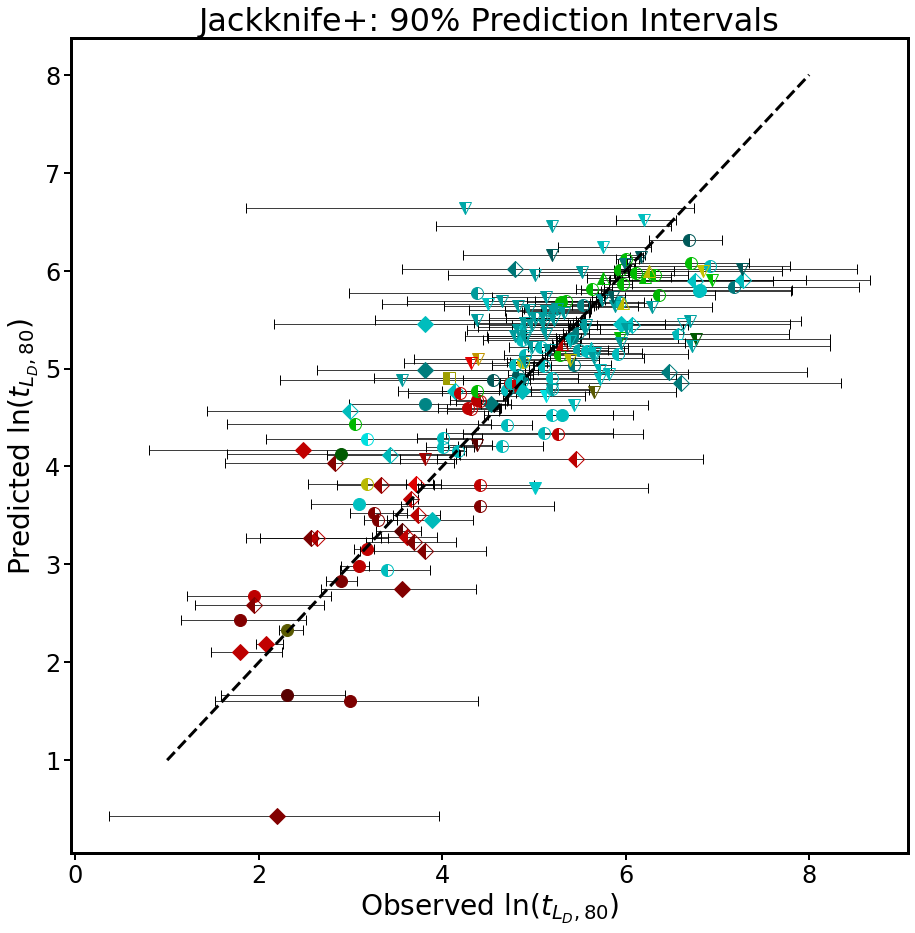

In [14]:
# make a parity plot with CIs

fig,ax = plt.subplots(figsize=(15,15))
ax.errorbar(Y,medians,xerr=[medians-L,U-medians],marker='',linestyle='',fmt='k-',elinewidth=0.75,capsize=5)
    
for i in range(len(medians)):
    idx = Y.index[i] # pull the corresponding index in the DF
    T = rawdata_df['Temp (deg C)'][idx] # get temperature
    RH = rawdata_df['RH (%)'][idx] # get relative humidity
    pct_O2 = rawdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx] # get illumination
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,'none')
    
    asym_error = [-(medians[i]-L[i]),U[i]-medians[i]]
    
    ax.plot(Y.iloc[i],medians[i],color=color,marker=marker,fillstyle=fill,linestyle=style)
    
    
x = np.linspace(1,8,num=2)
ax.plot(x,x,'k--')
ax.set_xlabel('Observed ln($t_{L_D,80}$)')
ax.set_ylabel('Predicted ln($t_{L_D,80}$)')
ax.set_title('Jackknife+: 90% Prediction Intervals')



Text(0.5, 0, 'Trial #')

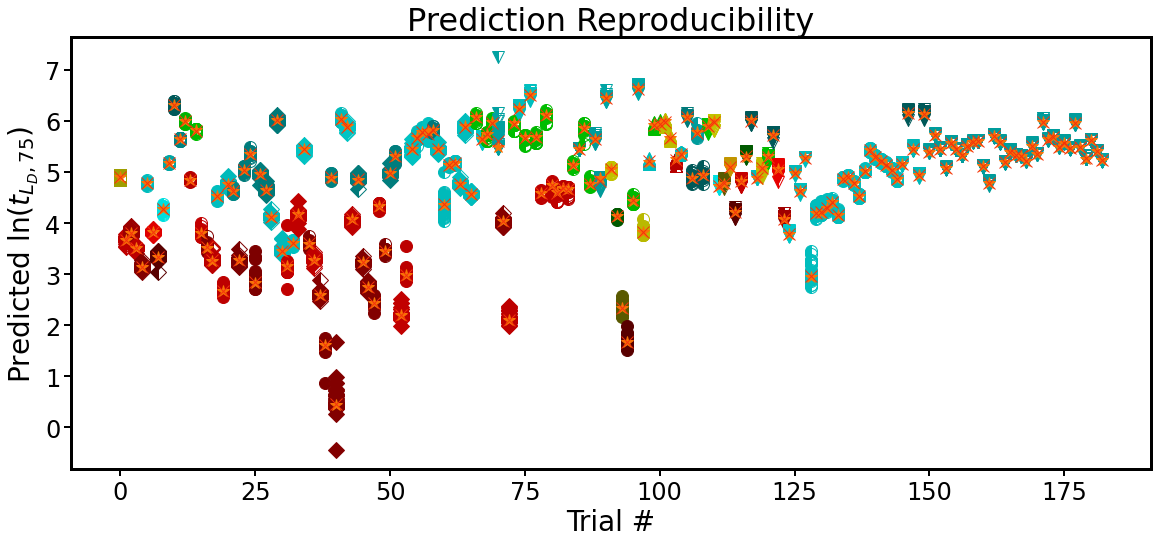

In [26]:
fig2 = plt.figure(figsize=(15,10))
ax2 = fig2.add_axes([0,0.4,1,0.6])

#ax2.errorbar(range(len(medians)),medians,yerr=[medians-L,U-medians],marker='',linestyle='',fmt='k-',elinewidth=0.75,capsize=5)   

for i in range(len(medians)):
    idx = Y.index[i] # pull the corresponding index in the DF
    T = rawdata_df['Temp (deg C)'][idx] # get temperature
    RH = rawdata_df['RH (%)'][idx] # get relative humidity
    pct_O2 = rawdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx] # get illumination
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,'none')
    
    asym_error = [-(medians[i]-L[i]),U[i]-medians[i]]
    ax2.plot(np.ones(j)*i,list(F[i,:])[:i]+list(F[i,:])[i+1:],color=color,marker=marker,fillstyle=fill,linestyle=style)


ax2.plot(range(len(medians)),medians,marker='*',color='xkcd:orange',linestyle='')
ax2.plot(range(len(means)),means,marker='x',color='xkcd:vermillion',linestyle='')
    
ax2.set_ylabel('Predicted ln($t_{L_D,75}$)')
ax2.set_title('Prediction Reproducibility')
ax2.set_xlabel('Trial #')
#ax2.set_xticklabels([])

# ax3 = fig2.add_axes([0,0,1,0.37])
# ax3.set_xlabel('Trial #')
# ax3.plot(range(len(medians)),stds/medians*100,marker='*',color='xkcd:orange',linestyle='')
# ax3.plot(range(len(means)),stds/means*100,marker='x',color='xkcd:vermillion',linestyle='')
# ax3.hlines(np.mean(stds/medians*100),0,len(medians),color='xkcd:orange',linestyle='--')
# ax3.hlines(np.mean(stds/means*100),0,len(means),color='xkcd:vermillion',linestyle='--')
# ax3.set_ylabel('$\sigma$ [%]')

In [17]:
asym_error

[-0.8262803416362052, 0.8578209307686961]